In [1]:
# 一、数据读取

# mysql数据读取——构造一个数据字典
import pymysql
import pandas as pd
import numpy as np
def mysqlExe(sql):
    conn = pymysql.connect(host="localhost",
                          port=3306,
                          user="root",
                          password="jn580236",
                          database="baidu_data",
                          charset="utf8")
    cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)
    cursor.execute(sql)
    data = cursor.fetchall()
    #对数据进行结构组织
    mydata = pd.DataFrame(data,columns = list(data[0].keys()))
    #pd.set_option('display.max_rows',None)
    #输出全部行结果，不省略
    #pd.set_option('display.max_columns',None)
    #输出全部列结果，不省略 
    #conn.commit()
    #在执行update、insert和delete命令时，需要增加一条conn.commit()命令
    cursor.close()
    conn.close()
    return mydata

#（一）数据sql —— 以星期为单位同时切开每个时辰的数据
week_datasql = "select c.原文摘要,c.c_time,c.H_time from \
(select b.原文摘要,dayname(b.date) as c_time,b.H_time from \
(select a.ID,a.书名,a.文档ID,a.用户ID,a.性别 as gender,a.年龄 as age,a.教育水平 as edu,a.原文摘要,a.time,\
a.date,EXTRACT(MONTH from a.time) as M_time,EXTRACT(DAY from a.time) as D_time,EXTRACT(HOUR from a.time) as H_time from \
(select ID,书名,文档ID,用户ID,性别,年龄,教育水平,原文摘要,FROM_UNIXTIME(`行为发生时间戳`,'%Y-%m-%d %H:%i:%s')as time,\
FROM_UNIXTIME(`行为发生时间戳`,'%Y-%m-%d')as date from reader_note where 书名 in \
('何以笙箫默','嫌疑人X的先生','小王子','边城','老人与海','傲慢与偏见','解忧杂货店','时间移民','谁动了我的奶酪')) a ) b ) c \
order by c.c_time,c.H_time"

# （二）数据字典 —— 构建以星期为key1，嵌套以时辰为key2，时辰内原文摘要为value的字典嵌套的字典数据
week_opt_data = mysqlExe(week_datasql) # 转化数据为dataframe
#week_list = list(set(week_opt_data['c_time'].tolist()))  # 获得日期列表
week_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']  # 获得星期列表

# 【全量week数据】
all_week_dict = {}
for week in week_list:
    h_week_dict = {}
    for i in range(0,24):
        data = week_opt_data.loc[(week_opt_data.c_time==week)&(week_opt_data.H_time==i)]['原文摘要'].tolist()
        #print("week：%s；i：%s；len：%s；"%(week,i,len(data)))
        h_week_dict['%s'%i]=data
    all_week_dict['%s'%week]=h_week_dict

# （三） 拆分数据子字典 —— 将all_week_dict按照工作日、周末、节假日、周末+节假日拆分成四个子字典
def get_dict_sentnum(data_dict):
    # 获取两层字典嵌套中，对应时间节点的评论条数
    sentnum = []
    for i in data_dict.keys():
        for j in data_dict[i].keys():
            num = len(data_dict[i][j])
            sentnum.append(num)
    return sentnum

# （1）原始week下的每个时刻评论条数
week_moral_sentnum = get_dict_sentnum(all_week_dict)
# （2）切分数据集使用config
workdays_list = week_list[0:5]
weekend_list = week_list[5:7]
holiday_list = ['2017-03-08','2017-04-04','2017-05-01','2017-05-02','2017-05-03']
weekend_holiday_list = weekend_list+holiday_list
# 注：2017-3-8(妇女节) 2017-04-04（清明节），2017-5-1,2017-5-2,2017-5-3(国庆节)

#**********************************************************************************************
# 补充数据集（用于构建节假日使用）
# 由于节假日是单独的日期，因此需要构建以date为单位的数据字典来引用

# B（一） 数据sql —— 按天为单位切开每个时辰的数据
date_datasql = "select b.原文摘要,b.date,b.H_time from \
(select a.ID,a.书名,a.文档ID,a.用户ID,a.性别 as gender,a.年龄 as age,a.教育水平 as edu,a.原文摘要,a.time,\
a.date,EXTRACT(MONTH from a.time) as M_time,EXTRACT(DAY from a.time) as D_time,EXTRACT(HOUR from a.time) as H_time from \
(select ID,书名,文档ID,用户ID,性别,年龄,教育水平,原文摘要,FROM_UNIXTIME(`行为发生时间戳`,'%Y-%m-%d %H:%i:%s')as time,\
FROM_UNIXTIME(`行为发生时间戳`,'%Y-%m-%d')as date from reader_note where 书名 in \
('何以笙箫默','嫌疑人X的先生','小王子','边城','老人与海','傲慢与偏见','解忧杂货店','时间移民','谁动了我的奶酪')) a ) b \
order by b.date,H_time"

# B（二）构建按date为key1，嵌套以时辰为key2，时辰内原文摘要为value的字典嵌套的字典数据
date_opt_data = mysqlExe(date_datasql) # 转化数据为dataframe
date_list = list(set(date_opt_data['date'].tolist()))  # 获得日期列表

# B（三）对date_list列表中的日期进行按日期排序
import datetime  
def get_timestamp(date):
    return datetime.datetime.strptime(date,"%Y-%m-%d").timestamp()
date_list_sort = sorted(date_list,key=lambda date:get_timestamp(date))

#print(date_opt_data[0:10])
#print(date_list)
#print(date_list_sort)

# 以天为单位并切分每一天中每个时辰的切分字典
all_date_dict = {} 
for date in date_list:
    h_data_dict = {}
    for i in range(0,24):
        data = date_opt_data.loc[(date_opt_data.date==date)&(date_opt_data.H_time==i)]['原文摘要'].tolist()
        h_data_dict['%s'%i]=data
    all_date_dict['%s'%date] = h_data_dict

#***********************************************************************************************
# 全量week，每个时刻下的评论条数
week_sentnum = get_dict_sentnum(all_week_dict)
# （3）工作日，节假日，周末，节假日&周末——每个时刻下的评论条数
#（3.1）工作日的子字典 & 每个时刻下的评论条数
workdays_dict = {key:value for key,value in all_week_dict.items() if key in workdays_list}
workdays_sentnum = get_dict_sentnum(workdays_dict)
print(workdays_sentnum[0:10])
#（3.2）周末的子字典 & 每个时刻下的评论条数
weekend_dict = {key:value for key,value in all_week_dict.items() if key in weekend_list}
weekend_sentnum = get_dict_sentnum(weekend_dict)
#（3.3）节假日的子字典（这个字典不是从all_week_dict中拆出来的，而是从all_date_dict中挑选出来）
holiday_dict = {key:value for key,value in all_date_dict.items() if key in holiday_list}
holiday_sentnum = get_dict_sentnum(holiday_dict)
print(holiday_dict.keys())
# （3.4）周末+节假日的字字典（字典合并）& 每个时刻下的评论条数
weekend_holiday_dict = {**weekend_dict,**holiday_dict}
weekend_holiday_sentnum = get_dict_sentnum(weekend_holiday_dict)

[263, 101, 44, 41, 14, 19, 90, 115, 209, 226]
dict_keys(['2017-05-02', '2017-05-03', '2017-05-01', '2017-04-04', '2017-03-08'])


In [2]:
# 二、情感词列表读取——构建情感词列表
# （一）构造情感词词典
import os
path1 = r'F:/姜崇博士文档/博士文本selfcorpus/SC-LIWC/new_LIWC/zl_LIWC/EMO_subpathconfig.txt'
path2 = r'F:/姜崇博士文档/博士文本selfcorpus/SC-LIWC/new_LIWC/zl_LIWC/LIWC_subpathconfig.txt'
path3 = r'F:/姜崇博士文档/博士文本selfcorpus/SC-LIWC/new_LIWC/zl_LIWC/emo/lex_degree.txt'
path4 = r'F:/姜崇博士文档/博士文本selfcorpus/SC-LIWC/new_LIWC/zl_LIWC/Emotions_CLWC_subpathconfig.txt'
with open(path1,'r',encoding='utf-8') as file:
    content1 = file.readlines()
with open(path2,'r',encoding='utf-8') as file:
    content2 = file.readlines()
with open(path3,'r',encoding='utf-8') as file:
    content3 = file.readlines()
with open(path4,'r',encoding='utf-8') as file:
    content4 = file.readlines()

# （1）构造emotion（包含agency,communion,lex_negation,lex_noscore_degree）的情感词典
emo_dict = {}    
for i in content1:
    emo_path = i.strip()
    name = os.path.split(emo_path)[1]
    with open(emo_path,'r',encoding='utf-8') as file:
        content = file.readlines()
        words = [i.strip() for i in content]
        emo_dict[name]=words

# （2）构建degree（程度词-lex_degree）的情感词典
# 注：程度词带有权重值，因此单独进行构造字典
degree_dict = {}
for i in content3:
    words = i.strip().split()[0]
    values = int(i.strip().split()[1])
    degree_dict[words] = values

#*********************************************************************
# 补充构造——LIWC的情感词典
liwc_dict = {}
for i in content2:
    liwc_path = i.strip()
    name = os.path.split(liwc_path)[1]
    with open(liwc_path,'r') as file:
        content = file.readlines()
        words = [i.strip() for i in content]
        liwc_dict[name]=words

# 构造C_liwc的情感词典(中文liwc情感词典)
#【注，这里的字典编码用的gbk，因此在打开解码时需要用utf-8解码】
cliwc_dict = {}
for i in content4:
    cliwc_path = i.strip()
    name = os.path.split(cliwc_path)[1]
    with open(cliwc_path,'r',encoding='utf-8') as file:
        content = file.readlines()
        words = [i.strip() for i in content]
        cliwc_dict[name]=words

#*********************************************************************
# （3）生成拥有全部情感词的文件，用于结巴分词的自定义字典（避免结巴分词将情感词切乱）
total_dict =dict(emo_dict,**liwc_dict,**cliwc_dict)   #含有全部情感词及分类名字典
total_words = []   #含有全部情感词列表
for i in total_dict.values():
    total_words = total_words+i

# （4）构造加入程度词，communion+agency+lex_negation+degree词表用来做否定词+程度词修饰的语句
lex_emo_degree_words = []
for i in emo_dict.values():
    lex_emo_degree_words = lex_emo_degree_words + i
print(len(lex_emo_degree_words))
jieba_dict_path = r'F:/姜崇博士文档/博士文本selfcorpus/SC-LIWC/new_LIWC/zl_LIWC/total_emotion_words.txt'

'''
# 用于构造并生成结巴分词的自定义字典（已完成）
jieba_dict_path = r'F:/姜崇博士文档/博士文本selfcorpus/SC-LIWC/new_LIWC/zl_LIWC/total_emotion_words.txt'
for i in total_words:
    with open(jieba_dict_path,'a+',encoding='utf-8')as file:
        file.writelines(i+'\n')
'''

1390


"\n# 用于构造并生成结巴分词的自定义字典（已完成）\njieba_dict_path = r'F:/姜崇博士文档/博士文本selfcorpus/SC-LIWC/new_LIWC/zl_LIWC/total_emotion_words.txt'\nfor i in total_words:\n    with open(jieba_dict_path,'a+',encoding='utf-8')as file:\n        file.writelines(i+'\n')\n"

In [3]:
# 三、结巴自定义字典与利用程度词规则进行结巴分词
import jieba
import re
import jieba.posseg as pseg
# 向结巴加载导入自定义的词典
jieba.load_userdict(jieba_dict_path)

# 函数（一）：输入包含句子的列表，输出为结巴分词后的词列表（采用自定义词典切割）
def get_segment(words):
    new_words = []
    for i in words:
        word = jieba.lcut(i)
        new_words = new_words + word
    return new_words

# 函数（二）：输入的是标注字典中的句子，输出为结巴分词后的词列表（采用自定义词典切割）
def get_sent_segment(sent):
    new_words = []
    word = jieba.lcut(sent)
    new_words = new_words + word
    return new_words

# 函数（三）：输入为两个包含词的列表，返回四个列表
# （1）两个列表的交集（不去重）
# （2）两个列表的交集（去重）
# （3）第一个返回的列表的长度（不去重单词数）
# （4）第二个返回的列表的长度（去重后单词数）
def compare_word(words1,words2):
    union = [word for word in words1 if word in words2]
    union_set = set(union)
    union_num = len(union)
    union_set_num = len(union_set)
    return union,union_set,union_num,union_set_num

# 函数（四）：输入为agency词表的统计次数列表和communion词表的统计次数列表
# 输出为道德分数，agency和communion的词表频率
def get_score_moral(data_agency,data_communion):
    data_tuple = list(zip(data_agency,data_communion))
    data_moral = []
    for ac in data_tuple:
        score_moral = ac[1]*722/(ac[0]*290)
        data_moral.append(score_moral)
    score_agency = []
    for ag in data_agency:
        sc_agency = ag/722
        score_agency.append(sc_agency)
    score_communion = []
    for co in data_communion:
        sc_communion = co/290
        score_communion.append(sc_communion)
    return data_moral,score_agency,score_communion

#********************************************************
# 程度词规则制定
# 函数（六）——依赖子函数（被用在子函数中）
# （1）第一层句子切分，利用双引号将对话内容抽取（“对话内容”）
def split_sentences_dialogue(line):
    line_split = re.split(r'[“”]',line.strip())
    line_split = [line.strip() for line in line_split if line.strip() not in ['“','”'] and len(line.strip())>1]
    return line_split

# （2）第二层切分，对旁白句子进行整句切分（非对话部分）
import re
def split_sentences_aside(line):
    line_split = re.split(r'[。！？；……]',line.strip())
    line_split = [line.strip() for line in line_split if line.strip() not in ['。','！','?','；','……'] and len(line.strip())>1]
    return line_split

# （3）第三层句子切分，增加（，）将整句进行切分（注：由于对话（dialogue）中仍然存在整句，因此需要增加（，）进行分句分割）
def split_half_sentences(line):
    line_split = re.split(r'[，。？！；……]',line.strip())
    line_split = [line.strip() for line in line_split if line.strip() not in ['，','。','？','！','；','……'] and len(line.strip())>1]
    return line_split

# （4）输入元组，输出元组内元素乘积结果
def product_tuple(tuple_example):
    from functools import reduce
    result = reduce(lambda x,y:x*y,tuple_example)
    return result

# 函数（六）——主函数
# 输入为一个批注句子，输出为按照程度词修饰后得到该句子中，communion和agency的词列表
def sent_degree_cal(data_sentence):
    # （一）句子级别拆分处理
    # 先利用（“”）把对话部分切割出来
    sentence_dialogue = split_sentences_dialogue(data_sentence)
    #print('第一层切割（“”）sentence:\n',sentence2)
    # 双引号之间的内容
    # （1）利用正则表达式将切割出来的对话部分构建一个单独的对话列表
    pattern = re.compile(r'“'+r'(.*?)'+r'”',re.S)
    dialogues = pattern.findall(data_sentence)
    #（2） 利用对话列表找到旁白部分的句子并按照整句进行切割，将整句和对话句子按照顺序重新组合成新句子列表
    # 这里之所以将对话句子单独拿出来，是当整体进行切割时，会将对话部分拆乱，无法组成一个单独句子
    new_split_sentences = []
    for i in sentence_dialogue:
        if i not in dialogues:
            sent_aside = split_sentences_aside(i)
            new_split_sentences = new_split_sentences + sent_aside
        if i in dialogues:
            sent_dialogues = r'“'+i+r'”'
            new_split_sentences.append(sent_dialogues)
    #print(new_split_sentences)
    # （3）增加逗号（，）将所有句子进行分句切分，每一个list里面是一个整句的分句
    # 型如：一条记录：{句子1：【[分句1]，[分句2]】，句子2：【[分句1]，[分句2]】}
    half_new_split_sentences = []
    for i in new_split_sentences:
        half_sentences = split_half_sentences(i)
        half_new_split_sentences.append(half_sentences)
    #print('分句列表：',half_new_split_sentences)
    # （二） 词级别拆分处理
    # （4）对新句子列表中的分句进行词切割
    mid_sent_list = []
    for i in half_new_split_sentences:
        mid_sent = []
        for j in i:
            words = get_sent_segment(j)
            #lex_emo_degree_words包括否定词，程度词，agency,communion四个词表的所有词列表
            new_words = [m for m in words[::-1] if m in lex_emo_degree_words]
            #将程度词替换为（程度词，权重）的元组
            degree_words = [m if m not in degree_dict.keys() else (m,degree_dict[m]) for m in new_words]
            # （4.1）处理特殊情况——一点也（程度1）+不（否定）
            new_degree_words = []
            # #########这里要补充特殊情况，程度词否定词的互相修饰
            for m,n in enumerate(degree_words):
                if type(n)==tuple and n[0] in ['一点','一点儿','一点点','一丁点','一丁点儿']:
                    if m>=1 and degree_words[m-1] in ['不会','也','都不','也不','不']:
                        new_degree = (n[0],3)
                        new_degree_words.append(new_degree)
                else:
                    new_degree_words.append(n)
            #（4.2）将否定词统一处理为'0'
            negation_words = [m if m not in emo_dict['lex_negation.txt'] else '0' for m in new_degree_words]
            # （4.3）将程度词改成统一字典形式
            # 这里改成统一形式是方便后续进行分组
            new_negation_words = []
            for i in negation_words:
                if type(i)==tuple:
                    new_i = {'degree':i[1]}
                    new_negation_words.append(new_i)
                else:
                    new_negation_words.append(i)
            # （4.4）将列表中的程度词进行itertools.groupby分组
            # 这里会将相邻的程度词，否定词分割成独立模块，最终剩下三种形式的组合
            from itertools import groupby
            from operator import itemgetter
            groupby_degree_words = [list(g) for k,g in groupby(new_negation_words,key=tuple)]
            # （4.5）将程度词列表构成元组
            new_groupby_degree_words = []
            for i in groupby_degree_words:
                if {'degree':1} in i or {'degree':2} in i or {'degree':3} in i:
                    degree_tuple = tuple([m['degree'] for m in i])
                    new_groupby_degree_words.append(degree_tuple)
                elif '0' in i:
                    lex_negation_tuple = tuple(i)
                    new_groupby_degree_words.append(lex_negation_tuple)
                else:
                    new_groupby_degree_words = new_groupby_degree_words + i
            #print(new_groupby_degree_words)
            # （4.6）将agency和communion与程度词和否定词进行捆绑
            union_degree_negation_words = []
            flag=0
            for m,n in enumerate(new_groupby_degree_words):
                if flag==0:
                    if m==0 and type(n)==tuple:
                        if '0' not in n:
                            if m<len(new_groupby_degree_words)-1:
                                if new_groupby_degree_words[m+1] in emo_dict['agency.txt'] or new_groupby_degree_words[m+1] in emo_dict['communion.txt']:
                                    # 程度词+com/agen+否定词
                                    if m<len(new_groupby_degree_words)-2 and '0' in new_groupby_degree_words[m+2]:
                                        union_tuple1 = (n,new_groupby_degree_words[m+1],new_groupby_degree_words[m+2])
                                        union_degree_negation_words.append(union_tuple1)
                                        flag = 2
                                    # 程度词+com/agen
                                    elif m<len(new_groupby_degree_words)-2 and '0' not in new_groupby_degree_words[m+2]:
                                        union_tuple2 = (n,new_groupby_degree_words[m+1])
                                        union_degree_negation_words.append(union_tuple2)
                                        flag=1
                                    # 其他情况
                                    else:
                                        union_tuple3 = (n,new_groupby_degree_words[m+1])
                                        union_degree_negation_words.append(union_tuple3)
                                        flag =1
                                else:union_degree_negation_words.append(n)
                            else:union_degree_negation_words.append(n)
                        else:union_degree_negation_words.append(n)    
                    elif n in emo_dict['agency.txt'] or n in emo_dict['communion.txt']:
                        if m<len(new_groupby_degree_words)-1 and type(new_groupby_degree_words[m+1])==tuple:
                            # com/agen+否定词或程度词+否定词或程度词
                            if m<len(new_groupby_degree_words)-2 and type(new_groupby_degree_words[m+2])==tuple:
                                union_tuple4 = (n,new_groupby_degree_words[m+1],new_groupby_degree_words[m+2])
                                union_degree_negation_words.append(union_tuple4)
                                flag=2
                            # com/agen+否定词或程度词
                            elif m<len(new_groupby_degree_words)-2 and type(new_groupby_degree_words[m+2])!=tuple:
                                union_tuple5 = (n,new_groupby_degree_words[m+1])
                                union_degree_negation_words.append(union_tuple5)
                                flag=1
                            # 其他情况
                            else:
                                union_tuple6 = (n,new_groupby_degree_words[m+1])
                                union_degree_negation_words.append(union_tuple6)
                                flag = 1                   
                        else:
                            union_degree_negation_words.append(n)
                    else:
                        union_degree_negation_words.append(n)
                else:
                    flag -= 1
            #print(union_degree_negation_words)
            #（4.7）将没有与communion和agency组合的程度词进行计算，将否定词进行舍弃
            # 保留分句中的连续程度词或单独程度词进行计算并生成数值。
            cal_degree_negation_words1 = []
            for i in union_degree_negation_words:
                if type(i)==tuple:
                    if '0' in i:
                        pass
                    elif 1 in i or 2 in i or 3 in i:
                        score = np.prod(i)
                        cal_degree_negation_words1.append(score)
                    else:
                        cal_degree_negation_words1.append(i)
                else:
                    cal_degree_negation_words1.append(i)
            #print(cal_degree_negation_words1)
            # （4.8）计算与communion和agency组合的程度词和否定词
            # 判断有否定词的计算是否需要改变词向，用1和-1表示
            # 判断有程度词的，计算程度词的乘积
            cal_degree_negation_words2 = []
            for i in cal_degree_negation_words1:
                if type(i)==tuple:
                    temp = []
                    for m in i:
                        if m in emo_dict['communion.txt'] or m in emo_dict['agency.txt']:
                            temp.append(m)
                        elif '0' in m:
                            if len(m)/2==0:
                                unchange = 1
                                temp.append(unchange)
                            else:
                                change = -1
                                temp.append(change)
                        elif 1 in m or 2 in m or 3 in m:
                            new_score = np.prod(m)
                            temp.append(new_score)
                    new_temp = tuple(temp)
                    cal_degree_negation_words2.append(new_temp)
                else:
                    cal_degree_negation_words2.append(i)
            #print(cal_degree_negation_words2)
            # （4.9）计算元组中的乘积
            # 将与communion和agency进行组合的程度词以及词向（1，-1）也进行计算，只保留最终组合计算结果
            cal_degree_negation_words3 = []
            for i in cal_degree_negation_words2:
                if type(i)==tuple:
                    word = [x for x in i if type(x)==str]
                    num = [x for x in i if type(x)!=str]
                    score = np.prod(num)
                    new_tuple = tuple(word+[score])
                    cal_degree_negation_words3.append(new_tuple)
                else:
                    cal_degree_negation_words3.append(i)
            #print(cal_degree_negation_words3)
            # 分句合成整句
            mid_sent.append(cal_degree_negation_words3)
        # 整句组成一条数据记录
        mid_sent_list.append(mid_sent)
    #print(mid_sent_list)
    # （5）将分句形成的多个列表融合进一个整句列表中。减少层级
    new_mid_sent_list=[]
    for i in mid_sent_list:
        operat_sent = []
        for j in i:
            operat_sent+=j
        new_mid_sent_list.append(operat_sent)
    #print(new_mid_sent_list)
    # （6）从整句中去除只有程度词不包含communion和agency的句子
    # 下面的代码可以判断列表中的元素是否都是统一type的简便判断。
    #len(list(groupby(yourlist,lambda i:type(i)))) == 1
    end_sent_list = []
    for i in new_mid_sent_list:
        if any(type(j) is str or type(j) is tuple for j in i):
            end_sent_list.append(i)
        else:
            pass
    #print(end_sent_list)
    # （7）计算分句中独立程度词对整个句子中communion和agency的词列表划分
    end_sent_words_list = []
    for i in end_sent_list:
        num = [j for j in i if not type(j)==str and not type(j)==tuple]
        words = [j for j in i if type(j)==str or type(j)==tuple]
        score = int(np.prod(num))
        new_words = score*words
        end_sent_words_list += new_words
    #print(end_sent_words_list)
    # （8）将元组中数值不为负的tuple组合拆分，保留数值为负的tuple组合。
    final_sent_words_list = []
    for i in end_sent_words_list:
        if type(i)==tuple:
            if i[1]>0:
                num = int(i[1])
                word = [i[0]]
                new_word = num*word
                final_sent_words_list += new_word
            else:
                final_sent_words_list.append(i)
        else:
            final_sent_words_list.append(i)
    #print(final_sent_words_list)
    # （9）最后保留的tuple类型是只有负值，需要变换词典的
    degree_communion = []
    degree_agency = []
    for i in final_sent_words_list:
        if type(i)==tuple:
            if i[0] in emo_dict['communion.txt']:
                num = int(abs(i[1]))
                word = [i[0]]
                new_word = num*word
                degree_agency += new_word
            if i[0] in emo_dict['agency.txt']:
                num1 = int(abs(i[1]))
                word1 = [i[0]]
                new_word1 = num1*word1
                degree_communion += new_word1
        else:
            if i in emo_dict['communion.txt']:
                degree_communion.append(i)
            elif i in emo_dict['agency.txt']:
                degree_agency.append(i)
    return degree_communion,degree_agency
#********************************************************
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# 函数（五）：使用否定词表，对每一个句子进行计算被否定词修饰的communion和agency词表
# 输入为一条标注句子，输出为该句子中的communion和agency的列表
# 函数依赖词表：lex_emo_words
# 函数依赖自定义函数：get_sent_segment
# 函数依赖官方包：itertools.groupby()
def getlex_communion_agency(sent):
    from itertools import groupby
    
    cal_sent = get_sent_segment(sent)
    new_cal_sent = [i for i in cal_sent[::-1] if i in lex_emo_words]
    change_new_cal_sent = [i if i not in emo_dict['lex_negation.txt'] else '0' for i in new_cal_sent]
    result = [list(g) for k,g in groupby(change_new_cal_sent)]
    new_result = []
    for i,j in enumerate(result):
        if i < len(result)-1:
            if '0' not in j and '0' not in result[i+1]:
                new_result = new_result + j
            if '0' not in j and '0' in result[i+1]:
                fale_tuple = tuple(j+result[i+1])
                new_result.append(fale_tuple)
        else:
            new_result = new_result + j
    end_communion = []
    end_agency = []
    for i in new_result:
        if '0' not in i:
            if i in emo_dict['communion.txt']:
                end_communion.append(i)
            if i in emo_dict['agency.txt']:
                end_agency.append(i)
        if '0' in i:
            num = len(i)-1
            if (num%2) == 0:
                if i[0] in emo_dict['communion.txt']:
                    end_communion.append(i)
                if i[0] in emo_dict['agency.txt']:
                    end_agency.append(i)
            else:
                if i[0] in emo_dict['communion.txt']:
                    end_agency.append(i)
                if i[0] in emo_dict['agency.txt']:
                    end_communion.append(i)
    return end_communion,end_agency


# （5）构造加入否定词的，communion+agency+lex_negation词表用来做后面的否定词修饰的语句(不包括degree程度词)
lex_emo_words = []
for i,j in emo_dict.items():
    if i != 'lex_noscore_degree.txt':
        for m in j:
            lex_emo_words.append(m)
print(len(lex_emo_words))
# （6）构造加入程度词的，communion+agency+lex_negation+degree词表用来做后面的否定词＋程度词修饰的语句
lex_emo_degree_words = []
for i in emo_dict.values():
    lex_emo_degree_words = lex_emo_degree_words + i
print(len(lex_emo_degree_words))
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\83919\AppData\Local\Temp\jieba.cache
Loading model cost 0.586 seconds.
Prefix dict has been built successfully.


1039
1390


In [4]:
# 四、分词获取每小时communion和agency词列表，计算情境中的moral值
# 由于计算moral不能存在分母为0的情况，预处理将列表中0的值替换为1。
def change01(data):
    new_data = []
    for i in data:
        if i==0:
            i=i+1
            new_data.append(i)
        else:
            new_data.append(i)
    return new_data

'''
# week总量，workday_dict,weekend_dict,holiday_dict,weekend_holiday_dict
# 利用程度词进行分词获得communion和agency词表，和总切分词统计数
# 输入为数据集名称列表，和数据集词典，输出为communion，agency,all_words三个词统计列表
def degreecal_communion_agency_list(name_list,name_dict):
    week_communion = []
    week_agency = []
    cut_words_num = []
    for j in range(0,24):
        for i in name_list:
            segwords = get_segment(name_dict[i]['%s'%j])
            nums = len(segwords)
            cut_words_num.append(nums)
            temp_communion = []
            temp_agency = []
            for m in name_dict[i]['%s'%j]:
                c,a = sent_degree_cal(m)
                temp_communion += c
                temp_agency += a
            week_communion.append(len(temp_communion))
            week_agency.append(len(temp_agency))
    return week_communion,change01(week_agency),cut_words_num

'''
# 利用否定词进行分词获得communion和agency词表，和总切分词统计数
# 输入为数据集名称列表，和数据字典，输出为communion，agency，all_words三个词统计表
# 这里进行修改：不再将communion中的0值修改，只修改agency中的0值保证能除，从而使moral可以为0
def degreecal_communion_agency_list(name_list,name_dict):
    week_communion = []
    week_agency = []
    cut_words_num = []
    for j in range(0,24):
        for i in name_list:
            segwords = get_segment(name_dict[i]['%s'%j])
            nums = len(segwords)
            cut_words_num.append(nums)
            temp_communion = []
            temp_agency = []
            for m in name_dict[i]['%s'%j]:
                c,a = getlex_communion_agency(m)
                temp_communion += c
                temp_agency += a
            week_communion.append(len(temp_communion))
            week_agency.append(len(temp_agency))
    return week_communion,change01(week_agency),cut_words_num


# 注：下列数据已经完成将0值替换成1

# 利用程度词切分处理获得五种情境的communion、agency词列表,切分词总数量
#（1）week总量数据——168条【communion，agency，all_words】
week_communion,week_agency,week_all_words = degreecal_communion_agency_list(week_list,all_week_dict)
#print(week_communion[0:21])
#print(week_agency[0:21])
#（2）workdays数据——120条【communion，agency，all_workdays_words】
workdays_communion,workdays_agency,workdays_all_words = degreecal_communion_agency_list(workdays_list,workdays_dict)
#（3）weekend数据——48条【communion，agency，all_weekend_words】
weekend_communion,weekend_agency,weekend_all_words = degreecal_communion_agency_list(weekend_list,weekend_dict)
#（4）holiday数据——120条【communion，agency，all_holiday_words】
holiday_communion,holiday_agency,holiday_all_words = degreecal_communion_agency_list(holiday_list,holiday_dict)
#（5）weekend_holiday数据——168条【communion，agency，all_weekend_holiday_words】
weekend_holiday_communion,weekend_holiday_agency,weekend_holiday_all_words = degreecal_communion_agency_list(weekend_holiday_list,
                                                                                                             weekend_holiday_dict)

#print(holiday_communion)
#print(holiday_agency)
# 计算五种情境的moral值,rate_agency,rate_communion
# （1）week总量数据——168条【moral，rate_agency,rate_communion】
week_moral,week_score_agency,week_score_communion = get_score_moral(week_agency,week_communion)
#（2）workdays数据——120条【moral,rate_agency,rate_communion】
workdays_moral,workdays_score_agency,workdays_score_communion = get_score_moral(workdays_agency,workdays_communion)
#（3）weekend数据——48条【moral,rate_agency,rate_communion】
weekend_moral,weekend_score_agency,weekend_score_communion = get_score_moral(weekend_agency,weekend_communion)
#（4）holiday数据——120条【moral,rate_agency,rate_communion】
holiday_moral,holiday_score_agency,holiday_score_communion = get_score_moral(holiday_agency,holiday_communion)
#（5）weekend_holiday数据——168条【moral,rate_agency,rate_communion】
weekend_holiday_moral,weekend_holiday_score_agency,weekend_holiday_score_communion = get_score_moral(weekend_holiday_agency,
                                                                                                     weekend_holiday_communion)
print(week_communion)
print(week_agency)
print(week_all_words)

[26, 32, 25, 24, 26, 53, 28, 8, 8, 10, 24, 16, 13, 19, 6, 4, 2, 3, 7, 6, 7, 4, 1, 0, 9, 5, 2, 20, 0, 4, 1, 1, 1, 1, 2, 2, 4, 1, 7, 1, 2, 3, 5, 7, 13, 21, 6, 12, 11, 16, 25, 13, 10, 21, 19, 11, 62, 11, 32, 30, 17, 32, 32, 39, 24, 25, 37, 26, 24, 29, 40, 31, 18, 57, 14, 52, 56, 21, 41, 32, 67, 47, 86, 12, 14, 40, 28, 17, 45, 34, 47, 32, 42, 54, 40, 58, 50, 59, 49, 35, 27, 37, 21, 23, 44, 49, 38, 38, 49, 36, 47, 61, 28, 35, 45, 57, 62, 52, 23, 36, 37, 47, 31, 34, 59, 26, 33, 75, 38, 38, 36, 21, 36, 42, 66, 47, 42, 20, 74, 57, 38, 58, 30, 37, 30, 71, 54, 52, 81, 32, 24, 46, 79, 84, 49, 65, 60, 47, 49, 35, 55, 48, 48, 53, 41, 47, 32, 45]
[91, 89, 91, 46, 77, 96, 70, 17, 20, 28, 49, 31, 32, 40, 16, 1, 6, 10, 27, 9, 15, 12, 8, 8, 11, 7, 3, 33, 1, 14, 5, 3, 1, 7, 2, 8, 24, 17, 16, 5, 9, 8, 21, 38, 22, 50, 21, 25, 18, 45, 55, 48, 14, 49, 45, 18, 141, 40, 88, 76, 60, 82, 73, 96, 60, 65, 74, 91, 54, 72, 88, 57, 51, 146, 50, 135, 114, 80, 103, 80, 180, 96, 209, 76, 51, 96, 62, 73, 97, 81, 105, 89,

In [5]:
# 五、根据情境对数据列表进行基本统计分析

# 统计分析函数区
import numpy as np
import scipy
from scipy import stats
from statistics import mean, stdev
from math import sqrt
import itertools

# 获取数据的平均值，方差，标准差
def get_mean_score(data):
    avg_data = np.mean(data)
    var_data = np.var(data)
    std_data = np.std(data)
    return avg_data,var_data,std_data

# 获取数据的置信为005,001的单边t检验
def get_t_sigle(data):
    t_test_005 = stats.ttest_1samp(data,1.711)
    t_test_001 = stats.ttest_1samp(data,2.492)
    return t_test_005,t_test_001

# 获取data1与data2的双样本交叉检验和cohens_d指数
def get_t_cohens_double(data1,data2):
    t_test_double = stats.ttest_ind(data1,data2,equal_var=True)
    cohens_d = (mean(data1) - mean(data2)) / (sqrt((stdev(data1) ** 2 + stdev(data2) ** 2) / 2))
    return t_test_double,cohens_d

# 补充函数（多区间的两两交叉皮尔逊相关系数检验和t检验）
import pandas as pd
from scipy.stats import pearsonr,spearmanr,kendalltau

def get_2crosscheck_t_double(data_all_time):
    # 输入为数据的列表嵌套
    # 遍历所有组合情况进行t,cohensd检验，并生成对应情况的字典形式输出
    data_all_time_dict = {}
    for x in itertools.combinations(data_all_time,2):
        list1_index = data_all_time.index(x[0])
        list2_index = data_all_time.index(x[1])
        crosscheck = (list1_index,list2_index)
        t,cohensd = get_t_cohens_double(x[0],x[1])
        data_all_time_dict[crosscheck] = (t,cohensd)
    return data_all_time_dict

def get_correlation(data1,data2):
    pearson = pearsonr(data1,data2)
    spearman = spearmanr(data1,data2)
    kendall = kendalltau(data1,data2)
    return pearson,spearman,kendall

# 输出函数
def print_mean_score(name,a,b,c):
    print("%s，\n平均值：%s；\n方差：%s；\n标准差：%s"%(name,a,b,c))
def print_t_sigle(name,a,b):
    print("%s,单边T检验：\n005置信：%s；\n001置信：%s"%(name,a,b))
def print_correlation(name1,name2,a,b,c):
    print("%s与%s相关性检验：\nPearson：%s；\nSpearman：%s；\nKendall：%s"%(name1,name2,a,b,c))
    
# 画基本箱型图
# 箱型图分析
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
mpl.rcParams['font.sans-serif']=['SimHei'] # 支持中文
%matplotlib inline

def get_boxgraph(name_list,x_label,y_label,title_name,*data):
    # 输入为，每个箱子的名字列表(name_list-['moral','agency','communion'])，x轴label,y轴label,图title名字，可变多数据集
    # 数据集为列表嵌套，（这个函数对数据集进行了矩阵转置）
    new_data = list(data)
    df = pd.DataFrame(new_data)
    df2 = pd.DataFrame(df.values.T,index=df.columns,columns=name_list) # 对矩阵进行转置
    df2.plot.box(title='%s'%title_name,figsize=(12,8))
    plt.grid(linestyle='--',alpha=0.3)
    plt.xlabel(u'%s'%x_label)
    plt.ylabel(u'%s'%y_label)
    #plt.savefig(u'%s.png'%title_name)
    plt.show()

week_moral，
平均值：1.079771918284641；
方差：0.5930865292756229；
标准差：0.7701211133812804
week_score_communion，
平均值：0.1088464696223317；
方差：0.0050034878943650395；
标准差：0.07073533695660918
week_score_agency，
平均值：0.1063678934177549；
方差：0.004561300272929771；
标准差：0.06753739906844038
week_moral,单边T检验：
005置信：Ttest_1sampResult(statistic=-10.592184009856826, pvalue=2.2272792575628204e-20)；
001置信：Ttest_1sampResult(statistic=-23.697582757671906, pvalue=2.6662868674330454e-55)
week_score_communion,单边T检验：
005置信：Ttest_1sampResult(statistic=-292.7021685315615, pvalue=2.651095567913147e-228)；
001置信：Ttest_1sampResult(statistic=-435.3853691666857, pvalue=4.6034412999667964e-257)
week_score_agency,单边T检验：
005置信：Ttest_1sampResult(statistic=-307.03605807359213, pvalue=9.169094850867475e-232)；
001置信：Ttest_1sampResult(statistic=-456.47539707960425, pvalue=1.7186012750116646e-260)
week_moral与评论条数相关性检验：
Pearson：(-0.013427089581005221, 0.8628531286610837)；
Spearman：SpearmanrResult(correlation=-0.07214173851906923, pvalue=

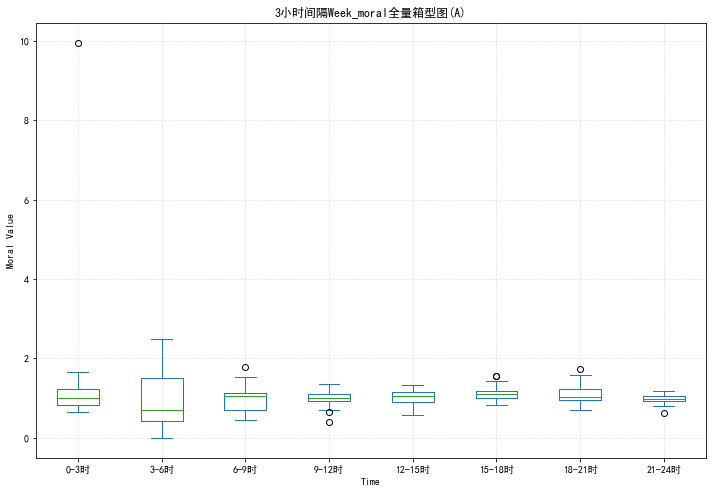

Week三时区，B
index:0;（1时-4时）时间区间;平均值：1.5150571424674675;方差：3.7835173576607652;标准差：1.9451265659747607
index:1;（4时-7时）时间区间;平均值：0.8870472358222288;方差：0.41444980582540303;标准差：0.6437777612075483
index:2;（7时-10时）时间区间;平均值：1.0273917295491917;方差：0.0655168884310079;标准差：0.25596266999507544
index:3;（10时-13时）时间区间;平均值：0.9599242568133338;方差：0.05441594101523206;标准差：0.23327224656017712
index:4;（13时-16时）时间区间;平均值：1.076585404827306;方差：0.03919963401280977;标准差：0.19798897447284727
index:5;（16时-19时）时间区间;平均值：1.1430640587026406;方差：0.04834113773856028;标准差：0.2198661814344359
index:6;（19时-22时）时间区间;平均值：1.0426968595022745;方差：0.05453336619445615;标准差：0.23352380220109503
index:7;（22时-24时 & 0时）时间区间;平均值：0.9864086585926855;方差：0.0268876204217849;标准差：0.16397445051527051
(0, 1) (Ttest_indResult(statistic=1.3707617392034999, pvalue=0.17809240454208433), 0.4230262567179268)
(0, 2) (Ttest_indResult(statistic=1.1116320640239998, pvalue=0.2729334064111328), 0.34305710280835566)
(0, 3) (Ttest_indResult(statistic=1.2672527486671996, p

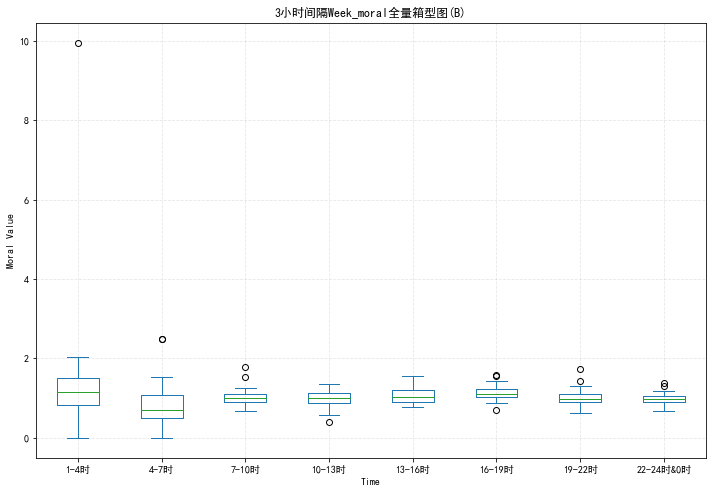

Week三时区，C
index:0;（2时-5时）时间区间;平均值：1.4969180743236574;方差：4.088210585032542;标准差：2.021932388838099
index:1;（5时-8时）时间区间;平均值：0.92204705218904;方差：0.1736916275538099;标准差：0.4167632751980552
index:2;（8时-11时）时间区间;平均值：0.9848358965755082;方差：0.03174673424773483;标准差：0.1781761326545585
index:3;（11时-14时）时间区间;平均值：0.9612099320536774;方差：0.05216015382885383;标准差：0.22838597555203302
index:4;（14时-17时）时间区间;平均值：1.1273634056613315;方差：0.037711284592201307;标准差：0.19419393551859776
index:5;（17时-20时）时间区间;平均值：1.120729885968105;方差：0.05332470786829392;标准差：0.2309214322411281
index:6;（20时-23时）时间区间;平均值：0.9982737476857011;方差：0.04120070815514753;标准差：0.20297957570934946
index:7;（24时 & 0时-1时）时间区间;平均值：1.026797351820108;方差：0.031297829955844465;标准差：0.17691192711585182
(0, 1) (Ttest_indResult(statistic=1.2453277763009827, pvalue=0.2202573097054493), 0.3843164953681685)
(0, 2) (Ttest_indResult(statistic=1.1282576853149202, pvalue=0.26593303239851357), 0.34818788092913583)
(0, 3) (Ttest_indResult(statistic=1.1773989110524452, pvalu

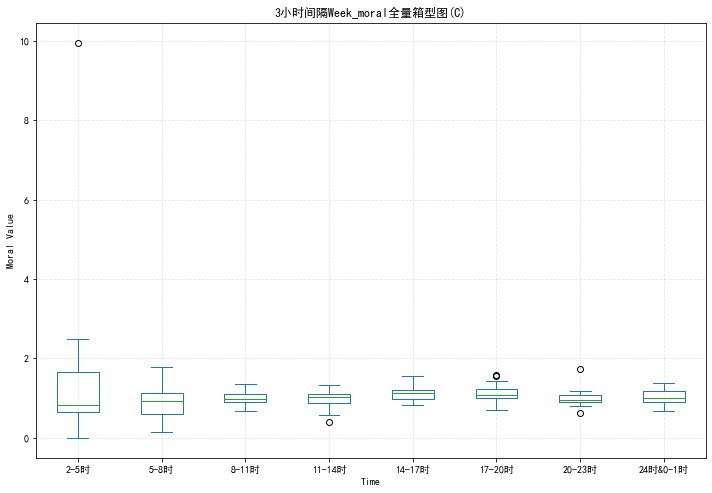

Week四时区，A
index:0;（0时-4时）时间区间;平均值：1.3791653808516016;方差：2.908878155741173;标准差：1.7055433608504866
index:1;（4时-8时）时间区间;平均值：0.9548967716658241;方差：0.35485103409027097;标准差：0.5956937418592468
index:2;（8时-12时）时间区间;平均值：0.9601832744580412;方差：0.04176656571546168;标准差：0.20436870043003572
index:3;（12时-16时）时间区间;平均值：1.0481314241351802;方差：0.0433678127349938;标准差：0.20824940032325134
index:4;（16时-20时）时间区间;平均值：1.1372896416007456;方差：0.047721152042937094;标准差：0.2184517155870768
index:5;（20时-24时）时间区间;平均值：0.9989650169964541;方差：0.03156359926442258;标准差：0.1776614737764566
(0, 1) (Ttest_indResult(statistic=1.2202975085327687, pvalue=0.22765445199595707), 0.32613822763310507)
(0, 2) (Ttest_indResult(statistic=1.2674151601700077, pvalue=0.21044528580833688), 0.3387309497256706)
(0, 3) (Ttest_indResult(statistic=1.0011016057639857, pvalue=0.32124271503010826), 0.26755565843700513)
(0, 4) (Ttest_indResult(statistic=0.7309336506430915, pvalue=0.4679794738592372), 0.19535023522645478)
(0, 5) (Ttest_indResult(statistic=1

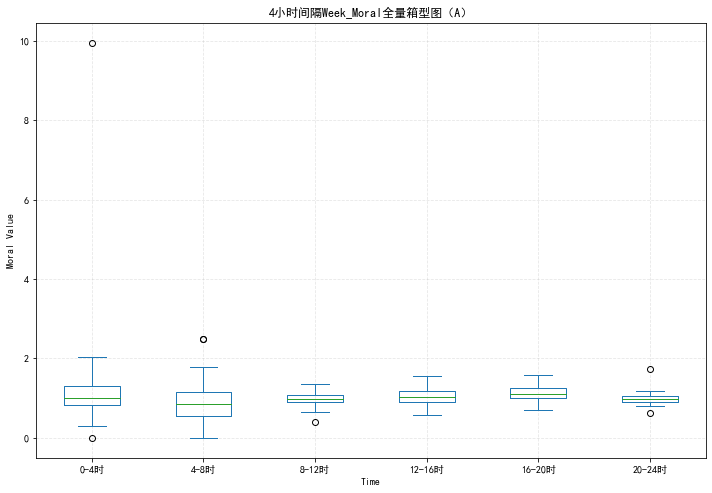

Week四时区，B
index:0;（1时-5时）时间区间;平均值：1.3996543393746443;方差：3.098936440346421;标准差：1.7603796296101648
index:1;（5时-9时）时间区间;平均值：0.9213858490879613;方差：0.13627531877902047;标准差：0.36915487099457384
index:2;（9时-13时）时间区间;平均值：0.9710250850265604;方差：0.046768833407902534;标准差：0.21626103071959712
index:3;（13时-17时）时间区间;平均值：1.1041812807451463;方差：0.03858926723450419;标准差：0.1964415109759243
index:4;（17时-21时）时间区间;平均值：1.1071046942770226;方差：0.059714737805658405;标准差：0.24436599150793958
index:5;（21时-24时 & 0时-1时）时间区间;平均值：0.9752802611965112;方差：0.026736390078391178;标准差：0.1635126603000244
(0, 1) (Ttest_indResult(statistic=1.3816635327326032, pvalue=0.17276491447785725), 0.3692651116632231)
(0, 2) (Ttest_indResult(statistic=1.255754304691357, pvalue=0.21461147005304082), 0.335614455008685)
(0, 3) (Ttest_indResult(statistic=0.866774494647663, pvalue=0.38990080681063377), 0.23165522789754844)
(0, 4) (Ttest_indResult(statistic=0.8553239320183764, pvalue=0.39615103282457864), 0.22859493630864927)
(0, 5) (Ttest_indResult(st

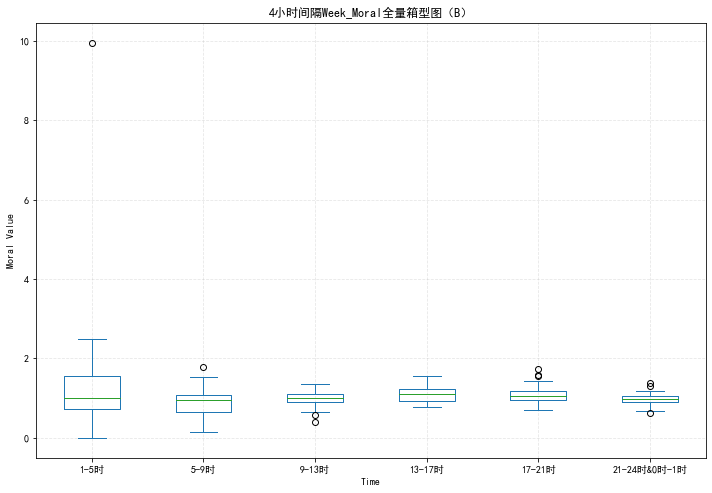

Week四时区，C
index:0;（2时-6时）时间区间;平均值：1.2747542412123332;方差：3.2357719626106314;标准差：1.798825161768267
index:1;（6时-10时）时间区间;平均值：1.020402056034931;方差：0.08772289660417083;标准差：0.2961805135456599
index:2;（10时-14时）时间区间;平均值：0.9786019191091481;方差：0.050552092011397855;标准差：0.22483792387272628
index:3;（14时-18时）时间区间;平均值：1.1213218930883617;方差：0.03874262709439375;标准差：0.19683146876044427
index:4;（18时-22时）时间区间;平均值：1.0667791226866568;方差：0.060757811376113954;标准差：0.246490996541687
index:5;（22时-24时 & 0时-2时）时间区间;平均值：1.0167722775764159;方差：0.027329362553024796;标准差：0.1653159476669592
(0, 1) (Ttest_indResult(statistic=0.7249696896537109, pvalue=0.4716005293711163), 0.19375629960571567)
(0, 2) (Ttest_indResult(statistic=0.8488712628204195, pvalue=0.3997004324748742), 0.22687038792515327)
(0, 3) (Ttest_indResult(statistic=0.4405805783696859, pvalue=0.6612754080480456), 0.11775011253757647)
(0, 4) (Ttest_indResult(statistic=0.595202519958052, pvalue=0.5541943460244162), 0.1590745646733935)
(0, 5) (Ttest_indResult(stat

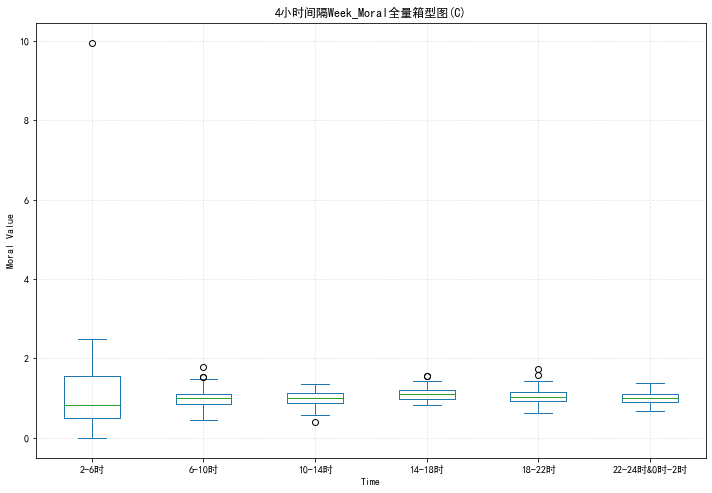

Week四时区，D
index:0;（3时-7时）时间区间;平均值：0.9554661308096906;方差：0.4569504034063672;标准差：0.6759810673431373
index:1;（7时-11时）时间区间;平均值：1.0282382672307837;方差：0.059664349199939494;标准差：0.2442628690569639
index:2;（11时-15时）时间区间;平均值：0.9906005262063097;方差：0.0499028164680335;标准差：0.22338938306919043
index:3;（15时-19时）时间区间;平均值：1.1363852939822605;方差：0.04806810284533241;标准差：0.2192443906815689
index:4;（19时-23时）时间区间;平均值：1.0286969083380408;方差：0.04504250428901174;标准差：0.2122321942802546
index:5;（24时 & 0时-3时）时间区间;平均值：1.3392443831407608;方差：2.799692125321721;标准差：1.6732280553832823
(0, 1) (Ttest_indResult(statistic=-0.5260943105440046, pvalue=0.6009767947925031), -0.14060461879905134)
(0, 2) (Ttest_indResult(statistic=-0.2564326153008969, pvalue=0.7985912566028829), -0.06853449923216866)
(0, 3) (Ttest_indResult(statistic=-1.322856713965078, pvalue=0.19145783678039596), -0.3535483282464955)
(0, 4) (Ttest_indResult(statistic=-0.5370648589498379, pvalue=0.5934289632779381), -0.1435366211904547)
(0, 5) (Ttest_indResult(sta

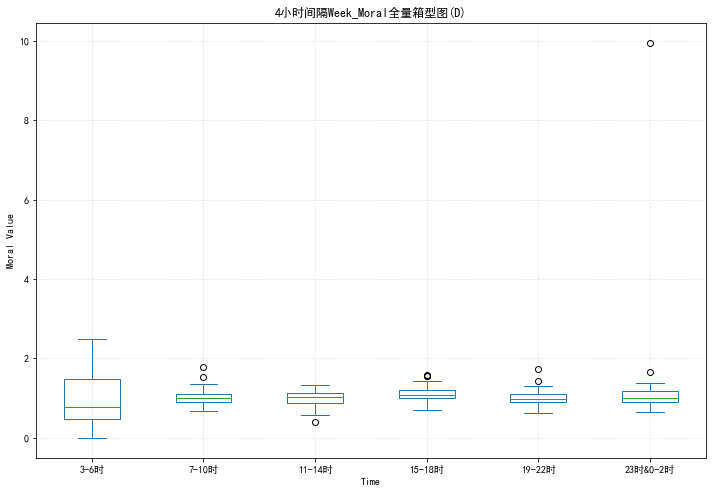

Week六时区，A
index:0;（0时-6时）时间区间;平均值：1.1963950325634907;方差：2.184503589392731;标准差：1.4780066269786245
index:1;（6时-12时）时间区间;平均值：0.9997685854201538;方差：0.0788465578538087;标准差：0.2807962924502542
index:2;（12时-18时）时间区间;平均值：1.0804486600681398;方差：0.04308856115923785;标准差：0.2075778436135173
index:3;（18时-24时）时间区间;平均值：1.0424753950867798;方差：0.04451443602110024;标准差：0.21098444497426874
(0, 1) (Ttest_indResult(statistic=0.8368699765239783, pvalue=0.4050979832874462), 0.18262000067890702)
(0, 2) (Ttest_indResult(statistic=0.49742917615944543, pvalue=0.6202176844623057), 0.10854794536334197)
(0, 3) (Ttest_indResult(statistic=0.6601295439184319, pvalue=0.5110207539293747), 0.14405207635632808)
(1, 2) (Ttest_indResult(statistic=-1.4794279402993487, pvalue=0.1428575995816981), -0.32283764388830355)
(1, 3) (Ttest_indResult(statistic=-0.7785744147785247, pvalue=0.43847141067055373), -0.1698988661846921)
(2, 3) (Ttest_indResult(statistic=0.8215053303104344, pvalue=0.41374062646983956), 0.17926715999796505)


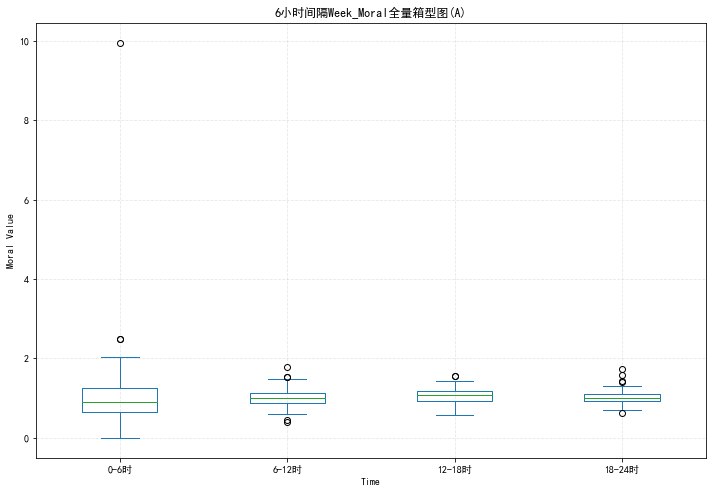

Week六时区，B
index:0;（1时-7时）时间区间;平均值：1.201052189144848;方差：2.1975826924542248;标准差：1.4824245992475384
index:1;（7时-13时）时间区间;平均值：0.993657993181263;方差：0.06110437969246093;标准差：0.2471930008969933
index:2;（13时-19时）时间区间;平均值：1.1098247317649732;方差：0.04487523873095418;标准差：0.2118377651198062
index:3;（19时-24时 & 0时-1时）时间区间;平均值：1.0145527590474799;方差：0.041502583698530104;标准差：0.20372182921456922
(0, 1) (Ttest_indResult(statistic=0.8836097382017065, pvalue=0.37949024639284823), 0.19281945286235394)
(0, 2) (Ttest_indResult(statistic=0.39008149365581296, pvalue=0.6974877148303048), 0.08512276056567615)
(0, 3) (Ttest_indResult(statistic=0.7980573841688805, pvalue=0.42714235807307144), 0.17415039866058796)
(1, 2) (Ttest_indResult(statistic=-2.2848755436264465, pvalue=0.024903393138400443), -0.49860072058197935)
(1, 3) (Ttest_indResult(statistic=-0.4176774414894519, pvalue=0.6772746270225265), -0.09114469008099536)
(2, 3) (Ttest_indResult(statistic=2.0756587785914555, pvalue=0.041059067134922037), 0.452945879514

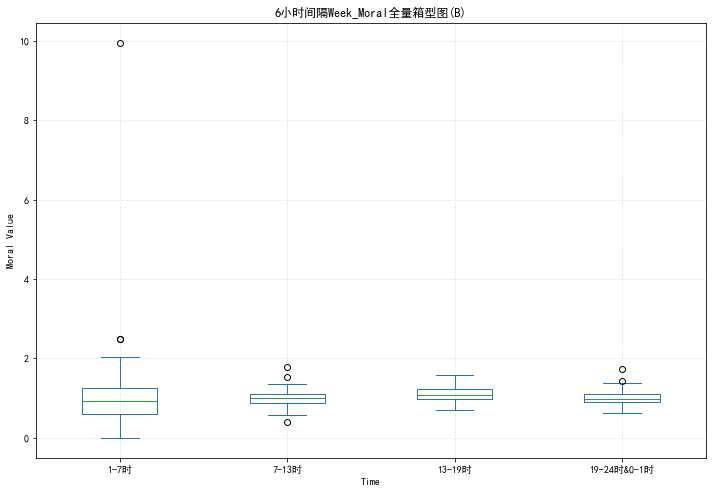

Week六时区，C
index:0;（2时-8时）时间区间;平均值：1.2094825632563484;方差：2.213570279315701;标准差：1.4878072050221094
index:1;（8时-14时）时间区间;平均值：0.9730229143145929;方差：0.04209299058819102;标准差：0.20516576368437064
index:2;（14时-20时）时间区间;平均值：1.124046645814718;方差：0.04552899712612772;标准差：0.21337524956312934
index:3;（20时-24时 & 0时-2时）时间区间;平均值：1.0125355497529047;方差：0.03645266805370008;标准差：0.19092581819570678
(0, 1) (Ttest_indResult(statistic=1.0081190812296683, pvalue=0.31636288526835193), 0.21998961901258532)
(0, 2) (Ttest_indResult(statistic=0.36396930344021877, pvalue=0.7168177318233292), 0.07942461350738828)
(0, 3) (Ttest_indResult(statistic=0.8407131766344687, pvalue=0.40295347918724544), 0.18345865569877298)
(1, 2) (Ttest_indResult(statistic=-3.2668603847489104, pvalue=0.0015890132095151002), -0.7128873808554493)
(1, 3) (Ttest_indResult(statistic=-0.9027486194513505, pvalue=0.36930356107311213), -0.19699589915012844)
(2, 3) (Ttest_indResult(statistic=2.49374272064388, pvalue=0.01465056865013611), 0.5441792752902

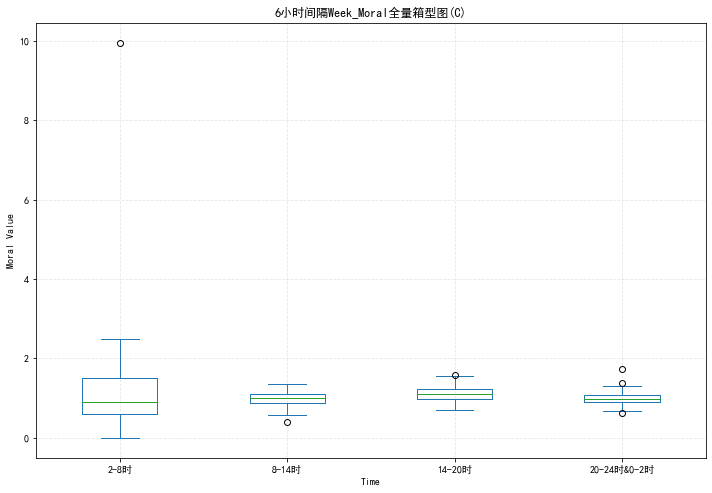

Week六时区，D
index:0;（3时-9时）时间区间;平均值：0.9832853570366832;方差：0.33508208132409606;标准差：0.5788627482608429
index:1;（9时-15时）时间区间;平均值：0.999584592461173;方差：0.04422942310521955;标准差：0.21030792449458377
index:2;（15时-21时）时间区间;平均值：1.12195611423798;方差：0.05305546982443442;标准差：0.23033772991942597
index:3;（21时-24时 & 0时-3时）时间区间;平均值：1.2142616094027285;方差：1.9043724957192987;标准差：1.379990034644924
(0, 1) (Ttest_indResult(statistic=-0.16945763992191193, pvalue=0.8658540397275956), -0.0369786886681301)
(0, 2) (Ttest_indResult(statistic=-1.4252268143691889, pvalue=0.1578869935560317), -0.31100998853940875)
(0, 3) (Ttest_indResult(statistic=-0.9882984856129629, pvalue=0.32591378197442045), -0.21566441045388707)
(1, 2) (Ttest_indResult(statistic=-2.512173248242586, pvalue=0.013959891547703142), -0.548201146138797)
(1, 3) (Ttest_indResult(statistic=-0.9847271619203957, pvalue=0.3276547793875265), -0.21488508373234524)
(2, 3) (Ttest_indResult(statistic=-0.42245124112000787, pvalue=0.6738013633322764), -0.092186418564

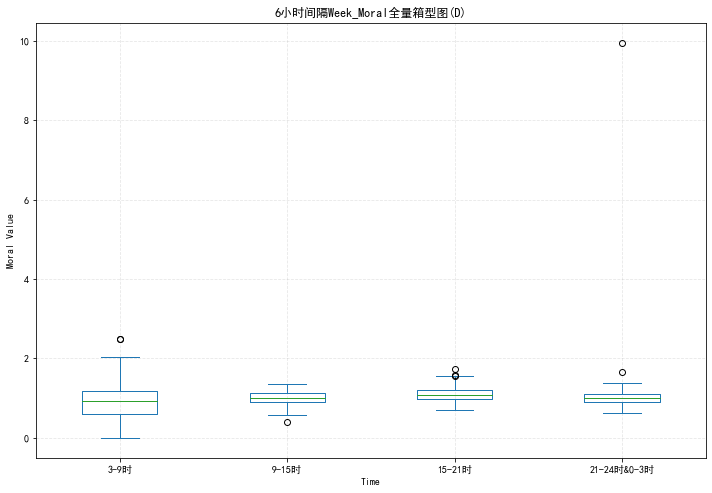

Week六时区，E
index:0;（4时-10时）时间区间;平均值：0.9572194826857104;方差：0.2449074913580749;标准差：0.4948812901677279
index:1;（10时-16时）时间区间;平均值：1.01825483082032;方差：0.05021024337800537;标准差：0.2240764230748192
index:2;（16时-22时）时间区间;平均值：1.092880459102458;方差：0.053955645635339715;标准差：0.2322835457696901
index:3;（22时-24时 & 0时-4时）时间区间;平均值：1.2507329005300765;方差：1.9750697939170518;标准差：1.405371763597466
(0, 1) (Ttest_indResult(statistic=-0.7194087240576853, pvalue=0.473934476092859), -0.15698785398123527)
(0, 2) (Ttest_indResult(statistic=-1.5889516839041953, pvalue=0.11591980660953546), -0.3467376841485009)
(0, 3) (Ttest_indResult(statistic=-1.2613790761141728, pvalue=0.21074895383454753), -0.27525548077746004)
(1, 2) (Ttest_indResult(statistic=-1.4805298452054343, pvalue=0.14256407015827616), -0.32307809925215025)
(1, 3) (Ttest_indResult(statistic=-1.0459992625358832, pvalue=0.29863497813085876), -0.22825575225898434)
(2, 3) (Ttest_indResult(statistic=-0.7095769274671561, pvalue=0.47997939344473817), -0.1548423800

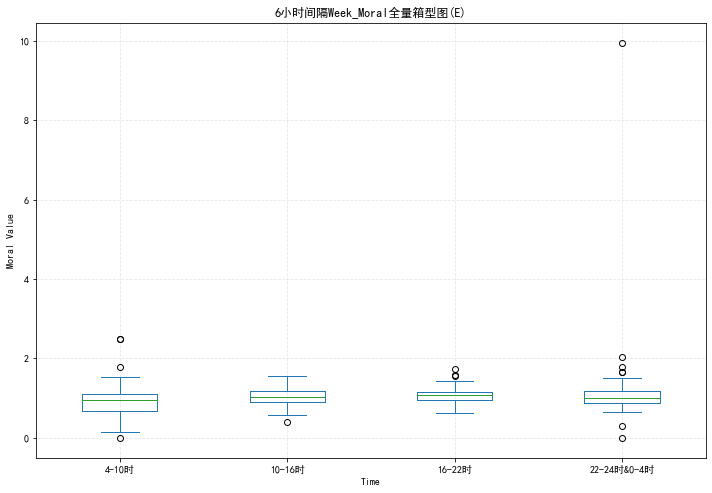

Week六时区，F
index:0;（5时-11时）时间区间;平均值：0.9534414743822742;方差：0.10370479064561941;标准差：0.32203228199300055
index:1;（11时-17时）时间区间;平均值：1.0442866688575043;方差：0.051837463408499915;标准差：0.22767842104270644
index:2;（17时-23时）时间区间;平均值：1.0595018168269033;方差：0.05101158446248052;标准差：0.2258574427874373
index:3;（23时-24时 & 0时-5时）时间区间;平均值：1.2618577130718824;方差：2.115007580926009;标准差：1.4543065635986139
(0, 1) (Ttest_indResult(statistic=-1.474924172020298, pvalue=0.14406224274507703), -0.3218548410763373)
(0, 2) (Ttest_indResult(statistic=-1.7265406684366134, pvalue=0.08801593887738658), -0.3767620620728778)
(0, 3) (Ttest_indResult(statistic=-1.3258019768757838, pvalue=0.18858687052751047), -0.2893137102645416)
(1, 2) (Ttest_indResult(statistic=-0.3037861506548974, pvalue=0.7620603211746932), -0.06629157287882505)
(1, 3) (Ttest_indResult(statistic=-0.9464095127382169, pvalue=0.346720348773499), -0.2065234871690073)
(2, 3) (Ttest_indResult(statistic=-0.8803931285291311, pvalue=0.3812194083042296), -0.1921175310

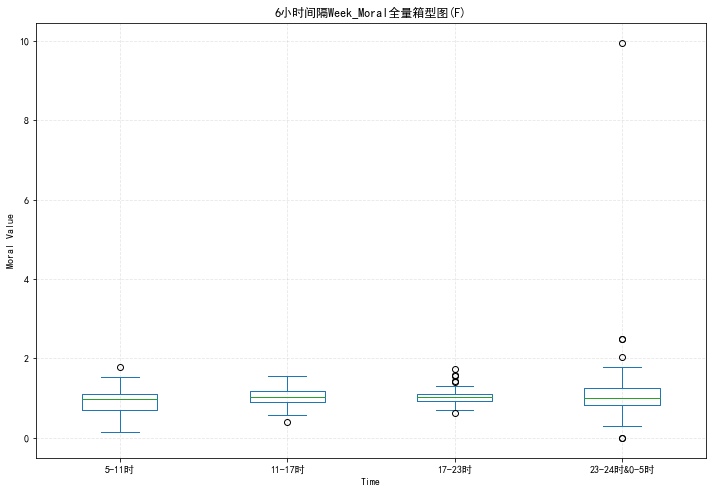

In [6]:
# 五、（一）week全量数据
# （1）平均值，方差，标准差【moral,score_communion,score_agency】
# Moral
week_moral_avg,week_moral_var,week_moral_std = get_mean_score(week_moral)
print_mean_score("week_moral",week_moral_avg,week_moral_var,week_moral_std)
# Score_communion
week_score_communion_avg,week_score_communion_var,week_score_communion_std = get_mean_score(week_score_communion)
print_mean_score("week_score_communion",week_score_communion_avg,week_score_communion_var,week_score_communion_std)
# Score_agency
week_score_agency_avg,week_score_agency_var,week_score_agency_std = get_mean_score(week_score_agency)
print_mean_score("week_score_agency",week_score_agency_avg,week_score_agency_var,week_score_agency_std)
# （2）单样本T检验（005置信【1.711】，001置信【2.492】）
# Moral
week_moral_005,week_moral_001 = get_t_sigle(week_moral)
print_t_sigle("week_moral",week_moral_005,week_moral_001)
# Score_communion
week_score_communion_005,week_score_communion_001 = get_t_sigle(week_score_communion)
print_t_sigle("week_score_communion",week_score_communion_005,week_score_communion_001)
# Score_agency
week_score_agency_005,week_score_agency_001 = get_t_sigle(week_score_agency)
print_t_sigle("week_score_agency",week_score_agency_005,week_score_agency_001)
# （3）相关性检验（pearsonr,spear,kendall）
# Moral与评论条数
week_moral_sentnum_pearson,week_moral_sentnum_spear,week_moral_sentnum_kendall = get_correlation(week_moral,week_sentnum)
print_correlation("week_moral","评论条数",week_moral_sentnum_pearson,week_moral_sentnum_spear,week_moral_sentnum_kendall)
# Moral受评论条数影响率
week_moral_sentnum_rate = [a/b for a,b in zip(week_moral,week_sentnum)]
#print(week_moral_sentnum_rate)
# Moral与切分词总数
week_moral_words_pearson,week_moral_words_spear,week_moral_words_kendall = get_correlation(week_moral,week_all_words)
print_correlation("week_moral","切分词总数",week_moral_words_pearson,week_moral_words_spear,week_moral_words_kendall)
# Moral受切分词总数影响率
week_moral_allwords_rate = [a/b for a,b in zip(week_moral,week_all_words)]
#print(week_moral_allwords_rate)

# （4） 拆分时间区间——Week_moral
#********************************************************************************************
# Moral——三时区（A，B，C）
#********************************************************************************************
print('Week三时区，A')
# A(0时开始)
# 时间区间——0时-3时（moral）
week_moral_time3a_am1 = week_moral[0:21]
#print("3a-am1",week_moral_time3a_am1)
# 时间区间——3时-6时（moral）
week_moral_time3a_am2 = week_moral[21:42]
#print("3a-am2",week_moral_time3a_am2)
# 时间区间——6时-9时（moral）
week_moral_time3a_am3 = week_moral[42:63]
#print("3a-am3",week_moral_time3a_am3)
# 时间区间——9时-12时（moral）
week_moral_time3a_am4 = week_moral[63:84]
#print("3a-am4",week_moral_time3a_am4)
# 时间区间——12时-15时（moral）
week_moral_time3a_pm1 = week_moral[84:105]
#print("3a-pm1",week_moral_time3a_pm1)
# 时间区间——15时-18时（moral）
week_moral_time3a_pm2 = week_moral[105:126]
#print("3a-pm2",week_moral_time3a_pm2)
# 时间区间——18时-21时（moral）
week_moral_time3a_pm3 = week_moral[126:147]
#print("3a-pm3",week_moral_time3a_pm3)
# 时间区间——21时-24时（moral）
week_moral_time3a_pm4 = week_moral[147:168]
#print("3a-pm4",week_moral_time3a_pm4)

# 构建列表嵌套的时间区间数据集
all_moral_time3a = [week_moral_time3a_am1,week_moral_time3a_am2,week_moral_time3a_am3,week_moral_time3a_am4,
                          week_moral_time3a_pm1,week_moral_time3a_pm2,week_moral_time3a_pm3,week_moral_time3a_pm4]

for i,j in enumerate(all_moral_time3a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（3时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（6时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（9时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（12时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（15时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（18时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（21时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
        
# 时间区间的两两交叉T检验
week_moral_time3a_2crosscheck = get_2crosscheck_t_double(all_moral_time3a)
for i,j in week_moral_time3a_2crosscheck.items():
    print(i,j)

name_list_3a = ['0-3时','3-6时','6-9时','9-12时','12-15时','15-18时','18-21时','21-24时']
box_graph3a = get_boxgraph(name_list_3a,'Time','Moral Value','3小时间隔Week_moral全量箱型图(A)',
                           week_moral_time3a_am1,week_moral_time3a_am2,week_moral_time3a_am3,week_moral_time3a_am4,
                          week_moral_time3a_pm1,week_moral_time3a_pm2,week_moral_time3a_pm3,week_moral_time3a_pm4)
#********************************************************************************************
print('Week三时区，B')
# B(1时开始)
# 时间区间——1时-4时（moral）
week_moral_time3b_am1 = week_moral[7:28]
#print("3b-am1",week_moral_time3b_am1)
# 时间区间——4时-7时（moral）
week_moral_time3b_am2 = week_moral[28:49]
#print("3b-am2",week_moral_time3b_am2)
# 时间区间——7时-10时（moral）
week_moral_time3b_am3 = week_moral[49:70]
#print("3b-am3",week_moral_time3b_am3)
# 时间区间——10时-13时（moral）
week_moral_time3b_am4 = week_moral[70:91]
#print("3b-am4",week_moral_time3b_am4)
# 时间区间——13时-16时（moral）
week_moral_time3b_pm1 = week_moral[91:112]
#print("3b-pm1",week_moral_time3b_pm1)
# 时间区间——16时-19时（moral）
week_moral_time3b_pm2 = week_moral[112:133]
#print("3b-pm2",week_moral_time3b_pm2)
# 时间区间——19时-22时（moral）
week_moral_time3b_pm3 = week_moral[133:154]
#print("3b-pm3",week_moral_time3b_pm3)
# 时间区间——22时-24时+0时（moral）
week_moral_time3b_pm4 = week_moral[154:168]+week_moral[0:7]
#print("3b-pm4",week_moral_time3b_pm4)

# 构建列表嵌套的时间区间数据集
all_moral_time3b = [week_moral_time3b_am1,week_moral_time3b_am2,week_moral_time3b_am3,week_moral_time3b_am4,
                          week_moral_time3b_pm1,week_moral_time3b_pm2,week_moral_time3b_pm3,week_moral_time3b_pm4]

for i,j in enumerate(all_moral_time3b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（7时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（10时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（13时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（16时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（19时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（22时-24时 & 0时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
week_moral_time3b_2crosscheck = get_2crosscheck_t_double(all_moral_time3b)
for i,j in week_moral_time3b_2crosscheck.items():
    print(i,j)
    
name_list_3b = ['1-4时','4-7时','7-10时','10-13时','13-16时','16-19时','19-22时','22-24时&0时']
box_graph3b = get_boxgraph(name_list_3b,'Time','Moral Value','3小时间隔Week_moral全量箱型图(B)',
                           week_moral_time3b_am1,week_moral_time3b_am2,week_moral_time3b_am3,week_moral_time3b_am4,
                          week_moral_time3b_pm1,week_moral_time3b_pm2,week_moral_time3b_pm3,week_moral_time3b_pm4)
#********************************************************************************************
print('Week三时区，C')
# 时间区间——2时-5时（moral）
week_moral_time3c_am1 = week_moral[14:35]
#print("3c-am1",week_moral_time3c_am1)
# 时间区间——5时-8时（moral）
week_moral_time3c_am2 = week_moral[35:56]
#print("3c-am2",week_moral_time3c_am2)
# 时间区间——8时-11时（moral）
week_moral_time3c_am3 = week_moral[56:77]
#print("3c-am3",week_moral_time3c_am3)
# 时间区间——11时-14时（moral）
week_moral_time3c_am4 = week_moral[77:98]
#print("3c-am4",week_moral_time3c_am4)
# 时间区间——14时-17时（moral）
week_moral_time3c_pm1 = week_moral[98:119]
#print("3c-pm1",week_moral_time3c_pm1)
# 时间区间——17时-20时（moral）
week_moral_time3c_pm2 = week_moral[119:140]
#print("3c-pm2",week_moral_time3c_pm2)
# 时间区间——20时-23时（moral）
week_moral_time3c_pm3 = week_moral[140:161]
#print("3c-pm3",week_moral_time3c_pm3)
# 时间区间——24时+0-1时（moral）
week_moral_time3c_pm4 = week_moral[161:168]+week_moral[0:14]
#print("3c-pm4",week_moral_time3c_pm4)

# 构建列表嵌套的时间区间数据集
all_moral_time3c = [week_moral_time3c_am1,week_moral_time3c_am2,week_moral_time3c_am3,week_moral_time3c_am4,
                          week_moral_time3c_pm1,week_moral_time3c_pm2,week_moral_time3c_pm3,week_moral_time3c_pm4]

for i,j in enumerate(all_moral_time3c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（11时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（14时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（17时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（20时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))


# 时间区间的两两交叉T检验
week_moral_time3c_2crosscheck = get_2crosscheck_t_double(all_moral_time3c)
for i,j in week_moral_time3c_2crosscheck.items():
    print(i,j)

name_list_3c = ['2-5时','5-8时','8-11时','11-14时','14-17时','17-20时','20-23时','24时&0-1时']
box_graph3c = get_boxgraph(name_list_3c,'Time','Moral Value','3小时间隔Week_moral全量箱型图(C)',
                           week_moral_time3c_am1,week_moral_time3c_am2,week_moral_time3c_am3,week_moral_time3c_am4,
                          week_moral_time3c_pm1,week_moral_time3c_pm2,week_moral_time3c_pm3,week_moral_time3c_pm4)


#********************************************************************************************
# Moral——四时区（A，B，C，D）
#********************************************************************************************
print('Week四时区，A')
# 时间区间——0时-4时（moral）
week_moral_time4a_am1 = week_moral[0:28]
#print("4a-am1",week_moral_time4a_am1)
# 时间区间——4时-8时（moral）
week_moral_time4a_am2 = week_moral[28:56]
#print("4a-am2",week_moral_time4a_am2)
# 时间区间——8时-12时（moral）
week_moral_time4a_am3 = week_moral[56:84]
#print("4a-am3",week_moral_time4a_am3)
# 时间区间——12时-16时（moral）
week_moral_time4a_pm1 = week_moral[84:112]
#print("4a-pm1",week_moral_time4a_pm1)
# 时间区间——16时-20时（moral）
week_moral_time4a_pm2 = week_moral[112:140]
#print("4a-pm2",week_moral_time4a_pm2)
# 时间区间——20时-24时（moral）
week_moral_time4a_pm3 = week_moral[140:168]
#print("4a-pm3",week_moral_time4a_pm3)
# 构建列表嵌套的时间区间数据集
all_moral_time4a = [week_moral_time4a_am1,week_moral_time4a_am2,week_moral_time4a_am3,
                          week_moral_time4a_pm1,week_moral_time4a_pm2,week_moral_time4a_pm3]



for i,j in enumerate(all_moral_time4a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（12时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（16时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（20时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time4a_2crosscheck = get_2crosscheck_t_double(all_moral_time4a)
for i,j in week_moral_time4a_2crosscheck.items():
    print(i,j)

name_list_4a = ['0-4时','4-8时','8-12时','12-16时','16-20时','20-24时']
box_graph4a = get_boxgraph(name_list_4a,'Time','Moral Value','4小时间隔Week_Moral全量箱型图（A）',
                           week_moral_time4a_am1,week_moral_time4a_am2,week_moral_time4a_am3,
                          week_moral_time4a_pm1,week_moral_time4a_pm2,week_moral_time4a_pm3)
#********************************************************************************************
print('Week四时区，B')
# 时间区间——1时-5时（moral）
week_moral_time4b_am1 = week_moral[7:35]
#print("4b-am1",week_moral_time4b_am1)
# 时间区间——5时-9时（moral）
week_moral_time4b_am2 = week_moral[35:63]
#print("4b-am2",week_moral_time4b_am2)
# 时间区间——9时-13时（moral）
week_moral_time4b_am3 = week_moral[63:91]
#print("4b-am3",week_moral_time4b_am3)
# 时间区间——13时-17时（moral）
week_moral_time4b_pm1 = week_moral[91:119]
#print("4b-pm1",week_moral_time4b_pm1)
# 时间区间——17时-21时（moral）
week_moral_time4b_pm2 = week_moral[119:147]
#print("4b-pm2",week_moral_time4b_pm2)
# 时间区间——21时-24时 & 0时（moral）
week_moral_time4b_pm3 = week_moral[147:168] + week_moral[0:7]
#print("4b-pm3",week_moral_time4b_pm3)

# 构建列表嵌套的时间区间数据集
all_moral_time4b = [week_moral_time4b_am1,week_moral_time4b_am2,week_moral_time4b_am3,
                          week_moral_time4b_pm1,week_moral_time4b_pm2,week_moral_time4b_pm3]



for i,j in enumerate(all_moral_time4b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（9时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（13时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（17时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（21时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time4b_2crosscheck = get_2crosscheck_t_double(all_moral_time4b)
for i,j in week_moral_time4b_2crosscheck.items():
    print(i,j)

name_list_4b = ['1-5时','5-9时','9-13时','13-17时','17-21时','21-24时&0时-1时']
box_graph4b = get_boxgraph(name_list_4b,'Time','Moral Value','4小时间隔Week_Moral全量箱型图（B）',
                           week_moral_time4b_am1,week_moral_time4b_am2,week_moral_time4b_am3,
                          week_moral_time4b_pm1,week_moral_time4b_pm2,week_moral_time4b_pm3)
#********************************************************************************************
print('Week四时区，C')
# 时间区间——2时-6时（moral）
week_moral_time4c_am1 = week_moral[14:42]
#print("4c-am1",week_moral_time4c_am1)
# 时间区间——6时-10时（moral）
week_moral_time4c_am2 = week_moral[42:70]
#print("4c-am2",week_moral_time4c_am2)
# 时间区间——10时-14时（moral）
week_moral_time4c_am3 = week_moral[70:98]
#print("4c-am3",week_moral_time4c_am3)
# 时间区间——14时-18时（moral）
week_moral_time4c_pm1 = week_moral[98:126]
#print("4c-pm1",week_moral_time4c_pm1)
# 时间区间——18时-22时（moral）
week_moral_time4c_pm2 = week_moral[126:154]
#print("4c-pm2",week_moral_time4c_pm2)
# 时间区间——22时-24时 & 0时-2时（moral）
week_moral_time4c_pm3 = week_moral[154:168] + week_moral[0:14]
#print("4c-pm3",week_moral_time4c_pm3)

# 构建列表嵌套的时间区间数据集
all_moral_time4c = [week_moral_time4c_am1,week_moral_time4c_am2,week_moral_time4c_am3,
                          week_moral_time4c_pm1,week_moral_time4c_pm2,week_moral_time4c_pm3]



for i,j in enumerate(all_moral_time4c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（10时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（14时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（18时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（22时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time4c_2crosscheck = get_2crosscheck_t_double(all_moral_time4c)
for i,j in week_moral_time4c_2crosscheck.items():
    print(i,j)

name_list_4c = ['2-6时','6-10时','10-14时','14-18时','18-22时','22-24时&0时-2时']
box_graph4c = get_boxgraph(name_list_4c,'Time','Moral Value','4小时间隔Week_Moral全量箱型图(C)',
                           week_moral_time4c_am1,week_moral_time4c_am2,week_moral_time4c_am3,
                          week_moral_time4c_pm1,week_moral_time4c_pm2,week_moral_time4c_pm3)
#********************************************************************************************
print('Week四时区，D')
# 时间区间——3时-7时（moral）
week_moral_time4d_am1 = week_moral[21:49]
#print("4d-am1",week_moral_time4d_am1)
# 时间区间——7时-11时（moral）
week_moral_time4d_am2 = week_moral[49:77]
#print("4d-am2",week_moral_time4d_am2)
# 时间区间——11时-15时（moral）
week_moral_time4d_am3 = week_moral[77:105]
#print("4d-am3",week_moral_time4d_am3)
# 时间区间——15时-19时（moral）
week_moral_time4d_pm1 = week_moral[105:133]
#print("4d-pm1",week_moral_time4d_pm1)
# 时间区间——19时-23时（moral）
week_moral_time4d_pm2 = week_moral[133:161]
#print("4d-pm2",week_moral_time4d_pm2)
# 时间区间——24时 & 0时-3时（moral）
week_moral_time4d_pm3 = week_moral[161:168] + week_moral[0:21]
#print("4d-pm3",week_moral_time4d_pm3)
# 构建列表嵌套的时间区间数据集
all_moral_time4d = [week_moral_time4d_am1,week_moral_time4d_am2,week_moral_time4d_am3,
                          week_moral_time4d_pm1,week_moral_time4d_pm2,week_moral_time4d_pm3]




for i,j in enumerate(all_moral_time4d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（11时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（15时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（19时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time4d_2crosscheck = get_2crosscheck_t_double(all_moral_time4d)
for i,j in week_moral_time4d_2crosscheck.items():
    print(i,j)
    
name_list_4d = ['3-6时','7-10时','11-14时','15-18时','19-22时','23时&0-2时']
box_graph4d = get_boxgraph(name_list_4d,'Time','Moral Value','4小时间隔Week_Moral全量箱型图(D)',
                           week_moral_time4d_am1,week_moral_time4d_am2,week_moral_time4d_am3,
                          week_moral_time4d_pm1,week_moral_time4d_pm2,week_moral_time4d_pm3)

#********************************************************************************************
# Moral——六时区（A，B，C，D，E，F）
#********************************************************************************************
print('Week六时区，A')
# 时间区间——0时-6时（moral）
week_moral_time6a_am1 = week_moral[0:42]
#print("6a-am1",week_moral_time6a_am1)
# 时间区间——6时-12时（moral）
week_moral_time6a_am2 = week_moral[42:84]
#print("6a-am2",week_moral_time6a_am2)
# 时间区间——12时-18时（moral）
week_moral_time6a_pm1 = week_moral[84:126]
#print("6a-pm1",week_moral_time6a_pm1)
# 时间区间——18时-24时（moral）
week_moral_time6a_pm2 = week_moral[126:168]
#print("6a-pm2",week_moral_time6a_pm2)

# 构建列表嵌套的时间区间数据集
all_moral_time6a = [week_moral_time6a_am1,week_moral_time6a_am2,
                    week_moral_time6a_pm1,week_moral_time6a_pm2]



for i,j in enumerate(all_moral_time6a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（12时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（18时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time6a_2crosscheck = get_2crosscheck_t_double(all_moral_time6a)
for i,j in week_moral_time6a_2crosscheck.items():
    print(i,j)

name_list_6a = ['0-6时','6-12时','12-18时','18-24时']
box_graph6a = get_boxgraph(name_list_6a,'Time','Moral Value','6小时间隔Week_Moral全量箱型图(A)',
                           week_moral_time6a_am1,week_moral_time6a_am2,
                          week_moral_time6a_pm1,week_moral_time6a_pm2)
#********************************************************************************************
print('Week六时区，B')
# 时间区间——1时-7时（moral）
week_moral_time6b_am1 = week_moral[7:49]
#print("6b-am1",week_moral_time6b_am1)
# 时间区间——7时-13时（moral）
week_moral_time6b_am2 = week_moral[49:91]
#print("6b-am2",week_moral_time6b_am2)
# 时间区间——13时-19时（moral）
week_moral_time6b_pm1 = week_moral[91:133]
#print("6b-pm1",week_moral_time6b_pm1)
# 时间区间——19时-24时&0时-1时（moral）
week_moral_time6b_pm2 = week_moral[133:168]+week_moral[0:7]
#print("6b-pm2",week_moral_time6b_pm2)
# 构建列表嵌套的时间区间数据集
all_moral_time6b = [week_moral_time6b_am1,week_moral_time6b_am2,
                    week_moral_time6b_pm1,week_moral_time6b_pm2]



for i,j in enumerate(all_moral_time6b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（13时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（19时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time6b_2crosscheck = get_2crosscheck_t_double(all_moral_time6b)
for i,j in week_moral_time6b_2crosscheck.items():
    print(i,j)
    
name_list_6b = ['1-7时','7-13时','13-19时','19-24时&0-1时']
box_graph6b = get_boxgraph(name_list_6b,'Time','Moral Value','6小时间隔Week_Moral全量箱型图(B)',
                           week_moral_time6b_am1,week_moral_time6b_am2,
                          week_moral_time6b_pm1,week_moral_time6b_pm2)
#********************************************************************************************
print('Week六时区，C')
# 时间区间——2时-8时（moral）
week_moral_time6c_am1 = week_moral[14:56]
#print("6c-am1",week_moral_time6c_am1)
# 时间区间——8时-14时（moral）
week_moral_time6c_am2 = week_moral[56:98]
#print("6c-am2",week_moral_time6c_am2)
# 时间区间——14时-20时（moral）
week_moral_time6c_pm1 = week_moral[98:140]
#print("6c-pm1",week_moral_time6c_pm1)
# 时间区间——20时-24时&0时-2时（moral）
week_moral_time6c_pm2 = week_moral[140:168]+week_moral[0:14]
#print("6c-pm2",week_moral_time6c_pm2)
# 构建列表嵌套的时间区间数据集
all_moral_time6c = [week_moral_time6c_am1,week_moral_time6c_am2,
                    week_moral_time6c_pm1,week_moral_time6c_pm2]




for i,j in enumerate(all_moral_time6c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（8时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（14时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（20时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time6c_2crosscheck = get_2crosscheck_t_double(all_moral_time6c)
for i,j in week_moral_time6c_2crosscheck.items():
    print(i,j)

name_list_6c = ['2-8时','8-14时','14-20时','20-24时&0-2时']
box_graph6c = get_boxgraph(name_list_6c,'Time','Moral Value','6小时间隔Week_Moral全量箱型图(C)',
                           week_moral_time6c_am1,week_moral_time6c_am2,
                          week_moral_time6c_pm1,week_moral_time6c_pm2)

#********************************************************************************************
print('Week六时区，D')
# 时间区间——3时-9时（moral）
week_moral_time6d_am1 = week_moral[21:63]
#print("6d-am1",week_moral_time6d_am1)
# 时间区间——9时-15时（moral）
week_moral_time6d_am2 = week_moral[63:105]
#print("6d-am2",week_moral_time6d_am2)
# 时间区间——15时-21时（moral）
week_moral_time6d_pm1 = week_moral[105:147]
#print("6d-pm1",week_moral_time6d_pm1)
# 时间区间——21时-24时&0时-3时（moral）
week_moral_time6d_pm2 = week_moral[147:168]+week_moral[0:21]
#print("6d-pm2",week_moral_time6d_pm2)

# 构建列表嵌套的时间区间数据集
all_moral_time6d = [week_moral_time6d_am1,week_moral_time6d_am2,
                    week_moral_time6d_pm1,week_moral_time6d_pm2]



for i,j in enumerate(all_moral_time6d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（9时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（15时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（21时-24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time6d_2crosscheck = get_2crosscheck_t_double(all_moral_time6d)
for i,j in week_moral_time6d_2crosscheck.items():
    print(i,j)

name_list_6d = ['3-9时','9-15时','15-21时','21-24时&0-3时']
box_graph6d = get_boxgraph(name_list_6d,'Time','Moral Value','6小时间隔Week_Moral全量箱型图(D)',
                           week_moral_time6d_am1,week_moral_time6d_am2,
                          week_moral_time6d_pm1,week_moral_time6d_pm2)
#********************************************************************************************
print('Week六时区，E')
# 时间区间——4时-10时（moral）
week_moral_time6e_am1 = week_moral[28:70]
#print("6e-am1",week_moral_time6e_am1)
# 时间区间——10时-16时（moral）
week_moral_time6e_am2 = week_moral[70:112]
#print("6e-am2",week_moral_time6e_am2)
# 时间区间——16时-22时（moral）
week_moral_time6e_pm1 = week_moral[112:154]
#print("6e-pm1",week_moral_time6e_pm1)
# 时间区间——22时-24时&0时-4时（moral）
week_moral_time6e_pm2 = week_moral[154:168]+week_moral[0:28]
#print("6e-pm2",week_moral_time6e_pm2)
# 构建列表嵌套的时间区间数据集
all_moral_time6e = [week_moral_time6e_am1,week_moral_time6e_am2,
                    week_moral_time6e_pm1,week_moral_time6e_pm2]



for i,j in enumerate(all_moral_time6e):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（4时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（10时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（16时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（22时-24时 & 0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time6e_2crosscheck = get_2crosscheck_t_double(all_moral_time6e)
for i,j in week_moral_time6e_2crosscheck.items():
    print(i,j)

name_list_6e = ['4-10时','10-16时','16-22时','22-24时&0-4时']
box_graph6e = get_boxgraph(name_list_6e,'Time','Moral Value','6小时间隔Week_Moral全量箱型图(E)',
                           week_moral_time6e_am1,week_moral_time6e_am2,
                          week_moral_time6e_pm1,week_moral_time6e_pm2)
#********************************************************************************************
print('Week六时区，F')

# 时间区间——5时-11时（moral）
week_moral_time6f_am1 = week_moral[35:77]
#print("6f-am1",week_moral_time6f_am1)
# 时间区间——11时-17时（moral）
week_moral_time6f_am2 = week_moral[77:119]
#print("6f-am2",week_moral_time6f_am2)
# 时间区间——17时-23时（moral）
week_moral_time6f_pm1 = week_moral[119:161]
#print("6f-pm1",week_moral_time6f_pm1)
# 时间区间——23时-24时&0时-5时（moral）
week_moral_time6f_pm2 = week_moral[161:168]+week_moral[0:35]
#print("6f-pm2",week_moral_time6f_pm2)
# 构建列表嵌套的时间区间数据集
all_moral_time6f = [week_moral_time6f_am1,week_moral_time6f_am2,
                    week_moral_time6f_pm1,week_moral_time6f_pm2]

for i,j in enumerate(all_moral_time6f):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（5时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（11时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（17时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（23时-24时 & 0时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
week_moral_time6f_2crosscheck = get_2crosscheck_t_double(all_moral_time6f)
for i,j in week_moral_time6f_2crosscheck.items():
    print(i,j)
    
name_list_6f = ['5-11时','11-17时','17-23时','23-24时&0-5时']
box_graph6f = get_boxgraph(name_list_6f,'Time','Moral Value','6小时间隔Week_Moral全量箱型图(F)',
                           week_moral_time6f_am1,week_moral_time6f_am2,
                          week_moral_time6f_pm1,week_moral_time6f_pm2)



workdays_moral，
平均值：1.0666028395551272；
方差：0.7799135486889859；
标准差：0.883127141859532
workdays_score_communion，
平均值：0.10353448275862068；
方差：0.004314003666270313；
标准差：0.06568107540433783
workdays_score_agency，
平均值：0.10228531855955678；
方差：0.0038775296511434584；
标准差：0.06226981332189344
workdays_moral,单边T检验：
005置信：Ttest_1sampResult(statistic=-7.959831351101131, pvalue=1.1381503798821573e-12)；
001置信：Ttest_1sampResult(statistic=-17.60703134949685, pvalue=6.24904584294007e-35)
workdays_score_communion,单边T检验：
005置信：Ttest_1sampResult(statistic=-266.97764087815307, pvalue=3.673133907943262e-167)；
001置信：Ttest_1sampResult(statistic=-396.69086662974934, pvalue=1.3277441304840289e-187)
workdays_score_agency,单边T检验：
005置信：Ttest_1sampResult(statistic=-281.8220321892573, pvalue=5.928055879100923e-170)；
001置信：Ttest_1sampResult(statistic=-418.6412019768605, pvalue=2.1963907566391283e-190)
workdays_moral与评论条数相关性检验：
Pearson：(0.07965178995628133, 0.3871574130295909)；
Spearman：SpearmanrResult(correlation=0.055

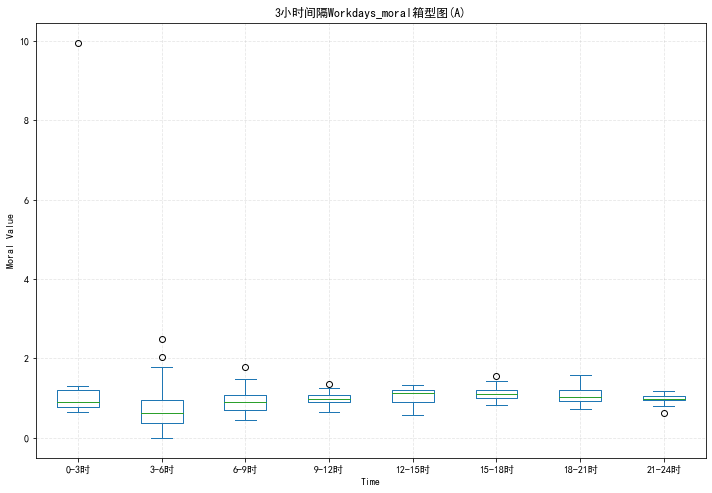

Workdays三时区，B
index:0;（1时-4时）时间区间;平均值：1.575462009207154;方差：5.25788424050594;标准差：2.2930076843538796
index:1;（4时-7时）时间区间;平均值：0.771953595942034;方差：0.33620751525218223;标准差：0.5798340411291685
index:2;（7时-10时）时间区间;平均值：0.9886908674936922;方差：0.07297662529749652;标准差：0.27014186143116825
index:3;（10时-13时）时间区间;平均值：0.9599620146565311;方差：0.04779791111915047;标准差：0.21862733387925323
index:4;（13时-16时）时间区间;平均值：1.0962015458833108;方差：0.02725542519093178;标准差：0.16509217180391014
index:5;（16时-19时）时间区间;平均值：1.205551391815487;方差：0.04265666127989399;标准差：0.20653489119249074
index:6;（19时-22时）时间区间;平均值：0.9656961669748743;方差：0.027628969915536993;标准差：0.16621964359105393
index:7;（22时-24时 & 0时）时间区间;平均值：0.9693051244679342;方差：0.023870883200521716;标准差：0.15450204917903748
(0, 1) (Ttest_indResult(statistic=1.2711290777790396, pvalue=0.21414163620352095), 0.4641507129335459)
(0, 2) (Ttest_indResult(statistic=0.9508983426091127, pvalue=0.34979249050568517), 0.34721898142752455)
(0, 3) (Ttest_indResult(statistic=0.9998191637766

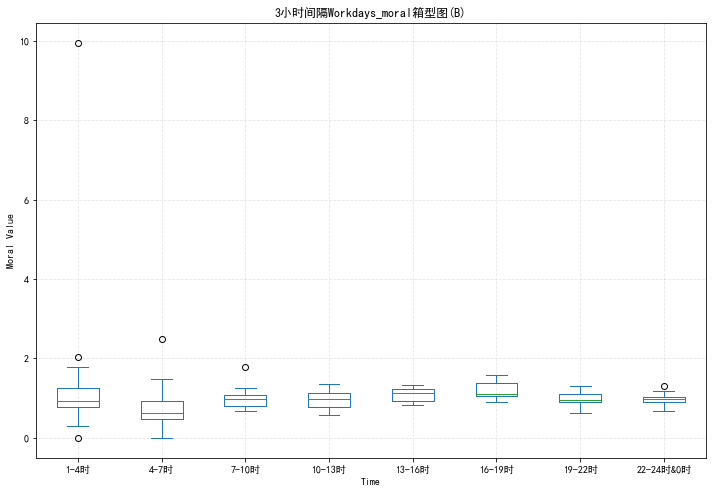

Workdays三时区，C
index:0;（2时-5时）时间区间;平均值：1.5066465420488409;方差：5.559836968666482;标准差：2.357930653913826
index:1;（5时-8时）时间区间;平均值：0.8391317734477978;方差：0.17323188512079224;标准差：0.4162113466987562
index:2;（8时-11时）时间区间;平均值：0.9551578269158907;方差：0.03796230763603709;标准差：0.1948391840365718
index:3;（11时-14时）时间区间;平均值：0.9859922490863477;方差：0.046328973483741764;标准差：0.21524166298312639
index:4;（14时-17时）时间区间;平均值：1.1314356405355923;方差：0.030407759367921883;标准差：0.174378207835503
index:5;（17时-20时）时间区间;平均值：1.1585631360162116;方差：0.04853549804755839;标准差：0.22030773487909677
index:6;（20时-23时）时间区间;平均值：0.9626443899418019;方差：0.01701444607054503;标准差：0.13043943449181705
index:7;（24时 & 0时-1时）时间区间;平均值：0.9932511584485343;方差：0.03284313038518723;标准差：0.18122673750080925
(0, 1) (Ttest_indResult(statistic=1.0431129036789057, pvalue=0.30581894397767456), 0.3808909782464335)
(0, 2) (Ttest_indResult(statistic=0.8721516105396975, pvalue=0.39054329211520544), 0.3184647404380351)
(0, 3) (Ttest_indResult(statistic=0.822773882112057

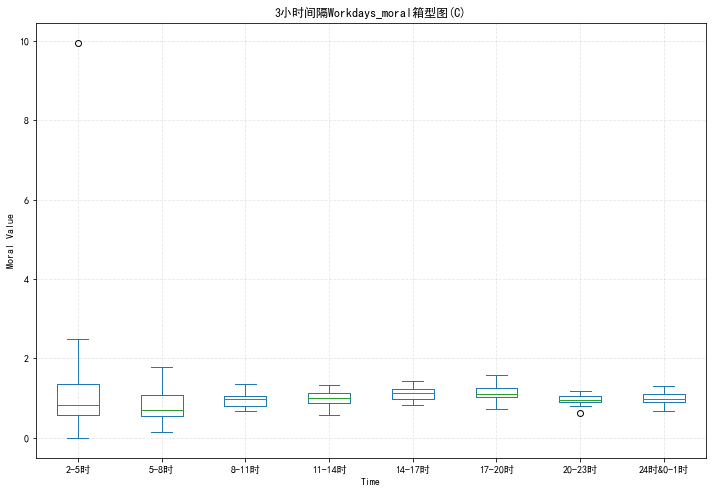

Workdays四时区，A
index:0;（0时-4时）时间区间;平均值：1.4031000807366518;方差：4.044738717248601;标准差：2.0111535787325145
index:1;（4时-8时）时间区间;平均值：0.8557888957672933;方差：0.3077067716404098;标准差：0.5547132336986471
index:2;（8时-12时）时间区间;平均值：0.9556695200771834;方差：0.036685783636387796;标准差：0.19153533260573047
index:3;（12时-16时）时间区间;平均值：1.0511476021371993;方差：0.040650568566321675;标准差：0.2016198615373041
index:4;（16时-20时）时间区间;平均值：1.1665445172011493;方差：0.04623968179354444;标准差：0.21503414099520207
index:5;（20时-24时）时间区间;平均值：0.9673664214112861;方差：0.01340558567973311;标准差：0.11578249297598109
(0, 1) (Ttest_indResult(statistic=1.1435218141284376, pvalue=0.2599749650896344), 0.3616133486733576)
(0, 2) (Ttest_indResult(statistic=0.965376140813976, pvalue=0.34046034445803375), 0.30527874037556)
(0, 3) (Ttest_indResult(statistic=0.7590040717458624, pvalue=0.45253272558056523), 0.24001816200587783)
(0, 4) (Ttest_indResult(statistic=0.5097959417655545, pvalue=0.6131426921996614), 0.1612116317889713)
(0, 5) (Ttest_indResult(statistic=0

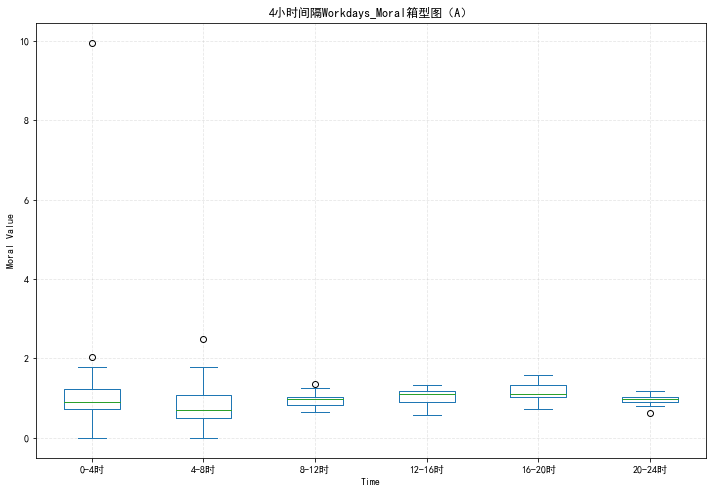

Workdays四时区，B
index:0;（1时-5时）时间区间;平均值：1.4080365725868105;方差：4.204457489489907;标准差：2.0504773808774157
index:1;（5时-9时）时间区间;平均值：0.847993191899139;方差：0.13645008611355267;标准差：0.3693915079066554
index:2;（9时-13时）时间区间;平均值：0.9660216009886089;方差：0.04315716504551936;标准差：0.20774302646664067
index:3;（13时-17时）时间区间;平均值：1.1197733246014736;方差：0.03175540607003076;标准差：0.17820046596468472
index:4;（17时-21时）时间区间;平均值：1.100335531738752;方差：0.046751689968781686;标准差：0.21622139109898836
index:5;（21时-24时 & 0时-1时）时间区间;平均值：0.9574568155159794;方差：0.02654784822874689;标准差：0.16293510434754963
(0, 1) (Ttest_indResult(statistic=1.1716777948847599, pvalue=0.24862063126715006), 0.37051705156794246)
(0, 2) (Ttest_indResult(statistic=0.9348484771887088, pvalue=0.3557693909726598), 0.2956250455056283)
(0, 3) (Ttest_indResult(statistic=0.6104880780435944, pvalue=0.5451727439013414), 0.19305328109963887)
(0, 4) (Ttest_indResult(statistic=0.6505033364116977, pvalue=0.5192811356458594), 0.20570721685997076)
(0, 5) (Ttest_indResult(

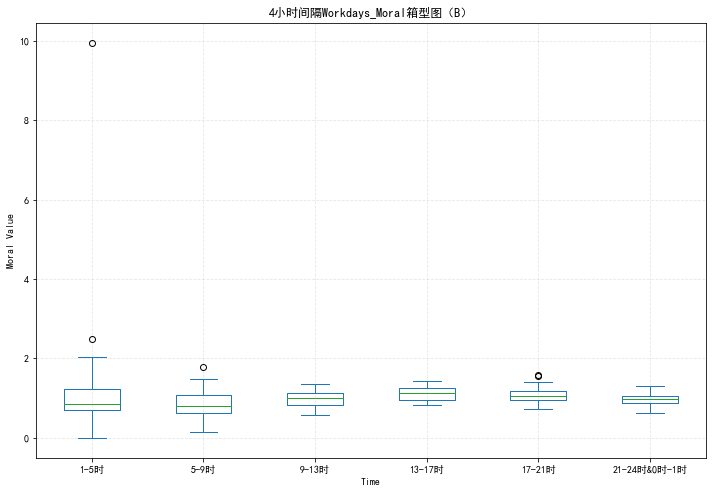

Workdays四时区，C
index:0;（2时-6时）时间区间;平均值：1.2685329964622558;方差：4.363958038455618;标准差：2.0890088650974215
index:1;（6时-10时）时间区间;平均值：0.9554951919697242;方差：0.09116421777029682;标准差：0.30193412819735505
index:2;（10时-14时）时间区间;平均值：0.9911681051921771;方差：0.04731145130416741;标准差：0.2175119566924251
index:3;（14时-18时）时间区间;平均值：1.1416667887249095;方差：0.033115271796682874;标准差：0.181976019839656
index:4;（18时-22时）时间区间;平均值：1.0377234455805653;方差：0.04772139179194172;标准差：0.21845226433237475
index:5;（22时-24时 & 0时-2时）时间区间;平均值：1.0050305094011305;方差：0.02714005654440498;标准差：0.16474239449639239
(0, 1) (Ttest_indResult(statistic=0.6464631532871592, pvalue=0.5218650537228314), 0.20442959877619896)
(0, 2) (Ttest_indResult(statistic=0.5756340729544192, pvalue=0.5682560096526936), 0.18203147693354946)
(0, 3) (Ttest_indResult(statistic=0.2637186873862233, pvalue=0.7934215914704918), 0.08339517136903825)
(0, 4) (Ttest_indResult(statistic=0.47899237797879274, pvalue=0.6346889866858686), 0.15147068962732646)
(0, 5) (Ttest_indResu

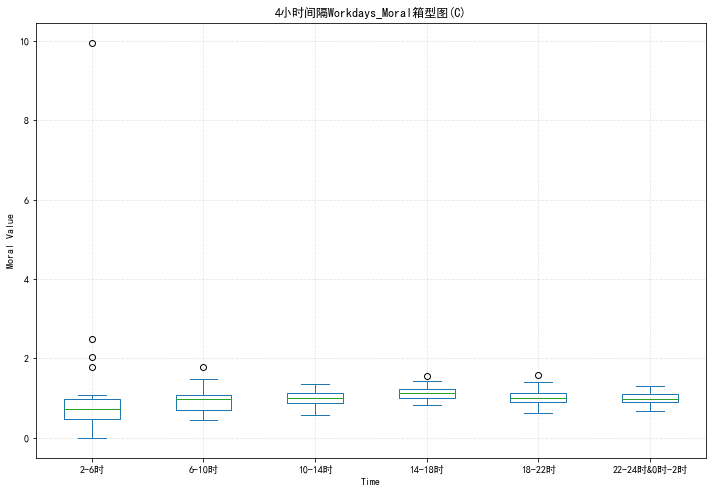

Workdays四时区，D
index:0;（3时-7时）时间区间;平均值：0.8267855805958748;方差：0.4203819994397747;标准差：0.6483687218240672
index:1;（7时-11时）时间区间;平均值：0.9931920689976856;方差：0.06727760415013737;标准差：0.259379267001311
index:2;（11时-15时）时间区间;平均值：1.0297457171900566;方差：0.04573627715807095;标准差：0.21386041512648138
index:3;（15时-19时）时间区间;平均值：1.1648665786990227;方差：0.04181672811181568;标准差：0.2044913888451435
index:4;（19时-23时）时间区间;平均值：0.9843642657958854;方差：0.023858670606347127;标准差：0.1544625216884249
index:5;（24时 & 0时-3时）时间区间;平均值：1.4006628260522374;方差：3.8881350862472255;标准差：1.9718354612510713
(0, 1) (Ttest_indResult(statistic=-1.0386964942362622, pvalue=0.3055102624088515), -0.3284646719418545)
(0, 2) (Ttest_indResult(statistic=-1.2958044914817084, pvalue=0.20285877413884226), -0.40976935953584537)
(0, 3) (Ttest_indResult(statistic=-2.167620200195614, pvalue=0.03651943812679504), -0.6854616934808301)
(0, 4) (Ttest_indResult(statistic=-1.0305406212693413, pvalue=0.3092711728858566), -0.325885558453608)
(0, 5) (Ttest_indResult

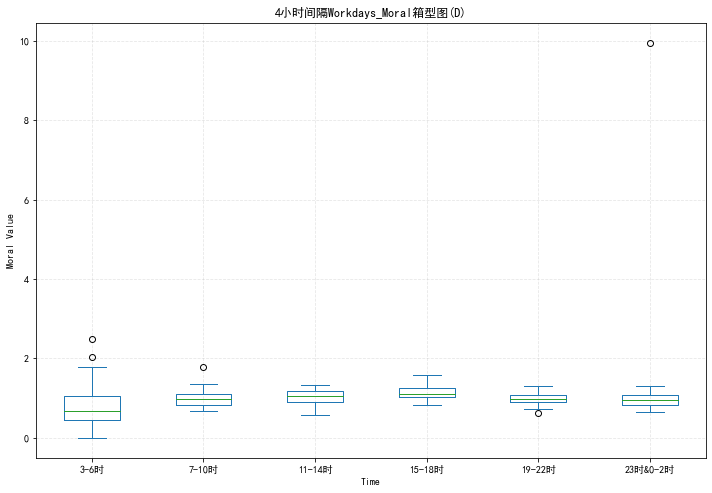

Workdays六时区，A
index:0;（0时-6时）时间区间;平均值：1.178725490895815;方差：2.9414381297067203;标准差：1.7150621358151197
index:1;（6时-12时）时间区间;平均值：0.9643135068249375;方差：0.074934197835193;标准差：0.27374111462327505
index:2;（12时-18时）时间区间;平均值：1.0945732170996032;方差：0.04399424977876011;标准差：0.20974806263410423
index:3;（18时-24时）时间区间;平均值：1.028799143400153;方差：0.034041559438258026;标准差：0.1845035485790396
(0, 1) (Ttest_indResult(statistic=0.664822303276052, pvalue=0.508799032453801), 0.17165638058502705)
(0, 2) (Ttest_indResult(statistic=0.2622776203624398, pvalue=0.7940367283759018), 0.06771979038310938)
(0, 3) (Ttest_indResult(statistic=0.4680566982944916, pvalue=0.6414981890158309), 0.12085171983835967)
(1, 2) (Ttest_indResult(statistic=-2.0340715796032525, pvalue=0.04652644649942797), -0.5251950235198141)
(1, 3) (Ttest_indResult(statistic=-1.0519547101180788, pvalue=0.2971834382759804), -0.27161353821678474)
(2, 3) (Ttest_indResult(statistic=1.2679635537852874, pvalue=0.20987742213346353), 0.32738678182722597)


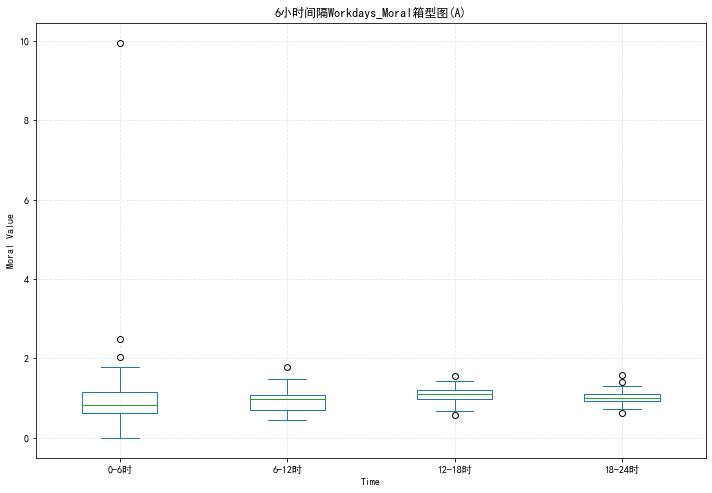

Workdays六时区，B
index:0;（1时-7时）时间区间;平均值：1.1737078025745942;方差：2.9584523204260194;标准差：1.720015209358923
index:1;（7时-13时）时间区间;平均值：0.9743264410751117;方差：0.060593604954658306;标准差：0.2461576831111682
index:2;（13时-19时）时间区间;平均值：1.1508764688493989;方差：0.03794539043676056;标准差：0.19479576596209827
index:3;（19时-24时 & 0时-1时）时间区间;平均值：0.9675006457214045;方差：0.02575318270157603;标准差：0.16047798198374763
(0, 1) (Ttest_indResult(statistic=0.6179433977537185, pvalue=0.5390316012537222), 0.15955229922659853)
(0, 2) (Ttest_indResult(statistic=0.07102815811691693, pvalue=0.9436196951814606), 0.018339391566573764)
(0, 3) (Ttest_indResult(statistic=0.6428185040765306, pvalue=0.5228750710530377), 0.16597502406149117)
(1, 2) (Ttest_indResult(statistic=-3.028745096393424, pvalue=0.0036622913668165687), -0.7820186212159407)
(1, 3) (Ttest_indResult(statistic=0.12509189445823618, pvalue=0.9008833732946699), 0.03229858826548564)
(2, 3) (Ttest_indResult(statistic=3.912697052352652, pvalue=0.00024217967911918583), 1.01025403

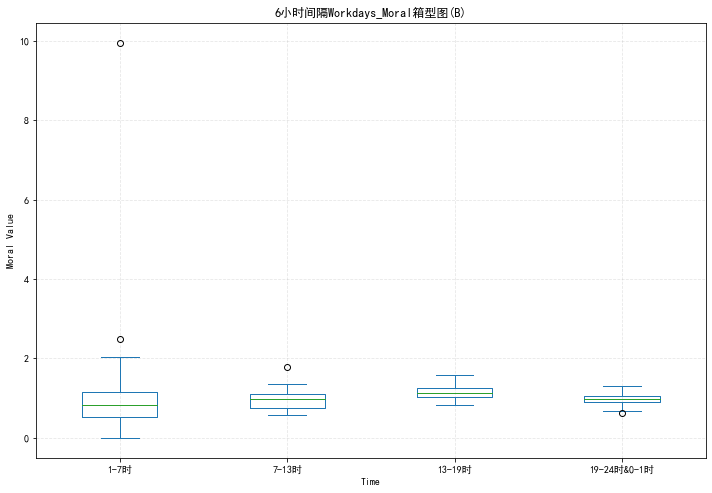

Workdays六时区，C
index:0;（2时-8时）时间区间;平均值：1.1728891577483194;方差：2.9779284184687644;标准差：1.725667528369461
index:1;（8时-14时）时间区间;平均值：0.9705750380011191;方差：0.042383330957535915;标准差：0.2058721228275842
index:2;（14时-20时）时间区间;平均值：1.1449993882759022;方差：0.03965560396050289;标准差：0.1991371486199973
index:3;（20时-24时 & 0时-2时）时间区间;平均值：0.9779477741951683;方差：0.025162981797472308;标准差：0.15862843943464963
(0, 1) (Ttest_indResult(statistic=0.6269014966374382, pvalue=0.5331838037072485), 0.16186527041262022)
(0, 2) (Ttest_indResult(statistic=0.08645980221732157, pvalue=0.9313987034089884), 0.02232382494027157)
(0, 3) (Ttest_indResult(statistic=0.6057853520443061, pvalue=0.5470207274320642), 0.15641310532293295)
(1, 2) (Ttest_indResult(statistic=-3.2794129412201505, pvalue=0.0017619799054526188), -0.8467407804455149)
(1, 3) (Ttest_indResult(statistic=-0.15276605732047063, pvalue=0.8791129881470722), -0.03944402639119669)
(2, 3) (Ttest_indResult(statistic=3.5334577241420426, pvalue=0.0008125726491520131), 0.912334

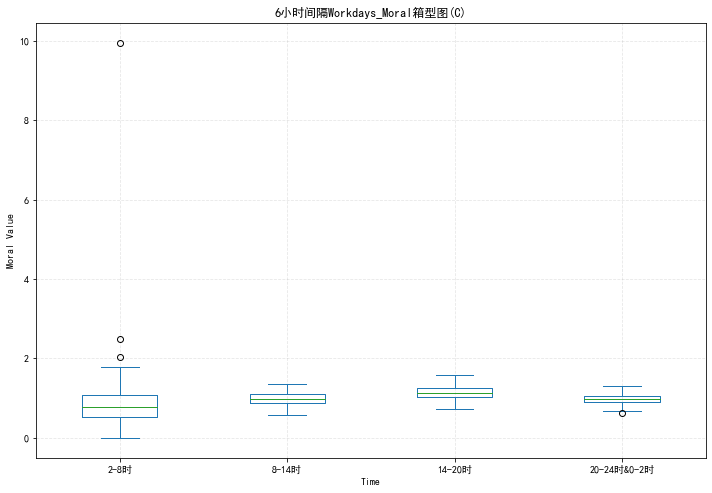

Workdays六时区，D
index:0;（3时-9时）时间区间;平均值：0.8815024274799556;方差：0.317926753812309;标准差：0.5638499390904543
index:1;（9时-15时）时间区间;平均值：1.0183131503757894;方差：0.04391638098664443;标准差：0.2095623558434206
index:2;（15时-21时）时间区间;平均值：1.1057738211767671;方差：0.04271458688973272;标准差：0.20667507563741863
index:3;（21时-24时 & 0时-3时）时间区间;平均值：1.260821959187997;方差：2.6392469842036514;标准差：1.6245759398081863
(0, 1) (Ttest_indResult(statistic=-1.2247824875495867, pvalue=0.2256083282730147), -0.31623747846706945)
(0, 2) (Ttest_indResult(statistic=-2.011106762795559, pvalue=0.04896968866175686), -0.5192655333168207)
(0, 3) (Ttest_indResult(statistic=-1.1878614392199653, pvalue=0.2397297022568086), -0.30670450478006)
(1, 2) (Ttest_indResult(statistic=-1.6002035134690873, pvalue=0.1149869900392498), -0.41317077054722473)
(1, 3) (Ttest_indResult(statistic=-0.7972654783796208, pvalue=0.42854871701796393), -0.20585306135135742)
(2, 3) (Ttest_indResult(statistic=-0.5098463079589178, pvalue=0.6120938233739526), -0.131641750656

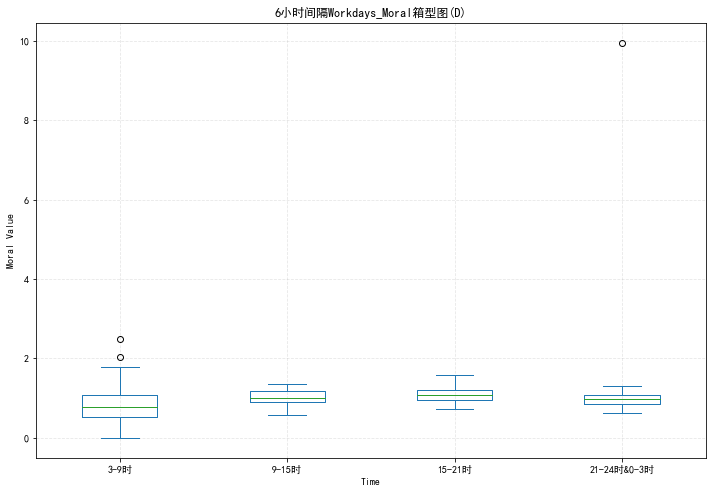

Workdays六时区，E
index:0;（4时-10时）时间区间;平均值：0.8803222317178631;方差：0.21633583149475363;标准差：0.46511915838283163
index:1;（10时-16时）时间区间;平均值：1.028081780269921;方差：0.04216697062226429;标准差：0.20534597785752778
index:2;（16时-22时）时间区间;平均值：1.0856237793951806;方差：0.0495254478185507;标准差：0.22254313698371087
index:3;（22时-24时 & 0时-4时）时间区间;平均值：1.2723835668375443;方差：2.7327341040824207;标准差：1.6530983346680925
(0, 1) (Ttest_indResult(statistic=-1.565027333304104, pvalue=0.12301676171378681), -0.4040883198830799)
(0, 2) (Ttest_indResult(statistic=-2.1441920288815624, pvalue=0.03622042191437631), -0.5536280012619321)
(0, 3) (Ttest_indResult(statistic=-1.2294488855180585, pvalue=0.22386782872656752), -0.31744233724164733)
(1, 2) (Ttest_indResult(statistic=-1.023333593589861, pvalue=0.31039950866202326), -0.2642235977058747)
(1, 3) (Ttest_indResult(statistic=-0.789772285204375, pvalue=0.4328777942117449), -0.20391832719284794)
(2, 3) (Ttest_indResult(statistic=-0.602953122928482, pvalue=0.5488904031896579), -0.1556818

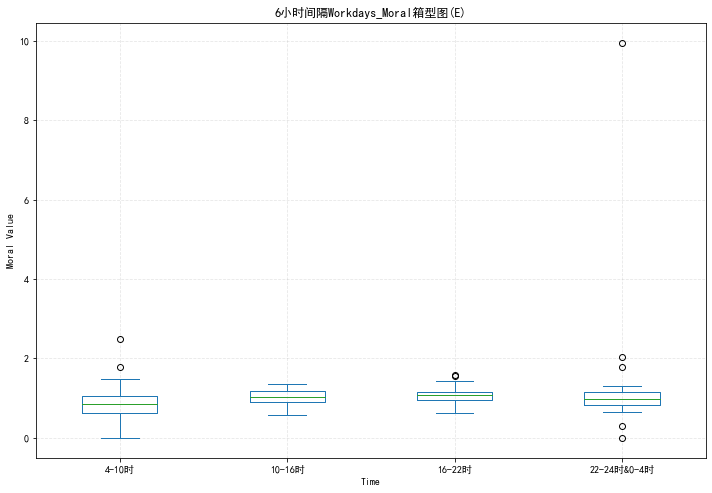

Workdays六时区，F
index:0;（5时-11时）时间区间;平均值：0.8971448001818441;方差：0.10896260764925986;标准差：0.33009484644456333
index:1;（11时-17时）时间区间;平均值：1.0587139448109704;方差：0.0436568114548964;标准差：0.20894212465392517
index:2;（17时-23时）时间区间;平均值：1.0606037629790068;方差：0.042371010824893966;标准差：0.2058421988439056
index:3;（23时-24时 & 0时-5时）时间区间;平均值：1.249948850248688;方差：2.862233754501362;标准差：1.6918137469891188
(0, 1) (Ttest_indResult(statistic=-2.2271656850176096, pvalue=0.029831835494421095), -0.5750517071545224)
(0, 2) (Ttest_indResult(statistic=-2.262768006500591, pvalue=0.027410233994372247), -0.5842441870338497)
(0, 3) (Ttest_indResult(statistic=-1.1022164380794077, pvalue=0.27492037400454156), -0.2845910605731736)
(1, 2) (Ttest_indResult(statistic=-0.03469760943206569, pvalue=0.9724400064392023), -0.008958884232239988)
(1, 3) (Ttest_indResult(statistic=-0.6041246226434214, pvalue=0.5481166537519488), -0.1559843068354541)
(2, 3) (Ttest_indResult(statistic=-0.5982869329543054, pvalue=0.5519777960706447), -0.154

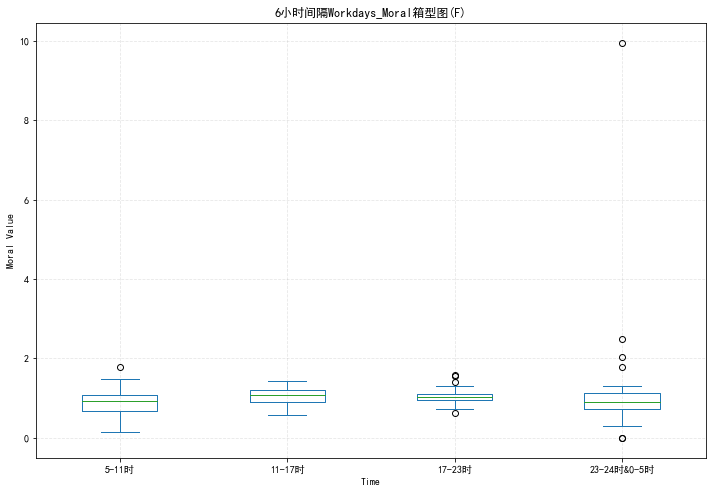

In [7]:
# 五、（二）workdays数据
# （1）平均值，方差，标准差【moral,score_communion,score_agency】
# Moral
workdays_moral_avg,workdays_moral_var,workdays_moral_std = get_mean_score(workdays_moral)
print_mean_score("workdays_moral",workdays_moral_avg,workdays_moral_var,workdays_moral_std)
# Score_communion
workdays_score_communion_avg,workdays_score_communion_var,workdays_score_communion_std = get_mean_score(workdays_score_communion)
print_mean_score("workdays_score_communion",workdays_score_communion_avg,workdays_score_communion_var,workdays_score_communion_std)
# Score_agency
workdays_score_agency_avg,workdays_score_agency_var,workdays_score_agency_std = get_mean_score(workdays_score_agency)
print_mean_score("workdays_score_agency",workdays_score_agency_avg,workdays_score_agency_var,workdays_score_agency_std)
# （2）单样本T检验（005置信【1.711】，001置信【2.492】）
workdays_moral_005,workdays_moral_001 = get_t_sigle(workdays_moral)
print_t_sigle("workdays_moral",workdays_moral_005,workdays_moral_001)
# Score_communion
workdays_score_communion_005,workdays_score_communion_001 = get_t_sigle(workdays_score_communion)
print_t_sigle("workdays_score_communion",workdays_score_communion_005,workdays_score_communion_001)
# Score_agency
workdays_score_agency_005,workdays_score_agency_001 = get_t_sigle(workdays_score_agency)
print_t_sigle("workdays_score_agency",workdays_score_agency_005,workdays_score_agency_001)
# （3）相关性检验（pearsonr,spear,kendall）
# Moral与评论条数
workdays_moral_sentnum_pearson,workdays_moral_sentnum_spear,workdays_moral_sentnum_kendall = get_correlation(workdays_moral,workdays_sentnum)
print_correlation("workdays_moral","评论条数",workdays_moral_sentnum_pearson,workdays_moral_sentnum_spear,workdays_moral_sentnum_kendall)
# Moral受评论条数影响率
workdays_moral_sentnum_rate = [a/b for a,b in zip(workdays_moral,workdays_sentnum)]
#print(workdays_moral_sentnum_rate)
# Moral与切分词总数
workdays_moral_words_pearson,workdays_moral_words_spear,workdays_moral_words_kendall = get_correlation(workdays_moral,workdays_all_words)
print_correlation("workdays_moral","切分词总数",workdays_moral_words_pearson,workdays_moral_words_spear,workdays_moral_words_kendall)
# Moral受切分词总数影响率
workdays_moral_allwords_rate = [a/b for a,b in zip(workdays_moral,workdays_all_words)]
#print(workdays_moral_allwords_rate)
# （4） 拆分时间区间——Workdays_moral
#********************************************************************************************
# Moral——三时区（A，B，C）
#********************************************************************************************
print('Workdays三时区，A')
# A(0时开始)
# 时间区间——0时-3时（moral）
workdays_moral_time3a_am1 = workdays_moral[0:15]
#print("3a-am1",workdays_moral_time3a_am1)
# 时间区间——3时-6时（moral）
workdays_moral_time3a_am2 = workdays_moral[15:30]
#print("3a-am2",workdays_moral_time3a_am2)
# 时间区间——6时-9时（moral）
workdays_moral_time3a_am3 = workdays_moral[30:45]
#print("3a-am3",workdays_moral_time3a_am3)
# 时间区间——9时-12时（moral）
workdays_moral_time3a_am4 = workdays_moral[45:60]
#print("3a-am4",workdays_moral_time3a_am4)
# 时间区间——12时-15时（moral）
workdays_moral_time3a_pm1 = workdays_moral[60:75]
#print("3a-pm1",workdays_moral_time3a_pm1)
# 时间区间——15时-18时（moral）
workdays_moral_time3a_pm2 = workdays_moral[75:90]
#print("3a-pm2",workdays_moral_time3a_pm2)
# 时间区间——18时-21时（moral）
workdays_moral_time3a_pm3 = workdays_moral[90:105]
#print("3a-pm3",workdays_moral_time3a_pm3)
# 时间区间——21时-24时（moral）
workdays_moral_time3a_pm4 = workdays_moral[105:120]
#print("3a-pm4",workdays_moral_time3a_pm4)

# 构建列表嵌套的时间区间数据集
workdays_moral_time3a = [workdays_moral_time3a_am1,workdays_moral_time3a_am2,workdays_moral_time3a_am3,workdays_moral_time3a_am4,
                          workdays_moral_time3a_pm1,workdays_moral_time3a_pm2,workdays_moral_time3a_pm3,workdays_moral_time3a_pm4]



for i,j in enumerate(workdays_moral_time3a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（3时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（6时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（9时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（12时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（15时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（18时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（21时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
        
# 时间区间的两两交叉T检验
workdays_moral_time3a_2crosscheck = get_2crosscheck_t_double(workdays_moral_time3a)
for i,j in workdays_moral_time3a_2crosscheck.items():
    print(i,j)

workdays_name_list_3a = ['0-3时','3-6时','6-9时','9-12时','12-15时','15-18时','18-21时','21-24时']
workdays_box_graph3a = get_boxgraph(workdays_name_list_3a,'Time','Moral Value','3小时间隔Workdays_moral箱型图(A)',
                           workdays_moral_time3a_am1,workdays_moral_time3a_am2,workdays_moral_time3a_am3,workdays_moral_time3a_am4,
                          workdays_moral_time3a_pm1,workdays_moral_time3a_pm2,workdays_moral_time3a_pm3,workdays_moral_time3a_pm4)

#********************************************************************************************
print('Workdays三时区，B')
# B(1时开始)
# 时间区间——1时-4时（moral）
workdays_moral_time3b_am1 = workdays_moral[5:20]
#print("3b-am1",workdays_moral_time3b_am1)
# 时间区间——4时-7时（moral）
workdays_moral_time3b_am2 = workdays_moral[20:35]
#print("3b-am2",workdays_moral_time3b_am2)
# 时间区间——7时-10时（moral）
workdays_moral_time3b_am3 = workdays_moral[35:50]
#print("3b-am3",workdays_moral_time3b_am3)
# 时间区间——10时-13时（moral）
workdays_moral_time3b_am4 = workdays_moral[50:65]
#print("3b-am4",workdays_moral_time3b_am4)
# 时间区间——13时-16时（moral）
workdays_moral_time3b_pm1 = workdays_moral[65:80]
#print("3b-pm1",workdays_moral_time3b_pm1)
# 时间区间——16时-19时（moral）
workdays_moral_time3b_pm2 = workdays_moral[80:95]
#print("3b-pm2",workdays_moral_time3b_pm2)
# 时间区间——19时-22时（moral）
workdays_moral_time3b_pm3 = workdays_moral[95:110]
#print("3b-pm3",workdays_moral_time3b_pm3)
# 时间区间——22时-24时-0时（moral）
workdays_moral_time3b_pm4 = workdays_moral[110:120]+workdays_moral[0:5]
#print("3b-pm4",workdays_moral_time3b_pm4)

# 构建列表嵌套的时间区间数据集
workdays_moral_time3b = [workdays_moral_time3b_am1,workdays_moral_time3b_am2,workdays_moral_time3b_am3,workdays_moral_time3b_am4,
                          workdays_moral_time3b_pm1,workdays_moral_time3b_pm2,workdays_moral_time3b_pm3,workdays_moral_time3b_pm4]



for i,j in enumerate(workdays_moral_time3b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（7时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（10时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（13时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（16时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（19时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（22时-24时 & 0时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
workdays_moral_time3b_2crosscheck = get_2crosscheck_t_double(workdays_moral_time3b)
for i,j in workdays_moral_time3b_2crosscheck.items():
    print(i,j)
    
workdays_name_list_3b = ['1-4时','4-7时','7-10时','10-13时','13-16时','16-19时','19-22时','22-24时&0时']
workdays_box_graph3b = get_boxgraph(workdays_name_list_3b,'Time','Moral Value','3小时间隔Workdays_moral箱型图(B)',
                           workdays_moral_time3b_am1,workdays_moral_time3b_am2,workdays_moral_time3b_am3,workdays_moral_time3b_am4,
                          workdays_moral_time3b_pm1,workdays_moral_time3b_pm2,workdays_moral_time3b_pm3,workdays_moral_time3b_pm4)
#********************************************************************************************
print('Workdays三时区，C')
# 时间区间——2时-5时（moral）
workdays_moral_time3c_am1 = workdays_moral[10:25]
#print("3c-am1",workdays_moral_time3c_am1)
# 时间区间——5时-8时（moral）
workdays_moral_time3c_am2 = workdays_moral[25:40]
#print("3c-am2",workdays_moral_time3c_am2)
# 时间区间——8时-11时（moral）
workdays_moral_time3c_am3 = workdays_moral[40:55]
#print("3c-am3",workdays_moral_time3c_am3)
# 时间区间——11时-14时（moral）
workdays_moral_time3c_am4 = workdays_moral[55:70]
#print("3c-am4",workdays_moral_time3c_am4)
# 时间区间——14时-17时（moral）
workdays_moral_time3c_pm1 = workdays_moral[70:85]
#print("3c-pm1",workdays_moral_time3c_pm1)
# 时间区间——17时-20时（moral）
workdays_moral_time3c_pm2 = workdays_moral[85:100]
#print("3c-pm2",workdays_moral_time3c_pm2)
# 时间区间——20时-23时（moral）
workdays_moral_time3c_pm3 = workdays_moral[100:115]
#print("3c-pm3",workdays_moral_time3c_pm3)
# 时间区间——24时+0-1时（moral）
workdays_moral_time3c_pm4 = workdays_moral[115:120]+workdays_moral[0:10]
#print("3c-pm4",workdays_moral_time3c_pm4)

# 构建列表嵌套的时间区间数据集
workdays_moral_time3c = [workdays_moral_time3c_am1,workdays_moral_time3c_am2,workdays_moral_time3c_am3,workdays_moral_time3c_am4,
                          workdays_moral_time3c_pm1,workdays_moral_time3c_pm2,workdays_moral_time3c_pm3,workdays_moral_time3c_pm4]



for i,j in enumerate(workdays_moral_time3c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（11时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（14时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（17时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（20时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
workdays_moral_time3c_2crosscheck = get_2crosscheck_t_double(workdays_moral_time3c)
for i,j in workdays_moral_time3c_2crosscheck.items():
    print(i,j)

workdays_name_list_3c = ['2-5时','5-8时','8-11时','11-14时','14-17时','17-20时','20-23时','24时&0-1时']
workdays_box_graph3c = get_boxgraph(workdays_name_list_3c,'Time','Moral Value','3小时间隔Workdays_moral箱型图(C)',
                           workdays_moral_time3c_am1,workdays_moral_time3c_am2,workdays_moral_time3c_am3,workdays_moral_time3c_am4,
                          workdays_moral_time3c_pm1,workdays_moral_time3c_pm2,workdays_moral_time3c_pm3,workdays_moral_time3c_pm4)

#********************************************************************************************
# Moral——四时区（A，B，C，D）
#********************************************************************************************
print('Workdays四时区，A')
# 时间区间——0时-4时（moral）
workdays_moral_time4a_am1 = workdays_moral[0:20]
#print("4a-am1",workdays_moral_time4a_am1)
# 时间区间——4时-8时（moral）
workdays_moral_time4a_am2 = workdays_moral[20:40]
#print("4a-am2",workdays_moral_time4a_am2)
# 时间区间——8时-12时（moral）
workdays_moral_time4a_am3 = workdays_moral[40:60]
#print("4a-am3",workdays_moral_time4a_am3)
# 时间区间——12时-16时（moral）
workdays_moral_time4a_pm1 = workdays_moral[60:80]
#print("4a-pm1",workdays_moral_time4a_pm1)
# 时间区间——16时-20时（moral）
workdays_moral_time4a_pm2 = workdays_moral[80:100]
#print("4a-pm2",workdays_moral_time4a_pm2)
# 时间区间——20时-24时（moral）
workdays_moral_time4a_pm3 = workdays_moral[100:120]
#print("4a-pm3",workdays_moral_time4a_pm3)

# 构建列表嵌套的时间区间数据集
workdays_moral_time4a = [workdays_moral_time4a_am1,workdays_moral_time4a_am2,workdays_moral_time4a_am3,
                          workdays_moral_time4a_pm1,workdays_moral_time4a_pm2,workdays_moral_time4a_pm3]



for i,j in enumerate(workdays_moral_time4a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（12时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（16时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（20时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time4a_2crosscheck = get_2crosscheck_t_double(workdays_moral_time4a)
for i,j in workdays_moral_time4a_2crosscheck.items():
    print(i,j)

workdays_name_list_4a = ['0-4时','4-8时','8-12时','12-16时','16-20时','20-24时']
workdays_box_graph4a = get_boxgraph(workdays_name_list_4a,'Time','Moral Value','4小时间隔Workdays_Moral箱型图（A）',
                           workdays_moral_time4a_am1,workdays_moral_time4a_am2,workdays_moral_time4a_am3,
                          workdays_moral_time4a_pm1,workdays_moral_time4a_pm2,workdays_moral_time4a_pm3)
#********************************************************************************************
print('Workdays四时区，B')
# 时间区间——1时-5时（moral）
workdays_moral_time4b_am1 = workdays_moral[5:25]
#print("4b-am1",workdays_moral_time4b_am1)
# 时间区间——5时-9时（moral）
workdays_moral_time4b_am2 = workdays_moral[25:45]
#print("4b-am2",workdays_moral_time4b_am2)
# 时间区间——9时-13时（moral）
workdays_moral_time4b_am3 = workdays_moral[45:65]
#print("4b-am3",workdays_moral_time4b_am3)
# 时间区间——13时-17时（moral）
workdays_moral_time4b_pm1 = workdays_moral[65:85]
#print("4b-pm1",workdays_moral_time4b_pm1)
# 时间区间——17时-21时（moral）
workdays_moral_time4b_pm2 = workdays_moral[85:105]
#print("4b-pm2",workdays_moral_time4b_pm2)
# 时间区间——21时-24时 & 0时（moral）
workdays_moral_time4b_pm3 = workdays_moral[105:120] + workdays_moral[0:5]
#print("4b-pm3",workdays_moral_time4b_pm3)

# 构建列表嵌套的时间区间数据集
workdays_moral_time4b = [workdays_moral_time4b_am1,workdays_moral_time4b_am2,workdays_moral_time4b_am3,
                          workdays_moral_time4b_pm1,workdays_moral_time4b_pm2,workdays_moral_time4b_pm3]




for i,j in enumerate(workdays_moral_time4b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（9时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（13时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（17时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（21时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time4b_2crosscheck = get_2crosscheck_t_double(workdays_moral_time4b)
for i,j in workdays_moral_time4b_2crosscheck.items():
    print(i,j)

workdays_name_list_4b = ['1-5时','5-9时','9-13时','13-17时','17-21时','21-24时&0时-1时']
workdays_box_graph4b = get_boxgraph(workdays_name_list_4b,'Time','Moral Value','4小时间隔Workdays_Moral箱型图（B）',
                           workdays_moral_time4b_am1,workdays_moral_time4b_am2,workdays_moral_time4b_am3,
                          workdays_moral_time4b_pm1,workdays_moral_time4b_pm2,workdays_moral_time4b_pm3)
#********************************************************************************************
print('Workdays四时区，C')
# 时间区间——2时-6时（moral）
workdays_moral_time4c_am1 = workdays_moral[10:30]
#print("4c-am1",workdays_moral_time4c_am1)
# 时间区间——6时-10时（moral）
workdays_moral_time4c_am2 = workdays_moral[30:50]
#print("4c-am2",workdays_moral_time4c_am2)
# 时间区间——10时-14时（moral）
workdays_moral_time4c_am3 = workdays_moral[50:70]
#print("4c-am3",workdays_moral_time4c_am3)
# 时间区间——14时-18时（moral）
workdays_moral_time4c_pm1 = workdays_moral[70:90]
#print("4c-pm1",workdays_moral_time4c_pm1)
# 时间区间——18时-22时（moral）
workdays_moral_time4c_pm2 = workdays_moral[90:110]
#print("4c-pm2",workdays_moral_time4c_pm2)
# 时间区间——22时-24时 & 0时-2时（moral）
workdays_moral_time4c_pm3 = workdays_moral[110:120] + workdays_moral[0:10]
#print("4c-pm3",workdays_moral_time4c_pm3)

# 构建列表嵌套的时间区间数据集
workdays_moral_time4c = [workdays_moral_time4c_am1,workdays_moral_time4c_am2,workdays_moral_time4c_am3,
                          workdays_moral_time4c_pm1,workdays_moral_time4c_pm2,workdays_moral_time4c_pm3]



for i,j in enumerate(workdays_moral_time4c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（10时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（14时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（18时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（22时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time4c_2crosscheck = get_2crosscheck_t_double(workdays_moral_time4c)
for i,j in workdays_moral_time4c_2crosscheck.items():
    print(i,j)

workdays_name_list_4c = ['2-6时','6-10时','10-14时','14-18时','18-22时','22-24时&0时-2时']
workdays_box_graph4c = get_boxgraph(workdays_name_list_4c,'Time','Moral Value','4小时间隔Workdays_Moral箱型图(C)',
                           workdays_moral_time4c_am1,workdays_moral_time4c_am2,workdays_moral_time4c_am3,
                          workdays_moral_time4c_pm1,workdays_moral_time4c_pm2,workdays_moral_time4c_pm3)
#********************************************************************************************
print('Workdays四时区，D')
# 时间区间——3时-7时（moral）
workdays_moral_time4d_am1 = workdays_moral[15:35]
#print("4d-am1",workdays_moral_time4d_am1)
# 时间区间——7时-11时（moral）
workdays_moral_time4d_am2 = workdays_moral[35:55]
#print("4d-am2",workdays_moral_time4d_am2)
# 时间区间——11时-15时（moral）
workdays_moral_time4d_am3 = workdays_moral[55:75]
#print("4d-am3",workdays_moral_time4d_am3)
# 时间区间——15时-19时（moral）
workdays_moral_time4d_pm1 = workdays_moral[75:95]
#print("4d-pm1",workdays_moral_time4d_pm1)
# 时间区间——19时-23时（moral）
workdays_moral_time4d_pm2 = workdays_moral[95:115]
#print("4d-pm2",workdays_moral_time4d_pm2)
# 时间区间——24时 & 0时-3时（moral）
workdays_moral_time4d_pm3 = workdays_moral[115:120] + workdays_moral[0:15]
#print("4d-pm3",workdays_moral_time4d_pm3)
# 构建列表嵌套的时间区间数据集
workdays_moral_time4d = [workdays_moral_time4d_am1,workdays_moral_time4d_am2,workdays_moral_time4d_am3,
                          workdays_moral_time4d_pm1,workdays_moral_time4d_pm2,workdays_moral_time4d_pm3]



for i,j in enumerate(workdays_moral_time4d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（11时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（15时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（19时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time4d_2crosscheck = get_2crosscheck_t_double(workdays_moral_time4d)
for i,j in workdays_moral_time4d_2crosscheck.items():
    print(i,j)
    
workdays_name_list_4d = ['3-6时','7-10时','11-14时','15-18时','19-22时','23时&0-2时']
workdays_box_graph4d = get_boxgraph(workdays_name_list_4d,'Time','Moral Value','4小时间隔Workdays_Moral箱型图(D)',
                           workdays_moral_time4d_am1,workdays_moral_time4d_am2,workdays_moral_time4d_am3,
                          workdays_moral_time4d_pm1,workdays_moral_time4d_pm2,workdays_moral_time4d_pm3)

#********************************************************************************************
# Moral——六时区（A，B，C，D，E，F）
#********************************************************************************************
print('Workdays六时区，A')
# 时间区间——0时-6时（moral）
workdays_moral_time6a_am1 = workdays_moral[0:30]
#print("6a-am1",workdays_moral_time6a_am1)
# 时间区间——6时-12时（moral）
workdays_moral_time6a_am2 = workdays_moral[30:60]
#print("6a-am2",workdays_moral_time6a_am2)
# 时间区间——12时-18时（moral）
workdays_moral_time6a_pm1 = workdays_moral[60:90]
#print("6a-pm1",workdays_moral_time6a_pm1)
# 时间区间——18时-24时（moral）
workdays_moral_time6a_pm2 = workdays_moral[90:120]
#print("6a-pm2",workdays_moral_time6a_pm2)

# 构建列表嵌套的时间区间数据集
workdays_moral_time6a = [workdays_moral_time6a_am1,workdays_moral_time6a_am2,
                    workdays_moral_time6a_pm1,workdays_moral_time6a_pm2]



for i,j in enumerate(workdays_moral_time6a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（12时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（18时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time6a_2crosscheck = get_2crosscheck_t_double(workdays_moral_time6a)
for i,j in workdays_moral_time6a_2crosscheck.items():
    print(i,j)

workdays_name_list_6a = ['0-6时','6-12时','12-18时','18-24时']
workdays_box_graph6a = get_boxgraph(workdays_name_list_6a,'Time','Moral Value','6小时间隔Workdays_Moral箱型图(A)',
                           workdays_moral_time6a_am1,workdays_moral_time6a_am2,
                          workdays_moral_time6a_pm1,workdays_moral_time6a_pm2)
#********************************************************************************************
print('Workdays六时区，B')
# 时间区间——1时-7时（moral）
workdays_moral_time6b_am1 = workdays_moral[5:35]
#print("6b-am1",workdays_moral_time6b_am1)
# 时间区间——7时-13时（moral）
workdays_moral_time6b_am2 = workdays_moral[35:65]
#print("6b-am2",workdays_moral_time6b_am2)
# 时间区间——13时-19时（moral）
workdays_moral_time6b_pm1 = workdays_moral[65:95]
#print("6b-pm1",workdays_moral_time6b_pm1)
# 时间区间——19时-24时&0时-1时（moral）
workdays_moral_time6b_pm2 = workdays_moral[95:120]+workdays_moral[0:5]
#print("6b-pm2",workdays_moral_time6b_pm2)
# 构建列表嵌套的时间区间数据集
workdays_moral_time6b = [workdays_moral_time6b_am1,workdays_moral_time6b_am2,
                    workdays_moral_time6b_pm1,workdays_moral_time6b_pm2]



for i,j in enumerate(workdays_moral_time6b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（13时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（19时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time6b_2crosscheck = get_2crosscheck_t_double(workdays_moral_time6b)
for i,j in workdays_moral_time6b_2crosscheck.items():
    print(i,j)
    
workdays_name_list_6b = ['1-7时','7-13时','13-19时','19-24时&0-1时']
workdays_box_graph6b = get_boxgraph(workdays_name_list_6b,'Time','Moral Value','6小时间隔Workdays_Moral箱型图(B)',
                           workdays_moral_time6b_am1,workdays_moral_time6b_am2,
                          workdays_moral_time6b_pm1,workdays_moral_time6b_pm2)
#********************************************************************************************
print('Workdays六时区，C')
# 时间区间——2时-8时（moral）
workdays_moral_time6c_am1 = workdays_moral[10:40]
#print("6c-am1",workdays_moral_time6c_am1)
# 时间区间——8时-14时（moral）
workdays_moral_time6c_am2 = workdays_moral[40:70]
#print("6c-am2",workdays_moral_time6c_am2)
# 时间区间——14时-20时（moral）
workdays_moral_time6c_pm1 = workdays_moral[70:100]
#print("6c-pm1",workdays_moral_time6c_pm1)
# 时间区间——20时-24时&0时-2时（moral）
workdays_moral_time6c_pm2 = workdays_moral[100:120]+workdays_moral[0:10]
#print("6c-pm2",workdays_moral_time6c_pm2)
# 构建列表嵌套的时间区间数据集
workdays_moral_time6c = [workdays_moral_time6c_am1,workdays_moral_time6c_am2,
                    workdays_moral_time6c_pm1,workdays_moral_time6c_pm2]



for i,j in enumerate(workdays_moral_time6c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（8时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（14时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（20时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time6c_2crosscheck = get_2crosscheck_t_double(workdays_moral_time6c)
for i,j in workdays_moral_time6c_2crosscheck.items():
    print(i,j)

workdays_name_list_6c = ['2-8时','8-14时','14-20时','20-24时&0-2时']
workdays_box_graph6c = get_boxgraph(workdays_name_list_6c,'Time','Moral Value','6小时间隔Workdays_Moral箱型图(C)',
                           workdays_moral_time6c_am1,workdays_moral_time6c_am2,
                          workdays_moral_time6c_pm1,workdays_moral_time6c_pm2)

#********************************************************************************************
print('Workdays六时区，D')
# 时间区间——3时-9时（moral）
workdays_moral_time6d_am1 = workdays_moral[15:45]
#print("6d-am1",workdays_moral_time6d_am1)
# 时间区间——9时-15时（moral）
workdays_moral_time6d_am2 = workdays_moral[45:75]
#print("6d-am2",workdays_moral_time6d_am2)
# 时间区间——15时-21时（moral）
workdays_moral_time6d_pm1 = workdays_moral[75:105]
#print("6d-pm1",workdays_moral_time6d_pm1)
# 时间区间——21时-24时&0时-3时（moral）
workdays_moral_time6d_pm2 = workdays_moral[105:120]+workdays_moral[0:15]
#print("6d-pm2",workdays_moral_time6d_pm2)

# 构建列表嵌套的时间区间数据集
workdays_moral_time6d = [workdays_moral_time6d_am1,workdays_moral_time6d_am2,
                    workdays_moral_time6d_pm1,workdays_moral_time6d_pm2]



for i,j in enumerate(workdays_moral_time6d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（9时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（15时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（21时-24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time6d_2crosscheck = get_2crosscheck_t_double(workdays_moral_time6d)
for i,j in workdays_moral_time6d_2crosscheck.items():
    print(i,j)

workdays_name_list_6d = ['3-9时','9-15时','15-21时','21-24时&0-3时']
workdays_box_graph6d = get_boxgraph(workdays_name_list_6d,'Time','Moral Value','6小时间隔Workdays_Moral箱型图(D)',
                           workdays_moral_time6d_am1,workdays_moral_time6d_am2,
                          workdays_moral_time6d_pm1,workdays_moral_time6d_pm2)

#********************************************************************************************
print('Workdays六时区，E')
# 时间区间——4时-10时（moral）
workdays_moral_time6e_am1 = workdays_moral[20:50]
#print("6e-am1",workdays_moral_time6e_am1)
# 时间区间——10时-16时（moral）
workdays_moral_time6e_am2 = workdays_moral[50:80]
#print("6e-am2",workdays_moral_time6e_am2)
# 时间区间——16时-22时（moral）
workdays_moral_time6e_pm1 = workdays_moral[80:110]
#print("6e-pm1",workdays_moral_time6e_pm1)
# 时间区间——22时-24时&0时-4时（moral）
workdays_moral_time6e_pm2 = workdays_moral[110:120]+workdays_moral[0:20]
#print("6e-pm2",workdays_moral_time6e_pm2)
# 构建列表嵌套的时间区间数据集
workdays_moral_time6e = [workdays_moral_time6e_am1,workdays_moral_time6e_am2,
                    workdays_moral_time6e_pm1,workdays_moral_time6e_pm2]



for i,j in enumerate(workdays_moral_time6e):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（4时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（10时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（16时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（22时-24时 & 0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time6e_2crosscheck = get_2crosscheck_t_double(workdays_moral_time6e)
for i,j in workdays_moral_time6e_2crosscheck.items():
    print(i,j)

workdays_name_list_6e = ['4-10时','10-16时','16-22时','22-24时&0-4时']
workdays_box_graph6e = get_boxgraph(workdays_name_list_6e,'Time','Moral Value','6小时间隔Workdays_Moral箱型图(E)',
                           workdays_moral_time6e_am1,workdays_moral_time6e_am2,
                          workdays_moral_time6e_pm1,workdays_moral_time6e_pm2)

#********************************************************************************************
print('Workdays六时区，F')

# 时间区间——5时-11时（moral）
workdays_moral_time6f_am1 = workdays_moral[25:55]
#print("6f-am1",workdays_moral_time6f_am1)
# 时间区间——11时-17时（moral）
workdays_moral_time6f_am2 = workdays_moral[55:85]
#print("6f-am2",workdays_moral_time6f_am2)
# 时间区间——17时-23时（moral）
workdays_moral_time6f_pm1 = workdays_moral[85:115]
#print("6f-pm1",workdays_moral_time6f_pm1)
# 时间区间——23时-24时&0时-5时（moral）
workdays_moral_time6f_pm2 = workdays_moral[115:120]+workdays_moral[0:25]
#print("6f-pm2",workdays_moral_time6f_pm2)
# 构建列表嵌套的时间区间数据集
workdays_moral_time6f = [workdays_moral_time6f_am1,workdays_moral_time6f_am2,
                    workdays_moral_time6f_pm1,workdays_moral_time6f_pm2]



for i,j in enumerate(workdays_moral_time6f):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（5时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（11时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（17时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（23时-24时 & 0时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
workdays_moral_time6f_2crosscheck = get_2crosscheck_t_double(workdays_moral_time6f)
for i,j in workdays_moral_time6f_2crosscheck.items():
    print(i,j)
    
workdays_name_list_6f = ['5-11时','11-17时','17-23时','23-24时&0-5时']
workdays_box_graph6f = get_boxgraph(workdays_name_list_6f,'Time','Moral Value','6小时间隔Workdays_Moral箱型图(F)',
                           workdays_moral_time6f_am1,workdays_moral_time6f_am2,
                          workdays_moral_time6f_pm1,workdays_moral_time6f_pm2)



weekend_moral，
平均值：1.112694615108426；
方差：0.1245015151896045；
标准差：0.3528477223812058
weekend_score_communion，
平均值：0.12212643678160921；
方差：0.006480297925749768；
标准差：0.08050029767491403
weekend_score_agency，
平均值：0.11657433056325023；
方差：0.006124886924508628；
标准差：0.07826165679634331
weekend_moral,单边T检验：
005置信：Ttest_1sampResult(statistic=-11.624774099987544, pvalue=1.9970797711988265e-15)；
001置信：Ttest_1sampResult(statistic=-26.79921310948363, pvalue=4.0029942646102276e-30)
weekend_score_communion,单边T检验：
005置信：Ttest_1sampResult(statistic=-135.3133922202654, pvalue=1.4428913907129876e-62)；
001置信：Ttest_1sampResult(statistic=-201.82577040469718, pvalue=1.0290839361596166e-70)
weekend_score_agency,单边T检验：
005置信：Ttest_1sampResult(statistic=-139.67033312515179, pvalue=3.265326904558437e-63)；
001置信：Ttest_1sampResult(statistic=-208.0852691499075, pvalue=2.45296801468503e-71)
weekend_moral与评论条数相关性检验：
Pearson：(-0.12133830419757669, 0.41133941414268804)；
Spearman：SpearmanrResult(correlation=-0.1474404214

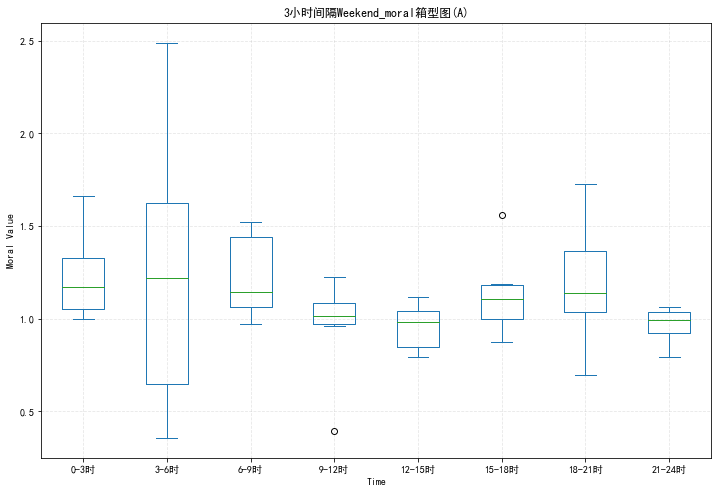

Weekend三时区，B
index:0;（1时-4时）时间区间;平均值：1.3640449756182516;方差：0.06567360619673697;标准差：0.2562686211707102
index:1;（4时-7时）时间区间;平均值：1.1747813355227148;方差：0.49414825527582623;标准差：0.7029567947433372
index:2;（7时-10时）时间区间;平均值：1.1241438846879415;方差：0.0337621749311967;标准差：0.1837448636865714
index:3;（10时-13时）时间区间;平均值：0.9598298622053413;方差：0.0709610032809572;标准差：0.26638506579941224
index:4;（13时-16时）时间区间;平均值：1.027545052187294;方差：0.06569321740562531;标准差：0.25630688130759444
index:5;（16时-19时）时间区间;平均值：0.9868457259205261;方差：0.028386494389113018;标准差：0.16848292017030397
index:6;（19时-22时）时间区间;平均值：1.2351985908207763;方差：0.06991467370688542;标准差：0.2644138304001616
index:7;（22时-24时 & 0时）时间区间;平均值：1.029167493904563;方差：0.03186981827882327;标准差：0.17852119840182362
(0, 1) (Ttest_indResult(statistic=0.5656232641845601, pvalue=0.5841172546815443), 0.32656274383687056)
(0, 2) (Ttest_indResult(statistic=1.701162811501571, pvalue=0.11974554979048259), 0.9821668071558125)
(0, 3) (Ttest_indResult(statistic=2.4452157798861425,

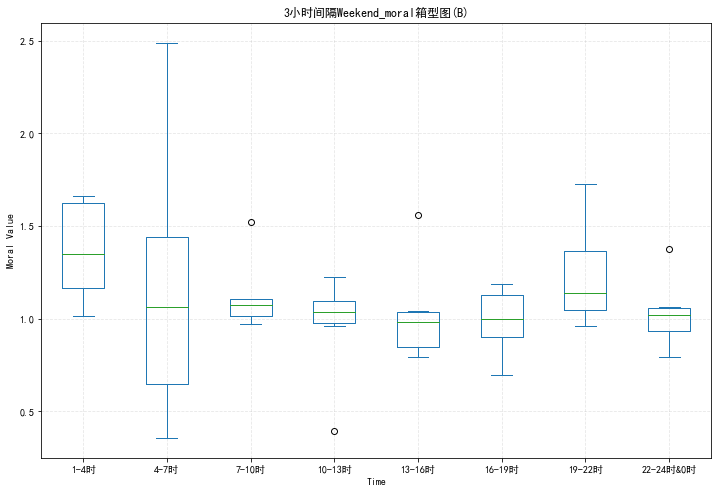

Weekend三时区，C
index:0;（2时-5时）时间区间;平均值：1.472596905010698;方差：0.40831649896023886;标准差：0.638996478049949
index:1;（5时-8时）时间区间;平均值：1.1293352490421456;方差：0.11468522845989737;标准差：0.3386520758239899
index:2;（8时-11时）时间区间;平均值：1.0590310707245527;方差：0.008500907363169318;标准差：0.09220036530930513
index:3;（11时-14时）时间区间;平均值：0.8992541394720023;方差：0.06136417636344102;标准差：0.24771793710476644
index:4;（14时-17时）时间区间;平均值：1.117182818475679;方差：0.055824995555277306;标准差：0.23627313760831406
index:5;（17时-20时）时间区间;平均值：1.0261467608478385;方差：0.05277337783961037;标准差：0.22972456951665046
index:6;（20时-23时）时间区间;平均值：1.0873471420454497;方差：0.09055866595077959;标准差：0.3009296694425121
index:7;（24时 & 0时-1时）时间区间;平均值：1.1106628352490422;方差：0.017587791847411226;标准差：0.1326189724263132
(0, 1) (Ttest_indResult(statistic=1.0613502677481763, pvalue=0.31349090452021733), 0.6127708627888909)
(0, 2) (Ttest_indResult(statistic=1.4323749990872494, pvalue=0.18254554144403035), 0.8269820913035134)
(0, 3) (Ttest_indResult(statistic=1.87067349626342

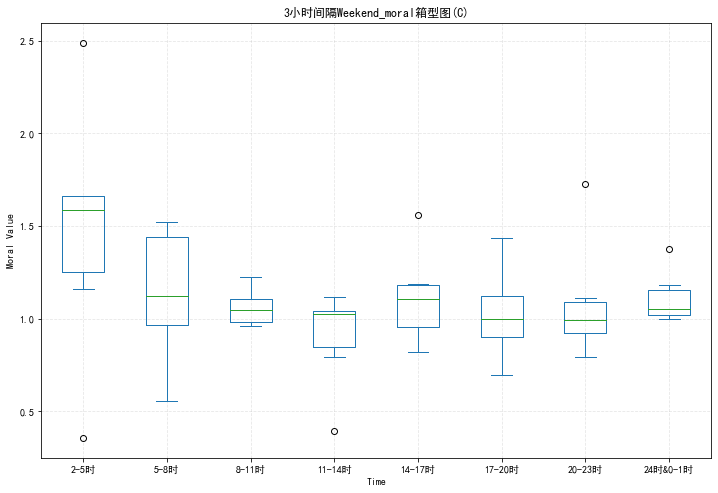

Weekend四时区，A
index:0;（0时-4时）时间区间;平均值：1.319328631138976;方差：0.06421414070996218;标准差：0.25340509211529705
index:1;（4时-8时）时间区间;平均值：1.202666461412151;方差：0.3867659433951364;标准差：0.6219050919514459
index:2;（8时-12时）时间区间;平均值：0.9714676604101857;方差：0.05429024860030266;标准差：0.23300267938438532
index:3;（12时-16时）时间区间;平均值：1.0405909791301318;方差：0.05008132152145029;标准差：0.22378856432233146
index:4;（16时-20时）时间区间;平均值：1.0641524525997368;方差：0.04393615988546175;标准差：0.20960954149432642
index:5;（20时-24时）时间区间;平均值：1.0779615059593746;方差：0.06822200985028995;标准差：0.2611934337809623
(0, 1) (Ttest_indResult(statistic=0.45962155499180674, pvalue=0.6528441019944069), 0.22981077749590337)
(0, 2) (Ttest_indResult(statistic=2.6735450486892236, pvalue=0.01817351141467954), 1.3367725243446118)
(0, 3) (Ttest_indResult(statistic=2.181374154579216, pvalue=0.04670079222289357), 1.090687077289608)
(0, 4) (Ttest_indResult(statistic=2.0529354011513843, pvalue=0.05925894131005653), 1.0264677005756921)
(0, 5) (Ttest_indResult(statistic=

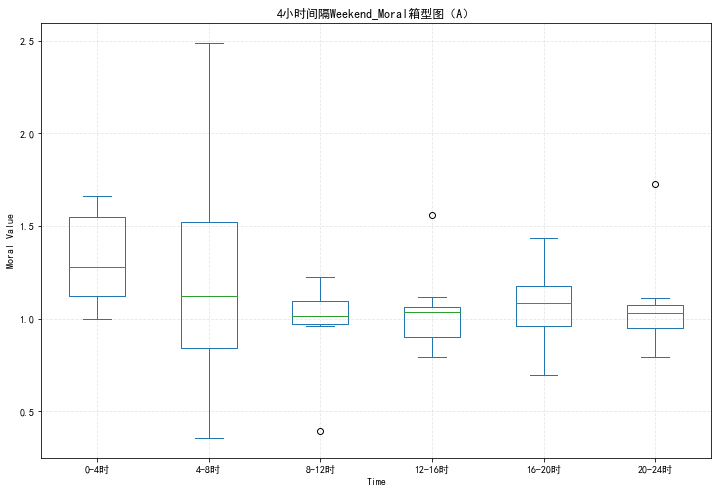

Weekend四时区，B
index:0;（1时-5时）时间区间;平均值：1.3786987563442303;方差：0.3345190264434968;标准差：0.5783761980264202
index:1;（5时-9时）时间区间;平均值：1.1048674920600174;方差：0.08870668181187485;标准差：0.29783666968973926
index:2;（9时-13时）时间区间;平均值：0.9835337951214388;方差：0.05557894935432766;标准差：0.23575188091365817
index:3;（13时-17时）时间区间;平均值：1.0652011711043285;方差：0.05354669161903354;标准差：0.231401580848173
index:4;（17时-21时）时间区间;平均值：1.1240276006226997;方差：0.09172141873499182;标准差：0.3028554419768478
index:5;（21时-24时 & 0时-1时）时间区间;平均值：1.0198388753978411;方差：0.024428086563141722;标准差：0.15629487055927882
(0, 1) (Ttest_indResult(statistic=1.1136431020003572, pvalue=0.28418751141225773), 0.5568215510001786)
(0, 2) (Ttest_indResult(statistic=1.6739427506059652, pvalue=0.11632755967691821), 0.8369713753029826)
(0, 3) (Ttest_indResult(statistic=1.3314675322460239, pvalue=0.20430974453675352), 0.6657337661230119)
(0, 4) (Ttest_indResult(statistic=1.0320516934807051, pvalue=0.3195481998323133), 0.5160258467403525)
(0, 5) (Ttest_indResult(s

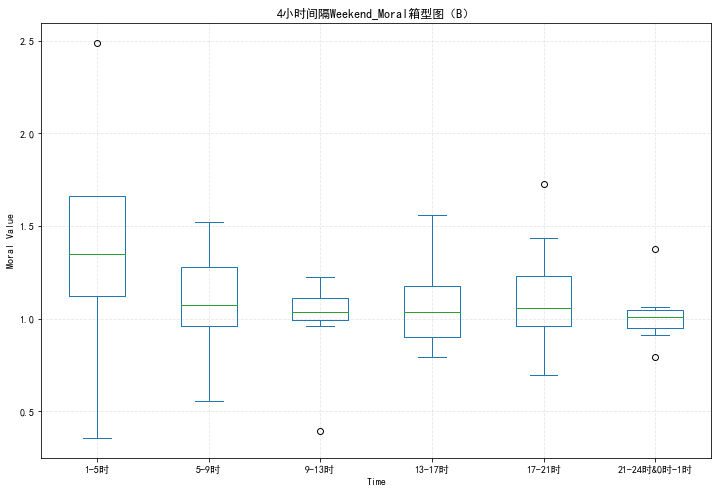

Weekend四时区，C
index:0;（2时-6时）时间区间;平均值：1.2903073530875255;方差：0.4149681139935656;标准差：0.6441801875202043
index:1;（6时-10时）时间区间;平均值：1.1826692161979486;方差：0.04225670991453736;标准差：0.2055643692728323
index:2;（10时-14时）时间区间;平均值：0.9471864539015751;方差：0.05727198974358238;标准差：0.23931566965742626
index:3;（14时-18时）时间区间;平均值：1.0704596539969922;方差：0.049189261027128256;标准差：0.22178652129272478
index:4;（18时-22时）时间区间;平均值：1.1394183154518858;方差：0.08596182708072678;标准差：0.2931924744612774
index:5;（22时-24时 & 0时-2时）时间区间;平均值：1.046126698014629;方差：0.026596272775605615;标准差：0.16308363736318127
(0, 1) (Ttest_indResult(statistic=0.4211630782871842, pvalue=0.6800303024221686), 0.2105815391435921)
(0, 2) (Ttest_indResult(statistic=1.321036321416437, pvalue=0.20767512874732413), 0.6605181607082184)
(0, 3) (Ttest_indResult(statistic=0.853764941078869, pvalue=0.4076065851337335), 0.4268824705394345)
(0, 4) (Ttest_indResult(statistic=0.5640507919195225, pvalue=0.5816435795453238), 0.2820253959597612)
(0, 5) (Ttest_indResult(st

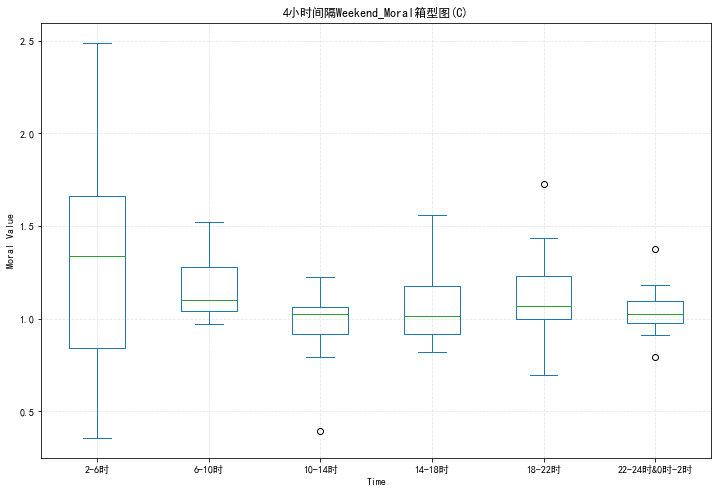

Weekend四时区，D
index:0;（3时-7时）时间区间;平均值：1.2771675063442305;方差：0.4034829282937071;标准差：0.6352030606772192
index:1;（7时-11时）时间区间;平均值：1.1158537628135297;方差：0.029884146731750633;标准差：0.17287031767122613
index:2;（11时-15时）时间区间;平均值：0.8927375487469423;方差：0.04691113744284216;标准差：0.21658979071701914
index:3;（15时-19时）时间区间;平均值：1.0651820821903553;方差：0.05659868336184812;标准差：0.23790477792984344
index:4;（19时-23时）时间区间;平均值：1.1395285146934295;方差：0.08080498554143115;标准差：0.28426217747254234
index:5;（24时 & 0时-3时）时间区间;平均值：1.1856982758620689;方差：0.04557775312334854;标准差：0.21348946841319488
(0, 1) (Ttest_indResult(statistic=0.6483244994090561, pvalue=0.527266343631012), 0.32416224970452806)
(0, 2) (Ttest_indResult(statistic=1.5155487610526548, pvalue=0.15188284263795052), 0.7577743805263274)
(0, 3) (Ttest_indResult(statistic=0.8268706607963853, pvalue=0.4221802979064776), 0.41343533039819264)
(0, 4) (Ttest_indResult(statistic=0.5232854833244416, pvalue=0.6089591122601465), 0.26164274166222085)
(0, 5) (Ttest_indResult(

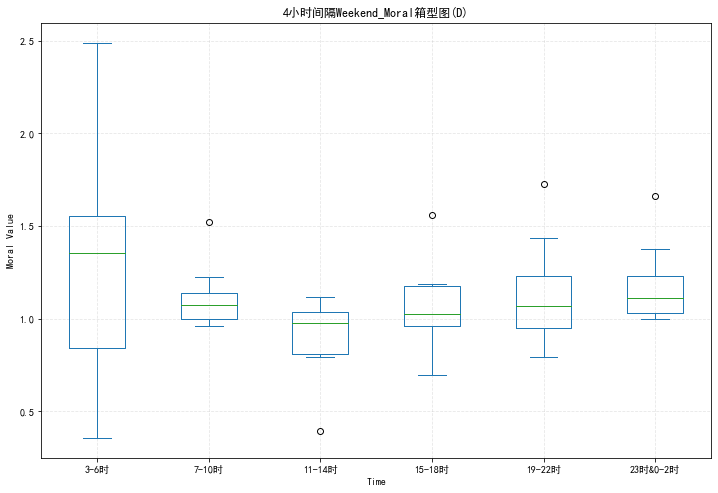

Weekend六时区，A
index:0;（0时-6时）时间区间;平均值：1.2405688867326798;方差：0.28943537745873166;标准差：0.5379919864261286
index:1;（6时-12时）时间区间;平均值：1.0884062819081954;方差：0.07762816016615935;标准差：0.2786183055116073
index:2;（12时-18时）时间区间;平均值：1.0451372674894817;方差：0.039078687386250414;标准差：0.19768330072682017
index:3;（18时-24时）时间区间;平均值：1.076666024303347;方差：0.06906002870149106;标准差：0.2627927485709814
(0, 1) (Ttest_indResult(statistic=0.832978235077755, pvalue=0.4138090196387195), 0.34006194046409927)
(0, 2) (Ttest_indResult(statistic=1.1308739210436798, pvalue=0.27028611019822696), 0.46167734499624785)
(0, 3) (Ttest_indResult(statistic=0.9079064121993894, pvalue=0.3737660990243873), 0.37065124068158)
(1, 2) (Ttest_indResult(statistic=0.42007339471736077, pvalue=0.6785061785126609), 0.1714942452627141)
(1, 3) (Ttest_indResult(statistic=0.10166615423974544, pvalue=0.9199425948741826), 0.0415050336664115)
(2, 3) (Ttest_indResult(statistic=-0.3179893572318676, pvalue=0.7534917587323955), -0.12981861147561255)


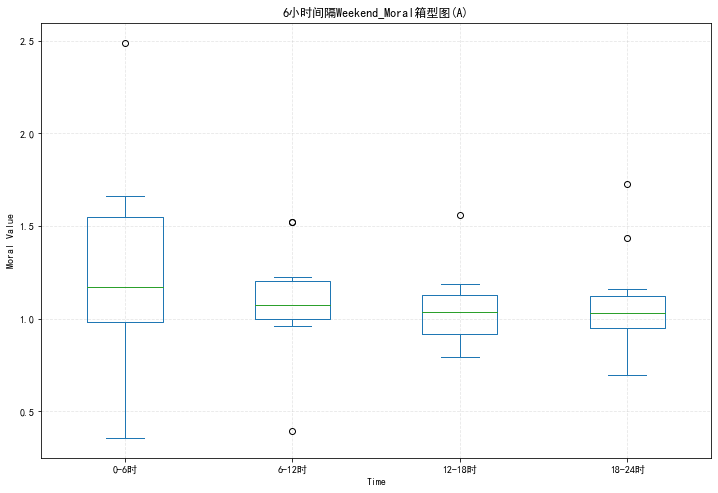

Weekend六时区，B
index:0;（1时-7时）时间区间;平均值：1.269413155570483;方差：0.2888661121018347;标准差：0.5374626611233888
index:1;（7时-13时）时间区间;平均值：1.0419868734466415;方差：0.059111363602180084;标准差：0.24312828630618052
index:2;（13时-19时）时间区间;平均值：1.00719538905391;方差：0.04745396468701137;标准差：0.21783930932458304
index:3;（19时-24时 & 0时-1时）时间区间;平均值：1.1321830423626695;方差：0.06150444921697887;标准差：0.24800090567773914
(0, 1) (Ttest_indResult(statistic=1.2786786906260372, pvalue=0.21433504474511259), 0.5220183895006504)
(0, 2) (Ttest_indResult(statistic=1.499622886267671, pvalue=0.14792674000493217), 0.6122184796592607)
(0, 3) (Ttest_indResult(statistic=0.7689214207504752, pvalue=0.4501165288974114), 0.31391085552242626)
(1, 2) (Ttest_indResult(statistic=0.3534771441018287, pvalue=0.7270955559008885), 0.14430643979762012)
(1, 3) (Ttest_indResult(statistic=-0.8613552595474944, pvalue=0.3983335833191479), -0.3516468121923217)
(2, 3) (Ttest_indResult(statistic=-1.2558364103105608, pvalue=0.22234938962937253), -0.512693067611561)

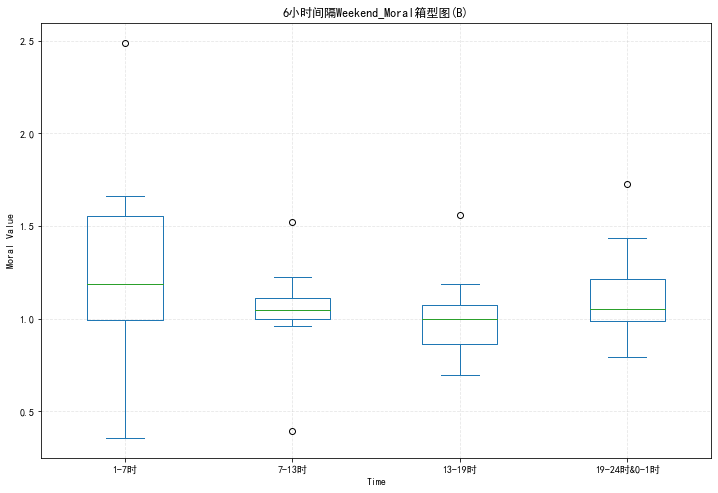

Weekend六时区，C
index:0;（2时-8时）时间区间;平均值：1.300966077026422;方差：0.29095800482463635;标准差：0.5394052324779918
index:1;（8时-14时）时间区间;平均值：0.9791426050982776;方差：0.04131470880342574;标准差：0.20326019975249887
index:2;（14时-20时）时间区间;平均值：1.0716647896617586;方差：0.05637107764454872;标准差：0.23742594138920187
index:3;（20时-24时 & 0时-2时）时间区间;平均值：1.0990049886472457;方差：0.05420913428648643;标准差：0.23282855126999874
(0, 1) (Ttest_indResult(statistic=1.8516833404692916, pvalue=0.07754047471693687), 0.7559465582270034)
(0, 2) (Ttest_indResult(statistic=1.290423492917707, pvalue=0.2103019198654748), 0.5268131849580606)
(0, 3) (Ttest_indResult(statistic=1.1401167432380375, pvalue=0.26649852026430165), 0.46545071135615584)
(1, 2) (Ttest_indResult(statistic=-0.9818079228770666, pvalue=0.3368691443002285), -0.40082140607843875)
(1, 3) (Ttest_indResult(statistic=-1.2862439914112285, pvalue=0.21173036655017835), -0.5251069106130497)
(2, 3) (Ttest_indResult(statistic=-0.2726837794043952, pvalue=0.7876394422565174), -0.111322686779

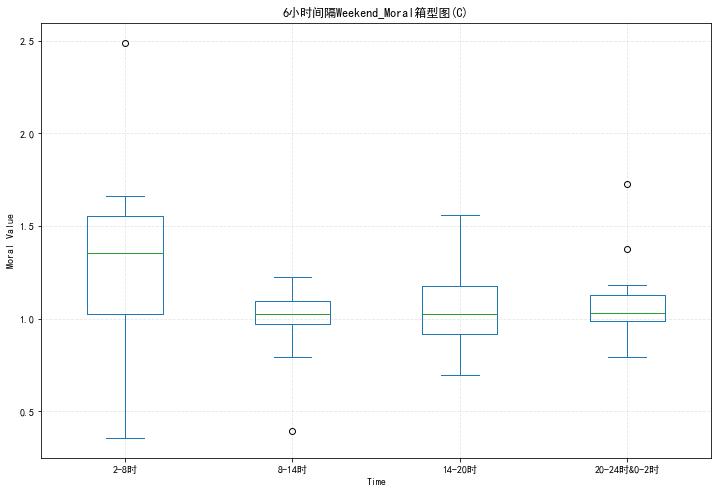

Weekend六时区，D
index:0;（3时-9时）时间区间;平均值：1.2377426809285026;方差：0.2873224585485031;标准差：0.536024680913578
index:1;（9时-15时）时间区间;平均值：0.9527631976746326;方差：0.04194288818799737;标准差：0.20479962936489257
index:2;（15时-21时）时间区间;平均值：1.162411846891012;方差：0.07661634433489757;标准差：0.276796575728273
index:3;（21时-24时 & 0时-3时）时间区间;平均值：1.097860734939557;方差：0.04821744550230772;标准差：0.21958471144938055
(0, 1) (Ttest_indResult(statistic=1.6471643119936403, pvalue=0.11373513604823487), 0.6724520144844887)
(0, 2) (Ttest_indResult(statistic=0.4141473981640178, pvalue=0.6827761605733533), 0.1690749673005171)
(0, 3) (Ttest_indResult(statistic=0.8009140641763004, pvalue=0.43174654729534345), 0.3269717975084394)
(1, 2) (Ttest_indResult(statistic=-2.0193924187271857, pvalue=0.05579348289610521), -0.8244135027210591)
(1, 3) (Ttest_indResult(statistic=-1.6026866841101701, pvalue=0.1232657183268481), -0.6542940989371742)
(2, 3) (Ttest_indResult(statistic=0.6059460972274844, pvalue=0.5507518487737395), 0.24737645830637026)


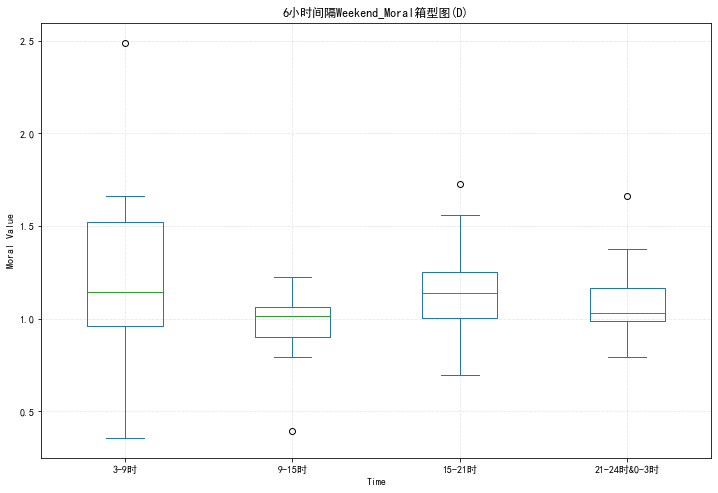

Weekend六时区，E
index:0;（4时-10时）时间区间;平均值：1.149462610105328;方差：0.2645962529602725;标准差：0.5143892037749942
index:1;（10时-16时）时间区间;平均值：0.9936874571963177;方差：0.06947344708186425;标准差：0.26357816123849154
index:2;（16时-22时）时间区间;平均值：1.1110221583706508;方差：0.06457037042403967;标准差：0.2541070058539112
index:3;（22时-24时 & 0时-4时）时间区间;平均值：1.196606234761407;方差：0.0768074441775056;标准差：0.27714155981646926
(0, 1) (Ttest_indResult(statistic=0.8938733414790903, pvalue=0.38106450601080244), 0.3649222635500595)
(0, 2) (Ttest_indResult(statistic=0.22221682030826917, pvalue=0.8261950598647763), 0.09071963700316633)
(0, 3) (Ttest_indResult(statistic=-0.26759944169864613, pvalue=0.791500452957376), -0.10924701460255648)
(1, 2) (Ttest_indResult(statistic=-1.0629171644244717, pvalue=0.29934829614326786), -0.43393411528098746)
(1, 3) (Ttest_indResult(statistic=-1.759643870591646, pvalue=0.09236857189371603), -0.7183716019942543)
(2, 3) (Ttest_indResult(statistic=-0.7549160845344189, pvalue=0.45830531128485297), -0.308193200

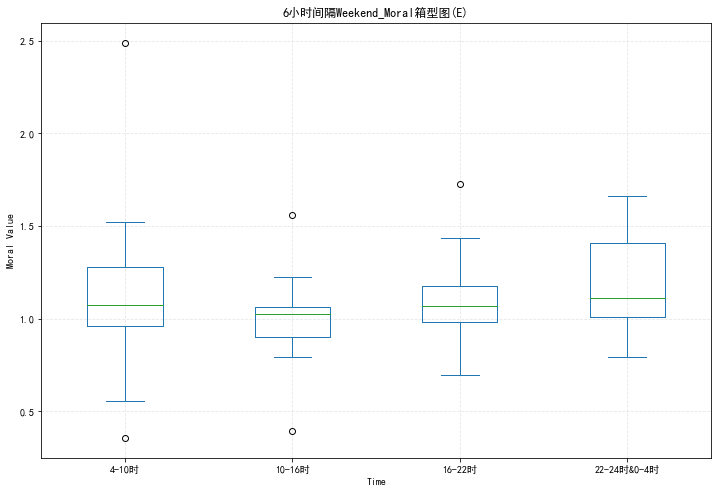

Weekend六时区，F
index:0;（5时-11时）时间区间;平均值：1.0941831598833491;方差：0.06282873728376133;标准差：0.2506566122881288
index:1;（11时-17时）时间区间;平均值：1.0082184789738406;方差：0.07046781324243108;标准差：0.2654577428564311
index:2;（17时-23时）时间区间;平均值：1.0567469514466439;方差：0.07260239355987821;标准差：0.269448313336488
index:3;（23时-24时 & 0时-5时）时间区间;平均值：1.29162987012987;方差：0.24570121311738383;标准差：0.49568257294097384
(0, 1) (Ttest_indResult(statistic=0.780920713926707, pvalue=0.4431716598085724), 0.3188095464483976)
(0, 2) (Ttest_indResult(statistic=0.3373874678622092, pvalue=0.7390226419898007), 0.13773785697867846)
(0, 3) (Ttest_indResult(statistic=-1.1789559539172885, pvalue=0.25100957789551925), -0.4813067527189259)
(1, 2) (Ttest_indResult(statistic=-0.4255184167373459, pvalue=0.6745924659379707), -0.17371716619391112)
(1, 3) (Ttest_indResult(statistic=-1.6716832215488853, pvalue=0.10875171326676082), -0.6824618173944557)
(2, 3) (Ttest_indResult(statistic=-1.3807879795541291, pvalue=0.18121170788429156), -0.563704332146

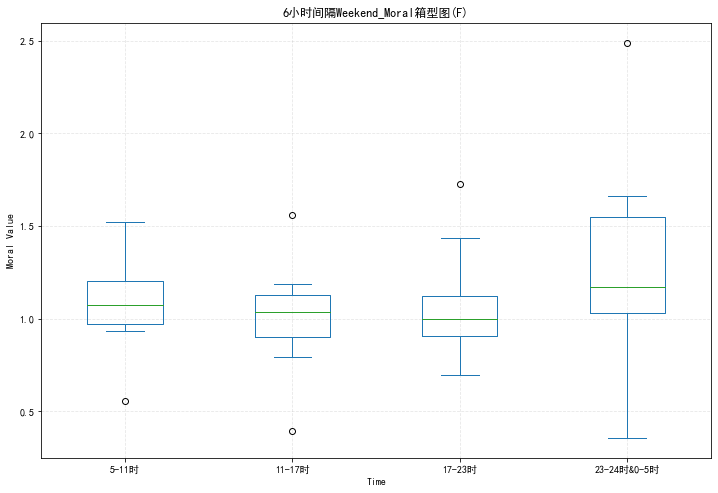

In [8]:
# 五、（三）weekend数据
# （1）平均值，方差，标准差【moral,score_communion,score_agency】
# Moral
weekend_moral_avg,weekend_moral_var,weekend_moral_std = get_mean_score(weekend_moral)
print_mean_score("weekend_moral",weekend_moral_avg,weekend_moral_var,weekend_moral_std)
# Score_communion
weekend_score_communion_avg,weekend_score_communion_var,weekend_score_communion_std = get_mean_score(weekend_score_communion)
print_mean_score("weekend_score_communion",weekend_score_communion_avg,weekend_score_communion_var,weekend_score_communion_std)
# Score_agency
weekend_score_agency_avg,weekend_score_agency_var,weekend_score_agency_std = get_mean_score(weekend_score_agency)
print_mean_score("weekend_score_agency",weekend_score_agency_avg,weekend_score_agency_var,weekend_score_agency_std)
# （2）单样本T检验（005置信【1.711】，001置信【2.492】）
weekend_moral_005,weekend_moral_001 = get_t_sigle(weekend_moral)
print_t_sigle("weekend_moral",weekend_moral_005,weekend_moral_001)
# Score_communion
weekend_score_communion_005,weekend_score_communion_001 = get_t_sigle(weekend_score_communion)
print_t_sigle("weekend_score_communion",weekend_score_communion_005,weekend_score_communion_001)
# Score_agency
weekend_score_agency_005,weekend_score_agency_001 = get_t_sigle(weekend_score_agency)
print_t_sigle("weekend_score_agency",weekend_score_agency_005,weekend_score_agency_001)
# （3）相关性检验（pearsonr,spear,kendall）
# Moral与评论条数
weekend_moral_sentnum_pearson,weekend_moral_sentnum_spear,weekend_moral_sentnum_kendall = get_correlation(weekend_moral,weekend_sentnum)
print_correlation("weekend_moral","评论条数",weekend_moral_sentnum_pearson,weekend_moral_sentnum_spear,weekend_moral_sentnum_kendall)
# Moral受评论条数影响率
weekend_moral_sentnum_rate = [a/b for a,b in zip(weekend_moral,weekend_sentnum)]
#print(weekend_moral_sentnum_rate)
# Moral与切分词总数
weekend_moral_words_pearson,weekend_moral_words_spear,weekend_moral_words_kendall = get_correlation(weekend_moral,weekend_all_words)
print_correlation("weekend_moral","切分词总数",weekend_moral_words_pearson,weekend_moral_words_spear,weekend_moral_words_kendall)
# Moral受切分词总数影响率
weekend_moral_allwords_rate = [a/b for a,b in zip(weekend_moral,workdays_all_words)]
#print(weekend_moral_allwords_rate)

# （4） 拆分时间区间——Weekend_moral
#********************************************************************************************
# Moral——三时区（A，B，C）
#********************************************************************************************
print('Weekend三时区，A')
# A(0时开始)
# 时间区间——0时-3时（moral）
weekend_moral_time3a_am1 = weekend_moral[0:6]
#print("3a-am1",weekend_moral_time3a_am1)
# 时间区间——3时-6时（moral）
weekend_moral_time3a_am2 = weekend_moral[6:12]
#print("3a-am2",weekend_moral_time3a_am2)
# 时间区间——6时-9时（moral）
weekend_moral_time3a_am3 = weekend_moral[12:18]
#print("3a-am3",weekend_moral_time3a_am3)
# 时间区间——9时-12时（moral）
weekend_moral_time3a_am4 = weekend_moral[18:24]
#print("3a-am4",weekend_moral_time3a_am4)
# 时间区间——12时-15时（moral）
weekend_moral_time3a_pm1 = weekend_moral[24:30]
#print("3a-pm1",weekend_moral_time3a_pm1)
# 时间区间——15时-18时（moral）
weekend_moral_time3a_pm2 = weekend_moral[30:36]
#print("3a-pm2",weekend_moral_time3a_pm2)
# 时间区间——18时-21时（moral）
weekend_moral_time3a_pm3 = weekend_moral[36:42]
#print("3a-pm3",weekend_moral_time3a_pm3)
# 时间区间——21时-24时（moral）
weekend_moral_time3a_pm4 = weekend_moral[42:48]
#print("3a-pm4",weekend_moral_time3a_pm4)

# 构建列表嵌套的时间区间数据集
weekend_moral_time3a = [weekend_moral_time3a_am1,weekend_moral_time3a_am2,weekend_moral_time3a_am3,weekend_moral_time3a_am4,
                          weekend_moral_time3a_pm1,weekend_moral_time3a_pm2,weekend_moral_time3a_pm3,weekend_moral_time3a_pm4]



for i,j in enumerate(weekend_moral_time3a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（3时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（6时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（9时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（12时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（15时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（18时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（21时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
        
# 时间区间的两两交叉T检验
weekend_moral_time3a_2crosscheck = get_2crosscheck_t_double(weekend_moral_time3a)
for i,j in weekend_moral_time3a_2crosscheck.items():
    print(i,j)

weekend_name_list_3a = ['0-3时','3-6时','6-9时','9-12时','12-15时','15-18时','18-21时','21-24时']
weekend_box_graph3a = get_boxgraph(weekend_name_list_3a,'Time','Moral Value','3小时间隔Weekend_moral箱型图(A)',
                           weekend_moral_time3a_am1,weekend_moral_time3a_am2,weekend_moral_time3a_am3,weekend_moral_time3a_am4,
                          weekend_moral_time3a_pm1,weekend_moral_time3a_pm2,weekend_moral_time3a_pm3,weekend_moral_time3a_pm4)
#********************************************************************************************
print('Weekend三时区，B')
# B(1时开始)
# 时间区间——1时-4时（moral）
weekend_moral_time3b_am1 = weekend_moral[2:8]
#print("3b-am1",weekend_moral_time3b_am1)
# 时间区间——4时-7时（moral）
weekend_moral_time3b_am2 = weekend_moral[8:14]
#print("3b-am2",weekend_moral_time3b_am2)
# 时间区间——7时-10时（moral）
weekend_moral_time3b_am3 = weekend_moral[14:20]
#print("3b-am3",weekend_moral_time3b_am3)
# 时间区间——10时-13时（moral）
weekend_moral_time3b_am4 = weekend_moral[20:26]
#print("3b-am4",weekend_moral_time3b_am4)
# 时间区间——13时-16时（moral）
weekend_moral_time3b_pm1 = weekend_moral[26:32]
#print("3b-pm1",weekend_moral_time3b_pm1)
# 时间区间——16时-19时（moral）
weekend_moral_time3b_pm2 = weekend_moral[32:38]
#print("3b-pm2",weekend_moral_time3b_pm2)
# 时间区间——19时-22时（moral）
weekend_moral_time3b_pm3 = weekend_moral[38:44]
#print("3b-pm3",weekend_moral_time3b_pm3)
# 时间区间——22时-24时-0时（moral）
weekend_moral_time3b_pm4 = weekend_moral[44:48]+weekend_moral[0:2]
#print("3b-pm4",weekend_moral_time3b_pm4)

# 构建列表嵌套的时间区间数据集
weekend_moral_time3b = [weekend_moral_time3b_am1,weekend_moral_time3b_am2,weekend_moral_time3b_am3,weekend_moral_time3b_am4,
                          weekend_moral_time3b_pm1,weekend_moral_time3b_pm2,weekend_moral_time3b_pm3,weekend_moral_time3b_pm4]



for i,j in enumerate(weekend_moral_time3b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（7时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（10时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（13时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（16时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（19时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（22时-24时 & 0时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
weekend_moral_time3b_2crosscheck = get_2crosscheck_t_double(weekend_moral_time3b)
for i,j in weekend_moral_time3b_2crosscheck.items():
    print(i,j)
    
weekend_name_list_3b = ['1-4时','4-7时','7-10时','10-13时','13-16时','16-19时','19-22时','22-24时&0时']
weekend_box_graph3b = get_boxgraph(weekend_name_list_3b,'Time','Moral Value','3小时间隔Weekend_moral箱型图(B)',
                           weekend_moral_time3b_am1,weekend_moral_time3b_am2,weekend_moral_time3b_am3,weekend_moral_time3b_am4,
                          weekend_moral_time3b_pm1,weekend_moral_time3b_pm2,weekend_moral_time3b_pm3,weekend_moral_time3b_pm4)
#********************************************************************************************
print('Weekend三时区，C')
# 时间区间——2时-5时（moral）
weekend_moral_time3c_am1 = weekend_moral[4:10]
#print("3c-am1",weekend_moral_time3c_am1)
# 时间区间——5时-8时（moral）
weekend_moral_time3c_am2 = weekend_moral[10:16]
#print("3c-am2",weekend_moral_time3c_am2)
# 时间区间——8时-11时（moral）
weekend_moral_time3c_am3 = weekend_moral[16:22]
#print("3c-am3",weekend_moral_time3c_am3)
# 时间区间——11时-14时（moral）
weekend_moral_time3c_am4 = weekend_moral[22:28]
#print("3c-am4",weekend_moral_time3c_am4)
# 时间区间——14时-17时（moral）
weekend_moral_time3c_pm1 = weekend_moral[28:34]
#print("3c-pm1",weekend_moral_time3c_pm1)
# 时间区间——17时-20时（moral）
weekend_moral_time3c_pm2 = weekend_moral[34:40]
#print("3c-pm2",weekend_moral_time3c_pm2)
# 时间区间——20时-23时（moral）
weekend_moral_time3c_pm3 = weekend_moral[40:46]
#print("3c-pm3",weekend_moral_time3c_pm3)
# 时间区间——24时+0-1时（moral）
weekend_moral_time3c_pm4 = weekend_moral[46:48]+weekend_moral[0:4]
#print("3c-pm4",weekend_moral_time3c_pm4)

# 构建列表嵌套的时间区间数据集
weekend_moral_time3c = [weekend_moral_time3c_am1,weekend_moral_time3c_am2,weekend_moral_time3c_am3,weekend_moral_time3c_am4,
                          weekend_moral_time3c_pm1,weekend_moral_time3c_pm2,weekend_moral_time3c_pm3,weekend_moral_time3c_pm4]



for i,j in enumerate(weekend_moral_time3c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（11时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（14时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（17时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（20时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
weekend_moral_time3c_2crosscheck = get_2crosscheck_t_double(weekend_moral_time3c)
for i,j in weekend_moral_time3c_2crosscheck.items():
    print(i,j)

weekend_name_list_3c = ['2-5时','5-8时','8-11时','11-14时','14-17时','17-20时','20-23时','24时&0-1时']
weekend_box_graph3c = get_boxgraph(weekend_name_list_3c,'Time','Moral Value','3小时间隔Weekend_moral箱型图(C)',
                           weekend_moral_time3c_am1,weekend_moral_time3c_am2,weekend_moral_time3c_am3,weekend_moral_time3c_am4,
                          weekend_moral_time3c_pm1,weekend_moral_time3c_pm2,weekend_moral_time3c_pm3,weekend_moral_time3c_pm4)

#********************************************************************************************
# Moral——四时区（A，B，C，D）
#********************************************************************************************
print('Weekend四时区，A')
# 时间区间——0时-4时（moral）
weekend_moral_time4a_am1 = weekend_moral[0:8]
#print("4a-am1",weekend_moral_time4a_am1)
# 时间区间——4时-8时（moral）
weekend_moral_time4a_am2 = weekend_moral[8:16]
#print("4a-am2",weekend_moral_time4a_am2)
# 时间区间——8时-12时（moral）
weekend_moral_time4a_am3 = weekend_moral[16:24]
#print("4a-am3",weekend_moral_time4a_am3)
# 时间区间——12时-16时（moral）
weekend_moral_time4a_pm1 = weekend_moral[24:32]
#print("4a-pm1",weekend_moral_time4a_pm1)
# 时间区间——16时-20时（moral）
weekend_moral_time4a_pm2 = weekend_moral[32:40]
#print("4a-pm2",weekend_moral_time4a_pm2)
# 时间区间——20时-24时（moral）
weekend_moral_time4a_pm3 = weekend_moral[40:48]
#print("4a-pm3",weekend_moral_time4a_pm3)

# 构建列表嵌套的时间区间数据集
weekend_moral_time4a = [weekend_moral_time4a_am1,weekend_moral_time4a_am2,weekend_moral_time4a_am3,
                          weekend_moral_time4a_pm1,weekend_moral_time4a_pm2,weekend_moral_time4a_pm3]



for i,j in enumerate(weekend_moral_time4a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（12时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（16时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（20时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time4a_2crosscheck = get_2crosscheck_t_double(weekend_moral_time4a)
for i,j in weekend_moral_time4a_2crosscheck.items():
    print(i,j)

weekend_name_list_4a = ['0-4时','4-8时','8-12时','12-16时','16-20时','20-24时']
weekend_box_graph4a = get_boxgraph(weekend_name_list_4a,'Time','Moral Value','4小时间隔Weekend_Moral箱型图（A）',
                           weekend_moral_time4a_am1,weekend_moral_time4a_am2,weekend_moral_time4a_am3,
                          weekend_moral_time4a_pm1,weekend_moral_time4a_pm2,weekend_moral_time4a_pm3)

#********************************************************************************************
print('Weekend四时区，B')
# 时间区间——1时-5时（moral）
weekend_moral_time4b_am1 = weekend_moral[2:10]
#print("4b-am1",weekend_moral_time4b_am1)
# 时间区间——5时-9时（moral）
weekend_moral_time4b_am2 = weekend_moral[10:18]
#print("4b-am2",weekend_moral_time4b_am2)
# 时间区间——9时-13时（moral）
weekend_moral_time4b_am3 = weekend_moral[18:26]
#print("4b-am3",weekend_moral_time4b_am3)
# 时间区间——13时-17时（moral）
weekend_moral_time4b_pm1 = weekend_moral[26:34]
#print("4b-pm1",weekend_moral_time4b_pm1)
# 时间区间——17时-21时（moral）
weekend_moral_time4b_pm2 = weekend_moral[34:42]
#print("4b-pm2",weekend_moral_time4b_pm2)
# 时间区间——21时-24时 & 0时（moral）
weekend_moral_time4b_pm3 = weekend_moral[42:48] + weekend_moral[0:2]
#print("4b-pm3",weekend_moral_time4b_pm3)

# 构建列表嵌套的时间区间数据集
weekend_moral_time4b = [weekend_moral_time4b_am1,weekend_moral_time4b_am2,weekend_moral_time4b_am3,
                          weekend_moral_time4b_pm1,weekend_moral_time4b_pm2,weekend_moral_time4b_pm3]



for i,j in enumerate(weekend_moral_time4b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（9时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（13时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（17时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（21时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time4b_2crosscheck = get_2crosscheck_t_double(weekend_moral_time4b)
for i,j in weekend_moral_time4b_2crosscheck.items():
    print(i,j)

weekend_name_list_4b = ['1-5时','5-9时','9-13时','13-17时','17-21时','21-24时&0时-1时']
weekend_box_graph4b = get_boxgraph(weekend_name_list_4b,'Time','Moral Value','4小时间隔Weekend_Moral箱型图（B）',
                           weekend_moral_time4b_am1,weekend_moral_time4b_am2,weekend_moral_time4b_am3,
                          weekend_moral_time4b_pm1,weekend_moral_time4b_pm2,weekend_moral_time4b_pm3)
#********************************************************************************************
print('Weekend四时区，C')
# 时间区间——2时-6时（moral）
weekend_moral_time4c_am1 = weekend_moral[4:12]
#print("4c-am1",weekend_moral_time4c_am1)
# 时间区间——6时-10时（moral）
weekend_moral_time4c_am2 = weekend_moral[12:20]
#print("4c-am2",weekend_moral_time4c_am2)
# 时间区间——10时-14时（moral）
weekend_moral_time4c_am3 = weekend_moral[20:28]
#print("4c-am3",weekend_moral_time4c_am3)
# 时间区间——14时-18时（moral）
weekend_moral_time4c_pm1 = weekend_moral[28:36]
#print("4c-pm1",weekend_moral_time4c_pm1)
# 时间区间——18时-22时（moral）
weekend_moral_time4c_pm2 = weekend_moral[36:44]
#print("4c-pm2",weekend_moral_time4c_pm2)
# 时间区间——22时-24时 & 0时-2时（moral）
weekend_moral_time4c_pm3 = weekend_moral[44:48] + weekend_moral[0:4]
#print("4c-pm3",weekend_moral_time4c_pm3)

# 构建列表嵌套的时间区间数据集
weekend_moral_time4c = [weekend_moral_time4c_am1,weekend_moral_time4c_am2,weekend_moral_time4c_am3,
                          weekend_moral_time4c_pm1,weekend_moral_time4c_pm2,weekend_moral_time4c_pm3]



for i,j in enumerate(weekend_moral_time4c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（10时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（14时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（18时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（22时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time4c_2crosscheck = get_2crosscheck_t_double(weekend_moral_time4c)
for i,j in weekend_moral_time4c_2crosscheck.items():
    print(i,j)

weekend_name_list_4c = ['2-6时','6-10时','10-14时','14-18时','18-22时','22-24时&0时-2时']
weekend_box_graph4c = get_boxgraph(weekend_name_list_4c,'Time','Moral Value','4小时间隔Weekend_Moral箱型图(C)',
                           weekend_moral_time4c_am1,weekend_moral_time4c_am2,weekend_moral_time4c_am3,
                          weekend_moral_time4c_pm1,weekend_moral_time4c_pm2,weekend_moral_time4c_pm3)
#********************************************************************************************
print('Weekend四时区，D')
# 时间区间——3时-7时（moral）
weekend_moral_time4d_am1 = weekend_moral[6:14]
#print("4d-am1",weekend_moral_time4d_am1)
# 时间区间——7时-11时（moral）
weekend_moral_time4d_am2 = weekend_moral[14:22]
#print("4d-am2",weekend_moral_time4d_am2)
# 时间区间——11时-15时（moral）
weekend_moral_time4d_am3 = weekend_moral[22:30]
#print("4d-am3",weekend_moral_time4d_am3)
# 时间区间——15时-19时（moral）
weekend_moral_time4d_pm1 = weekend_moral[30:38]
#print("4d-pm1",weekend_moral_time4d_pm1)
# 时间区间——19时-23时（moral）
weekend_moral_time4d_pm2 = weekend_moral[38:46]
#print("4d-pm2",weekend_moral_time4d_pm2)
# 时间区间——24时 & 0时-3时（moral）
weekend_moral_time4d_pm3 = weekend_moral[46:48] + weekend_moral[0:6]
#print("4d-pm3",weekend_moral_time4d_pm3)
# 构建列表嵌套的时间区间数据集
weekend_moral_time4d = [weekend_moral_time4d_am1,weekend_moral_time4d_am2,weekend_moral_time4d_am3,
                          weekend_moral_time4d_pm1,weekend_moral_time4d_pm2,weekend_moral_time4d_pm3]



for i,j in enumerate(weekend_moral_time4d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（11时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（15时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（19时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time4d_2crosscheck = get_2crosscheck_t_double(weekend_moral_time4d)
for i,j in weekend_moral_time4d_2crosscheck.items():
    print(i,j)
    
weekend_name_list_4d = ['3-6时','7-10时','11-14时','15-18时','19-22时','23时&0-2时']
weekend_box_graph4d = get_boxgraph(weekend_name_list_4d,'Time','Moral Value','4小时间隔Weekend_Moral箱型图(D)',
                           weekend_moral_time4d_am1,weekend_moral_time4d_am2,weekend_moral_time4d_am3,
                          weekend_moral_time4d_pm1,weekend_moral_time4d_pm2,weekend_moral_time4d_pm3)
#********************************************************************************************
# Moral——六时区（A，B，C，D，E，F）
#********************************************************************************************
print('Weekend六时区，A')
# 时间区间——0时-6时（moral）
weekend_moral_time6a_am1 = weekend_moral[0:12]
#print("6a-am1",weekend_moral_time6a_am1)
# 时间区间——6时-12时（moral）
weekend_moral_time6a_am2 = weekend_moral[12:24]
#print("6a-am2",weekend_moral_time6a_am2)
# 时间区间——12时-18时（moral）
weekend_moral_time6a_pm1 = weekend_moral[24:36]
#print("6a-pm1",weekend_moral_time6a_pm1)
# 时间区间——18时-24时（moral）
weekend_moral_time6a_pm2 = weekend_moral[36:48]
#print("6a-pm2",weekend_moral_time6a_pm2)

# 构建列表嵌套的时间区间数据集
weekend_moral_time6a = [weekend_moral_time6a_am1,weekend_moral_time6a_am2,
                    weekend_moral_time6a_pm1,weekend_moral_time6a_pm2]



for i,j in enumerate(weekend_moral_time6a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（12时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（18时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time6a_2crosscheck = get_2crosscheck_t_double(weekend_moral_time6a)
for i,j in weekend_moral_time6a_2crosscheck.items():
    print(i,j)

weekend_name_list_6a = ['0-6时','6-12时','12-18时','18-24时']
weekend_box_graph6a = get_boxgraph(weekend_name_list_6a,'Time','Moral Value','6小时间隔Weekend_Moral箱型图(A)',
                           weekend_moral_time6a_am1,weekend_moral_time6a_am2,
                          weekend_moral_time6a_pm1,weekend_moral_time6a_pm2)

#********************************************************************************************
print('Weekend六时区，B')
# 时间区间——1时-7时（moral）
weekend_moral_time6b_am1 = weekend_moral[2:14]
#print("6b-am1",weekend_moral_time6b_am1)
# 时间区间——7时-13时（moral）
weekend_moral_time6b_am2 = weekend_moral[14:26]
#print("6b-am2",weekend_moral_time6b_am2)
# 时间区间——13时-19时（moral）
weekend_moral_time6b_pm1 = weekend_moral[26:38]
#print("6b-pm1",weekend_moral_time6b_pm1)
# 时间区间——19时-24时&0时-1时（moral）
weekend_moral_time6b_pm2 = weekend_moral[38:48]+weekend_moral[0:2]
#print("6b-pm2",weekend_moral_time6b_pm2)
# 构建列表嵌套的时间区间数据集
weekend_moral_time6b = [weekend_moral_time6b_am1,weekend_moral_time6b_am2,
                    weekend_moral_time6b_pm1,weekend_moral_time6b_pm2]



for i,j in enumerate(weekend_moral_time6b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（13时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（19时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time6b_2crosscheck = get_2crosscheck_t_double(weekend_moral_time6b)
for i,j in weekend_moral_time6b_2crosscheck.items():
    print(i,j)
    
weekend_name_list_6b = ['1-7时','7-13时','13-19时','19-24时&0-1时']
weekend_box_graph6b = get_boxgraph(weekend_name_list_6b,'Time','Moral Value','6小时间隔Weekend_Moral箱型图(B)',
                           weekend_moral_time6b_am1,weekend_moral_time6b_am2,
                          weekend_moral_time6b_pm1,weekend_moral_time6b_pm2)

#********************************************************************************************
print('Weekend六时区，C')
# 时间区间——2时-8时（moral）
weekend_moral_time6c_am1 = weekend_moral[4:16]
#print("6c-am1",weekend_moral_time6c_am1)
# 时间区间——8时-14时（moral）
weekend_moral_time6c_am2 = weekend_moral[16:28]
#print("6c-am2",weekend_moral_time6c_am2)
# 时间区间——14时-20时（moral）
weekend_moral_time6c_pm1 = weekend_moral[28:40]
#print("6c-pm1",weekend_moral_time6c_pm1)
# 时间区间——20时-24时&0时-2时（moral）
weekend_moral_time6c_pm2 = weekend_moral[40:48]+weekend_moral[0:4]
#print("6c-pm2",weekend_moral_time6c_pm2)
# 构建列表嵌套的时间区间数据集
weekend_moral_time6c = [weekend_moral_time6c_am1,weekend_moral_time6c_am2,
                    weekend_moral_time6c_pm1,weekend_moral_time6c_pm2]



for i,j in enumerate(weekend_moral_time6c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（8时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（14时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（20时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time6c_2crosscheck = get_2crosscheck_t_double(weekend_moral_time6c)
for i,j in weekend_moral_time6c_2crosscheck.items():
    print(i,j)

weekend_name_list_6c = ['2-8时','8-14时','14-20时','20-24时&0-2时']
weekend_box_graph6c = get_boxgraph(weekend_name_list_6c,'Time','Moral Value','6小时间隔Weekend_Moral箱型图(C)',
                           weekend_moral_time6c_am1,weekend_moral_time6c_am2,
                          weekend_moral_time6c_pm1,weekend_moral_time6c_pm2)

#********************************************************************************************
print('Weekend六时区，D')
# 时间区间——3时-9时（moral）
weekend_moral_time6d_am1 = weekend_moral[6:18]
#print("6d-am1",weekend_moral_time6d_am1)
# 时间区间——9时-15时（moral）
weekend_moral_time6d_am2 = weekend_moral[18:30]
#print("6d-am2",weekend_moral_time6d_am2)
# 时间区间——15时-21时（moral）
weekend_moral_time6d_pm1 = weekend_moral[30:42]
#print("6d-pm1",weekend_moral_time6d_pm1)
# 时间区间——21时-24时&0时-3时（moral）
weekend_moral_time6d_pm2 = weekend_moral[42:48]+weekend_moral[0:6]
#print("6d-pm2",weekend_moral_time6d_pm2)

# 构建列表嵌套的时间区间数据集
weekend_moral_time6d = [weekend_moral_time6d_am1,weekend_moral_time6d_am2,
                    weekend_moral_time6d_pm1,weekend_moral_time6d_pm2]



for i,j in enumerate(weekend_moral_time6d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（9时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（15时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（21时-24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time6d_2crosscheck = get_2crosscheck_t_double(weekend_moral_time6d)
for i,j in weekend_moral_time6d_2crosscheck.items():
    print(i,j)

weekend_name_list_6d = ['3-9时','9-15时','15-21时','21-24时&0-3时']
weekend_box_graph6d = get_boxgraph(weekend_name_list_6d,'Time','Moral Value','6小时间隔Weekend_Moral箱型图(D)',
                           weekend_moral_time6d_am1,weekend_moral_time6d_am2,
                          weekend_moral_time6d_pm1,weekend_moral_time6d_pm2)
#********************************************************************************************
print('Weekend六时区，E')
# 时间区间——4时-10时（moral）
weekend_moral_time6e_am1 = weekend_moral[8:20]
#print("6e-am1",weekend_moral_time6e_am1)
# 时间区间——10时-16时（moral）
weekend_moral_time6e_am2 = weekend_moral[20:32]
#print("6e-am2",weekend_moral_time6e_am2)
# 时间区间——16时-22时（moral）
weekend_moral_time6e_pm1 = weekend_moral[32:44]
#print("6e-pm1",weekend_moral_time6e_pm1)
# 时间区间——22时-24时&0时-4时（moral）
weekend_moral_time6e_pm2 = weekend_moral[44:48]+weekend_moral[0:8]
#print("6e-pm2",weekend_moral_time6e_pm2)
# 构建列表嵌套的时间区间数据集
weekend_moral_time6e = [weekend_moral_time6e_am1,weekend_moral_time6e_am2,
                    weekend_moral_time6e_pm1,weekend_moral_time6e_pm2]



for i,j in enumerate(weekend_moral_time6e):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（4时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（10时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（16时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（22时-24时 & 0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time6e_2crosscheck = get_2crosscheck_t_double(weekend_moral_time6e)
for i,j in weekend_moral_time6e_2crosscheck.items():
    print(i,j)

weekend_name_list_6e = ['4-10时','10-16时','16-22时','22-24时&0-4时']
weekend_box_graph6e = get_boxgraph(weekend_name_list_6e,'Time','Moral Value','6小时间隔Weekend_Moral箱型图(E)',
                           weekend_moral_time6e_am1,weekend_moral_time6e_am2,
                          weekend_moral_time6e_pm1,weekend_moral_time6e_pm2)
#********************************************************************************************
print('Weekend六时区，F')

# 时间区间——5时-11时（moral）
weekend_moral_time6f_am1 = weekend_moral[10:22]
#print("6f-am1",weekend_moral_time6f_am1)
# 时间区间——11时-17时（moral）
weekend_moral_time6f_am2 = weekend_moral[22:34]
#print("6f-am2",weekend_moral_time6f_am2)
# 时间区间——17时-23时（moral）
weekend_moral_time6f_pm1 = weekend_moral[34:46]
#print("6f-pm1",weekend_moral_time6f_pm1)
# 时间区间——23时-24时&0时-5时（moral）
weekend_moral_time6f_pm2 = weekend_moral[46:48]+weekend_moral[0:10]
#print("6f-pm2",weekend_moral_time6f_pm2)
# 构建列表嵌套的时间区间数据集
weekend_moral_time6f = [weekend_moral_time6f_am1,weekend_moral_time6f_am2,
                    weekend_moral_time6f_pm1,weekend_moral_time6f_pm2]



for i,j in enumerate(weekend_moral_time6f):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（5时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（11时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（17时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（23时-24时 & 0时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_moral_time6f_2crosscheck = get_2crosscheck_t_double(weekend_moral_time6f)
for i,j in weekend_moral_time6f_2crosscheck.items():
    print(i,j)
    
weekend_name_list_6f = ['5-11时','11-17时','17-23时','23-24时&0-5时']
weekend_box_graph6f = get_boxgraph(weekend_name_list_6f,'Time','Moral Value','6小时间隔Weekend_Moral箱型图(F)',
                           weekend_moral_time6f_am1,weekend_moral_time6f_am2,
                          weekend_moral_time6f_pm1,weekend_moral_time6f_pm2)


holiday_moral，
平均值：0.8449001301276768；
方差：1.0193937378638291；
标准差：1.0096503047411163
holiday_score_communion，
平均值：0.008477011494252873；
方差：0.0003390598163561898；
标准差：0.01841357695713111
holiday_score_agency，
平均值：0.008483379501385042；
方差：0.00018743981207940393；
标准差：0.013690866009110013
holiday_moral,单边T检验：
005置信：Ttest_1sampResult(statistic=-9.357729204452813, pvalue=6.219714780110624e-16)；
001置信：Ttest_1sampResult(statistic=-17.796001467159673, pvalue=2.481467179011685e-35)
holiday_score_communion,单边T检验：
005置信：Ttest_1sampResult(statistic=-1008.6216922109669, pvalue=8.158920301184113e-236)；
001置信：Ttest_1sampResult(statistic=-1471.3076864295442, pvalue=2.512885695729857e-255)
holiday_score_agency,单边T检验：
005置信：Ttest_1sampResult(statistic=-1356.5441127715196, pvalue=3.9537087041339196e-251)；
001置信：Ttest_1sampResult(statistic=-1978.8352195474833, pvalue=1.2155518533310216e-270)
holiday_moral与评论条数相关性检验：
Pearson：(-0.10799335804342482, 0.24036991120976794)；
Spearman：SpearmanrResult(correlation=-

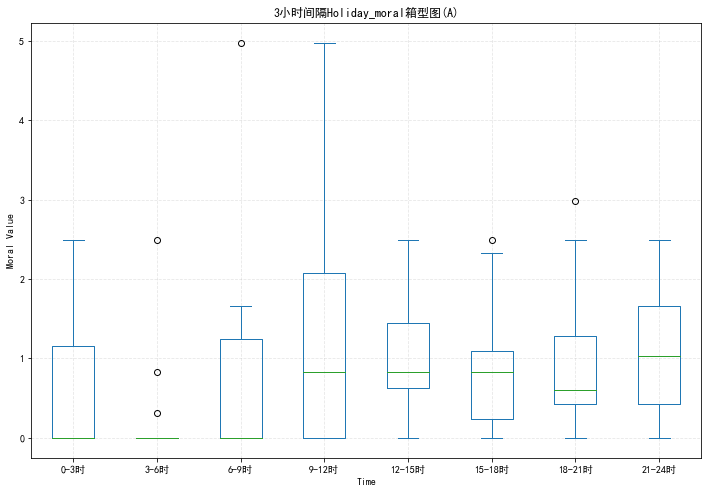

Holiday三时区，B
index:0;（1时-4时）时间区间;平均值：0.13831417624521072;方差：0.13008951718266024;标准差：0.3606792441805603
index:1;（4时-7时）时间区间;平均值：0.7399808429118774;方差：1.7775393366215997;标准差：1.3332439149013955
index:2;（7时-10时）时间区间;平均值：0.36989162561576355;方差：0.30914516590856184;标准差：0.5560082426624283
index:3;（10时-13时）时间区间;平均值：1.4937931034482759;方差：1.8804057092526532;标准差：1.3712788590409513
index:4;（13时-16时）时间区间;平均值：0.8448654800081672;方差：0.6055370885585695;标准差：0.7781626363161942
index:5;（16时-19时）时间区间;平均值：0.853035755432307;方差：0.5654768254004511;标准差：0.7519819315651481
index:6;（19时-22时）时间区间;平均值：0.9243227940866886;方差：0.6598597062744418;标准差：0.8123174910553397
index:7;（22时-24时 & 0时）时间区间;平均值：1.3949972632731256;方差：0.761148611429422;标准差：0.8724383138247781
(0, 1) (Ttest_indResult(statistic=-1.6299452925548321, pvalue=0.11431302151087251), -0.5951718694877592)
(0, 2) (Ttest_indResult(statistic=-1.3074105079817178, pvalue=0.20170783135909456), -0.4773988180939166)
(0, 3) (Ttest_indResult(statistic=-3.576887368145017, p

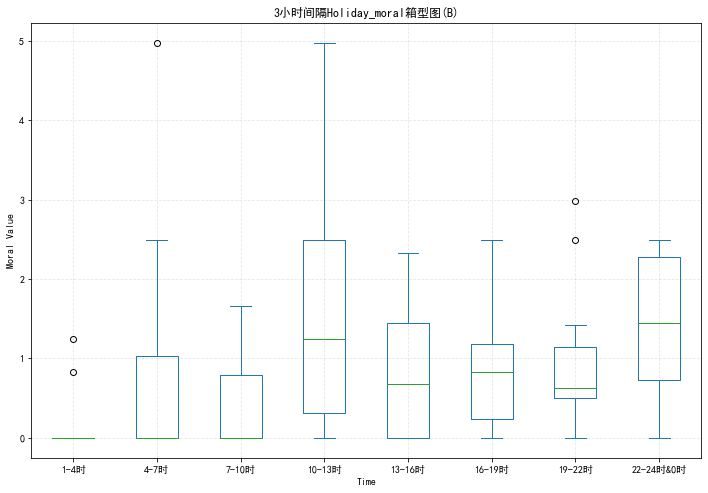

Holiday三时区，C
index:0;（2时-5时）时间区间;平均值：0.16597701149425287;方差：0.3856771568238868;标准差：0.6210291110921345
index:1;（5时-8时）时间区间;平均值：0.6237969348659004;方差：1.55995314064679;标准差：1.2489808407845133
index:2;（8时-11时）时间区间;平均值：0.970175150519978;方差：1.9497576333708715;标准差：1.396337220506161
index:3;（11时-14时）时间区间;平均值：1.1771967234773417;方差：0.7527601113192982;标准差：0.8676174913631572
index:4;（14时-17时）时间区间;平均值：0.8419561128526646;方差：0.5606613758883833;标准差：0.7487732473108152
index:5;（17时-20时）时间区间;平均值：1.022292788820375;方差：0.9558989661350582;标准差：0.9777008571823276
index:6;（20时-23时）时间区间;平均值：0.8631484098502354;方差：0.5403949067385224;标准差：0.7351155737287317
index:7;（24时 & 0时-1时）时间区间;平均值：1.0946579091406676;方差：0.7199197608457218;标准差：0.8484808547313969
(0, 1) (Ttest_indResult(statistic=-1.2280853366881626, pvalue=0.2296386507078339), -0.4484333609636223)
(0, 2) (Ttest_indResult(statistic=-1.9689886326831716, pvalue=0.058923679252757946), -0.718972993061218)
(0, 3) (Ttest_indResult(statistic=-3.5461327744808457, pvalue=0

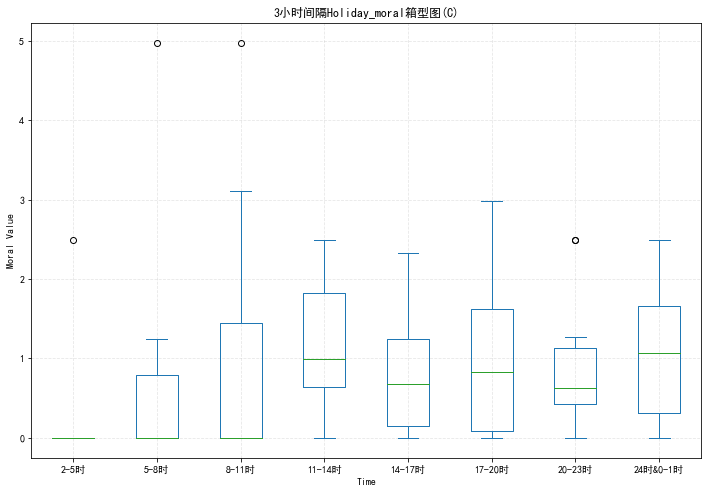

Holiday四时区，A
index:0;（0时-4时）时间区间;平均值：0.5201600985221675;方差：0.6580049884430584;标准差：0.8111750664579492
index:1;（4时-8时）时间区间;平均值：0.5923304597701149;方差：1.4208705877510241;标准差：1.1920027633151797
index:2;（8时-12时）时间区间;平均值：1.0512865353037768;方差：1.7944538922801385;标准差：1.3395722796027614
index:3;（12时-16时）时间区间;平均值：0.9427812939141713;方差：0.5914559075351324;标准差：0.7690617059346619
index:4;（16时-20时）时间区间;平均值：1.0146477525348216;方差：0.8156021989027454;标准差：0.9031069698007792
index:5;（20时-24时）时间区间;平均值：0.9481946407210099;方差：0.5750672440618951;标准差：0.7583318825302646
(0, 1) (Ttest_indResult(statistic=-0.21818326234165744, pvalue=0.8284538110782146), -0.06899560563256804)
(0, 2) (Ttest_indResult(statistic=-1.4783383804932848, pvalue=0.14755904727346011), -0.46749164348034156)
(0, 3) (Ttest_indResult(statistic=-1.6480361743953365, pvalue=0.10759048979799901), -0.5211547977439732)
(0, 4) (Ttest_indResult(statistic=-1.7755846745259707, pvalue=0.08381081878913298), -0.561489174999082)
(0, 5) (Ttest_indResult(statist

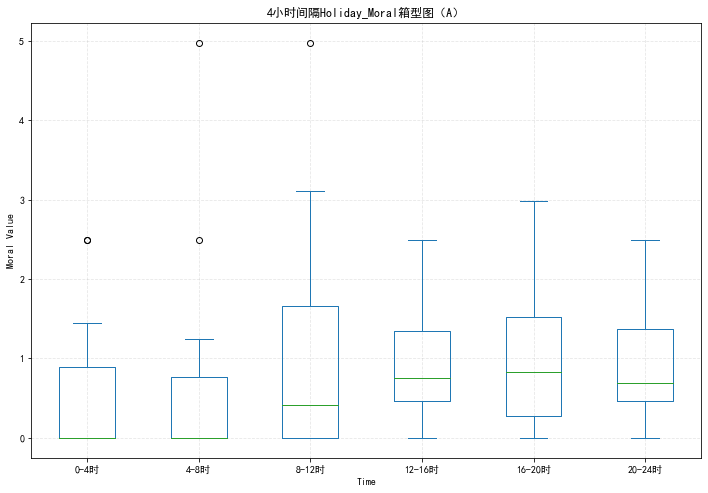

Holiday四时区，B
index:0;（1时-5时）时间区间;平均值：0.2282183908045977;方差：0.36975075637468624;标准差：0.6080713415173307
index:1;（5时-9时）时间区间;平均值：0.6130775862068967;方差：1.3011643184287878;标准差：1.1406858982335093
index:2;（9时-13时）时间区间;平均值：1.2151888341543513;方差：1.6985431410344556;标准差：1.303281681385285
index:3;（13时-17时）时间区间;平均值：0.8815772709256656;方差：0.5566987177580668;标准差：0.7461224549348899
index:4;（17时-21时）时间区间;平均值：0.90691088882382;方差：0.7631725928100423;标准差：0.8735975004600472
index:5;（21时-24时 & 0时-1时）时间区间;平均值：1.224427809850731;方差：0.7066493104355892;标准差：0.8406243575079116
(0, 1) (Ttest_indResult(statistic=-1.297781202658456, pvalue=0.20218532875319342), -0.4103944504953288)
(0, 2) (Ttest_indResult(statistic=-2.9914022936671887, pvalue=0.00485547393693635), -0.9459644645840201)
(0, 3) (Ttest_indResult(statistic=-2.9588144369738316, pvalue=0.005290946091190156), -0.9356592794626027)
(0, 4) (Ttest_indResult(statistic=-2.7793906065598084, pvalue=0.008420593354456676), -0.8789204824005923)
(0, 5) (Ttest_indResult(st

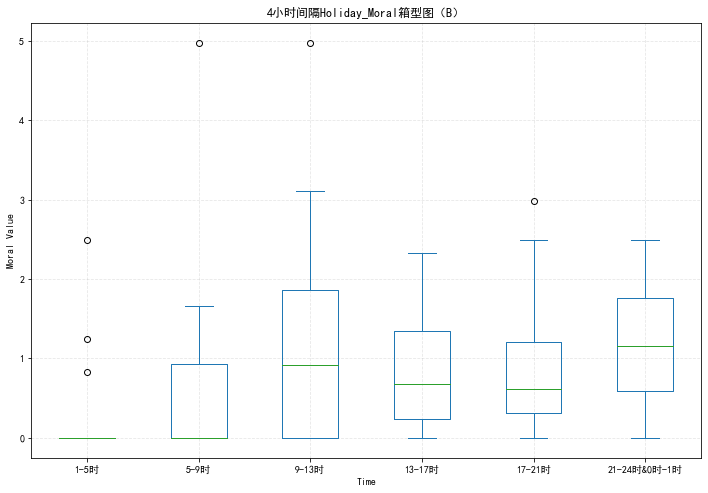

Holiday四时区，C
index:0;（2时-6时）时间区间;平均值：0.1815373563218391;方差：0.3162412791897872;标准差：0.5623533401606033
index:1;（6时-10时）时间区间;平均值：0.6508669950738916;方差：1.3054820376239276;标准差：1.142576928536511
index:2;（10时-14时）时间区间;平均值：1.3704550138723741;方差：1.5874343123008314;标准差：1.2599342491974854
index:3;（14时-18时）时间区间;平均值：0.8472371995820271;方差：0.6145202146931427;标准差：0.7839133974446046
index:4;（18时-22时）时间区间;平均值：0.8693206362771779;方差：0.6252723912596694;标准差：0.7907416716347188
index:5;（22时-24时 & 0时-2时）时间区间;平均值：1.1499835796387523;方差：0.8198274949377293;标准差：0.9054432588173206
(0, 1) (Ttest_indResult(statistic=-1.6064469980145604, pvalue=0.11645485088443407), -0.5080031454066001)
(0, 2) (Ttest_indResult(statistic=-3.756056417045409, pvalue=0.0005781226982081644), -1.1877693297954783)
(0, 3) (Ttest_indResult(statistic=-3.00771063317251, pvalue=0.004650418313008698), -0.951121614353232)
(0, 4) (Ttest_indResult(statistic=-3.089691366133807, pvalue=0.003737438548799217), -0.977046198394006)
(0, 5) (Ttest_indResult(s

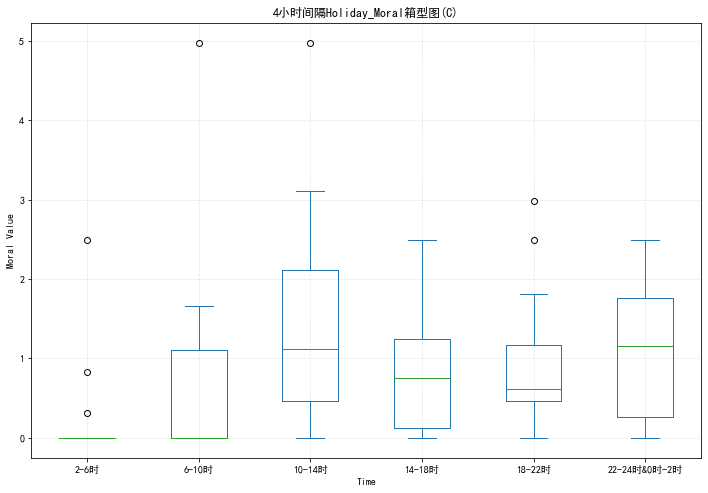

Holiday四时区，D
index:0;（3时-7时）时间区间;平均值：0.554985632183908;方差：1.435824186443057;标准差：1.1982588144649957
index:1;（7时-11时）时间区间;平均值：0.7649761904761905;方差：1.6109522429964058;标准差：1.2692329348848483
index:2;（11时-15时）时间区间;平均值：1.0696216805390406;方差：0.7310028892264492;标准差：0.8549870696252951
index:3;（15时-19时）时间区间;平均值：0.836591602363154;方差：0.6065828364724214;标准差：0.778834280493881
index:4;（19时-23时）时间区间;平均值：1.0222322433482678;方差：0.7943584453251984;标准差：0.8912678863984713
index:5;（24时 & 0时-3时）时间区间;平均值：0.8209934318555007;方差：0.7646165590175824;标准差：0.874423558132775
(0, 1) (Ttest_indResult(statistic=-0.524392262655064, pvalue=0.6030515038706032), -0.1658273937359258)
(0, 2) (Ttest_indResult(statistic=-1.5239295040375347, pvalue=0.13580628200584913), -0.4819088226289373)
(0, 3) (Ttest_indResult(statistic=-0.858909706519019, pvalue=0.39577619771170525), -0.2716110977026873)
(0, 4) (Ttest_indResult(statistic=-1.363806468784717, pvalue=0.18065316043715382), -0.43127347290310347)
(0, 5) (Ttest_indResult(statistic=

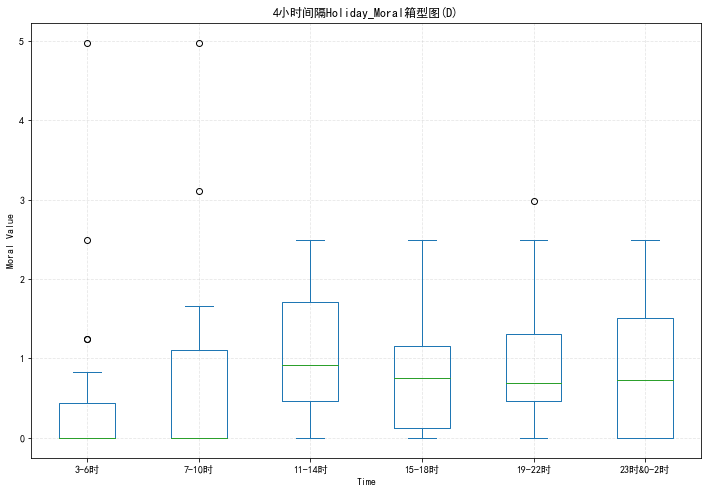

Holiday六时区，A
index:0;（0时-6时）时间区间;平均值：0.4677983032293377;方差：0.633010485807592;标准差：0.795619560975968
index:1;（6时-12时）时间区间;平均值：0.9747197591680351;方差：1.9313788190764392;标准差：1.3897405581893476
index:2;（12时-18时）时间区间;平均值：0.9376530465174937;方差：0.5906974878993942;标准差：0.7685684666309139
index:3;（18时-24时）时间区间;平均值：0.9994294115958414;方差：0.730946832407766;标准差：0.8549542867357096
(0, 1) (Ttest_indResult(statistic=-1.7046989514697575, pvalue=0.09360228532425288), -0.4401513766226411)
(0, 2) (Ttest_indResult(statistic=-2.287303104866614, pvalue=0.02584428350805075), -0.5905791221917941)
(0, 3) (Ttest_indResult(statistic=-2.45137072049313, pvalue=0.017265280302385506), -0.6329411983900244)
(1, 2) (Ttest_indResult(statistic=0.1256909356357358, pvalue=0.9004112534424046), 0.03245326003242888)
(1, 3) (Ttest_indResult(statistic=-0.08155208092431511, pvalue=0.9352836845319055), -0.021056656751228794)
(2, 3) (Ttest_indResult(statistic=-0.2893770285510338, pvalue=0.7733247761274231), -0.07471682749020946)


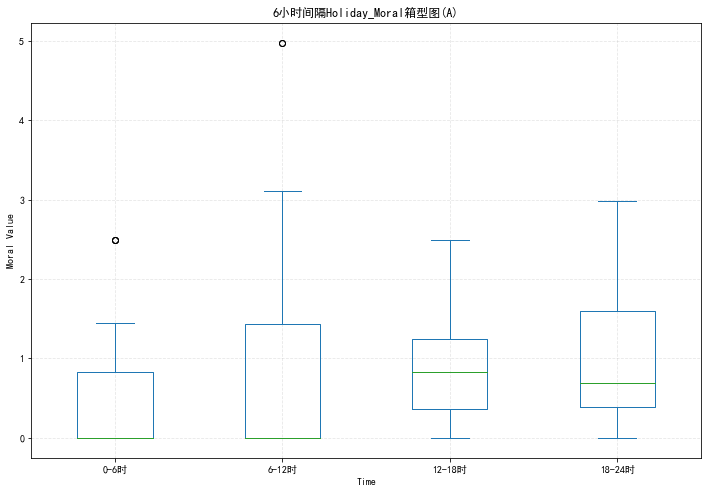

Holiday六时区，B
index:0;（1时-7时）时间区间;平均值：0.43914750957854404;方差：1.0443151213465744;标准差：1.0219173750096309
index:1;（7时-13时）时间区间;平均值：0.9318423645320199;方差：1.410564070549134;标准差：1.1876717015022014
index:2;（13时-19时）时间区间;平均值：0.8489506177202372;方差：0.585523645329637;标准差：0.7651951681300901
index:3;（19时-24时 & 0时-1时）时间区间;平均值：1.1596600286799068;方差：0.7658877728379156;标准差：0.8751501430257072
(0, 1) (Ttest_indResult(statistic=-1.6934093902849268, pvalue=0.09574244177134711), -0.4372364244589852)
(0, 2) (Ttest_indResult(statistic=-1.7286295197195352, pvalue=0.08919586240446863), -0.4463302227757523)
(0, 3) (Ttest_indResult(statistic=-2.883878124263608, pvalue=0.005503718861202664), -0.7446141298509892)
(1, 2) (Ttest_indResult(statistic=0.3159515423554231, pvalue=0.7531734852191019), 0.08157833745007341)
(1, 3) (Ttest_indResult(statistic=-0.831594986583214, pvalue=0.4090482853766969), -0.2147169022550912)
(2, 3) (Ttest_indResult(statistic=-1.4393274715818702, pvalue=0.1554331747359206), -0.3716327551450276

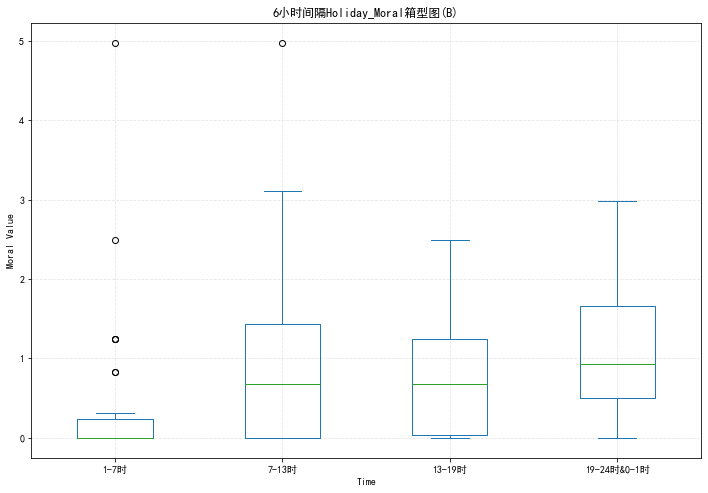

Holiday六时区，C
index:0;（2时-8时）时间区间;平均值：0.3948869731800766;方差：1.0252149192943438;标准差：1.0125289720765247
index:1;（8时-14时）时间区间;平均值：1.07368593699866;方差：1.3619733552625204;标准差：1.167036141369461
index:2;（14时-20时）时间区间;平均值：0.93212445083652;方差：0.7664105001864916;标准差：0.8754487421811122
index:3;（20时-24时 & 0时-2时）时间区间;平均值：0.9789031594954517;方差：0.6435564958575488;标准差：0.8022197304090375
(0, 1) (Ttest_indResult(statistic=-2.365902446424796, pvalue=0.021348822998303898), -0.6108733849169747)
(0, 2) (Ttest_indResult(statistic=-2.161432575684007, pvalue=0.03480221178210846), -0.5580794913049574)
(0, 3) (Ttest_indResult(statistic=-2.4345878871364572, pvalue=0.018006846518432065), -0.62860788945052)
(1, 2) (Ttest_indResult(statistic=0.5225395107657163, pvalue=0.6032850692009282), 0.1349191215287327)
(1, 3) (Ttest_indResult(statistic=0.360424134899066, pvalue=0.7198392879788424), 0.09306111146901985)
(2, 3) (Ttest_indResult(statistic=-0.21214986232268315, pvalue=0.8327339158537435), -0.054776858911729884)


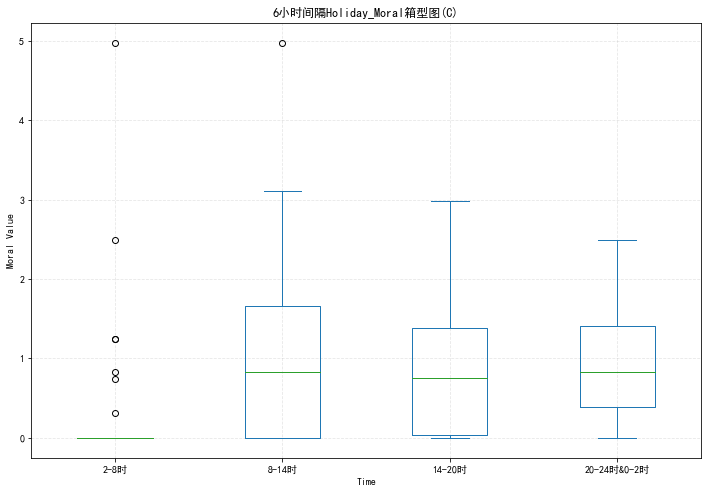

Holiday六时区，D
index:0;（3时-9时）时间区间;平均值：0.4917068965517241;方差：1.082856053893072;标准差：1.0406036968476866
index:1;（9时-15时）时间区间;平均值：1.1013487722477022;方差：1.3391108105729523;标准差：1.1571995552077232
index:2;（15时-21时）时间区间;平均值：0.9011025570215225;方差：0.6991103857820882;标准差：0.8361282113301095
index:3;（21时-24时 & 0时-3时）时间区间;平均值：0.8854422946897592;方差：0.7611839550220237;标准差：0.8724585692295215
(0, 1) (Ttest_indResult(statistic=-2.1095493569321775, pvalue=0.03922360875632613), -0.544683301826726)
(0, 2) (Ttest_indResult(statistic=-1.6515528416500715, pvalue=0.10403042543646075), -0.4264291100728174)
(0, 3) (Ttest_indResult(statistic=-1.5614147956022588, pvalue=0.12386625405725354), -0.40315556665929375)
(1, 2) (Ttest_indResult(statistic=0.755331607509801, pvalue=0.45310656473883093), 0.19502578244996904)
(1, 3) (Ttest_indResult(statistic=0.8022773771955137, pvalue=0.42566764463712525), 0.20714712806114607)
(2, 3) (Ttest_indResult(statistic=0.06978753050707989, pvalue=0.9446028335375556), 0.0180190628951241

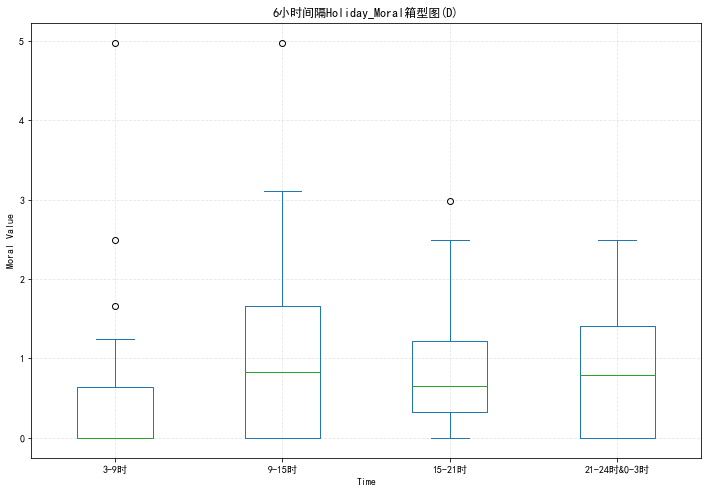

Holiday六时区，E
index:0;（4时-10时）时间区间;平均值：0.5549362342638204;方差：1.0775837584547932;标准差：1.0380673188453595
index:1;（10时-16时）时间区间;平均值：1.1693292917282216;方差：1.3482481640215185;标准差：1.161140888962885
index:2;（16时-22时）时间区间;平均值：0.8886792747594979;方差：0.6139387263074743;标准差：0.7835424215110974
index:3;（22时-24时 & 0时-4时）时间区间;平均值：0.766655719759168;方差：0.8404321596115437;标准差：0.9167508710721489
(0, 1) (Ttest_indResult(statistic=-2.124295578382267, pvalue=0.03791969711475233), -0.5484907598331049)
(0, 2) (Ttest_indResult(statistic=-1.3818863583111203, pvalue=0.17230611148345398), -0.35680152347267896)
(0, 3) (Ttest_indResult(statistic=-0.82325376451643, pvalue=0.4137359242508555), -0.21256320797831307)
(1, 2) (Ttest_indResult(statistic=1.0789315350659718, pvalue=0.2850848491826977), 0.2785789244672342)
(1, 3) (Ttest_indResult(statistic=1.4657535656376546, pvalue=0.14811606574623556), 0.37845594329058513)
(2, 3) (Ttest_indResult(statistic=0.5448852934129466, pvalue=0.5879215488801054), 0.14068877779877892)


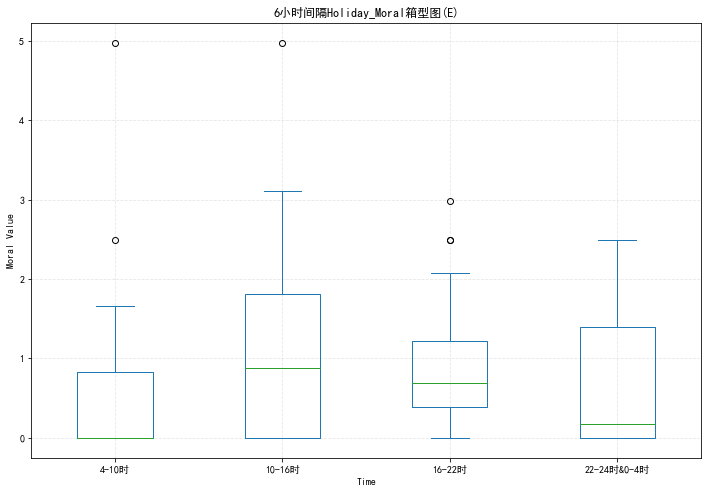

Holiday六时区，F
index:0;（5时-11时）时间区间;平均值：0.7969860426929392;方差：1.784849854078756;标准差：1.3359827297082685
index:1;（11时-17时）时间区间;平均值：1.009576418165003;方差：0.6848073103568424;标准差：0.8275308516042422
index:2;（17时-23时）时间区间;平均值：0.9427205993353052;方差：0.7544786697762382;标准差：0.8686073162115538
index:3;（23时-24时 & 0时-5时）时间区间;平均值：0.6303174603174603;方差：0.768410511248142;标准差：0.876590275583834
(0, 1) (Ttest_indResult(statistic=-0.7284911218664089, pvalue=0.46924422645384933), -0.1880955988565706)
(0, 2) (Ttest_indResult(statistic=-0.4924953081934857, pvalue=0.6242284580643869), -0.1271617417812439)
(0, 3) (Ttest_indResult(statistic=0.5617009890601102, pvalue=0.5764839408406395), 0.14503057174520273)
(1, 2) (Ttest_indResult(statistic=0.3000990797871393, pvalue=0.7651745514866304), 0.07748524921518407)
(1, 3) (Ttest_indResult(statistic=1.6942187690499346, pvalue=0.09558768216459898), 0.437445405157495)
(2, 3) (Ttest_indResult(statistic=1.363264850434818, pvalue=0.1780678511179758), 0.3519934708135996)


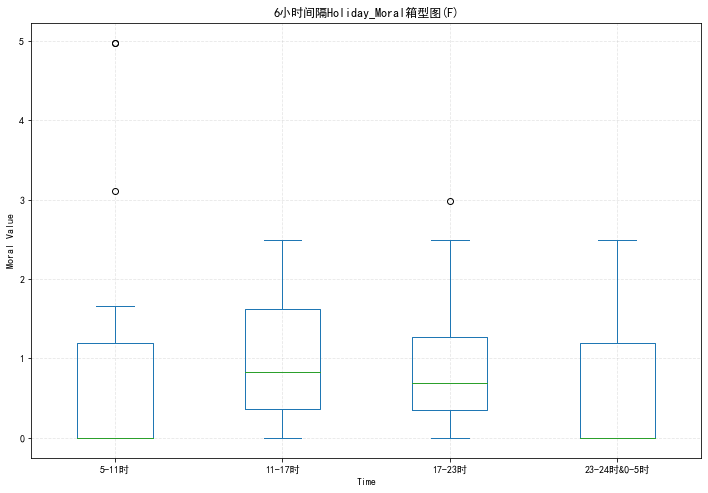

In [9]:
# 五、（四）holiday数据
# （1）平均值，方差，标准差【moral,score_communion,score_agency】
# Moral
holiday_moral_avg,holiday_moral_var,holiday_moral_std = get_mean_score(holiday_moral)
print_mean_score("holiday_moral",holiday_moral_avg,holiday_moral_var,holiday_moral_std)
# Score_communion
holiday_score_communion_avg,holiday_score_communion_var,holiday_score_communion_std = get_mean_score(holiday_score_communion)
print_mean_score("holiday_score_communion",holiday_score_communion_avg,holiday_score_communion_var,holiday_score_communion_std)
# Score_agency
holiday_score_agency_avg,holiday_score_agency_var,holiday_score_agency_std = get_mean_score(holiday_score_agency)
print_mean_score("holiday_score_agency",holiday_score_agency_avg,holiday_score_agency_var,holiday_score_agency_std)
# （2）单样本T检验（005置信【1.711】，001置信【2.492】）
holiday_moral_005,holiday_moral_001 = get_t_sigle(holiday_moral)
print_t_sigle("holiday_moral",holiday_moral_005,holiday_moral_001)
# Score_communion
holiday_score_communion_005,holiday_score_communion_001 = get_t_sigle(holiday_score_communion)
print_t_sigle("holiday_score_communion",holiday_score_communion_005,holiday_score_communion_001)
# Score_agency
holiday_score_agency_005,holiday_score_agency_001 = get_t_sigle(holiday_score_agency)
print_t_sigle("holiday_score_agency",holiday_score_agency_005,holiday_score_agency_001)
# （3）相关性检验（pearsonr,spear,kendall）
# Moral与评论条数
holiday_moral_sentnum_pearson,holiday_moral_sentnum_spear,holiday_moral_sentnum_kendall = get_correlation(holiday_moral,holiday_sentnum)
print_correlation("holiday_moral","评论条数",holiday_moral_sentnum_pearson,holiday_moral_sentnum_spear,holiday_moral_sentnum_kendall)
# Moral受评论条数影响率（不可用，holiday_sentnum存在0值）
#holiday_moral_sentnum_rate = [a/b for a,b in zip(holiday_moral,holiday_sentnum)]
#print(holiday_moral_sentnum_rate)
# Moral与切分词总数
holiday_moral_words_pearson,holiday_moral_words_spear,holiday_moral_words_kendall = get_correlation(holiday_moral,holiday_all_words)
print_correlation("holiday_moral","切分词总数",holiday_moral_words_pearson,holiday_moral_words_spear,holiday_moral_words_kendall)
# Moral受切分词总数影响率（不可用，holiday_sentnum存在0值）
#holiday_moral_allwords_rate = [a/b for a,b in zip(holiday_moral,holiday_all_words)]
#print(holiday_moral_allwords_rate)

# （4） 拆分时间区间——holiday_moral
#********************************************************************************************
# Moral——三时区（A，B，C）
#********************************************************************************************
print('Holiday三时区，A')
# A(0时开始)
# 时间区间——0时-3时（moral）
holiday_moral_time3a_am1 = holiday_moral[0:15]
#print("3a-am1",holiday_moral_time3a_am1)
# 时间区间——3时-6时（moral）
holiday_moral_time3a_am2 = holiday_moral[15:30]
#print("3a-am2",holiday_moral_time3a_am2)
# 时间区间——6时-9时（moral）
holiday_moral_time3a_am3 = holiday_moral[30:45]
#print("3a-am3",holiday_moral_time3a_am3)
# 时间区间——9时-12时（moral）
holiday_moral_time3a_am4 = holiday_moral[45:60]
#print("3a-am4",holiday_moral_time3a_am4)
# 时间区间——12时-15时（moral）
holiday_moral_time3a_pm1 = holiday_moral[60:75]
#print("3a-pm1",holiday_moral_time3a_pm1)
# 时间区间——15时-18时（moral）
holiday_moral_time3a_pm2 = holiday_moral[75:90]
#print("3a-pm2",holiday_moral_time3a_pm2)
# 时间区间——18时-21时（moral）
holiday_moral_time3a_pm3 = holiday_moral[90:105]
#print("3a-pm3",holiday_moral_time3a_pm3)
# 时间区间——21时-24时（moral）
holiday_moral_time3a_pm4 = holiday_moral[105:120]
#print("3a-pm4",holiday_moral_time3a_pm4)

# 构建列表嵌套的时间区间数据集
holiday_moral_time3a = [holiday_moral_time3a_am1,holiday_moral_time3a_am2,holiday_moral_time3a_am3,holiday_moral_time3a_am4,
                          holiday_moral_time3a_pm1,holiday_moral_time3a_pm2,holiday_moral_time3a_pm3,holiday_moral_time3a_pm4]



for i,j in enumerate(holiday_moral_time3a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（3时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（6时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（9时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（12时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（15时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（18时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（21时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
        
# 时间区间的两两交叉T检验
holiday_moral_time3a_2crosscheck = get_2crosscheck_t_double(holiday_moral_time3a)
for i,j in holiday_moral_time3a_2crosscheck.items():
    print(i,j)

holiday_name_list_3a = ['0-3时','3-6时','6-9时','9-12时','12-15时','15-18时','18-21时','21-24时']
holiday_box_graph3a = get_boxgraph(holiday_name_list_3a,'Time','Moral Value','3小时间隔Holiday_moral箱型图(A)',
                           holiday_moral_time3a_am1,holiday_moral_time3a_am2,holiday_moral_time3a_am3,holiday_moral_time3a_am4,
                          holiday_moral_time3a_pm1,holiday_moral_time3a_pm2,holiday_moral_time3a_pm3,holiday_moral_time3a_pm4)
#********************************************************************************************

print('Holiday三时区，B')
# B(1时开始)
# 时间区间——1时-4时（moral）
holiday_moral_time3b_am1 = holiday_moral[5:20]
#print("3b-am1",holiday_moral_time3b_am1)
# 时间区间——4时-7时（moral）
holiday_moral_time3b_am2 = holiday_moral[20:35]
#print("3b-am2",holiday_moral_time3b_am2)
# 时间区间——7时-10时（moral）
holiday_moral_time3b_am3 = holiday_moral[35:50]
#print("3b-am3",holiday_moral_time3b_am3)
# 时间区间——10时-13时（moral）
holiday_moral_time3b_am4 = holiday_moral[50:65]
#print("3b-am4",holiday_moral_time3b_am4)
# 时间区间——13时-16时（moral）
holiday_moral_time3b_pm1 = holiday_moral[65:80]
#print("3b-pm1",holiday_moral_time3b_pm1)
# 时间区间——16时-19时（moral）
holiday_moral_time3b_pm2 = holiday_moral[80:95]
#print("3b-pm2",holiday_moral_time3b_pm2)
# 时间区间——19时-22时（moral）
holiday_moral_time3b_pm3 = holiday_moral[95:110]
#print("3b-pm3",holiday_moral_time3b_pm3)
# 时间区间——22时-24时-0时（moral）
holiday_moral_time3b_pm4 = holiday_moral[110:120]+holiday_moral[0:5]
#print("3b-pm4",holiday_moral_time3b_pm4)

# 构建列表嵌套的时间区间数据集
holiday_moral_time3b = [holiday_moral_time3b_am1,holiday_moral_time3b_am2,holiday_moral_time3b_am3,holiday_moral_time3b_am4,
                          holiday_moral_time3b_pm1,holiday_moral_time3b_pm2,holiday_moral_time3b_pm3,holiday_moral_time3b_pm4]



for i,j in enumerate(holiday_moral_time3b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（7时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（10时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（13时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（16时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（19时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（22时-24时 & 0时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
holiday_moral_time3b_2crosscheck = get_2crosscheck_t_double(holiday_moral_time3b)
for i,j in holiday_moral_time3b_2crosscheck.items():
    print(i,j)
    
holiday_name_list_3b = ['1-4时','4-7时','7-10时','10-13时','13-16时','16-19时','19-22时','22-24时&0时']
holiday_box_graph3b = get_boxgraph(holiday_name_list_3b,'Time','Moral Value','3小时间隔Holiday_moral箱型图(B)',
                           holiday_moral_time3b_am1,holiday_moral_time3b_am2,holiday_moral_time3b_am3,holiday_moral_time3b_am4,
                          holiday_moral_time3b_pm1,holiday_moral_time3b_pm2,holiday_moral_time3b_pm3,holiday_moral_time3b_pm4)

#********************************************************************************************
print('Holiday三时区，C')
# 时间区间——2时-5时（moral）
holiday_moral_time3c_am1 = holiday_moral[10:25]
#print("3c-am1",holiday_moral_time3c_am1)
# 时间区间——5时-8时（moral）
holiday_moral_time3c_am2 = holiday_moral[25:40]
#print("3c-am2",holiday_moral_time3c_am2)
# 时间区间——8时-11时（moral）
holiday_moral_time3c_am3 = holiday_moral[40:55]
#print("3c-am3",holiday_moral_time3c_am3)
# 时间区间——11时-14时（moral）
holiday_moral_time3c_am4 = holiday_moral[55:70]
#print("3c-am4",holiday_moral_time3c_am4)
# 时间区间——14时-17时（moral）
holiday_moral_time3c_pm1 = holiday_moral[70:85]
#print("3c-pm1",holiday_moral_time3c_pm1)
# 时间区间——17时-20时（moral）
holiday_moral_time3c_pm2 = holiday_moral[85:100]
#print("3c-pm2",holiday_moral_time3c_pm2)
# 时间区间——20时-23时（moral）
holiday_moral_time3c_pm3 = holiday_moral[100:115]
#print("3c-pm3",holiday_moral_time3c_pm3)
# 时间区间——24时+0-1时（moral）
holiday_moral_time3c_pm4 = holiday_moral[115:120]+holiday_moral[0:10]
#print("3c-pm4",holiday_moral_time3c_pm4)

# 构建列表嵌套的时间区间数据集
holiday_moral_time3c = [holiday_moral_time3c_am1,holiday_moral_time3c_am2,holiday_moral_time3c_am3,holiday_moral_time3c_am4,
                          holiday_moral_time3c_pm1,holiday_moral_time3c_pm2,holiday_moral_time3c_pm3,holiday_moral_time3c_pm4]



for i,j in enumerate(holiday_moral_time3c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（11时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（14时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（17时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（20时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
holiday_moral_time3c_2crosscheck = get_2crosscheck_t_double(holiday_moral_time3c)
for i,j in holiday_moral_time3c_2crosscheck.items():
    print(i,j)

holiday_name_list_3c = ['2-5时','5-8时','8-11时','11-14时','14-17时','17-20时','20-23时','24时&0-1时']
holiday_box_graph3c = get_boxgraph(holiday_name_list_3c,'Time','Moral Value','3小时间隔Holiday_moral箱型图(C)',
                           holiday_moral_time3c_am1,holiday_moral_time3c_am2,holiday_moral_time3c_am3,holiday_moral_time3c_am4,
                          holiday_moral_time3c_pm1,holiday_moral_time3c_pm2,holiday_moral_time3c_pm3,holiday_moral_time3c_pm4)

#********************************************************************************************
# Moral——四时区（A，B，C，D）
#********************************************************************************************
print('Holiday四时区，A')
# 时间区间——0时-4时（moral）
holiday_moral_time4a_am1 = holiday_moral[0:20]
#print("4a-am1",holiday_moral_time4a_am1)
# 时间区间——4时-8时（moral）
holiday_moral_time4a_am2 = holiday_moral[20:40]
#print("4a-am2",holiday_moral_time4a_am2)
# 时间区间——8时-12时（moral）
holiday_moral_time4a_am3 = holiday_moral[40:60]
#print("4a-am3",holiday_moral_time4a_am3)
# 时间区间——12时-16时（moral）
holiday_moral_time4a_pm1 = holiday_moral[60:80]
#print("4a-pm1",holiday_moral_time4a_pm1)
# 时间区间——16时-20时（moral）
holiday_moral_time4a_pm2 = holiday_moral[80:100]
#print("4a-pm2",holiday_moral_time4a_pm2)
# 时间区间——20时-24时（moral）
holiday_moral_time4a_pm3 = holiday_moral[100:120]
#print("4a-pm3",holiday_moral_time4a_pm3)

# 构建列表嵌套的时间区间数据集
holiday_moral_time4a = [holiday_moral_time4a_am1,holiday_moral_time4a_am2,holiday_moral_time4a_am3,
                          holiday_moral_time4a_pm1,holiday_moral_time4a_pm2,holiday_moral_time4a_pm3]



for i,j in enumerate(holiday_moral_time4a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（12时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（16时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（20时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time4a_2crosscheck = get_2crosscheck_t_double(holiday_moral_time4a)
for i,j in holiday_moral_time4a_2crosscheck.items():
    print(i,j)

holiday_name_list_4a = ['0-4时','4-8时','8-12时','12-16时','16-20时','20-24时']
holiday_box_graph4a = get_boxgraph(holiday_name_list_4a,'Time','Moral Value','4小时间隔Holiday_Moral箱型图（A）',
                           holiday_moral_time4a_am1,holiday_moral_time4a_am2,holiday_moral_time4a_am3,
                          holiday_moral_time4a_pm1,holiday_moral_time4a_pm2,holiday_moral_time4a_pm3)
#********************************************************************************************
print('Holiday四时区，B')
# 时间区间——1时-5时（moral）
holiday_moral_time4b_am1 = holiday_moral[5:25]
#print("4b-am1",holiday_moral_time4b_am1)
# 时间区间——5时-9时（moral）
holiday_moral_time4b_am2 = holiday_moral[25:45]
#print("4b-am2",holiday_moral_time4b_am2)
# 时间区间——9时-13时（moral）
holiday_moral_time4b_am3 = holiday_moral[45:65]
#print("4b-am3",holiday_moral_time4b_am3)
# 时间区间——13时-17时（moral）
holiday_moral_time4b_pm1 = holiday_moral[65:85]
#print("4b-pm1",holiday_moral_time4b_pm1)
# 时间区间——17时-21时（moral）
holiday_moral_time4b_pm2 = holiday_moral[85:105]
#print("4b-pm2",holiday_moral_time4b_pm2)
# 时间区间——21时-24时 & 0时（moral）
holiday_moral_time4b_pm3 = holiday_moral[105:120] + holiday_moral[0:5]
#print("4b-pm3",holiday_moral_time4b_pm3)

# 构建列表嵌套的时间区间数据集
holiday_moral_time4b = [holiday_moral_time4b_am1,holiday_moral_time4b_am2,holiday_moral_time4b_am3,
                          holiday_moral_time4b_pm1,holiday_moral_time4b_pm2,holiday_moral_time4b_pm3]



for i,j in enumerate(holiday_moral_time4b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（9时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（13时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（17时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（21时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time4b_2crosscheck = get_2crosscheck_t_double(holiday_moral_time4b)
for i,j in holiday_moral_time4b_2crosscheck.items():
    print(i,j)

holiday_name_list_4b = ['1-5时','5-9时','9-13时','13-17时','17-21时','21-24时&0时-1时']
holiday_box_graph4b = get_boxgraph(holiday_name_list_4b,'Time','Moral Value','4小时间隔Holiday_Moral箱型图（B）',
                           holiday_moral_time4b_am1,holiday_moral_time4b_am2,holiday_moral_time4b_am3,
                          holiday_moral_time4b_pm1,holiday_moral_time4b_pm2,holiday_moral_time4b_pm3)
#********************************************************************************************
print('Holiday四时区，C')
# 时间区间——2时-6时（moral）
holiday_moral_time4c_am1 = holiday_moral[10:30]
#print("4c-am1",holiday_moral_time4c_am1)
# 时间区间——6时-10时（moral）
holiday_moral_time4c_am2 = holiday_moral[30:50]
#print("4c-am2",holiday_moral_time4c_am2)
# 时间区间——10时-14时（moral）
holiday_moral_time4c_am3 = holiday_moral[50:70]
#print("4c-am3",holiday_moral_time4c_am3)
# 时间区间——14时-18时（moral）
holiday_moral_time4c_pm1 = holiday_moral[70:90]
#print("4c-pm1",holiday_moral_time4c_pm1)
# 时间区间——18时-22时（moral）
holiday_moral_time4c_pm2 = holiday_moral[90:110]
#print("4c-pm2",holiday_moral_time4c_pm2)
# 时间区间——22时-24时 & 0时-2时（moral）
holiday_moral_time4c_pm3 = holiday_moral[110:120] + holiday_moral[0:10]
#print("4c-pm3",holiday_moral_time4c_pm3)

# 构建列表嵌套的时间区间数据集
holiday_moral_time4c = [holiday_moral_time4c_am1,holiday_moral_time4c_am2,holiday_moral_time4c_am3,
                          holiday_moral_time4c_pm1,holiday_moral_time4c_pm2,holiday_moral_time4c_pm3]



for i,j in enumerate(holiday_moral_time4c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（10时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（14时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（18时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（22时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time4c_2crosscheck = get_2crosscheck_t_double(holiday_moral_time4c)
for i,j in holiday_moral_time4c_2crosscheck.items():
    print(i,j)

holiday_name_list_4c = ['2-6时','6-10时','10-14时','14-18时','18-22时','22-24时&0时-2时']
holiday_box_graph4c = get_boxgraph(holiday_name_list_4c,'Time','Moral Value','4小时间隔Holiday_Moral箱型图(C)',
                           holiday_moral_time4c_am1,holiday_moral_time4c_am2,holiday_moral_time4c_am3,
                          holiday_moral_time4c_pm1,holiday_moral_time4c_pm2,holiday_moral_time4c_pm3)
#********************************************************************************************
print('Holiday四时区，D')
# 时间区间——3时-7时（moral）
holiday_moral_time4d_am1 = holiday_moral[15:35]
#print("4d-am1",holiday_moral_time4d_am1)
# 时间区间——7时-11时（moral）
holiday_moral_time4d_am2 = holiday_moral[35:55]
#print("4d-am2",holiday_moral_time4d_am2)
# 时间区间——11时-15时（moral）
holiday_moral_time4d_am3 = holiday_moral[55:75]
#print("4d-am3",holiday_moral_time4d_am3)
# 时间区间——15时-19时（moral）
holiday_moral_time4d_pm1 = holiday_moral[75:95]
#print("4d-pm1",holiday_moral_time4d_pm1)
# 时间区间——19时-23时（moral）
holiday_moral_time4d_pm2 = holiday_moral[95:115]
#print("4d-pm2",holiday_moral_time4d_pm2)
# 时间区间——24时 & 0时-3时（moral）
holiday_moral_time4d_pm3 = holiday_moral[115:120] + holiday_moral[0:15]
#print("4d-pm3",holiday_moral_time4d_pm3)
# 构建列表嵌套的时间区间数据集
holiday_moral_time4d = [holiday_moral_time4d_am1,holiday_moral_time4d_am2,holiday_moral_time4d_am3,
                          holiday_moral_time4d_pm1,holiday_moral_time4d_pm2,holiday_moral_time4d_pm3]



for i,j in enumerate(holiday_moral_time4d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（11时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（15时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（19时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time4d_2crosscheck = get_2crosscheck_t_double(holiday_moral_time4d)
for i,j in holiday_moral_time4d_2crosscheck.items():
    print(i,j)
    
holiday_name_list_4d = ['3-6时','7-10时','11-14时','15-18时','19-22时','23时&0-2时']
holiday_box_graph4d = get_boxgraph(holiday_name_list_4d,'Time','Moral Value','4小时间隔Holiday_Moral箱型图(D)',
                           holiday_moral_time4d_am1,holiday_moral_time4d_am2,holiday_moral_time4d_am3,
                          holiday_moral_time4d_pm1,holiday_moral_time4d_pm2,holiday_moral_time4d_pm3)

#********************************************************************************************
# Moral——六时区（A，B，C，D，E，F）
#********************************************************************************************
print('Holiday六时区，A')
# 时间区间——0时-6时（moral）
holiday_moral_time6a_am1 = holiday_moral[0:30]
#print("6a-am1",holiday_moral_time6a_am1)
# 时间区间——6时-12时（moral）
holiday_moral_time6a_am2 = holiday_moral[30:60]
#print("6a-am2",holiday_moral_time6a_am2)
# 时间区间——12时-18时（moral）
holiday_moral_time6a_pm1 = holiday_moral[60:90]
#print("6a-pm1",holiday_moral_time6a_pm1)
# 时间区间——18时-24时（moral）
holiday_moral_time6a_pm2 = holiday_moral[90:120]
#print("6a-pm2",holiday_moral_time6a_pm2)

# 构建列表嵌套的时间区间数据集
holiday_moral_time6a = [holiday_moral_time6a_am1,holiday_moral_time6a_am2,
                    holiday_moral_time6a_pm1,holiday_moral_time6a_pm2]



for i,j in enumerate(holiday_moral_time6a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（12时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（18时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time6a_2crosscheck = get_2crosscheck_t_double(holiday_moral_time6a)
for i,j in holiday_moral_time6a_2crosscheck.items():
    print(i,j)

holiday_name_list_6a = ['0-6时','6-12时','12-18时','18-24时']
holiday_box_graph6a = get_boxgraph(holiday_name_list_6a,'Time','Moral Value','6小时间隔Holiday_Moral箱型图(A)',
                           holiday_moral_time6a_am1,holiday_moral_time6a_am2,
                          holiday_moral_time6a_pm1,holiday_moral_time6a_pm2)
#********************************************************************************************
print('Holiday六时区，B')
# 时间区间——1时-7时（moral）
holiday_moral_time6b_am1 = holiday_moral[5:35]
#print("6b-am1",holiday_moral_time6b_am1)
# 时间区间——7时-13时（moral）
holiday_moral_time6b_am2 = holiday_moral[35:65]
#print("6b-am2",holiday_moral_time6b_am2)
# 时间区间——13时-19时（moral）
holiday_moral_time6b_pm1 = holiday_moral[65:95]
#print("6b-pm1",holiday_moral_time6b_pm1)
# 时间区间——19时-24时&0时-1时（moral）
holiday_moral_time6b_pm2 = holiday_moral[95:120]+holiday_moral[0:5]
#print("6b-pm2",holiday_moral_time6b_pm2)
# 构建列表嵌套的时间区间数据集
holiday_moral_time6b = [holiday_moral_time6b_am1,holiday_moral_time6b_am2,
                    holiday_moral_time6b_pm1,holiday_moral_time6b_pm2]



for i,j in enumerate(holiday_moral_time6b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（13时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（19时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time6b_2crosscheck = get_2crosscheck_t_double(holiday_moral_time6b)
for i,j in holiday_moral_time6b_2crosscheck.items():
    print(i,j)
    
holiday_name_list_6b = ['1-7时','7-13时','13-19时','19-24时&0-1时']
holiday_box_graph6b = get_boxgraph(holiday_name_list_6b,'Time','Moral Value','6小时间隔Holiday_Moral箱型图(B)',
                           holiday_moral_time6b_am1,holiday_moral_time6b_am2,
                          holiday_moral_time6b_pm1,holiday_moral_time6b_pm2)
#********************************************************************************************
print('Holiday六时区，C')
# 时间区间——2时-8时（moral）
holiday_moral_time6c_am1 = holiday_moral[10:40]
#print("6c-am1",holiday_moral_time6c_am1)
# 时间区间——8时-14时（moral）
holiday_moral_time6c_am2 = holiday_moral[40:70]
#print("6c-am2",holiday_moral_time6c_am2)
# 时间区间——14时-20时（moral）
holiday_moral_time6c_pm1 = holiday_moral[70:100]
#print("6c-pm1",holiday_moral_time6c_pm1)
# 时间区间——20时-24时&0时-2时（moral）
holiday_moral_time6c_pm2 = holiday_moral[100:120]+holiday_moral[0:10]
#print("6c-pm2",holiday_moral_time6c_pm2)
# 构建列表嵌套的时间区间数据集
holiday_moral_time6c = [holiday_moral_time6c_am1,holiday_moral_time6c_am2,
                    holiday_moral_time6c_pm1,holiday_moral_time6c_pm2]



for i,j in enumerate(holiday_moral_time6c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（8时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（14时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（20时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time6c_2crosscheck = get_2crosscheck_t_double(holiday_moral_time6c)
for i,j in holiday_moral_time6c_2crosscheck.items():
    print(i,j)

holiday_name_list_6c = ['2-8时','8-14时','14-20时','20-24时&0-2时']
holiday_box_graph6c = get_boxgraph(holiday_name_list_6c,'Time','Moral Value','6小时间隔Holiday_Moral箱型图(C)',
                           holiday_moral_time6c_am1,holiday_moral_time6c_am2,
                          holiday_moral_time6c_pm1,holiday_moral_time6c_pm2)

#********************************************************************************************
print('Holiday六时区，D')
# 时间区间——3时-9时（moral）
holiday_moral_time6d_am1 = holiday_moral[15:45]
#print("6d-am1",holiday_moral_time6d_am1)
# 时间区间——9时-15时（moral）
holiday_moral_time6d_am2 = holiday_moral[45:75]
#print("6d-am2",holiday_moral_time6d_am2)
# 时间区间——15时-21时（moral）
holiday_moral_time6d_pm1 = holiday_moral[75:105]
#print("6d-pm1",holiday_moral_time6d_pm1)
# 时间区间——21时-24时&0时-3时（moral）
holiday_moral_time6d_pm2 = holiday_moral[105:120]+holiday_moral[0:15]
#print("6d-pm2",holiday_moral_time6d_pm2)

# 构建列表嵌套的时间区间数据集
holiday_moral_time6d = [holiday_moral_time6d_am1,holiday_moral_time6d_am2,
                    holiday_moral_time6d_pm1,holiday_moral_time6d_pm2]



for i,j in enumerate(holiday_moral_time6d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（9时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（15时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（21时-24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time6d_2crosscheck = get_2crosscheck_t_double(holiday_moral_time6d)
for i,j in holiday_moral_time6d_2crosscheck.items():
    print(i,j)

holiday_name_list_6d = ['3-9时','9-15时','15-21时','21-24时&0-3时']
holiday_box_graph6d = get_boxgraph(holiday_name_list_6d,'Time','Moral Value','6小时间隔Holiday_Moral箱型图(D)',
                           holiday_moral_time6d_am1,holiday_moral_time6d_am2,
                          holiday_moral_time6d_pm1,holiday_moral_time6d_pm2)

#********************************************************************************************
print('Holiday六时区，E')
# 时间区间——4时-10时（moral）
holiday_moral_time6e_am1 = holiday_moral[20:50]
#print("6e-am1",holiday_moral_time6e_am1)
# 时间区间——10时-16时（moral）
holiday_moral_time6e_am2 = holiday_moral[50:80]
#print("6e-am2",holiday_moral_time6e_am2)
# 时间区间——16时-22时（moral）
holiday_moral_time6e_pm1 = holiday_moral[80:110]
#print("6e-pm1",holiday_moral_time6e_pm1)
# 时间区间——22时-24时&0时-4时（moral）
holiday_moral_time6e_pm2 = holiday_moral[110:120]+holiday_moral[0:20]
#print("6e-pm2",holiday_moral_time6e_pm2)
# 构建列表嵌套的时间区间数据集
holiday_moral_time6e = [holiday_moral_time6e_am1,holiday_moral_time6e_am2,
                    holiday_moral_time6e_pm1,holiday_moral_time6e_pm2]



for i,j in enumerate(holiday_moral_time6e):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（4时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（10时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（16时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（22时-24时 & 0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time6e_2crosscheck = get_2crosscheck_t_double(holiday_moral_time6e)
for i,j in holiday_moral_time6e_2crosscheck.items():
    print(i,j)

holiday_name_list_6e = ['4-10时','10-16时','16-22时','22-24时&0-4时']
holiday_box_graph6e = get_boxgraph(holiday_name_list_6e,'Time','Moral Value','6小时间隔Holiday_Moral箱型图(E)',
                           holiday_moral_time6e_am1,holiday_moral_time6e_am2,
                          holiday_moral_time6e_pm1,holiday_moral_time6e_pm2)

#********************************************************************************************
print('Holiday六时区，F')

# 时间区间——5时-11时（moral）
holiday_moral_time6f_am1 = holiday_moral[25:55]
#print("6f-am1",holiday_moral_time6f_am1)
# 时间区间——11时-17时（moral）
holiday_moral_time6f_am2 = holiday_moral[55:85]
#print("6f-am2",holiday_moral_time6f_am2)
# 时间区间——17时-23时（moral）
holiday_moral_time6f_pm1 = holiday_moral[85:115]
#print("6f-pm1",holiday_moral_time6f_pm1)
# 时间区间——23时-24时&0时-5时（moral）
holiday_moral_time6f_pm2 = holiday_moral[115:120]+holiday_moral[0:25]
#print("6f-pm2",holiday_moral_time6f_pm2)
# 构建列表嵌套的时间区间数据集
holiday_moral_time6f = [holiday_moral_time6f_am1,holiday_moral_time6f_am2,
                    holiday_moral_time6f_pm1,holiday_moral_time6f_pm2]



for i,j in enumerate(holiday_moral_time6f):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（5时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（11时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（17时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（23时-24时 & 0时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
holiday_moral_time6f_2crosscheck = get_2crosscheck_t_double(holiday_moral_time6f)
for i,j in holiday_moral_time6f_2crosscheck.items():
    print(i,j)
    
holiday_name_list_6f = ['5-11时','11-17时','17-23时','23-24时&0-5时']
holiday_box_graph6f = get_boxgraph(holiday_name_list_6f,'Time','Moral Value','6小时间隔Holiday_Moral箱型图(F)',
                           holiday_moral_time6f_am1,holiday_moral_time6f_am2,
                          holiday_moral_time6f_pm1,holiday_moral_time6f_pm2)



weekend_holiday_moral，
平均值：0.9214128401221767；
方差：0.7783457326479496；
标准差：0.8822390450710904
weekend_holiday_score_communion，
平均值：0.040948275862068964；
方差：0.004729656800294434；
标准差：0.06877250032021835
weekend_holiday_score_agency，
平均值：0.03936650837620367；
方差：0.004268272395520108；
标准差：0.06533201661911339
weekend_holiday_moral,单边T检验：
005置信：Ttest_1sampResult(statistic=-11.565703075247992, pvalue=4.241399279482885e-23)；
001置信：Ttest_1sampResult(statistic=-23.0056232775552, pvalue=1.1861866855398554e-53)
weekend_holiday_score_communion,单边T检验：
005置信：Ttest_1sampResult(statistic=-313.8147436086641, pvalue=2.4056318725187774e-233)；
001置信：Ttest_1sampResult(statistic=-460.57026693527246, pvalue=3.872334805233413e-261)
weekend_holiday_score_agency,单边T检验：
005置信：Ttest_1sampResult(statistic=-330.6535847809875, pvalue=3.948255696577807e-237)；
001置信：Ttest_1sampResult(statistic=-485.1374779357608, pvalue=6.633784133440053e-265)
weekend_holiday_moral与评论条数相关性检验：
Pearson：(-0.08149240829812235, 0.29366114512

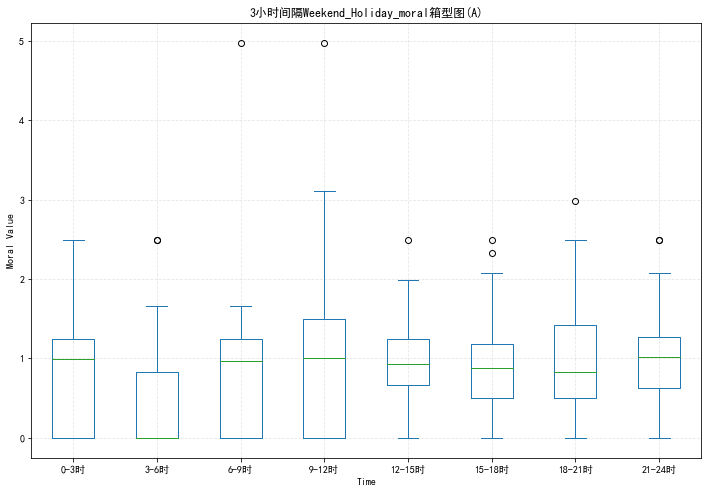

Weekend_Holiday三时区，B
index:0;（1时-4时）时间区间;平均值：0.48852297606607953;方差：0.4183004798666156;标准差：0.6467615324573777
index:1;（4时-7时）时间区间;平均值：0.8642095550864025;方差：1.4494381028441596;标准差：1.2039261201768818
index:2;（7时-10时）时间区间;平均值：0.5853922710649572;方差：0.34656563181614813;标准差：0.58869825192211
index:3;（10时-13时）时间区间;平均值：1.341232177378866;方差：1.421608597954344;标准差：1.1923122904484145
index:4;（13时-16时）时间区间;平均值：0.8970596434879179;方差：0.4581065592682484;标准差：0.6768356959175901
index:5;（16时-19时）时间区间;平均值：0.8912671755717982;方差：0.41567654882620303;标准差：0.6447298262266165
index:6;（19时-22时）时间区间;平均值：1.013144450296428;方差：0.5110271992133141;标准差：0.7148616643892118
index:7;（22时-24时 & 0时）时间区间;平均值：1.290474472024965;方差：0.5800957766835889;标准差：0.7616401884640732
(0, 1) (Ttest_indResult(statistic=-1.2293700634296132, pvalue=0.22611583404061122), -0.37939183826059747)
(0, 2) (Ttest_indResult(statistic=-0.49534573401648757, pvalue=0.6230665040204117), -0.15286701229635077)
(0, 3) (Ttest_indResult(statistic=-2.8113684458112

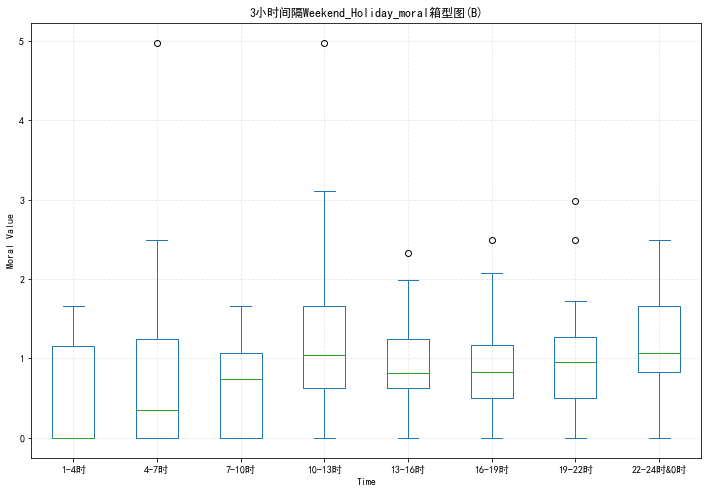

Weekend_Holiday三时区，C
index:0;（2时-5时）时间区间;平均值：0.53929698107038;方差：0.7405650395022175;标准差：0.8605608865746907
index:1;（5时-8时）时间区间;平均值：0.7682364532019703;方差：1.199176387593425;标准差：1.095069124573159
index:2;（8时-11时）时间区间;平均值：0.9955625562927137;方差：1.3967241554412018;标准差：1.1818308489124836
index:3;（11时-14时）时间区间;平均值：1.0977845566186732;方差：0.5709841462305972;标准差：0.7556349292023213
index:4;（14时-17时）时间区间;平均值：0.9205923144592402;方差：0.4318815405866995;标准差：0.657176947698791
index:5;（17时-20时）时间区间;平均值：1.0233939236853646;方差：0.6978661150099076;标准差：0.8353838129925116
index:6;（20时-23时）时间区间;平均值：0.9272051904774394;方差：0.4221284443742574;标准差：0.6497141251152366
index:7;（24时 & 0时-1时）时间区间;平均值：1.0992307451716319;方差：0.519305761062477;标准差：0.7206287262262565
(0, 1) (Ttest_indResult(statistic=-0.735129336649936, pvalue=0.4665492351440659), -0.22686583860099108)
(0, 2) (Ttest_indResult(statistic=-1.3957288503826395, pvalue=0.1704960128128157), -0.4307312745055612)
(0, 3) (Ttest_indResult(statistic=-2.1809023614516803, pva

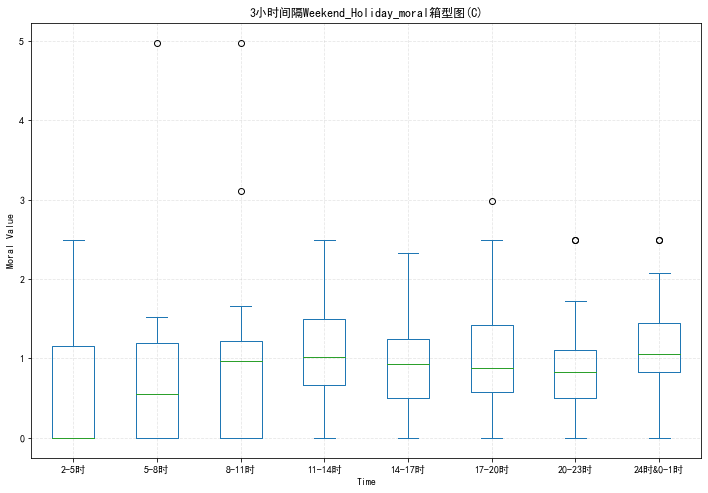

Weekend_Holiday四时区，A
index:0;（0时-4时）时间区间;平均值：0.7484939649841128;方差：0.6186913469529705;标准差：0.7865693529199892
index:1;（4时-8时）时间区间;平均值：0.7667121745249824;方差：1.201434574037176;标准差：1.0960997098974052
index:2;（8时-12时）时间区间;平均值：1.0284811424770364;方差：1.2985644946551402;标准差：1.1395457404839615
index:3;（12时-16时）时间区间;平均值：0.9707269182615885;方差：0.4387298491887835;标准差：0.662366853932761
index:4;（16时-20时）时间区间;平均值：1.0287919525533689;方差：0.5956263337403618;标准差：0.7717683161029363
index:5;（20时-24时）时间区间;平均值：0.9852708879319712;方差：0.43369094026955723;标准差：0.6585521545553983
(0, 1) (Ttest_indResult(statistic=-0.07016763803526317, pvalue=0.9443194433301414), -0.0187530900833659)
(0, 2) (Ttest_indResult(statistic=-1.0507030423028265, pvalue=0.29807449151859133), -0.280812199967016)
(0, 3) (Ttest_indResult(statistic=-1.1229652930746896, pvalue=0.2664202480464262), -0.3001250988516912)
(0, 4) (Ttest_indResult(statistic=-1.3217085595385767, pvalue=0.19183746662339551), -0.3532414710685615)
(0, 5) (Ttest_indResult(sta

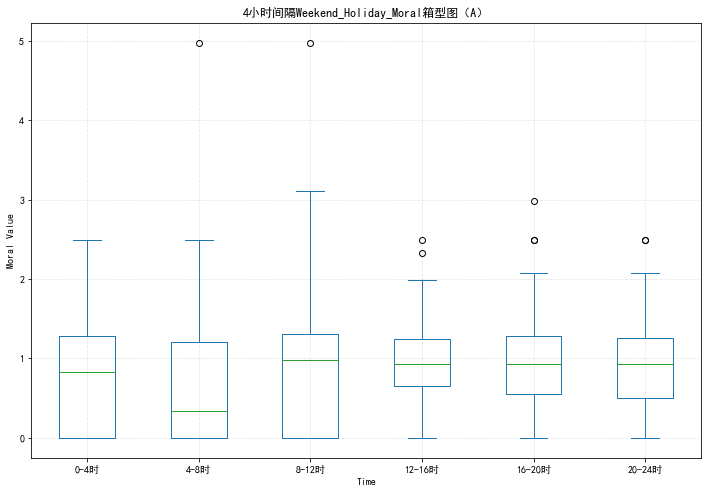

Weekend_Holiday四时区，B
index:0;（1时-5时）时间区间;平均值：0.5569270666730641;方差：0.6298080318009193;标准差：0.7936044555072251
index:1;（5时-9时）时间区间;平均值：0.7535889878792167;方差：1.004106485823756;标准差：1.0020511393256115
index:2;（9时-13时）时间区间;平均值：1.1490016801449479;方差：1.2400766489440804;标准差：1.113587288426049
index:3;（13时-17时）时间区间;平均值：0.9340412424052837;方差：0.41982216676259265;标准差：0.6479368539931902
index:4;（17时-21时）时间区间;平均值：0.9689442350520714;方差：0.580949740327856;标准差：0.7622005906110648
index:5;（21时-24时 & 0时-1时）时间区间;平均值：1.1659738285784766;方差：0.5202711305741897;标准差：0.7212982258221559
(0, 1) (Ttest_indResult(statistic=-0.7994429809509083, pvalue=0.4275362298855313), -0.21366012392711037)
(0, 2) (Ttest_indResult(statistic=-2.249836252216119, pvalue=0.028556929327995174), -0.6012940308668744)
(0, 3) (Ttest_indResult(statistic=-1.9126547411922363, pvalue=0.061101989202981266), -0.5111784814807238)
(0, 4) (Ttest_indResult(statistic=-1.9456672211745873, pvalue=0.05690760129983313), -0.5200014378794159)
(0, 5) (Ttest_ind

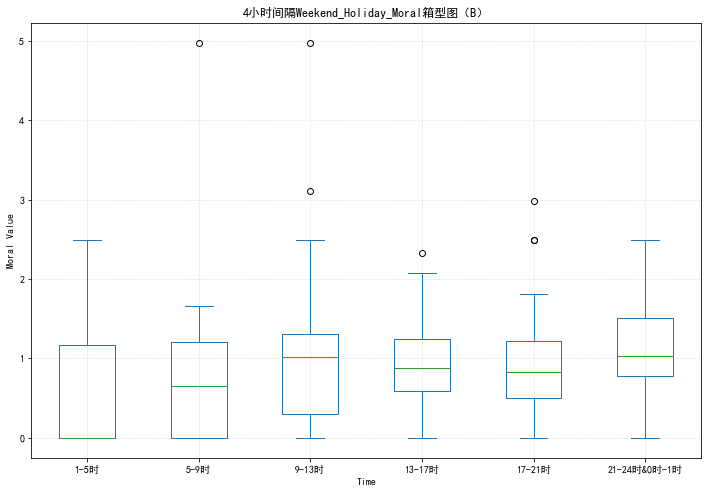

Weekend_Holiday四时区，C
index:0;（2时-6时）时间区间;平均值：0.498328783969178;方差：0.5953409678536791;标准差：0.7715834160048277
index:1;（6时-10时）时间区间;平均值：0.8028104868236222;方差：1.0022775771339958;标准差：1.0011381408846611
index:2;（10时-14时）时间区间;平均值：1.2495211395950032;方差：1.1868075821538124;标准差：1.0894069864627325
index:3;（14时-18时）时间区间;平均值：0.9110150437005887;方差：0.46316611857531015;标准差：0.6805630893424284
index:4;（18时-22时）时间区间;平均值：0.9464914017556657;方差：0.4860719762484539;标准差：0.6971886231490398
index:5;（22时-24时 & 0时-2时）时间区间;平均值：1.1203101848890025;方差：0.5953912787813442;标准差：0.7716160177065691
(0, 1) (Ttest_indResult(statistic=-1.2517181088804796, pvalue=0.21606766958143633), -0.33453573630366823)
(0, 2) (Ttest_indResult(statistic=-2.9238904113311923, pvalue=0.0050427305139332905), -0.781442582548204)
(0, 3) (Ttest_indResult(statistic=-2.08427493848975, pvalue=0.0418801051273874), -0.5570459085477125)
(0, 4) (Ttest_indResult(statistic=-2.2393487183928285, pvalue=0.029273532862267665), -0.5984911195526631)
(0, 5) (Ttest_

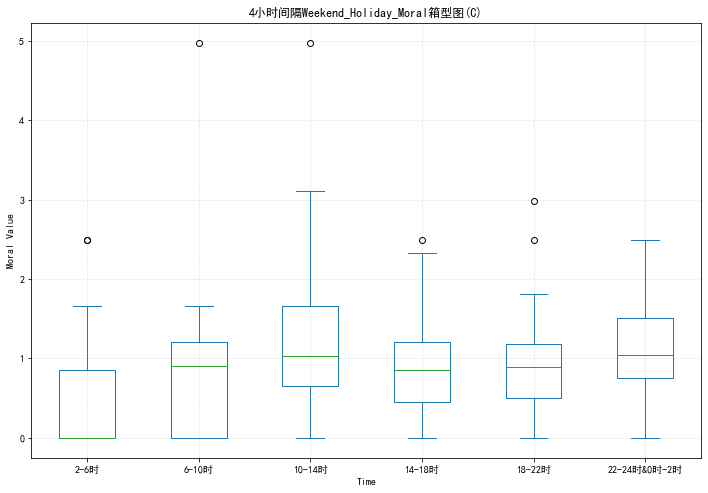

Weekend_Holiday四时区，D
index:0;（3时-7时）时间区间;平均值：0.7613233105154286;方差：1.2473076350056338;标准差：1.1168292774661819
index:1;（7时-11时）时间区间;平均值：0.8652269254297159;方差：1.1843440258533096;标准差：1.0882757122408409
index:2;（11时-15时）时间区间;平均值：1.0190833571698696;方差：0.5419334083249786;标准差：0.7361612651620422
index:3;（15时-19时）时间区间;平均值：0.9019031680280687;方差：0.4601085085362637;标准差：0.6783129871499319
index:4;（19时-23时）时间区间;平均值：1.0557454637325996;方差：0.5932938680954442;标准差：0.7702557160420455
index:5;（24时 & 0时-3时）时间区间;平均值：0.9251948158573775;方差：0.5863217212604248;标准差：0.7657164757666017
(0, 1) (Ttest_indResult(statistic=-0.3462277382605003, pvalue=0.7305169933576707), -0.0925332553120311)
(0, 2) (Ttest_indResult(statistic=-1.0012973293524596, pvalue=0.32114897913426715), -0.26760796776633217)
(0, 3) (Ttest_indResult(statistic=-0.5590302246780984, pvalue=0.5784522438294842), -0.14940711211405017)
(0, 4) (Ttest_indResult(statistic=-1.1276452125427472, pvalue=0.2644553811046737), -0.3013758599407744)
(0, 5) (Ttest_indRe

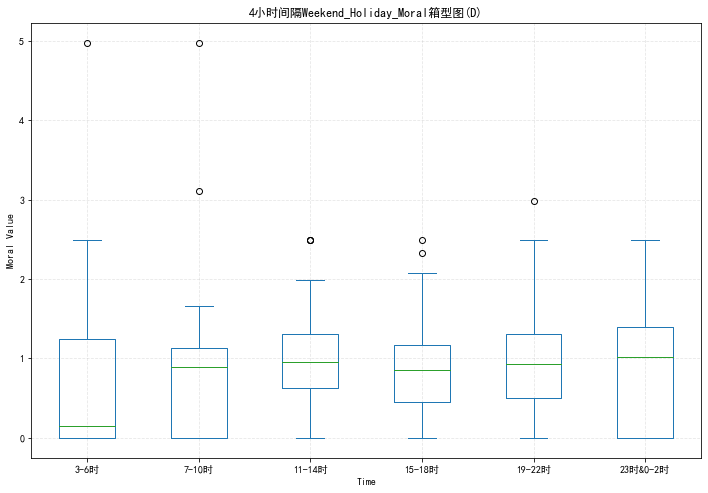

Weekend_Holiday六时区，A
index:0;（0时-6时）时间区间;平均值：0.6885898985160068;方差：0.6567184905095699;标准差：0.8103816943327199
index:1;（6时-12时）时间区间;平均值：1.0072016228080807;方差：1.4043734523373284;标准差：1.1850626364616041
index:2;（12时-18时）时间区间;平均值：0.9683628239380617;方差：0.4354498423972623;标准差：0.6598862344353474
index:3;（18时-24时）时间区间;平均值：1.0214970152265574;方差：0.543053764888122;标准差：0.7369218173511501
(0, 1) (Ttest_indResult(statistic=-1.4210357323615077, pvalue=0.15909814610859815), -0.31009541946588653)
(0, 2) (Ttest_indResult(statistic=-1.7141657852013616, pvalue=0.09027598362832866), -0.3740616411613644)
(0, 3) (Ttest_indResult(statistic=-1.9461020063011285, pvalue=0.05506777625367128), -0.4246742739990641)
(1, 2) (Ttest_indResult(statistic=0.18334524963420912, pvalue=0.8549797241403541), 0.04000921355996846)
(1, 3) (Ttest_indResult(statistic=-0.0655929845485603, pvalue=0.9478615284441491), -0.014313562702468877)
(2, 3) (Ttest_indResult(statistic=-0.34394166376851704, pvalue=0.7317705645458497), -0.0750542242

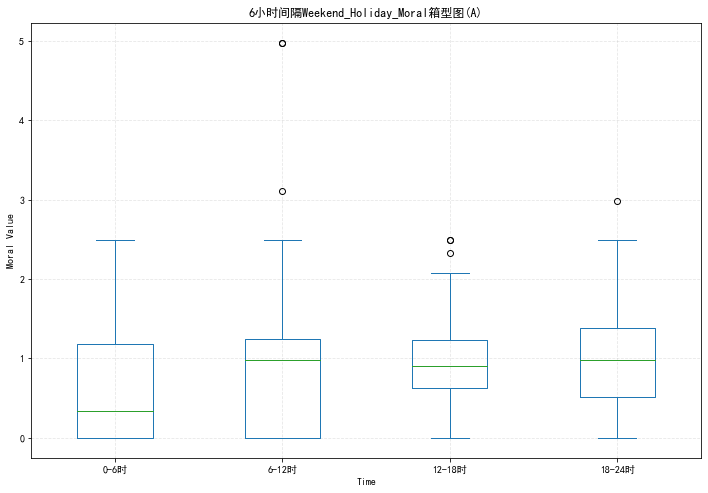

Weekend_Holiday六时区，B
index:0;（1时-7时）时间区间;平均值：0.6763662655762409;方差：0.9691543927693859;标准差：0.9844563945494924
index:1;（7时-13时）时间区间;平均值：0.9633122242219114;方差：1.0269106058794009;标准差：1.013365978252379
index:2;（13时-19时）时间区间;平均值：0.8941634095298581;方差：0.4368999422183656;标准差：0.6609840710776361
index:3;（19时-24时 & 0时-1时）时间区间;平均值：1.1518094611606962;方差：0.5647894731864392;标准差：0.7515247655177035
(0, 1) (Ttest_indResult(statistic=-1.3004830652396733, pvalue=0.19707861567781493), -0.283788670784238)
(0, 2) (Ttest_indResult(statistic=-1.176096769122093, pvalue=0.24295938492024624), -0.2566453556711902)
(0, 3) (Ttest_indResult(statistic=-2.4580223705292967, pvalue=0.016077089428108173), -0.5363844558497759)
(1, 2) (Ttest_indResult(statistic=0.365960516855845, pvalue=0.7153369846371127), 0.07985913189795583)
(1, 3) (Ttest_indResult(statistic=-0.9566791257371269, pvalue=0.3415413012443519), -0.20876450045116954)
(2, 3) (Ttest_indResult(statistic=-1.64834789329211, pvalue=0.1031078450029728), -0.3596989996

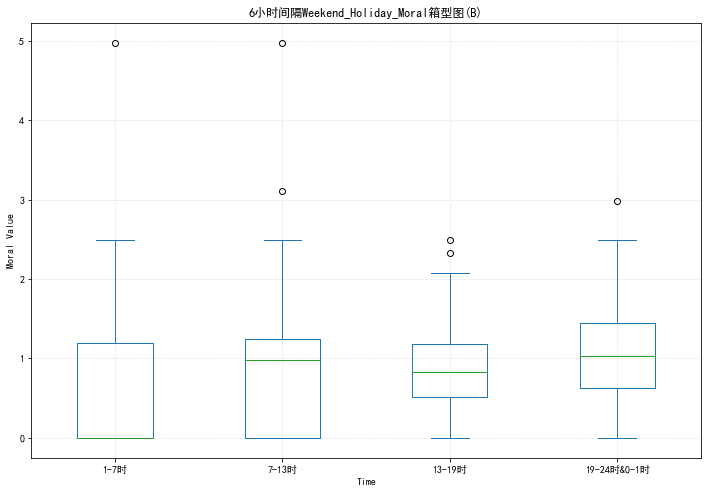

Weekend_Holiday六时区，C
index:0;（2时-8时）时间区间;平均值：0.6537667171361752;方差：0.9829740340227937;标准差：0.9914504697778874
index:1;（8时-14时）时间区间;平均值：1.0466735564556935;方差：0.9864664851735598;标准差：0.9932101918393507
index:2;（14时-20时）时间区间;平均值：0.9719931190723022;方差：0.5675158705131738;标准差：0.7533364922218847
index:3;（20时-24时 & 0时-2时）时间区间;平均值：1.0132179678245354;方差：0.4781153005853283;标准差：0.6914588205998448
(0, 1) (Ttest_indResult(statistic=-1.792710171412736, pvalue=0.07670701635470392), -0.3912014314102915)
(0, 2) (Ttest_indResult(statistic=-1.6364158049402515, pvalue=0.10558526444299961), -0.35709520450289484)
(0, 3) (Ttest_indResult(statistic=-1.9041166127596645, pvalue=0.060402307002582804), -0.415512309999718)
(1, 2) (Ttest_indResult(statistic=0.38359747472717726, pvalue=0.7022695917475195), 0.08370783163481904)
(1, 3) (Ttest_indResult(statistic=0.177012440342477, pvalue=0.859935111508451), 0.038627281277059805)
(2, 3) (Ttest_indResult(statistic=-0.25814382366599337, pvalue=0.7969427092529284), -0.056331

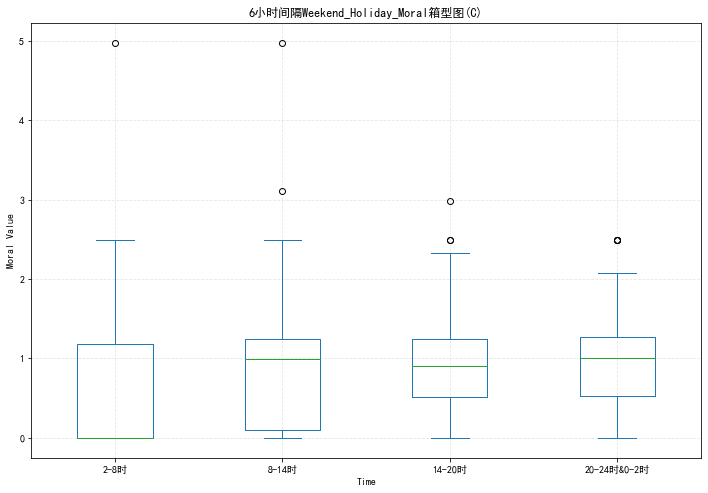

Weekend_Holiday六时区，D
index:0;（3时-9时）时间区间;平均值：0.7048599778022323;方差：0.9691463310539457;标准差：0.984452300039949
index:1;（9时-15时）时间区间;平均值：1.0588957509411105;方差：0.9729970517223959;标准差：0.986406129199528
index:2;（15时-21时）时间区间;平均值：0.975762354127091;方差：0.535190158628217;标准差：0.7315669201298108
index:3;（21时-24时 & 0时-3时）时间区间;平均值：0.9461332776182727;方差：0.5666877265384634;标准差：0.7527866407810805
(0, 1) (Ttest_indResult(statistic=-1.6266661549633488, pvalue=0.10764506309151747), -0.3549676564543958)
(0, 2) (Ttest_indResult(statistic=-1.4142697359567253, pvalue=0.16106849701478232), -0.30861895800509065)
(0, 3) (Ttest_indResult(statistic=-1.246605519143656, pvalue=0.21609149884827364), -0.27203162634407263)
(1, 2) (Ttest_indResult(statistic=0.43345081873506347, pvalue=0.6658254331490197), 0.09458672318542911)
(1, 3) (Ttest_indResult(statistic=0.5818896242787295, pvalue=0.5622374085612254), 0.12697872616031863)
(2, 3) (Ttest_indResult(statistic=0.18073543569471953, pvalue=0.85702119503749), 0.039439705468

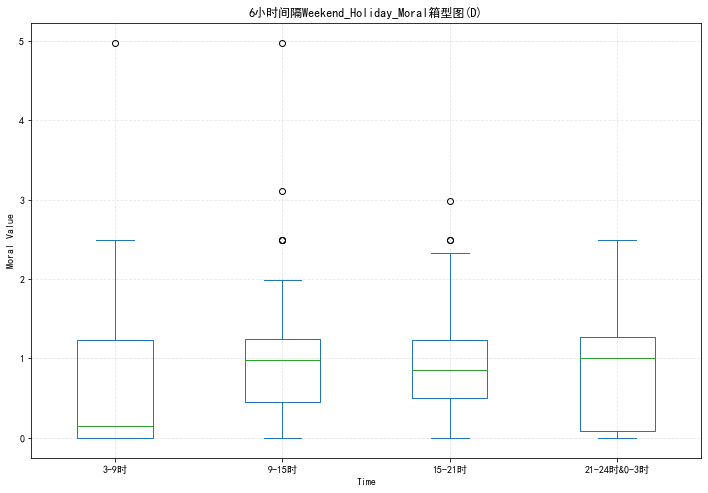

Weekend_Holiday六时区，E
index:0;（4时-10时）时间区间;平均值：0.7248009130756797;方差：0.9174366367974277;标准差：0.957829127139819
index:1;（10时-16时）时间区间;平均值：1.1191459104333918;方差：0.9891798885770726;标准差：0.9945752302249803
index:2;（16时-22时）时间区间;平均值：0.952205812934113;方差：0.4670653915433342;标准差：0.6834218254806721
index:3;（22时-24时 & 0时-4时）时间区间;平均值：0.7172347045401233;方差：0.7569609580178864;标准差：0.8700350326382763
(0, 1) (Ttest_indResult(statistic=-1.8286752527249617, pvalue=0.07108412980966157), -0.39904965557641137)
(0, 2) (Ttest_indResult(statistic=-1.2374992611791646, pvalue=0.21943367949578943), -0.27004447794311665)
(0, 3) (Ttest_indResult(statistic=0.03744043961991107, pvalue=0.9702248283751542), 0.008170173743365056)
(1, 2) (Ttest_indResult(statistic=0.8857992857970508, pvalue=0.37831601967081696), 0.19329725131918124)
(1, 3) (Ttest_indResult(statistic=1.9475221584063218, pvalue=0.054894560292575556), 0.42498417659527365)
(2, 3) (Ttest_indResult(statistic=1.35991263989425, pvalue=0.17758493214870488), 0.29675

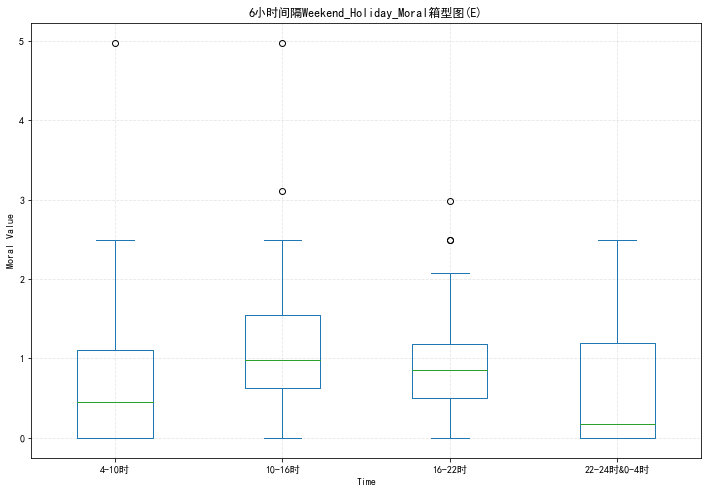

Weekend_Holiday六时区，F
index:0;（5时-11时）时间区间;平均值：0.8818995047473421;方差：1.3108695608039196;标准差：1.1449321206097414
index:1;（11时-17时）时间区间;平均值：1.0091884355389567;方差：0.5092821160790202;标准差：0.7136400465774186
index:2;（17时-23时）时间区间;平均值：0.9752995570814019;方差：0.5623103477911189;标准差：0.7498735545351088
index:3;（23时-24时 & 0时-5时）时间区间;平均值：0.8192638631210061;方差：0.7083168553274963;标准差：0.8416156220790441
(0, 1) (Ttest_indResult(statistic=-0.6041277384863901, pvalue=0.5474265439165942), -0.13183148052554142)
(0, 2) (Ttest_indResult(statistic=-0.43696766648881397, pvalue=0.6632833683521695), -0.09535416228253374)
(0, 3) (Ttest_indResult(statistic=0.28224434615599475, pvalue=0.7784673169118366), 0.06159076574919831)
(1, 2) (Ttest_indResult(statistic=0.209620763864555, pvalue=0.8344835979350211), 0.04574300084018035)
(1, 3) (Ttest_indResult(statistic=1.1020998655923617, pvalue=0.2736425423571391), 0.240497907498936)
(2, 3) (Ttest_indResult(statistic=0.8863531871125068, pvalue=0.3780193308725932), 0.1934181224

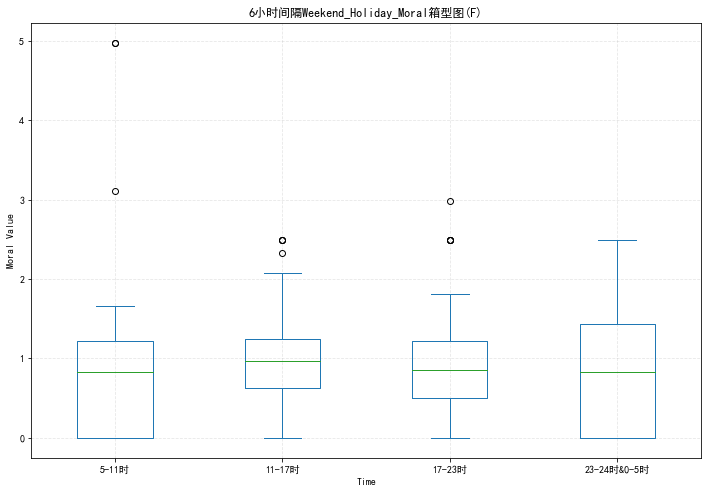

In [10]:
# 五、（五）weekend_holiday数据
# （1）平均值，方差，标准差【moral,score_communion,score_agency】
# Moral
weekend_holiday_moral_avg,weekend_holiday_moral_var,weekend_holiday_moral_std = get_mean_score(weekend_holiday_moral)
print_mean_score("weekend_holiday_moral",weekend_holiday_moral_avg,weekend_holiday_moral_var,weekend_holiday_moral_std)
# Score_communion
weekend_holiday_score_communion_avg,weekend_holiday_score_communion_var,weekend_holiday_score_communion_std = get_mean_score(weekend_holiday_score_communion)
print_mean_score("weekend_holiday_score_communion",weekend_holiday_score_communion_avg,weekend_holiday_score_communion_var,weekend_holiday_score_communion_std)
# Score_agency
weekend_holiday_score_agency_avg,weekend_holiday_score_agency_var,weekend_holiday_score_agency_std = get_mean_score(weekend_holiday_score_agency)
print_mean_score("weekend_holiday_score_agency",weekend_holiday_score_agency_avg,weekend_holiday_score_agency_var,weekend_holiday_score_agency_std)

# （2）单样本T检验（005置信【1.711】，001置信【2.492】）
weekend_holiday_moral_005,weekend_holiday_moral_001 = get_t_sigle(weekend_holiday_moral)
print_t_sigle("weekend_holiday_moral",weekend_holiday_moral_005,weekend_holiday_moral_001)
# Score_communion
weekend_holiday_score_communion_005,weekend_holiday_score_communion_001 = get_t_sigle(weekend_holiday_score_communion)
print_t_sigle("weekend_holiday_score_communion",weekend_holiday_score_communion_005,weekend_holiday_score_communion_001)
# Score_agency
weekend_holiday_score_agency_005,weekend_holiday_score_agency_001 = get_t_sigle(weekend_holiday_score_agency)
print_t_sigle("weekend_holiday_score_agency",weekend_holiday_score_agency_005,weekend_holiday_score_agency_001)
# （3）相关性检验（pearsonr,spear,kendall）
# Moral与评论条数
weekend_holiday_moral_sentnum_pearson,weekend_holiday_moral_sentnum_spear,weekend_holiday_moral_sentnum_kendall = get_correlation(weekend_holiday_moral,weekend_holiday_sentnum)
print_correlation("weekend_holiday_moral","评论条数",weekend_holiday_moral_sentnum_pearson,weekend_holiday_moral_sentnum_spear,weekend_holiday_moral_sentnum_kendall)
# Moral受评论条数影响率（不可用，weekend_holiday_sentnum存在0值）
#weekend_holiday_moral_sentnum_rate = [a/b for a,b in zip(weekend_holiday_moral,weekend_holiday_sentnum)]
#print(weekend_holiday_moral_sentnum_rate)
# Moral与切分词总数
# Moral与切分词总数
weekend_holiday_moral_words_pearson,weekend_holiday_moral_words_spear,weekend_holiday_moral_words_kendall = get_correlation(weekend_holiday_moral,weekend_holiday_all_words)
print_correlation("weekend_holiday_moral","切分词总数",weekend_holiday_moral_words_pearson,weekend_holiday_moral_words_spear,weekend_holiday_moral_words_kendall)
# Moral受切分词总数影响率（不可用，weekend_holiday_sentnum存在0值）
#weekend_holiday_moral_allwords_rate = [a/b for a,b in zip(weekend_holiday_moral,weekend_holiday_all_words)]
#print(weekend_holiday_moral_allwords_rate)

# （4） 拆分时间区间——weekend_holiday_moral
#********************************************************************************************
# Moral——三时区（A，B，C）
#********************************************************************************************
print('Weekend_Holiday三时区，A')
# A(0时开始)
# 时间区间——0时-3时（moral）
weekend_holiday_moral_time3a_am1 = weekend_holiday_moral[0:21]
#print("3a-am1",weekend_holiday_moral_time3a_am1)
# 时间区间——3时-6时（moral）
weekend_holiday_moral_time3a_am2 = weekend_holiday_moral[21:42]
#print("3a-am2",weekend_holiday_moral_time3a_am2)
# 时间区间——6时-9时（moral）
weekend_holiday_moral_time3a_am3 = weekend_holiday_moral[42:63]
#print("3a-am3",weekend_holiday_moral_time3a_am3)
# 时间区间——9时-12时（moral）
weekend_holiday_moral_time3a_am4 = weekend_holiday_moral[63:84]
#print("3a-am4",weekend_holiday_moral_time3a_am4)
# 时间区间——12时-15时（moral）
weekend_holiday_moral_time3a_pm1 = weekend_holiday_moral[84:105]
#print("3a-pm1",weekend_holiday_moral_time3a_pm1)
# 时间区间——15时-18时（moral）
weekend_holiday_moral_time3a_pm2 = weekend_holiday_moral[105:126]
#print("3a-pm2",weekend_holiday_moral_time3a_pm2)
# 时间区间——18时-21时（moral）
weekend_holiday_moral_time3a_pm3 = weekend_holiday_moral[126:147]
#print("3a-pm3",weekend_holiday_moral_time3a_pm3)
# 时间区间——21时-24时（moral）
weekend_holiday_moral_time3a_pm4 = weekend_holiday_moral[147:168]
#print("3a-pm4",weekend_holiday_moral_time3a_pm4)

# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time3a = [weekend_holiday_moral_time3a_am1,weekend_holiday_moral_time3a_am2,weekend_holiday_moral_time3a_am3,weekend_holiday_moral_time3a_am4,
                          weekend_holiday_moral_time3a_pm1,weekend_holiday_moral_time3a_pm2,weekend_holiday_moral_time3a_pm3,weekend_holiday_moral_time3a_pm4]




for i,j in enumerate(weekend_holiday_moral_time3a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（3时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（6时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（9时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（12时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（15时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（18时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（21时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
        
# 时间区间的两两交叉T检验
weekend_holiday_moral_time3a_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time3a)
for i,j in weekend_holiday_moral_time3a_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_3a = ['0-3时','3-6时','6-9时','9-12时','12-15时','15-18时','18-21时','21-24时']
weekend_holiday_box_graph3a = get_boxgraph(weekend_holiday_name_list_3a,'Time','Moral Value','3小时间隔Weekend_Holiday_moral箱型图(A)',
                           weekend_holiday_moral_time3a_am1,weekend_holiday_moral_time3a_am2,weekend_holiday_moral_time3a_am3,weekend_holiday_moral_time3a_am4,
                          weekend_holiday_moral_time3a_pm1,weekend_holiday_moral_time3a_pm2,weekend_holiday_moral_time3a_pm3,weekend_holiday_moral_time3a_pm4)

#********************************************************************************************

print('Weekend_Holiday三时区，B')
# B(1时开始)
# 时间区间——1时-4时（moral）
weekend_holiday_moral_time3b_am1 = weekend_holiday_moral[7:28]
#print("3b-am1",weekend_holiday_moral_time3b_am1)
# 时间区间——4时-7时（moral）
weekend_holiday_moral_time3b_am2 = weekend_holiday_moral[28:49]
#print("3b-am2",weekend_holiday_moral_time3b_am2)
# 时间区间——7时-10时（moral）
weekend_holiday_moral_time3b_am3 = weekend_holiday_moral[49:70]
#print("3b-am3",weekend_holiday_moral_time3b_am3)
# 时间区间——10时-13时（moral）
weekend_holiday_moral_time3b_am4 = weekend_holiday_moral[70:91]
#print("3b-am4",weekend_holiday_moral_time3b_am4)
# 时间区间——13时-16时（moral）
weekend_holiday_moral_time3b_pm1 = weekend_holiday_moral[91:112]
#print("3b-pm1",weekend_holiday_moral_time3b_pm1)
# 时间区间——16时-19时（moral）
weekend_holiday_moral_time3b_pm2 = weekend_holiday_moral[112:133]
#print("3b-pm2",weekend_holiday_moral_time3b_pm2)
# 时间区间——19时-22时（moral）
weekend_holiday_moral_time3b_pm3 = weekend_holiday_moral[133:154]
#print("3b-pm3",weekend_holiday_moral_time3b_pm3)
# 时间区间——22时-24时-0时（moral）
weekend_holiday_moral_time3b_pm4 = weekend_holiday_moral[154:168]+weekend_holiday_moral[0:7]
#print("3b-pm4",weekend_holiday_moral_time3b_pm4)

# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time3b = [weekend_holiday_moral_time3b_am1,weekend_holiday_moral_time3b_am2,weekend_holiday_moral_time3b_am3,weekend_holiday_moral_time3b_am4,
                          weekend_holiday_moral_time3b_pm1,weekend_holiday_moral_time3b_pm2,weekend_holiday_moral_time3b_pm3,weekend_holiday_moral_time3b_pm4]



for i,j in enumerate(weekend_holiday_moral_time3b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（7时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（10时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（13时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（16时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（19时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（22时-24时 & 0时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
weekend_holiday_moral_time3b_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time3b)
for i,j in weekend_holiday_moral_time3b_2crosscheck.items():
    print(i,j)
    
weekend_holiday_name_list_3b = ['1-4时','4-7时','7-10时','10-13时','13-16时','16-19时','19-22时','22-24时&0时']
weekend_holiday_box_graph3b = get_boxgraph(weekend_holiday_name_list_3b,'Time','Moral Value','3小时间隔Weekend_Holiday_moral箱型图(B)',
                           weekend_holiday_moral_time3b_am1,weekend_holiday_moral_time3b_am2,weekend_holiday_moral_time3b_am3,weekend_holiday_moral_time3b_am4,
                          weekend_holiday_moral_time3b_pm1,weekend_holiday_moral_time3b_pm2,weekend_holiday_moral_time3b_pm3,weekend_holiday_moral_time3b_pm4)

#********************************************************************************************
print('Weekend_Holiday三时区，C')
# 时间区间——2时-5时（moral）
weekend_holiday_moral_time3c_am1 = weekend_holiday_moral[14:35]
#print("3c-am1",weekend_holiday_moral_time3c_am1)
# 时间区间——5时-8时（moral）
weekend_holiday_moral_time3c_am2 = weekend_holiday_moral[35:56]
#print("3c-am2",weekend_holiday_moral_time3c_am2)
# 时间区间——8时-11时（moral）
weekend_holiday_moral_time3c_am3 = weekend_holiday_moral[56:77]
#print("3c-am3",weekend_holiday_moral_time3c_am3)
# 时间区间——11时-14时（moral）
weekend_holiday_moral_time3c_am4 = weekend_holiday_moral[77:98]
#print("3c-am4",weekend_holiday_moral_time3c_am4)
# 时间区间——14时-17时（moral）
weekend_holiday_moral_time3c_pm1 = weekend_holiday_moral[98:119]
#print("3c-pm1",weekend_holiday_moral_time3c_pm1)
# 时间区间——17时-20时（moral）
weekend_holiday_moral_time3c_pm2 = weekend_holiday_moral[119:140]
#print("3c-pm2",weekend_holiday_moral_time3c_pm2)
# 时间区间——20时-23时（moral）
weekend_holiday_moral_time3c_pm3 = weekend_holiday_moral[140:161]
#print("3c-pm3",weekend_holiday_moral_time3c_pm3)
# 时间区间——24时+0-1时（moral）
weekend_holiday_moral_time3c_pm4 = weekend_holiday_moral[161:168]+weekend_holiday_moral[0:14]
#print("3c-pm4",weekend_holiday_moral_time3c_pm4)

# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time3c = [weekend_holiday_moral_time3c_am1,weekend_holiday_moral_time3c_am2,weekend_holiday_moral_time3c_am3,weekend_holiday_moral_time3c_am4,
                          weekend_holiday_moral_time3c_pm1,weekend_holiday_moral_time3c_pm2,weekend_holiday_moral_time3c_pm3,weekend_holiday_moral_time3c_pm4]



for i,j in enumerate(weekend_holiday_moral_time3c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（11时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（14时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（17时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 6:
        print("index:%s;（20时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 7:
        print("index:%s;（24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
# 时间区间的两两交叉T检验
weekend_holiday_moral_time3c_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time3c)
for i,j in weekend_holiday_moral_time3c_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_3c = ['2-5时','5-8时','8-11时','11-14时','14-17时','17-20时','20-23时','24时&0-1时']
weekend_holiday_box_graph3c = get_boxgraph(weekend_holiday_name_list_3c,'Time','Moral Value','3小时间隔Weekend_Holiday_moral箱型图(C)',
                           weekend_holiday_moral_time3c_am1,weekend_holiday_moral_time3c_am2,weekend_holiday_moral_time3c_am3,weekend_holiday_moral_time3c_am4,
                          weekend_holiday_moral_time3c_pm1,weekend_holiday_moral_time3c_pm2,weekend_holiday_moral_time3c_pm3,weekend_holiday_moral_time3c_pm4)
#********************************************************************************************
# Moral——四时区（A，B，C，D）
#********************************************************************************************
print('Weekend_Holiday四时区，A')
# 时间区间——0时-4时（moral）
weekend_holiday_moral_time4a_am1 = weekend_holiday_moral[0:28]
#print("4a-am1",weekend_holiday_moral_time4a_am1)
# 时间区间——4时-8时（moral）
weekend_holiday_moral_time4a_am2 = weekend_holiday_moral[28:56]
#print("4a-am2",weekend_holiday_moral_time4a_am2)
# 时间区间——8时-12时（moral）
weekend_holiday_moral_time4a_am3 = weekend_holiday_moral[56:84]
#print("4a-am3",weekend_holiday_moral_time4a_am3)
# 时间区间——12时-16时（moral）
weekend_holiday_moral_time4a_pm1 = weekend_holiday_moral[84:112]
#print("4a-pm1",weekend_holiday_moral_time4a_pm1)
# 时间区间——16时-20时（moral）
weekend_holiday_moral_time4a_pm2 = weekend_holiday_moral[112:140]
#print("4a-pm2",weekend_holiday_moral_time4a_pm2)
# 时间区间——20时-24时（moral）
weekend_holiday_moral_time4a_pm3 = weekend_holiday_moral[140:168]
#print("4a-pm3",weekend_holiday_moral_time4a_pm3)

# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time4a = [weekend_holiday_moral_time4a_am1,weekend_holiday_moral_time4a_am2,weekend_holiday_moral_time4a_am3,
                          weekend_holiday_moral_time4a_pm1,weekend_holiday_moral_time4a_pm2,weekend_holiday_moral_time4a_pm3]



for i,j in enumerate(weekend_holiday_moral_time4a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（4时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（8时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（12时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（16时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（20时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time4a_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time4a)
for i,j in weekend_holiday_moral_time4a_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_4a = ['0-4时','4-8时','8-12时','12-16时','16-20时','20-24时']
weekend_holiday_box_graph4a = get_boxgraph(weekend_holiday_name_list_4a,'Time','Moral Value','4小时间隔Weekend_Holiday_Moral箱型图（A）',
                           weekend_holiday_moral_time4a_am1,weekend_holiday_moral_time4a_am2,weekend_holiday_moral_time4a_am3,
                          weekend_holiday_moral_time4a_pm1,weekend_holiday_moral_time4a_pm2,weekend_holiday_moral_time4a_pm3)
#********************************************************************************************
print('Weekend_Holiday四时区，B')
# 时间区间——1时-5时（moral）
weekend_holiday_moral_time4b_am1 = weekend_holiday_moral[7:35]
#print("4b-am1",weekend_holiday_moral_time4b_am1)
# 时间区间——5时-9时（moral）
weekend_holiday_moral_time4b_am2 = weekend_holiday_moral[35:63]
#print("4b-am2",weekend_holiday_moral_time4b_am2)
# 时间区间——9时-13时（moral）
weekend_holiday_moral_time4b_am3 = weekend_holiday_moral[63:91]
#print("4b-am3",weekend_holiday_moral_time4b_am3)
# 时间区间——13时-17时（moral）
weekend_holiday_moral_time4b_pm1 = weekend_holiday_moral[91:119]
#print("4b-pm1",weekend_holiday_moral_time4b_pm1)
# 时间区间——17时-21时（moral）
weekend_holiday_moral_time4b_pm2 = weekend_holiday_moral[119:147]
#print("4b-pm2",weekend_holiday_moral_time4b_pm2)
# 时间区间——21时-24时 & 0时（moral）
weekend_holiday_moral_time4b_pm3 = weekend_holiday_moral[147:168] + weekend_holiday_moral[0:7]
#print("4b-pm3",weekend_holiday_moral_time4b_pm3)

# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time4b = [weekend_holiday_moral_time4b_am1,weekend_holiday_moral_time4b_am2,weekend_holiday_moral_time4b_am3,
                          weekend_holiday_moral_time4b_pm1,weekend_holiday_moral_time4b_pm2,weekend_holiday_moral_time4b_pm3]



for i,j in enumerate(weekend_holiday_moral_time4b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（5时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（9时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（13时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（17时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（21时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time4b_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time4b)
for i,j in weekend_holiday_moral_time4b_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_4b = ['1-5时','5-9时','9-13时','13-17时','17-21时','21-24时&0时-1时']
weekend_holiday_box_graph4b = get_boxgraph(weekend_holiday_name_list_4b,'Time','Moral Value','4小时间隔Weekend_Holiday_Moral箱型图（B）',
                           weekend_holiday_moral_time4b_am1,weekend_holiday_moral_time4b_am2,weekend_holiday_moral_time4b_am3,
                          weekend_holiday_moral_time4b_pm1,weekend_holiday_moral_time4b_pm2,weekend_holiday_moral_time4b_pm3)

#********************************************************************************************
print('Weekend_Holiday四时区，C')
# 时间区间——2时-6时（moral）
weekend_holiday_moral_time4c_am1 = weekend_holiday_moral[14:42]
#print("4c-am1",weekend_holiday_moral_time4c_am1)
# 时间区间——6时-10时（moral）
weekend_holiday_moral_time4c_am2 = weekend_holiday_moral[42:70]
#print("4c-am2",weekend_holiday_moral_time4c_am2)
# 时间区间——10时-14时（moral）
weekend_holiday_moral_time4c_am3 = weekend_holiday_moral[70:98]
#print("4c-am3",weekend_holiday_moral_time4c_am3)
# 时间区间——14时-18时（moral）
weekend_holiday_moral_time4c_pm1 = weekend_holiday_moral[98:126]
#print("4c-pm1",weekend_holiday_moral_time4c_pm1)
# 时间区间——18时-22时（moral）
weekend_holiday_moral_time4c_pm2 = weekend_holiday_moral[126:154]
#print("4c-pm2",weekend_holiday_moral_time4c_pm2)
# 时间区间——22时-24时 & 0时-2时（moral）
weekend_holiday_moral_time4c_pm3 = weekend_holiday_moral[154:168] + weekend_holiday_moral[0:14]
#print("4c-pm3",weekend_holiday_moral_time4c_pm3)

# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time4c = [weekend_holiday_moral_time4c_am1,weekend_holiday_moral_time4c_am2,weekend_holiday_moral_time4c_am3,
                          weekend_holiday_moral_time4c_pm1,weekend_holiday_moral_time4c_pm2,weekend_holiday_moral_time4c_pm3]



for i,j in enumerate(weekend_holiday_moral_time4c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（10时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（14时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（18时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（22时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time4c_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time4c)
for i,j in weekend_holiday_moral_time4c_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_4c = ['2-6时','6-10时','10-14时','14-18时','18-22时','22-24时&0时-2时']
weekend_holiday_box_graph4c = get_boxgraph(weekend_holiday_name_list_4c,'Time','Moral Value','4小时间隔Weekend_Holiday_Moral箱型图(C)',
                           weekend_holiday_moral_time4c_am1,weekend_holiday_moral_time4c_am2,weekend_holiday_moral_time4c_am3,
                          weekend_holiday_moral_time4c_pm1,weekend_holiday_moral_time4c_pm2,weekend_holiday_moral_time4c_pm3)

#********************************************************************************************
print('Weekend_Holiday四时区，D')
# 时间区间——3时-7时（moral）
weekend_holiday_moral_time4d_am1 = weekend_holiday_moral[21:49]
#print("4d-am1",weekend_holiday_moral_time4d_am1)
# 时间区间——7时-11时（moral）
weekend_holiday_moral_time4d_am2 = weekend_holiday_moral[49:77]
#print("4d-am2",weekend_holiday_moral_time4d_am2)
# 时间区间——11时-15时（moral）
weekend_holiday_moral_time4d_am3 = weekend_holiday_moral[77:105]
#print("4d-am3",weekend_holiday_moral_time4d_am3)
# 时间区间——15时-19时（moral）
weekend_holiday_moral_time4d_pm1 = weekend_holiday_moral[105:133]
#print("4d-pm1",weekend_holiday_moral_time4d_pm1)
# 时间区间——19时-23时（moral）
weekend_holiday_moral_time4d_pm2 = weekend_holiday_moral[133:161]
#print("4d-pm2",weekend_holiday_moral_time4d_pm2)
# 时间区间——24时 & 0时-3时（moral）
weekend_holiday_moral_time4d_pm3 = weekend_holiday_moral[161:168] + weekend_holiday_moral[0:21]
#print("4d-pm3",weekend_holiday_moral_time4d_pm3)
# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time4d = [weekend_holiday_moral_time4d_am1,weekend_holiday_moral_time4d_am2,weekend_holiday_moral_time4d_am3,
                          weekend_holiday_moral_time4d_pm1,weekend_holiday_moral_time4d_pm2,weekend_holiday_moral_time4d_pm3]



for i,j in enumerate(weekend_holiday_moral_time4d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（11时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（15时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 4:
        print("index:%s;（19时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 5:
        print("index:%s;（24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time4d_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time4d)
for i,j in weekend_holiday_moral_time4d_2crosscheck.items():
    print(i,j)
    
weekend_holiday_name_list_4d = ['3-6时','7-10时','11-14时','15-18时','19-22时','23时&0-2时']
weekend_holiday_box_graph4d = get_boxgraph(weekend_holiday_name_list_4d,'Time','Moral Value','4小时间隔Weekend_Holiday_Moral箱型图(D)',
                           weekend_holiday_moral_time4d_am1,weekend_holiday_moral_time4d_am2,weekend_holiday_moral_time4d_am3,
                          weekend_holiday_moral_time4d_pm1,weekend_holiday_moral_time4d_pm2,weekend_holiday_moral_time4d_pm3)

#********************************************************************************************
# Moral——六时区（A，B，C，D，E，F）
#********************************************************************************************
print('Weekend_Holiday六时区，A')
# 时间区间——0时-6时（moral）
weekend_holiday_moral_time6a_am1 = weekend_holiday_moral[0:42]
#print("6a-am1",weekend_holiday_moral_time6a_am1)
# 时间区间——6时-12时（moral）
weekend_holiday_moral_time6a_am2 = weekend_holiday_moral[42:84]
#print("6a-am2",weekend_holiday_moral_time6a_am2)
# 时间区间——12时-18时（moral）
weekend_holiday_moral_time6a_pm1 = weekend_holiday_moral[84:126]
#print("6a-pm1",weekend_holiday_moral_time6a_pm1)
# 时间区间——18时-24时（moral）
weekend_holiday_moral_time6a_pm2 = weekend_holiday_moral[126:168]
#print("6a-pm2",weekend_holiday_moral_time6a_pm2)

# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time6a = [weekend_holiday_moral_time6a_am1,weekend_holiday_moral_time6a_am2,
                    weekend_holiday_moral_time6a_pm1,weekend_holiday_moral_time6a_pm2]



for i,j in enumerate(weekend_holiday_moral_time6a):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（0时-6时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（6时-12时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（12时-18时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（18时-24时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time6a_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time6a)
for i,j in weekend_holiday_moral_time6a_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_6a = ['0-6时','6-12时','12-18时','18-24时']
weekend_holiday_box_graph6a = get_boxgraph(weekend_holiday_name_list_6a,'Time','Moral Value','6小时间隔Weekend_Holiday_Moral箱型图(A)',
                           weekend_holiday_moral_time6a_am1,weekend_holiday_moral_time6a_am2,
                          weekend_holiday_moral_time6a_pm1,weekend_holiday_moral_time6a_pm2)
#********************************************************************************************
print('Weekend_Holiday六时区，B')
# 时间区间——1时-7时（moral）
weekend_holiday_moral_time6b_am1 = weekend_holiday_moral[7:49]
#print("6b-am1",weekend_holiday_moral_time6b_am1)
# 时间区间——7时-13时（moral）
weekend_holiday_moral_time6b_am2 = weekend_holiday_moral[49:91]
#print("6b-am2",weekend_holiday_moral_time6b_am2)
# 时间区间——13时-19时（moral）
weekend_holiday_moral_time6b_pm1 = weekend_holiday_moral[91:133]
#print("6b-pm1",weekend_holiday_moral_time6b_pm1)
# 时间区间——19时-24时&0时-1时（moral）
weekend_holiday_moral_time6b_pm2 = weekend_holiday_moral[133:168]+weekend_holiday_moral[0:7]
#print("6b-pm2",weekend_holiday_moral_time6b_pm2)
# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time6b = [weekend_holiday_moral_time6b_am1,weekend_holiday_moral_time6b_am2,
                    weekend_holiday_moral_time6b_pm1,weekend_holiday_moral_time6b_pm2]



for i,j in enumerate(weekend_holiday_moral_time6b):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（1时-7时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（7时-13时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（13时-19时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（19时-24时 & 0时-1时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time6b_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time6b)
for i,j in weekend_holiday_moral_time6b_2crosscheck.items():
    print(i,j)
    
weekend_holiday_name_list_6b = ['1-7时','7-13时','13-19时','19-24时&0-1时']
weekend_holiday_box_graph6b = get_boxgraph(weekend_holiday_name_list_6b,'Time','Moral Value','6小时间隔Weekend_Holiday_Moral箱型图(B)',
                           weekend_holiday_moral_time6b_am1,weekend_holiday_moral_time6b_am2,
                          weekend_holiday_moral_time6b_pm1,weekend_holiday_moral_time6b_pm2)

#********************************************************************************************
print('Weekend_Holiday六时区，C')
# 时间区间——2时-8时（moral）
weekend_holiday_moral_time6c_am1 = weekend_holiday_moral[14:56]
#print("6c-am1",weekend_holiday_moral_time6c_am1)
# 时间区间——8时-14时（moral）
weekend_holiday_moral_time6c_am2 = weekend_holiday_moral[56:98]
#print("6c-am2",weekend_holiday_moral_time6c_am2)
# 时间区间——14时-20时（moral）
weekend_holiday_moral_time6c_pm1 = weekend_holiday_moral[98:140]
#print("6c-pm1",weekend_holiday_moral_time6c_pm1)
# 时间区间——20时-24时&0时-2时（moral）
weekend_holiday_moral_time6c_pm2 = weekend_holiday_moral[140:168]+weekend_holiday_moral[0:14]
#print("6c-pm2",weekend_holiday_moral_time6c_pm2)
# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time6c = [weekend_holiday_moral_time6c_am1,weekend_holiday_moral_time6c_am2,
                    weekend_holiday_moral_time6c_pm1,weekend_holiday_moral_time6c_pm2]



for i,j in enumerate(weekend_holiday_moral_time6c):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（2时-8时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（8时-14时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（14时-20时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（20时-24时 & 0时-2时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time6c_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time6c)
for i,j in weekend_holiday_moral_time6c_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_6c = ['2-8时','8-14时','14-20时','20-24时&0-2时']
weekend_holiday_box_graph6c = get_boxgraph(weekend_holiday_name_list_6c,'Time','Moral Value','6小时间隔Weekend_Holiday_Moral箱型图(C)',
                           weekend_holiday_moral_time6c_am1,weekend_holiday_moral_time6c_am2,
                          weekend_holiday_moral_time6c_pm1,weekend_holiday_moral_time6c_pm2)
#********************************************************************************************
print('Weekend_Holiday六时区，D')
# 时间区间——3时-9时（moral）
weekend_holiday_moral_time6d_am1 = weekend_holiday_moral[21:63]
#print("6d-am1",weekend_holiday_moral_time6d_am1)
# 时间区间——9时-15时（moral）
weekend_holiday_moral_time6d_am2 = weekend_holiday_moral[63:105]
#print("6d-am2",weekend_holiday_moral_time6d_am2)
# 时间区间——15时-21时（moral）
weekend_holiday_moral_time6d_pm1 = weekend_holiday_moral[105:147]
#print("6d-pm1",weekend_holiday_moral_time6d_pm1)
# 时间区间——21时-24时&0时-3时（moral）
weekend_holiday_moral_time6d_pm2 = weekend_holiday_moral[147:168]+weekend_holiday_moral[0:21]
#print("6d-pm2",weekend_holiday_moral_time6d_pm2)

# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time6d = [weekend_holiday_moral_time6d_am1,weekend_holiday_moral_time6d_am2,
                    weekend_holiday_moral_time6d_pm1,weekend_holiday_moral_time6d_pm2]



for i,j in enumerate(weekend_holiday_moral_time6d):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（3时-9时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（9时-15时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（15时-21时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（21时-24时 & 0时-3时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time6d_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time6d)
for i,j in weekend_holiday_moral_time6d_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_6d = ['3-9时','9-15时','15-21时','21-24时&0-3时']
weekend_holiday_box_graph6d = get_boxgraph(weekend_holiday_name_list_6d,'Time','Moral Value','6小时间隔Weekend_Holiday_Moral箱型图(D)',
                           weekend_holiday_moral_time6d_am1,weekend_holiday_moral_time6d_am2,
                          weekend_holiday_moral_time6d_pm1,weekend_holiday_moral_time6d_pm2)

#********************************************************************************************
print('Weekend_Holiday六时区，E')
# 时间区间——4时-10时（moral）
weekend_holiday_moral_time6e_am1 = weekend_holiday_moral[28:70]
#print("6e-am1",weekend_holiday_moral_time6e_am1)
# 时间区间——10时-16时（moral）
weekend_holiday_moral_time6e_am2 = weekend_holiday_moral[70:112]
#print("6e-am2",weekend_holiday_moral_time6e_am2)
# 时间区间——16时-22时（moral）
weekend_holiday_moral_time6e_pm1 = weekend_holiday_moral[112:154]
#print("6e-pm1",weekend_holiday_moral_time6e_pm1)
# 时间区间——22时-24时&0时-4时（moral）
weekend_holiday_moral_time6e_pm2 = weekend_holiday_moral[154:168]+holiday_moral[0:28]
#print("6e-pm2",weekend_holiday_moral_time6e_pm2)
# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time6e = [weekend_holiday_moral_time6e_am1,weekend_holiday_moral_time6e_am2,
                    weekend_holiday_moral_time6e_pm1,weekend_holiday_moral_time6e_pm2]



for i,j in enumerate(weekend_holiday_moral_time6e):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（4时-10时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（10时-16时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（16时-22时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（22时-24时 & 0时-4时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time6e_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time6e)
for i,j in weekend_holiday_moral_time6e_2crosscheck.items():
    print(i,j)

weekend_holiday_name_list_6e = ['4-10时','10-16时','16-22时','22-24时&0-4时']
weekend_holiday_box_graph6e = get_boxgraph(weekend_holiday_name_list_6e,'Time','Moral Value','6小时间隔Weekend_Holiday_Moral箱型图(E)',
                           weekend_holiday_moral_time6e_am1,weekend_holiday_moral_time6e_am2,
                          weekend_holiday_moral_time6e_pm1,weekend_holiday_moral_time6e_pm2)

#********************************************************************************************
print('Weekend_Holiday六时区，F')

# 时间区间——5时-11时（moral）
weekend_holiday_moral_time6f_am1 = weekend_holiday_moral[35:77]
#print("6f-am1",weekend_holiday_moral_time6f_am1)
# 时间区间——11时-17时（moral）
weekend_holiday_moral_time6f_am2 = weekend_holiday_moral[77:119]
#print("6f-am2",weekend_holiday_moral_time6f_am2)
# 时间区间——17时-23时（moral）
weekend_holiday_moral_time6f_pm1 = weekend_holiday_moral[119:161]
#print("6f-pm1",weekend_holiday_moral_time6f_pm1)
# 时间区间——23时-24时&0时-5时（moral）
weekend_holiday_moral_time6f_pm2 = weekend_holiday_moral[161:168]+weekend_holiday_moral[0:35]
#print("6f-pm2",weekend_holiday_moral_time6f_pm2)
# 构建列表嵌套的时间区间数据集
weekend_holiday_moral_time6f = [weekend_holiday_moral_time6f_am1,weekend_holiday_moral_time6f_am2,
                    weekend_holiday_moral_time6f_pm1,weekend_holiday_moral_time6f_pm2]



for i,j in enumerate(weekend_holiday_moral_time6f):
    avg,var,std = get_mean_score(j)
    if i == 0:
        print("index:%s;（5时-11时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 1:
        print("index:%s;（11时-17时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 2:
        print("index:%s;（17时-23时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))
    if i == 3:
        print("index:%s;（23时-24时 & 0时-5时）时间区间;平均值：%s;方差：%s;标准差：%s"%(i,avg,var,std))

# 时间区间的两两交叉T检验
weekend_holiday_moral_time6f_2crosscheck = get_2crosscheck_t_double(weekend_holiday_moral_time6f)
for i,j in weekend_holiday_moral_time6f_2crosscheck.items():
    print(i,j)
    
weekend_holiday_name_list_6f = ['5-11时','11-17时','17-23时','23-24时&0-5时']
weekend_holiday_box_graph6f = get_boxgraph(weekend_holiday_name_list_6f,'Time','Moral Value','6小时间隔Weekend_Holiday_Moral箱型图(F)',
                           weekend_holiday_moral_time6f_am1,weekend_holiday_moral_time6f_am2,
                          weekend_holiday_moral_time6f_pm1,weekend_holiday_moral_time6f_pm2)



In [12]:
# 六、画图函数

#（一）折线图
# 单线画图
def get_line_ori1(data1,name1,lenth,stp):
    fig = plt.figure(figsize=(12,8),dpi=300)
    x = range(len(data1))
    y1 = data1
    plt.plot(x,y1,mec='b',mfc='w',label=u'%s 曲线图'%name1)
    plt.xticks(np.arange(0,lenth,step=stp),['0 Hour','1 Hour','2 Hour','3 Hour','4 Hour','5 Hour','6 Hour',
                                            '7 Hour','8 Hour','9 Hour','10 Hour','11 Hour','12 Hour',
                                            '13 Hour','14 Hour','15 Hour','16 Hour','17 Hour','18 Hour',
                                            '19 Hour','20 Hour','21 Hour','22 Hour','23 Hour'])
    plt.legend(prop={'size':12}) # 让图例生效
    plt.xlabel(u'Time',fontdict={'size':15})
    plt.ylabel(u'Moral motivation',fontdict={'size':15})
    plt.xticks(rotation=90,size=15)
    plt.yticks(size=15)
    #plt.title(u'%s 交叉折线图'%(name1),fontdict={'size':20})
    #plt.savefig(u'%s & %s & %s.png'%(name1,name2,name3))
    plt.show()

# 双线画图
def get_line_ori2(data1,data2,name1,name2,lenth,stp):
    fig = plt.figure(figsize=(12,8),dpi=300)
    x = range(max(len(data1),len(data2)))
    y1 = data1
    y2 = data2
    # 当加入marker属性时，图中折线的顶点会有对应的标记（句例如下）
    # plt.plot(x,y1,mec='b',mfc='w',marker='o',label=u'%s 曲线图'%name1)
    plt.plot(x,y1,mec='b',mfc='w',label=u'%s 曲线图'%name1)
    plt.plot(x,y2,mec='r',mfc='w',label=u'%s 曲线图'%name2)
    plt.xticks(np.arange(0,lenth,step=stp),['0 Hour','1 Hour','2 Hour','3 Hour','4 Hour','5 Hour','6 Hour',
                                            '7 Hour','8 Hour','9 Hour','10 Hour','11 Hour','12 Hour',
                                            '13 Hour','14 Hour','15 Hour','16 Hour','17 Hour','18 Hour',
                                            '19 Hour','20 Hour','21 Hour','22 Hour','23 Hour'])
    plt.legend(prop={'size':12}) # 让图例生效
    plt.xlabel(u'Time',fontdict={'size':15})
    plt.ylabel(u'Value',fontdict={'size':15})
    plt.xticks(rotation=90,size=15)
    plt.yticks(size=15)
    #plt.title(u'%s & %s 交叉折线图'%(name1,name2),fontdict={'size':20})
    #plt.savefig(u'%s & %s & %s.png'%(name1,name2,name3))
    plt.show()

# 三线画图
def get_line_ori(data1,data2,data3,name1,name2,name3,lenth,stp):
    fig = plt.figure(figsize=(12,8),dpi=300)
    x = range(max(len(data1),len(data2),len(data3)))
    y1 = data1
    y2 = data2
    y3 = data3
    plt.plot(x,y1,mec='b',mfc='w',label=u'%s 曲线图'%name1)
    plt.plot(x,y2,mec='r',mfc='w',label=u'%s 曲线图'%name2)
    plt.plot(x,y3,mec='y',mfc='w',label=u'%s 曲线图'%name3)
    plt.xticks(np.arange(0,lenth,step=stp),['0 Hour','1 Hour','2 Hour','3 Hour','4 Hour','5 Hour','6 Hour',
                                            '7 Hour','8 Hour','9 Hour','10 Hour','11 Hour','12 Hour',
                                            '13 Hour','14 Hour','15 Hour','16 Hour','17 Hour','18 Hour',
                                            '19 Hour','20 Hour','21 Hour','22 Hour','23 Hour'])
    plt.legend(prop={'size':12}) # 让图例生效
    plt.xlabel(u'Time',fontdict={'size':15})
    plt.ylabel(u'Value',fontdict={'size':15})
    plt.xticks(rotation=90,size=15)
    plt.yticks(size=15)
    plt.title(u'%s & %s & %s交叉折线图'%(name1,name2,name3),fontdict={'size':20})
    #plt.savefig(u'%s & %s & %s.png'%(name1,name2,name3))
    plt.show()    



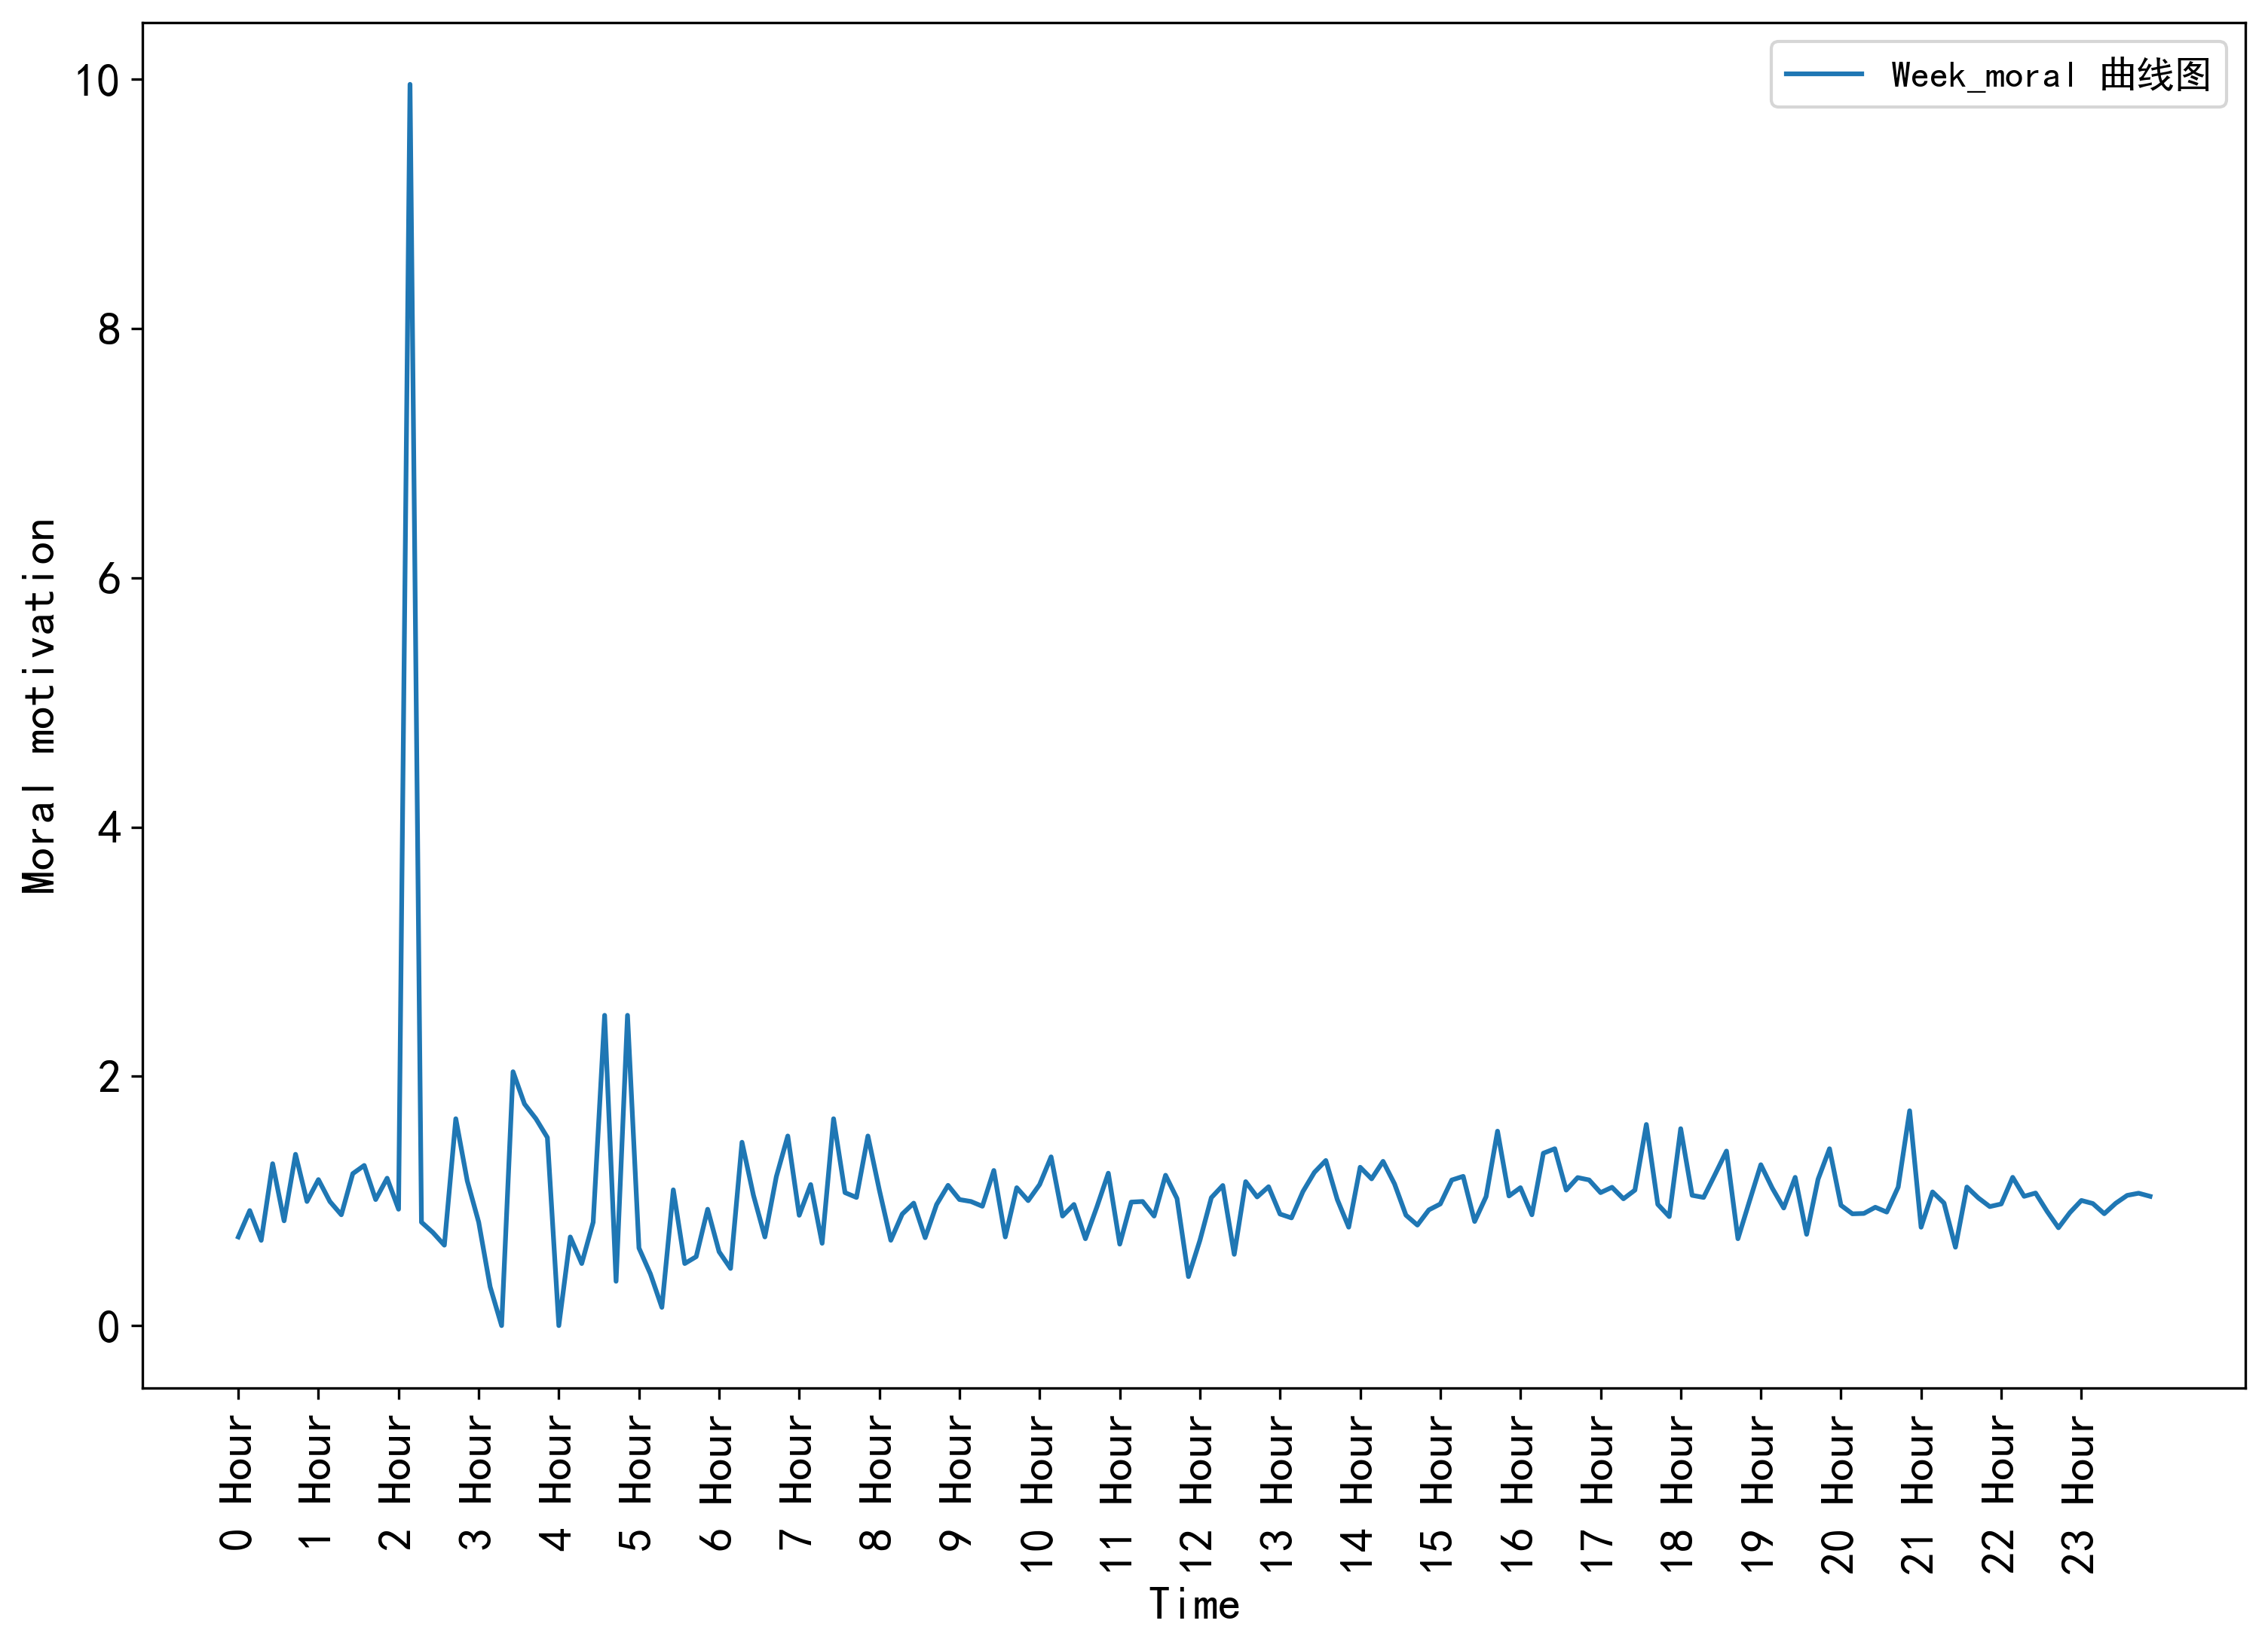

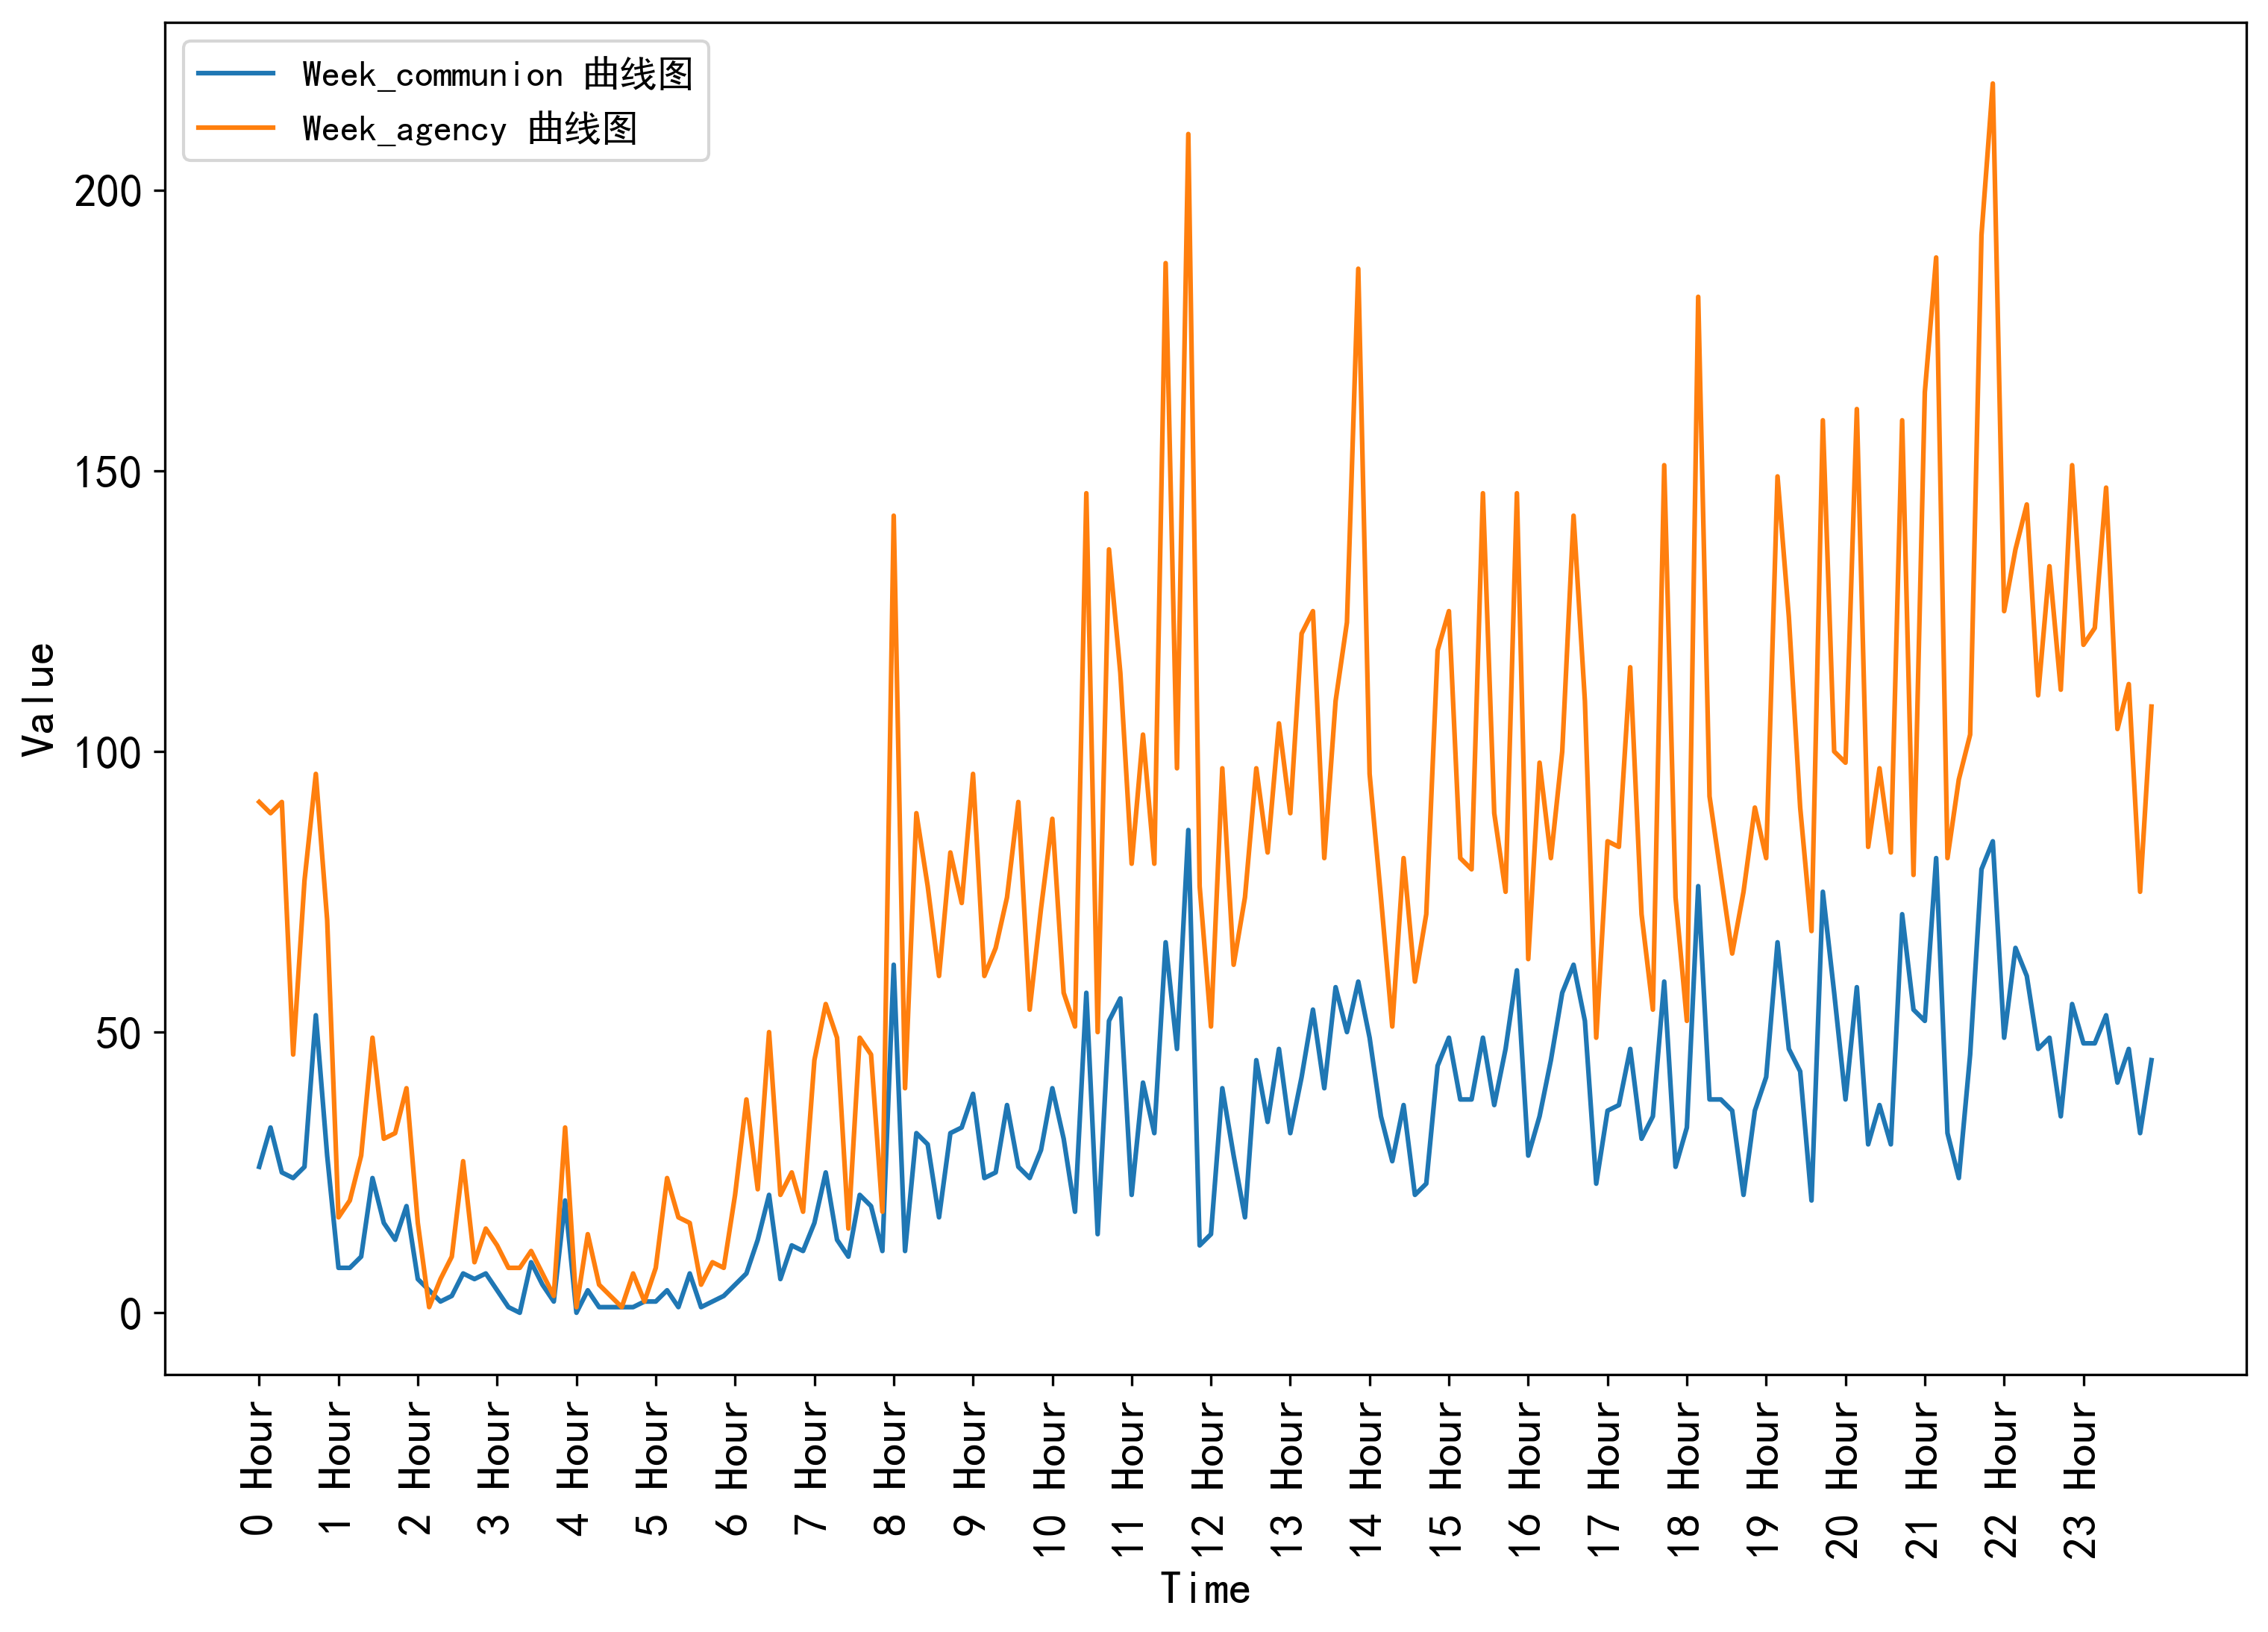

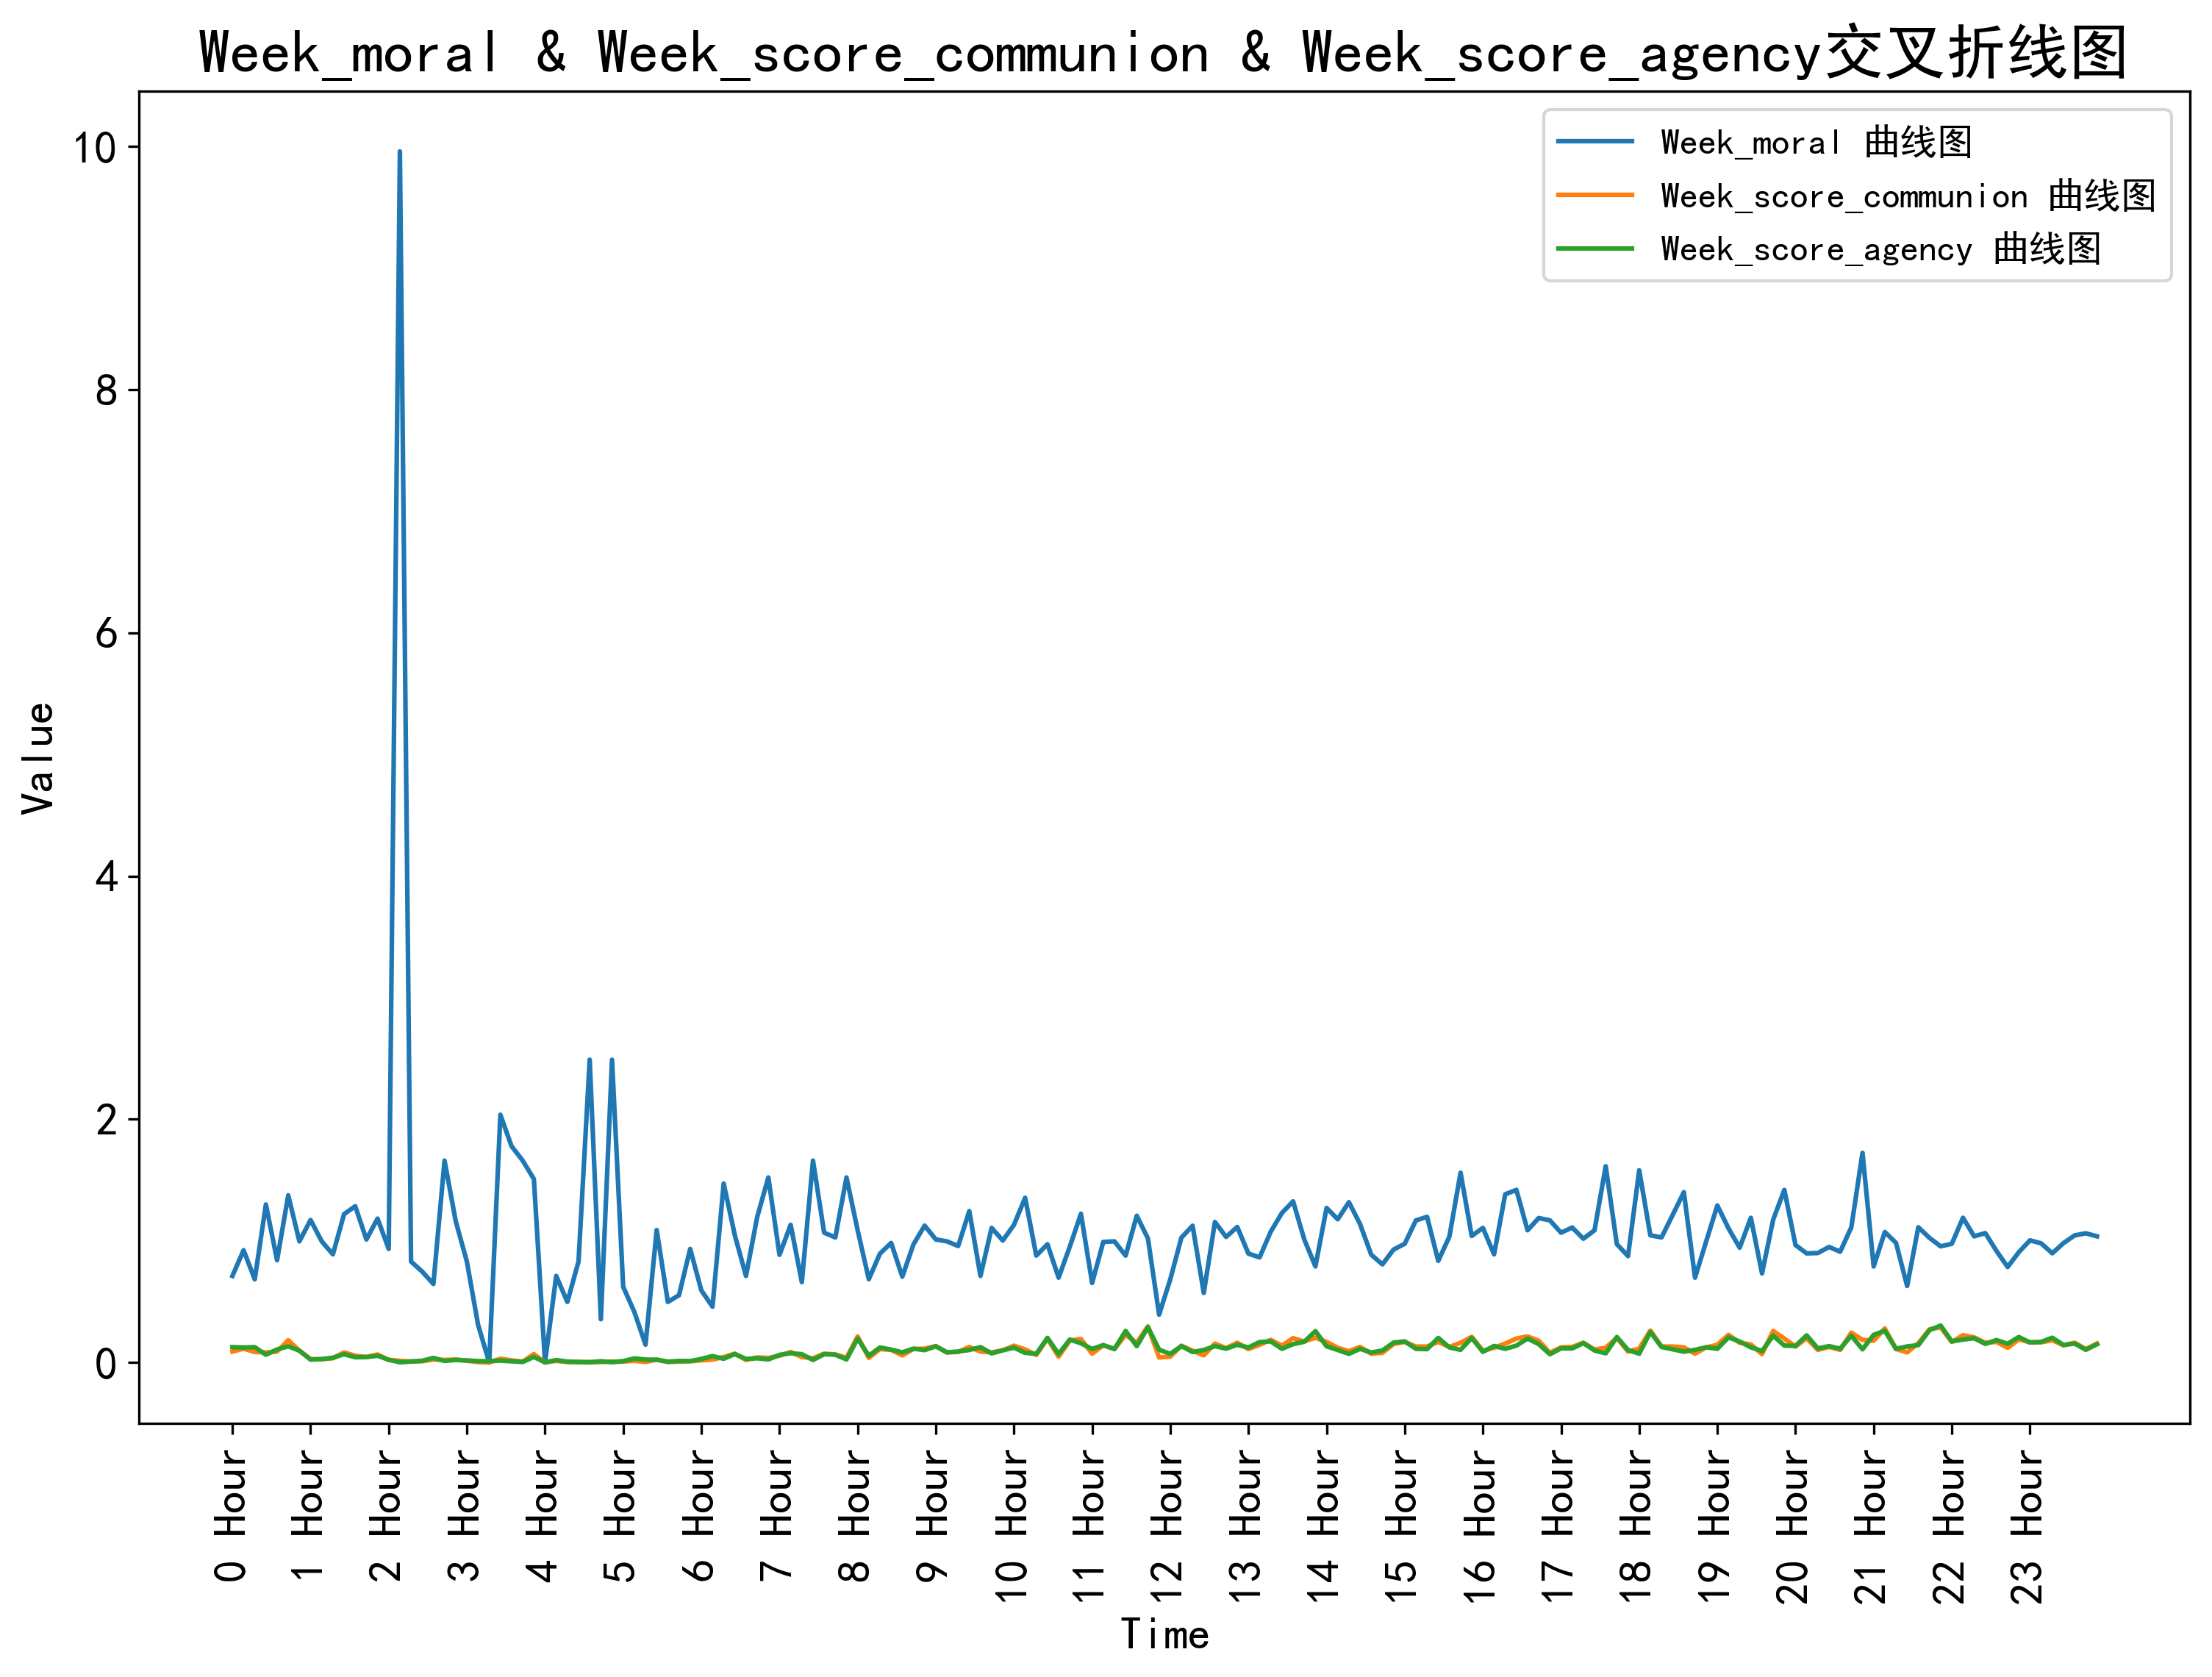

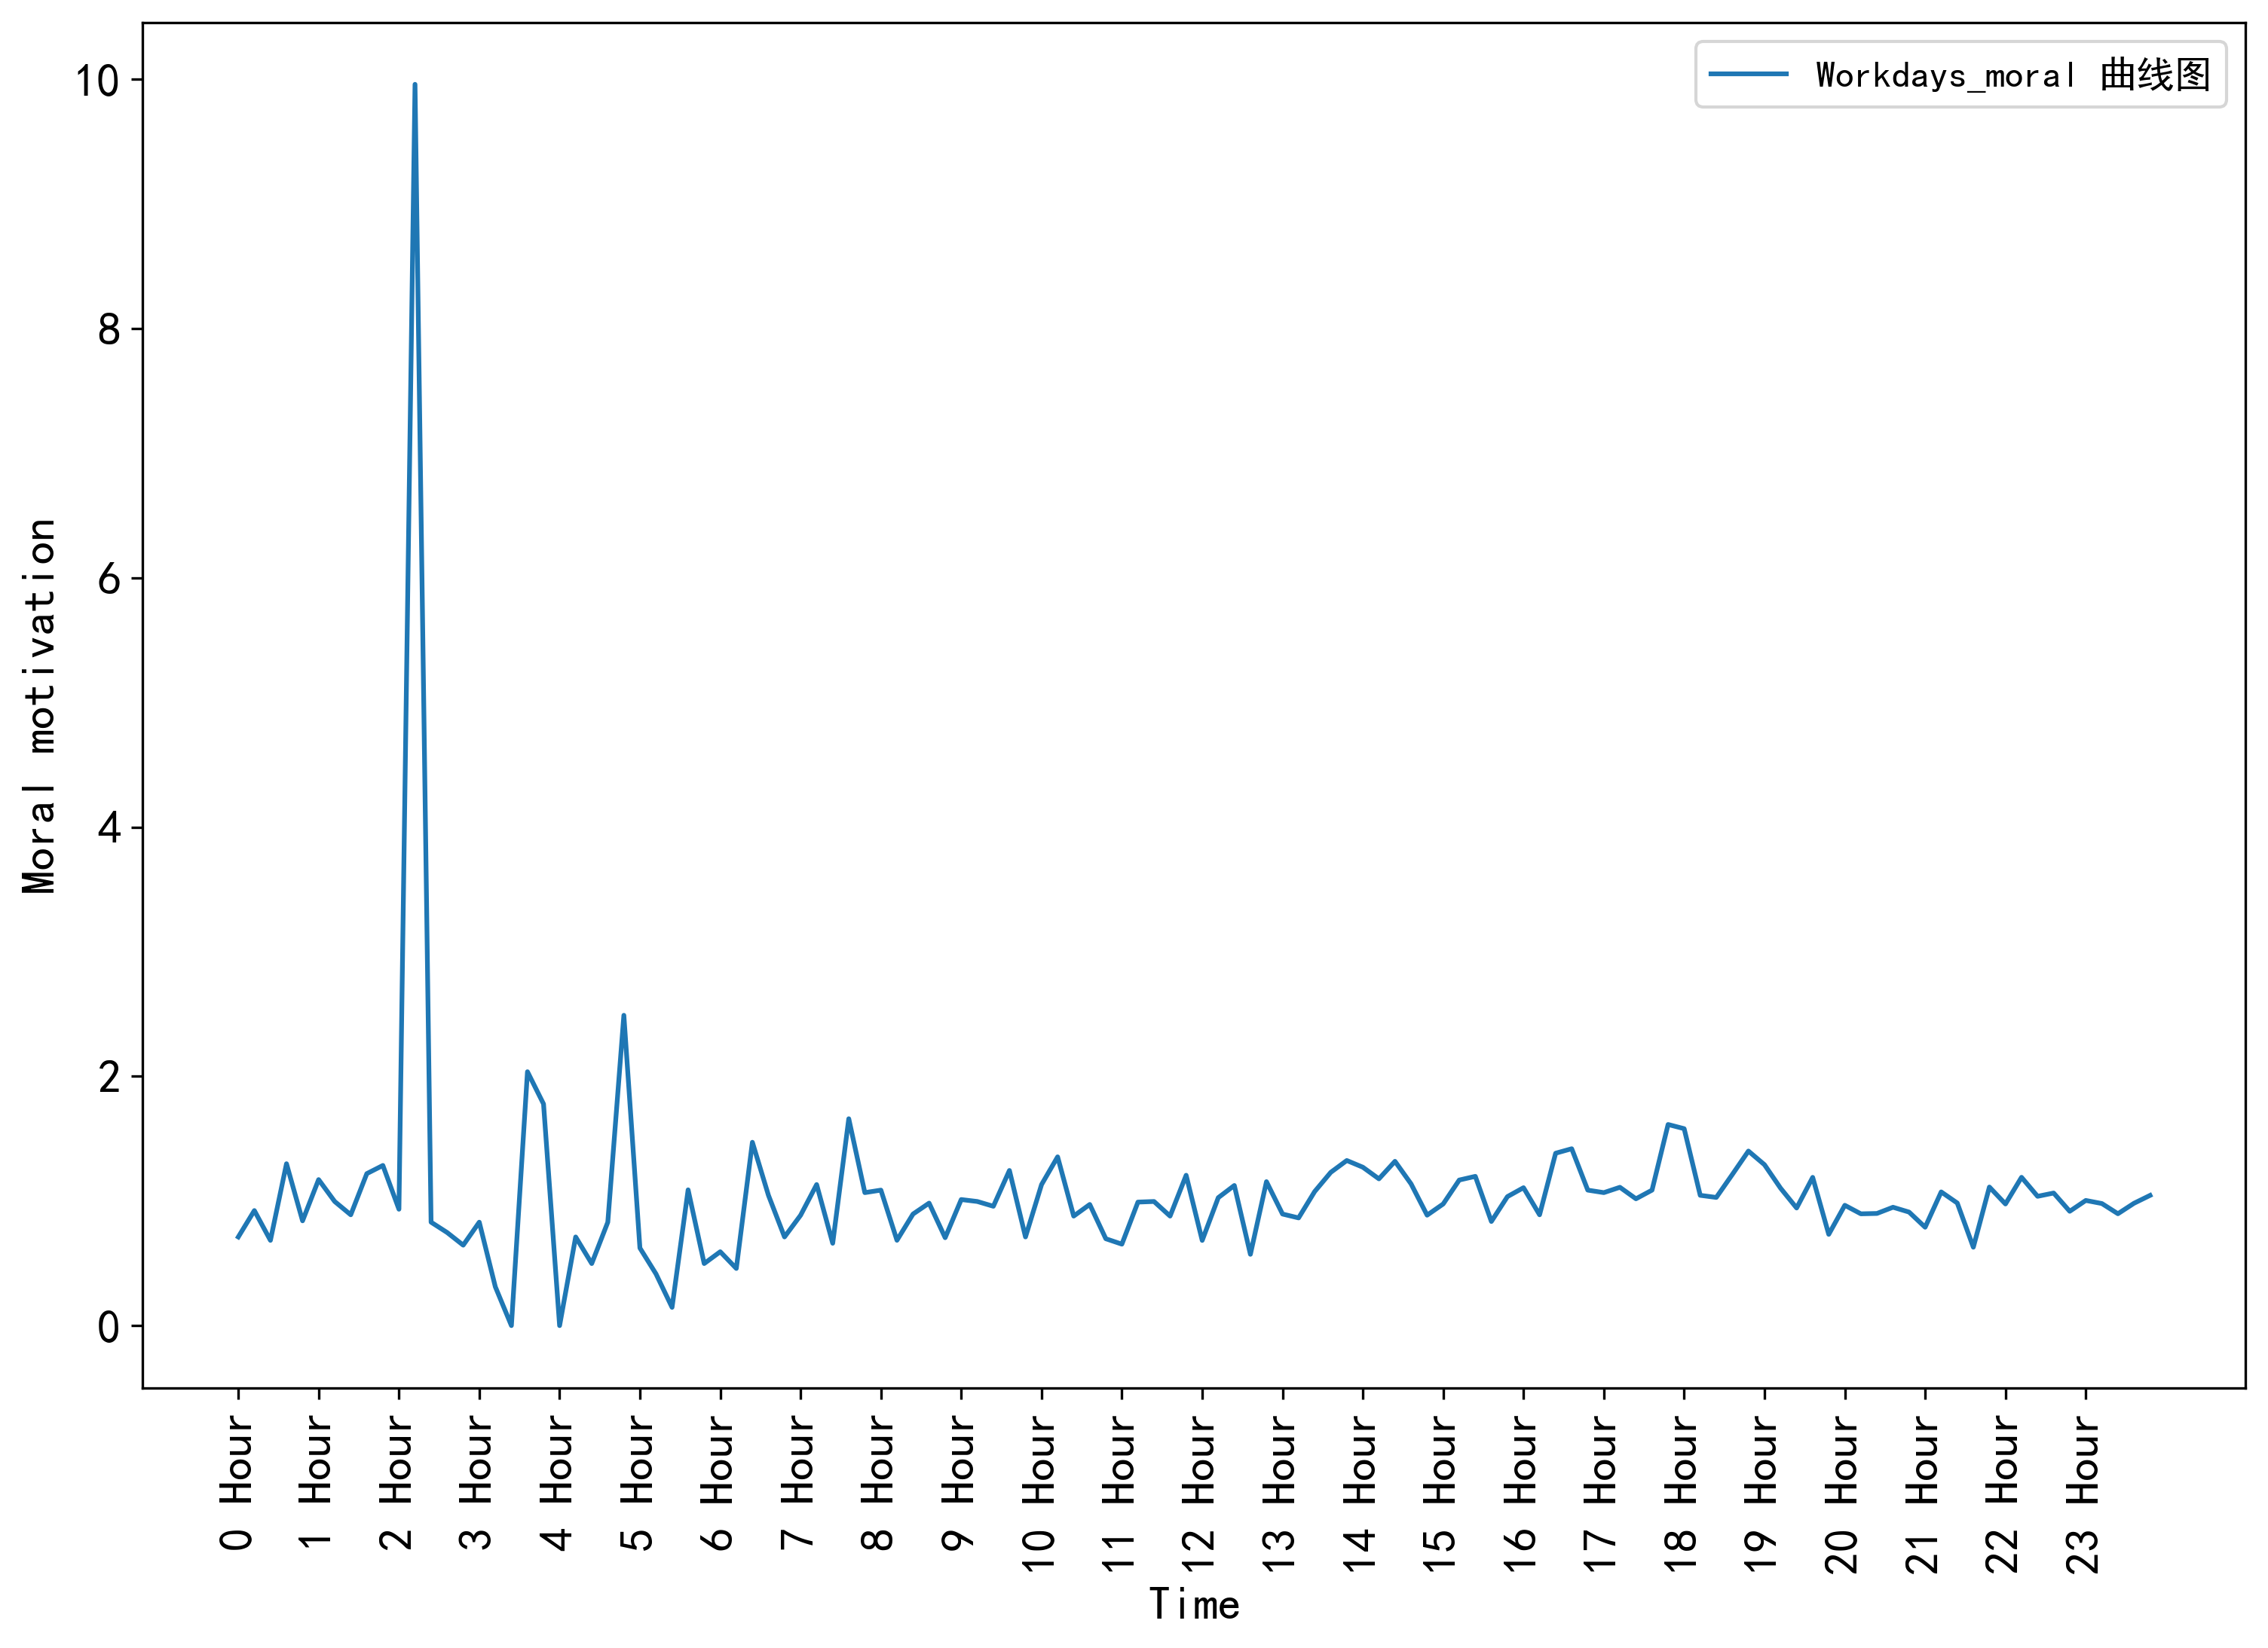

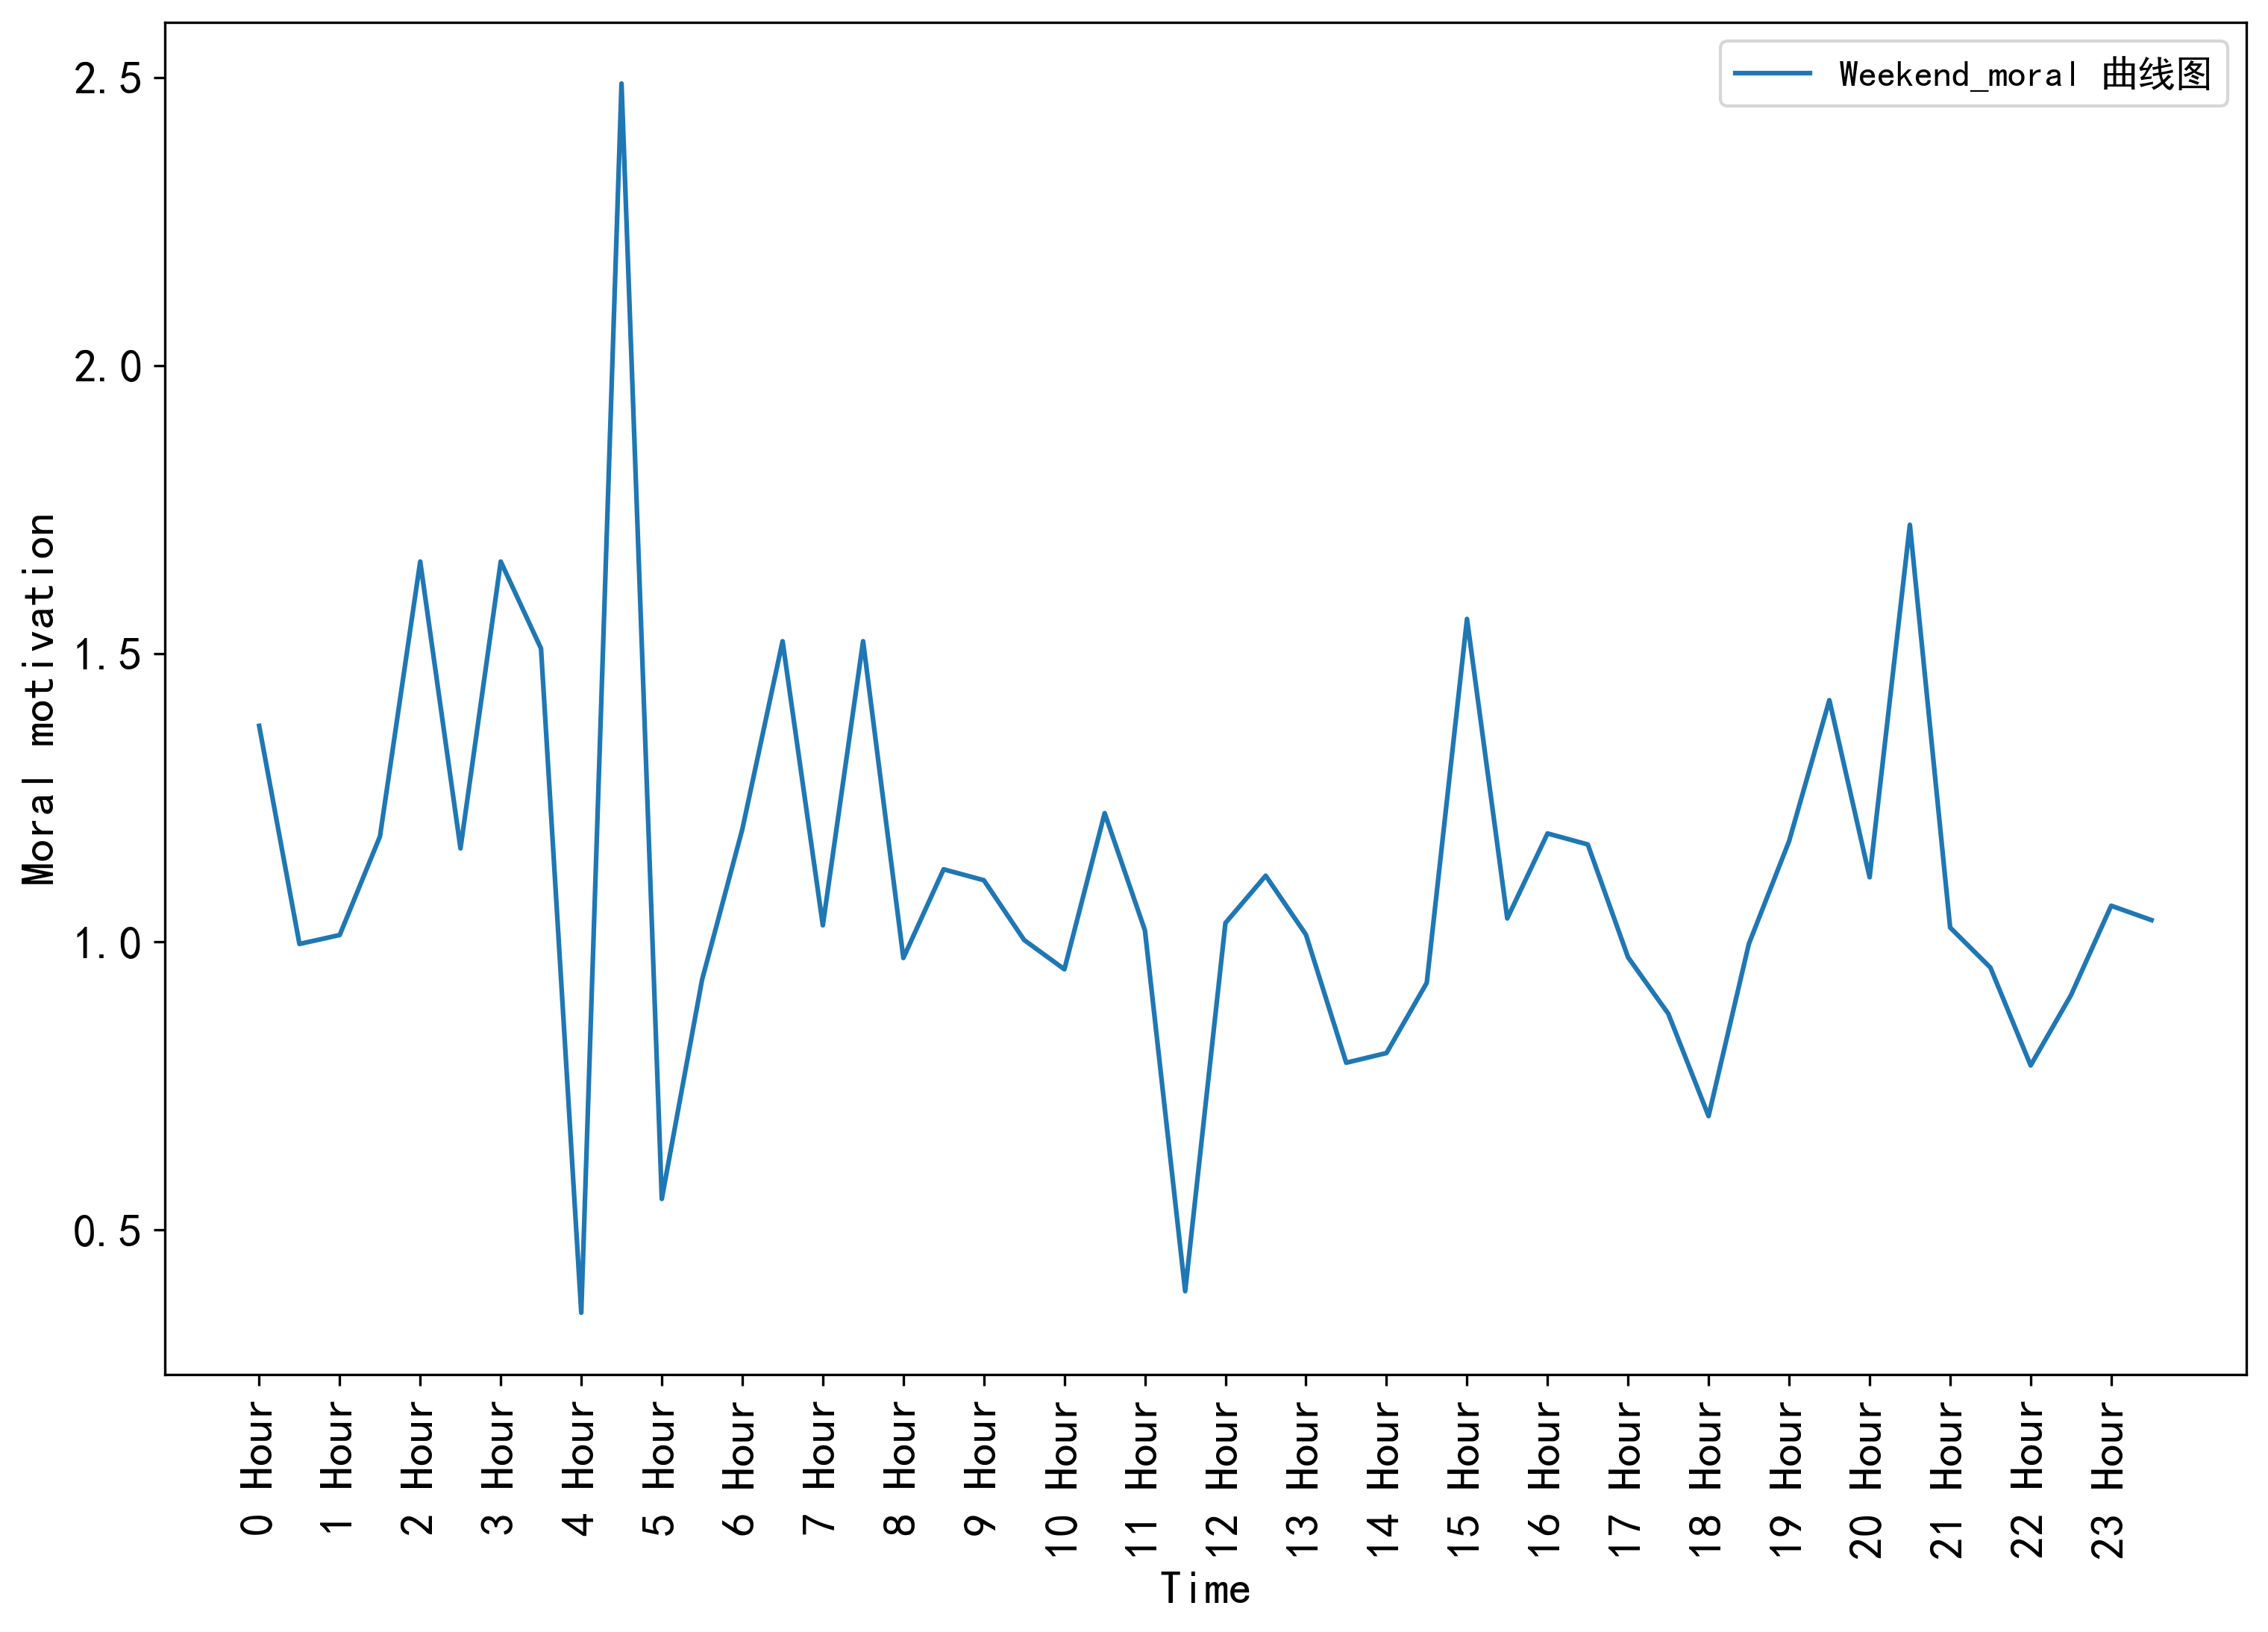

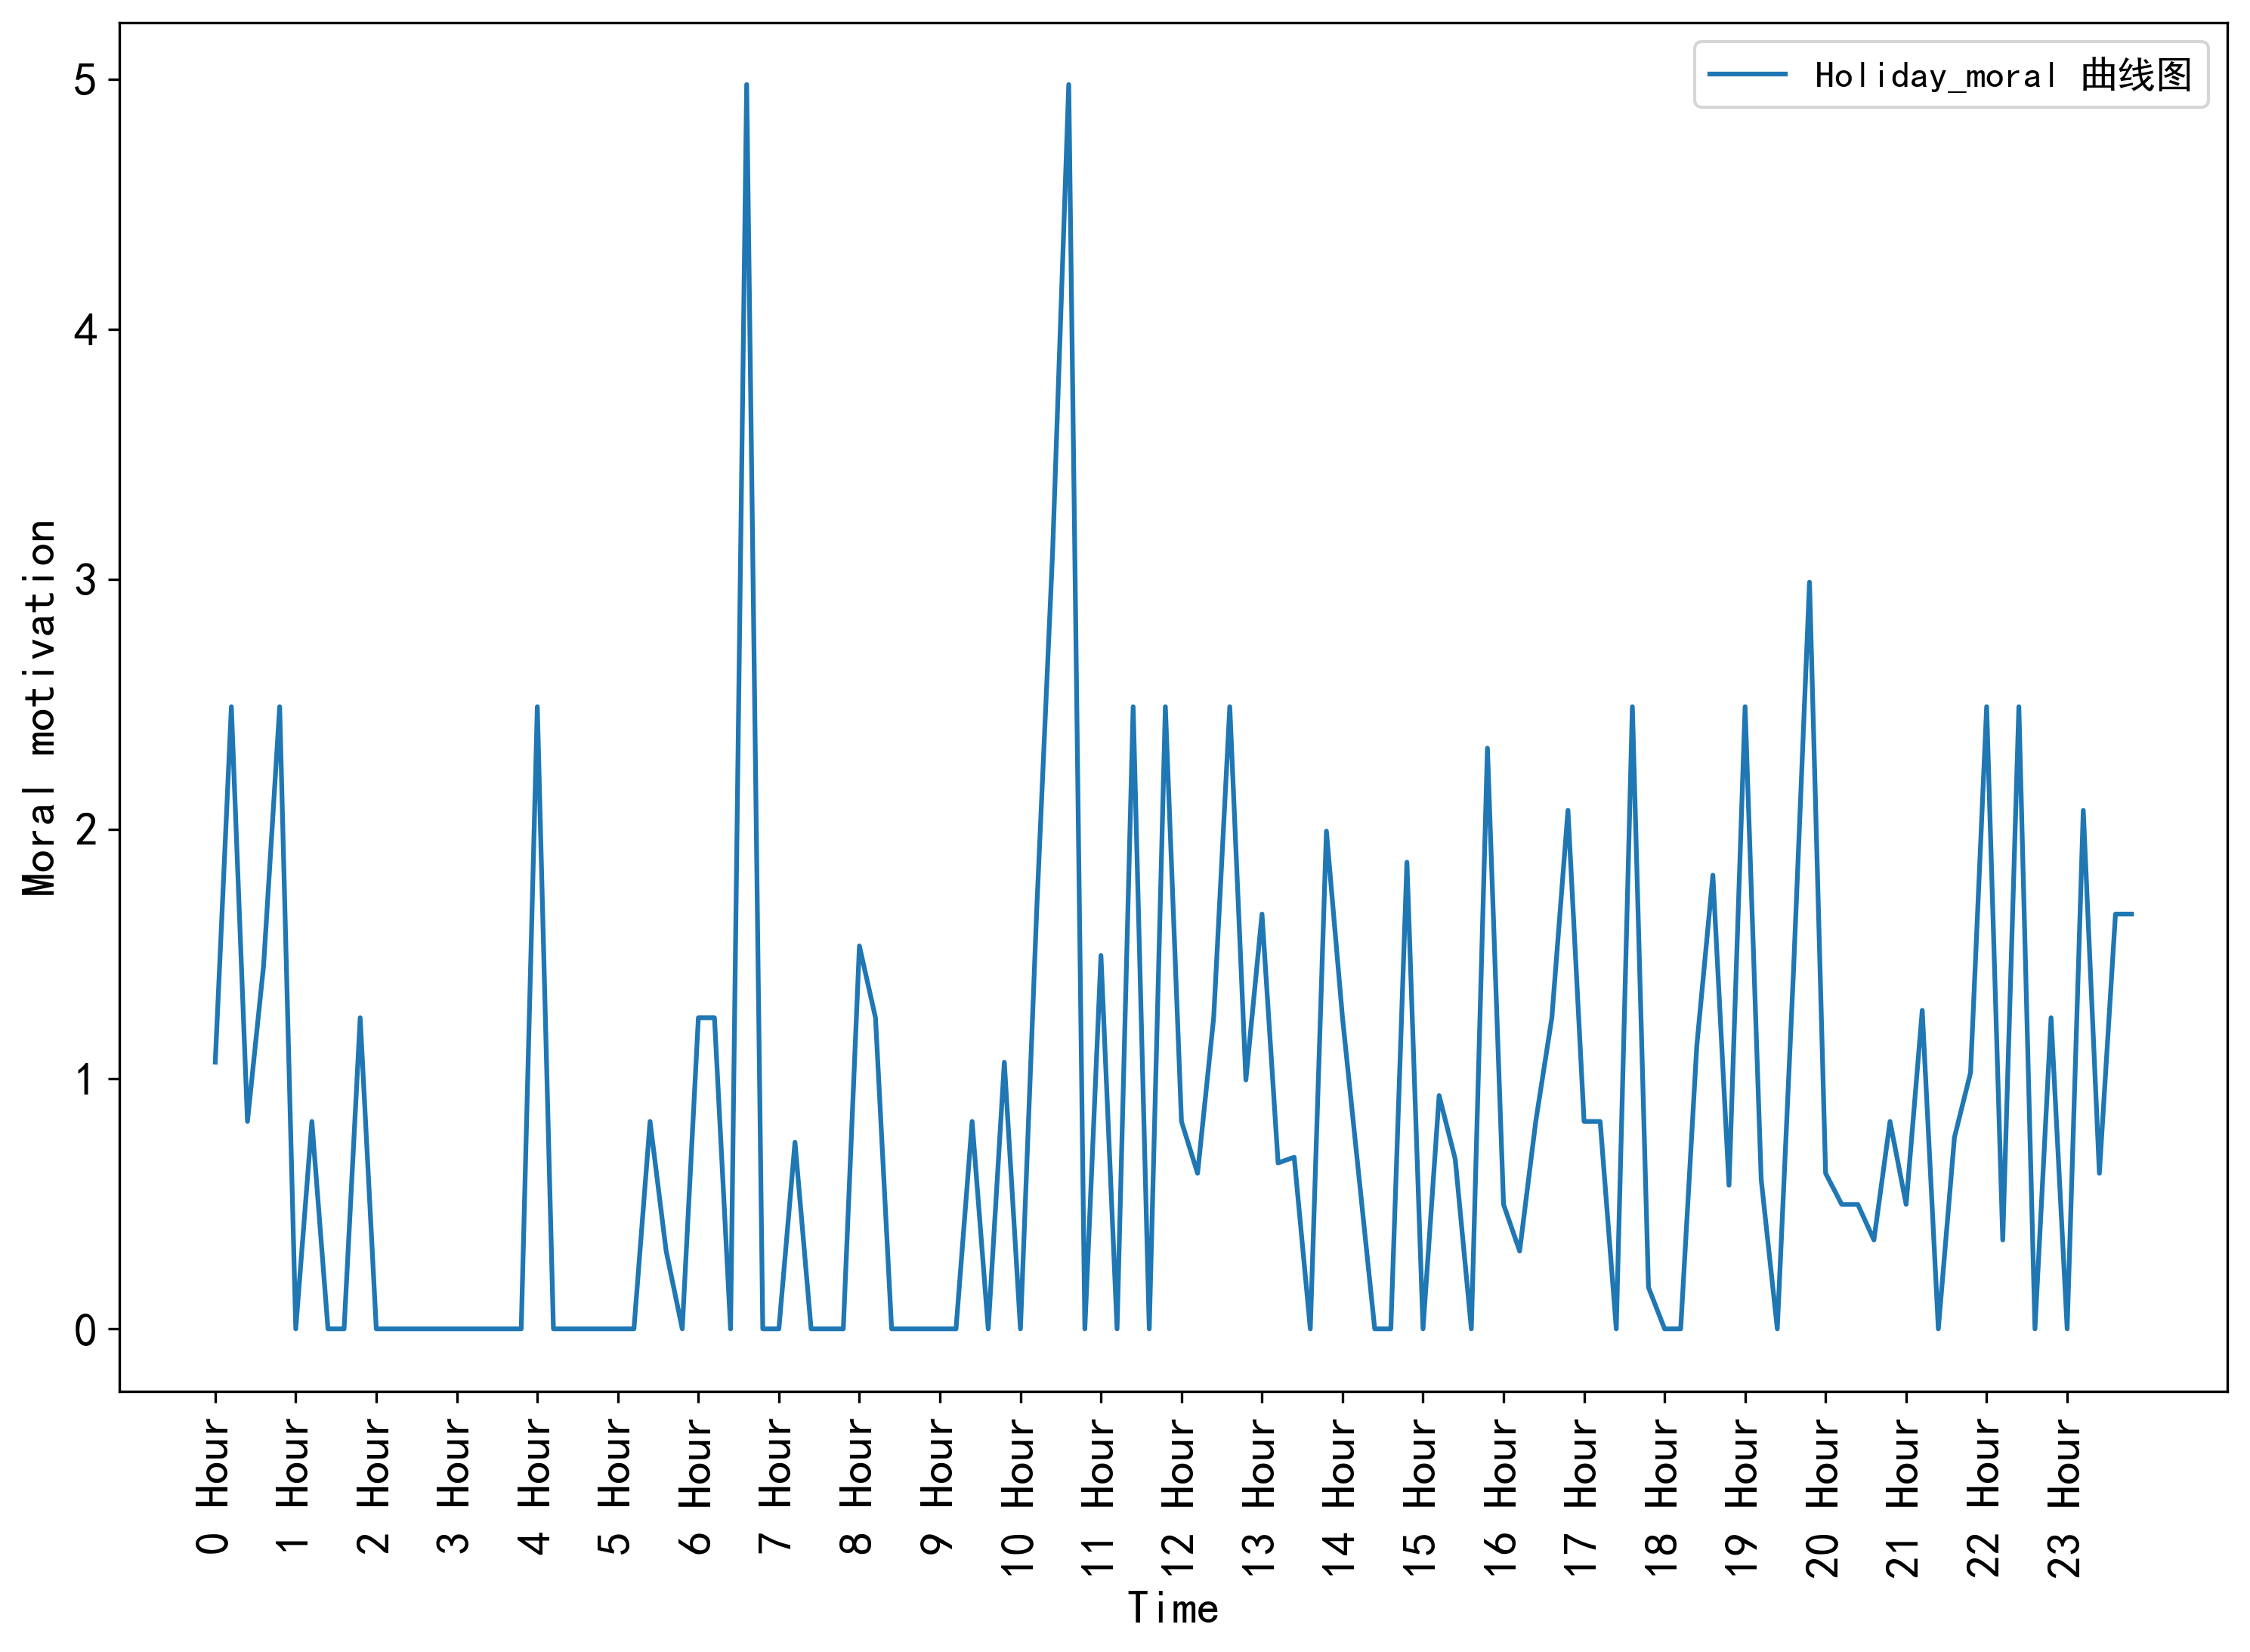

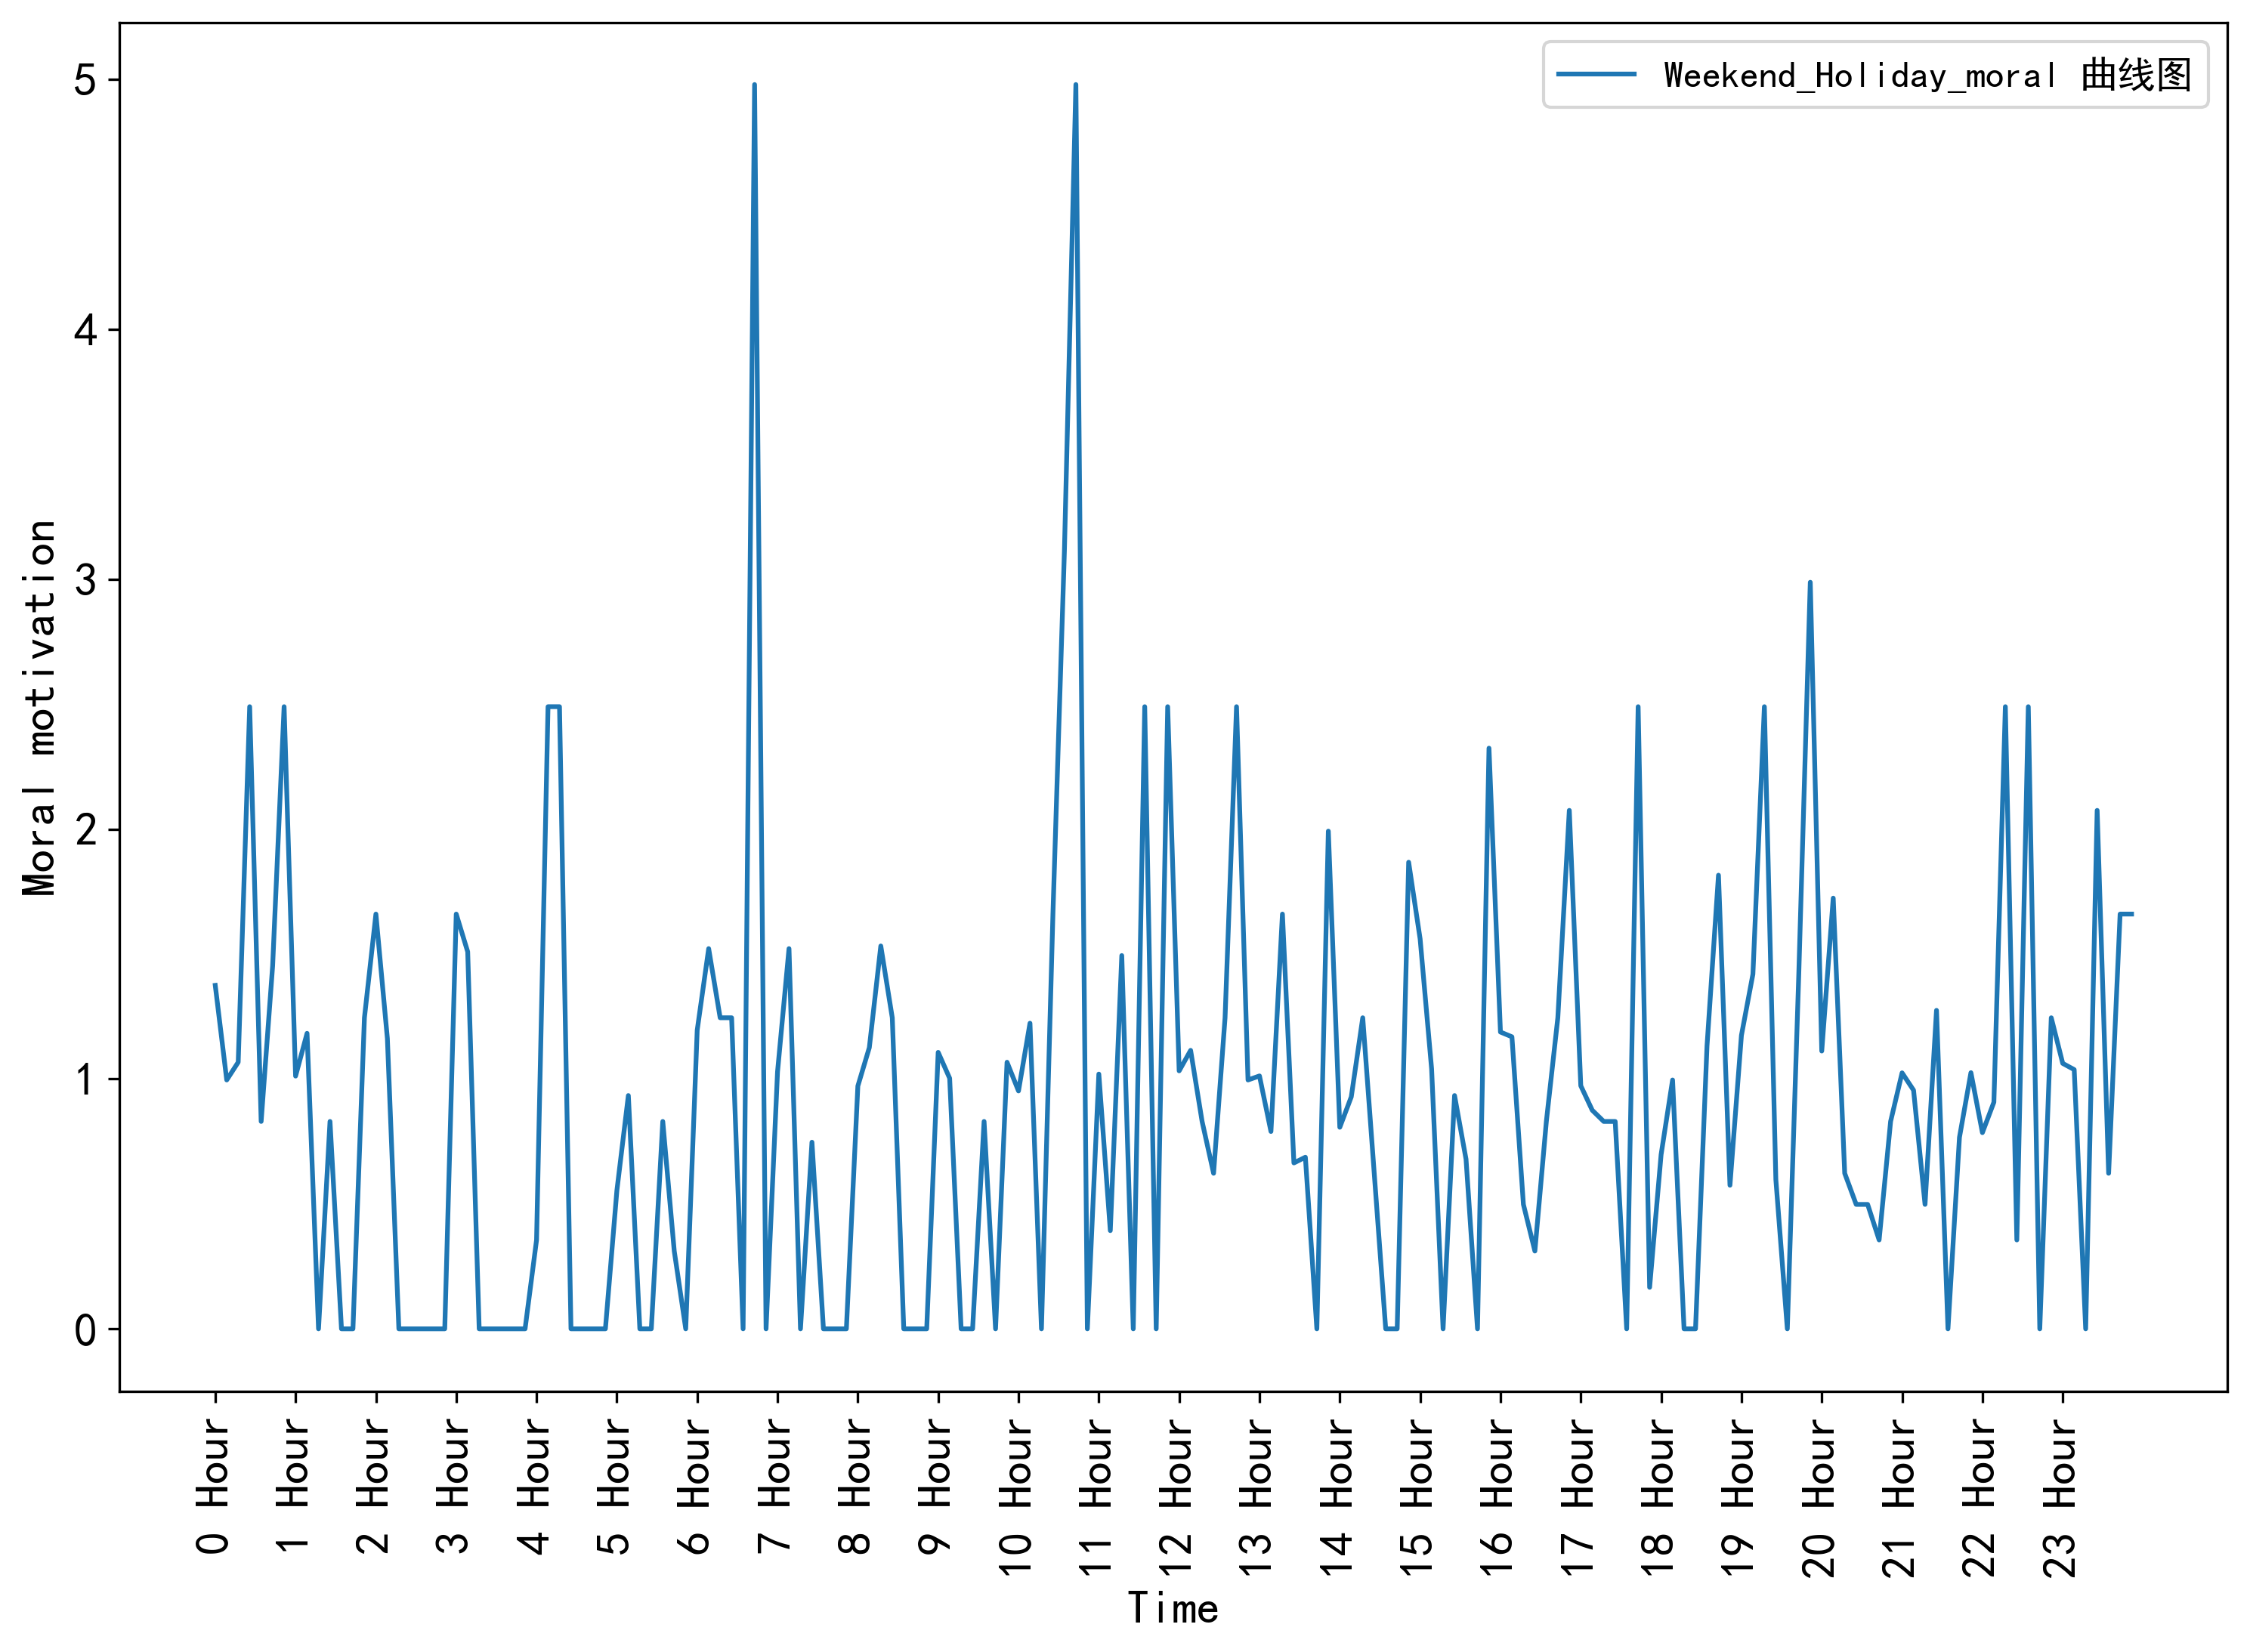

In [13]:
# 六、（6.1）折线画图
# week全量数据

week_graph = get_line_ori1(week_moral,'Week_moral',168,7)
week_graph2 = get_line_ori2(week_communion,week_agency,'Week_communion','Week_agency',168,7)
week_graph3 = get_line_ori(week_moral,week_score_communion,week_score_agency,'Week_moral','Week_score_communion','Week_score_agency',168,7)

# workdays数据
workdays_graph = get_line_ori1(workdays_moral,'Workdays_moral',120,5)
# weekend数据
weekend_graph = get_line_ori1(weekend_moral,'Weekend_moral',48,2)
# holiday数据
holiday_graph = get_line_ori1(holiday_moral,'Holiday_moral',120,5)
# weekend_holiday数据
weekend_holiday_graph = get_line_ori1(weekend_holiday_moral,'Weekend_Holiday_moral',168,7)

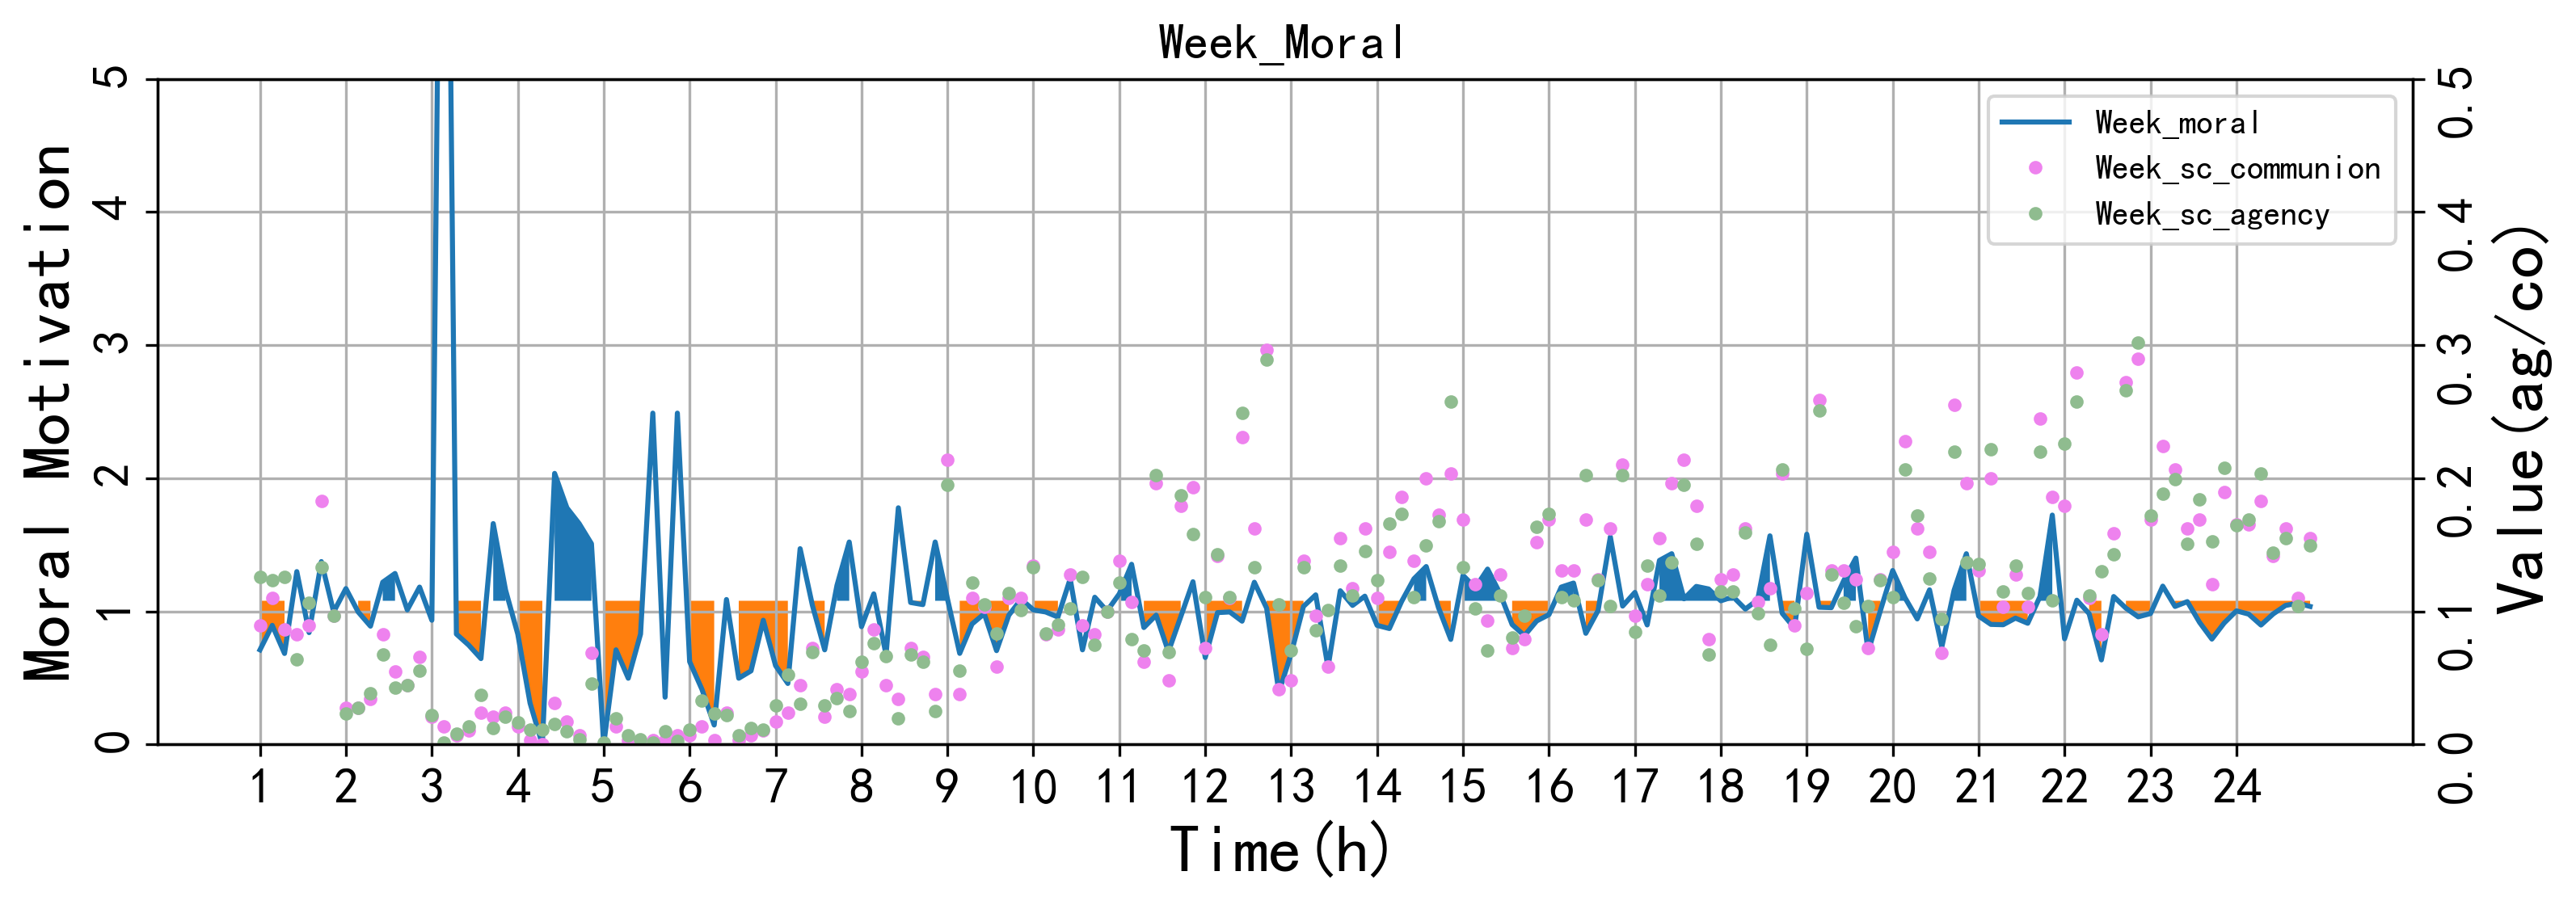

1.079771918284641


In [12]:
 # 画双y轴折线图（测试代码）
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from matplotlib import rc
rc('mathtext',default='regular')

time = range(max(len(week_moral),len(week_score_communion),len(week_score_agency)))
data1 = week_moral
data2 = week_score_communion
data3 = week_score_agency


fig = plt.figure(figsize=(12,8),dpi=300)
ax = fig.add_subplot(211)
#bax = brokenaxes(ylims=((0,4),(9,11)),hspace=0.05,despine=False)
lns1 = ax.plot(time,data1,'-',label='Week_moral')
ax2 = ax.twinx()
lns2 = ax2.plot(time,data2,'.',label='Week_sc_communion',color='violet')
lns3 = ax2.plot(time,data3,'.',label='Week_sc_agency',color='darkseagreen')
#lns2 = ax2.plot(time,data2,color='lightcoral',marker='.',label='Week_sc_communion')
#lns3 = ax2.plot(time,data3,color='royalblue',marker='.',label='Week_sc_agency')
plt.xticks(np.arange(0,168,step=7),['1','2','3','4','5','6',
                                    '7','8','9','10','11','12',
                                    '13','14','15','16','17','18',
                                    '19','20','21','22','23','24'])

# 图例合并
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc=0,prop={'size':10})
ax.grid()
#坐标轴设置
ax.set_xlabel(u'Time(h)',fontdict={'size':20})
ax.set_ylabel(u'Moral Motivation',fontdict={'size':20})
ax2.set_ylabel(u'Value(ag/co)',fontdict={'size':20})
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(rotation=90,labelsize=15)
ax2.yaxis.set_tick_params(rotation=90,labelsize=15)
ax.set_ylim(0,5)
ax2.set_ylim(0,0.5)
# 对比moral_avg获得阴影
# 改变阴影部分颜色
# ax.fill_between(time,week_moral,week_moral_avg,where=week_moral>=week_moral_avg,facecolor='green')
ax.fill_between(time,week_moral,week_moral_avg,where=week_moral>=week_moral_avg)
ax.fill_between(time,week_moral,week_moral_avg,where=week_moral<=week_moral_avg)
ax.set_title('Week_Moral',fontsize=15)
#plt.title(u'%s & %s & %s交叉折线图'%(name1,name2,name3),fontdict={'size':20})
plt.show()
print(week_moral_avg)

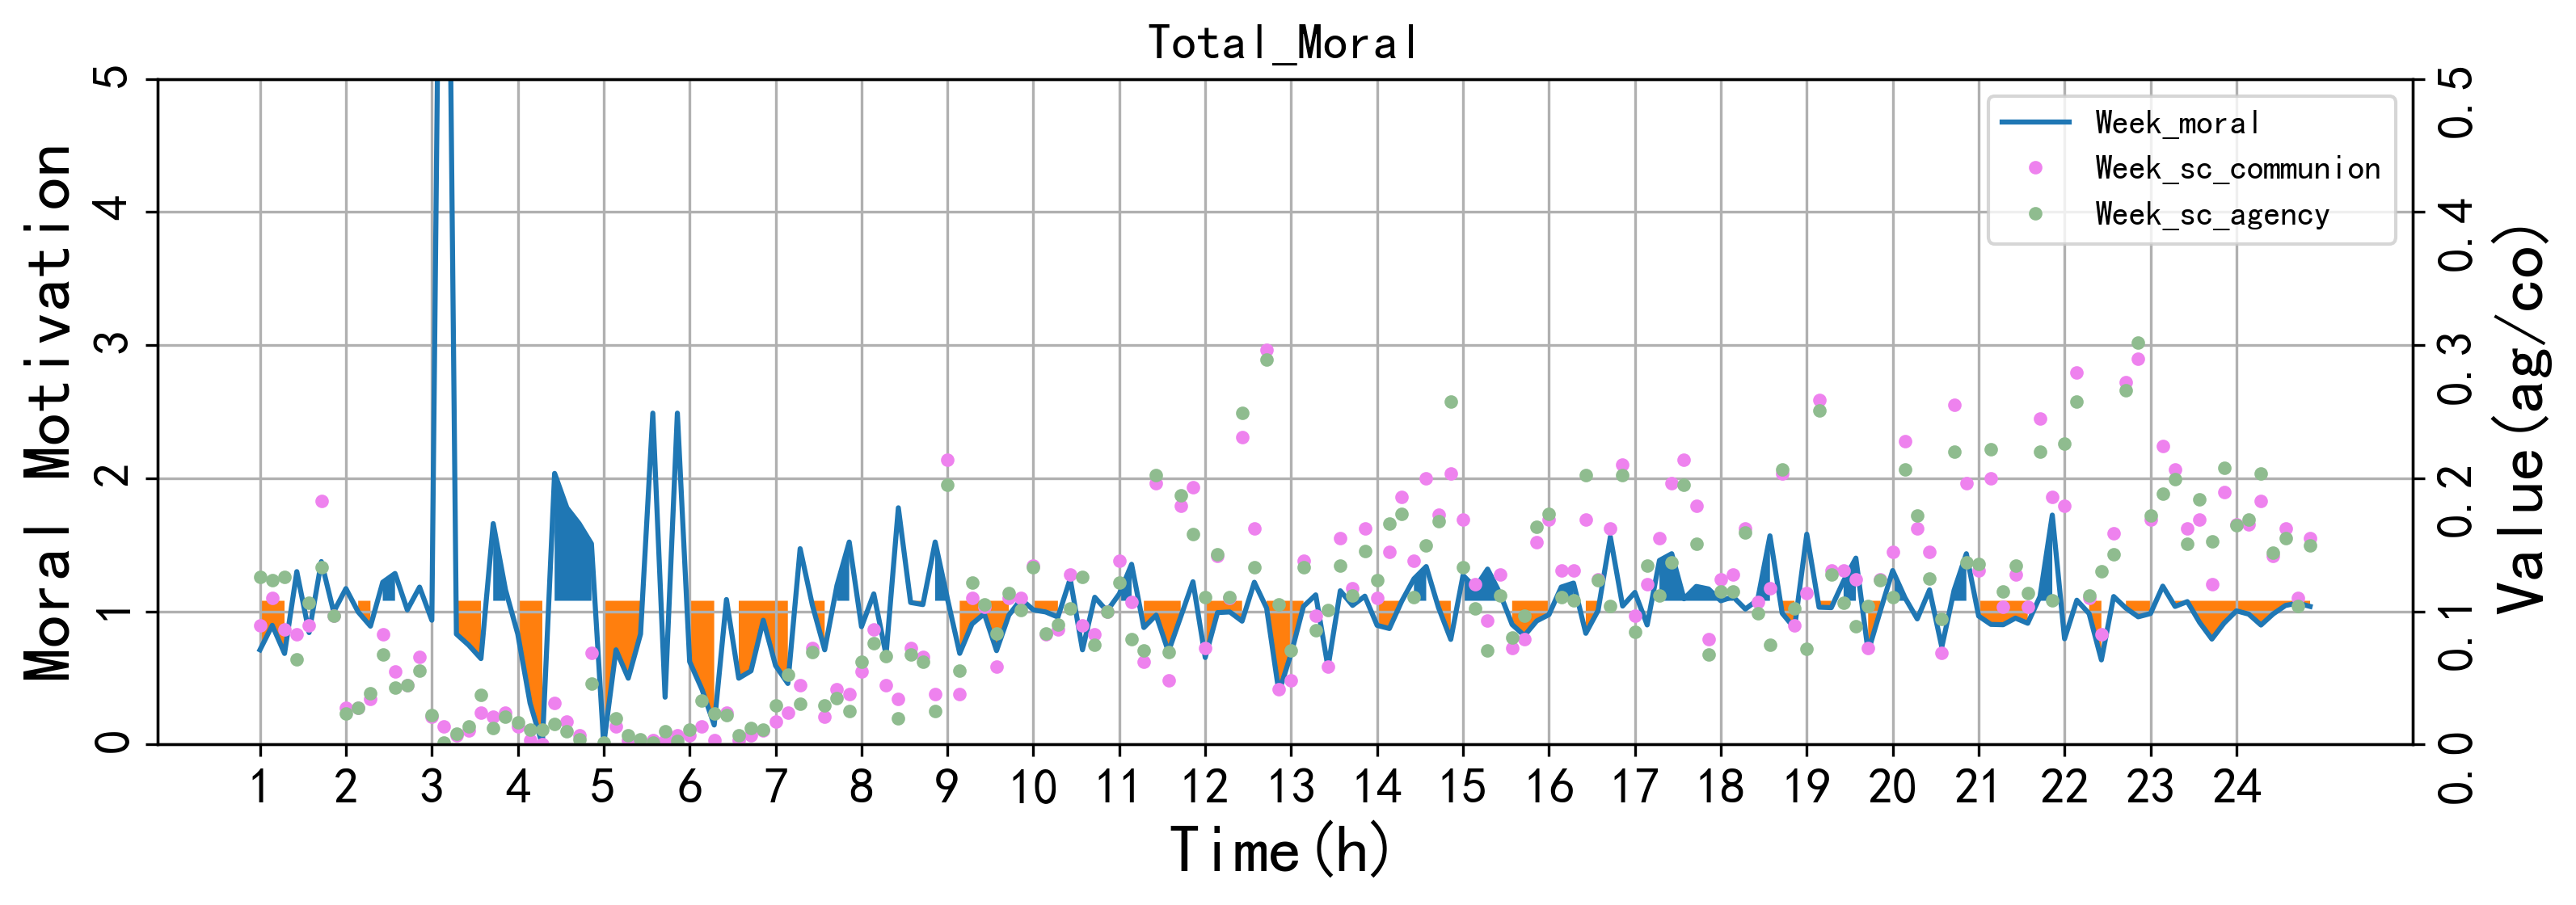

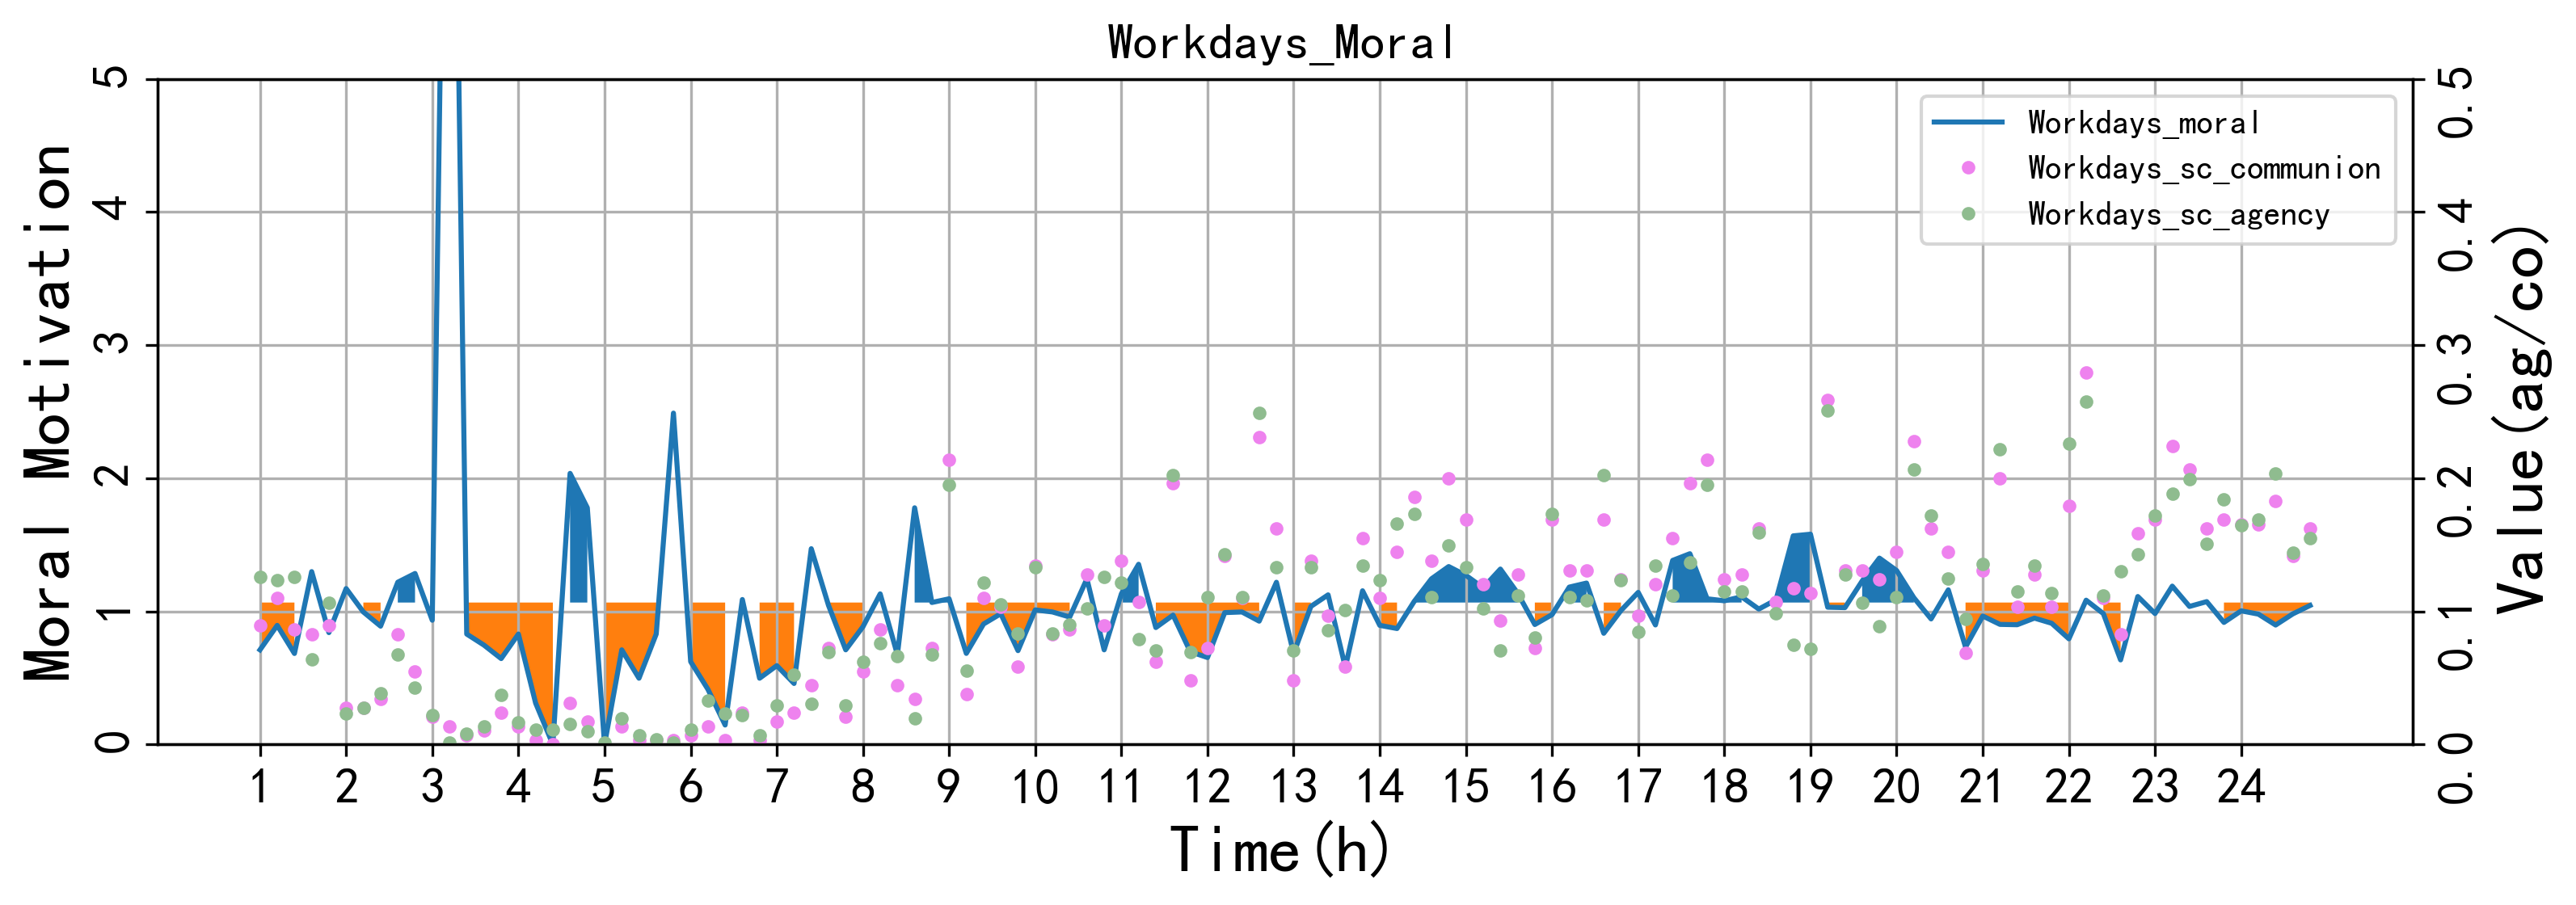

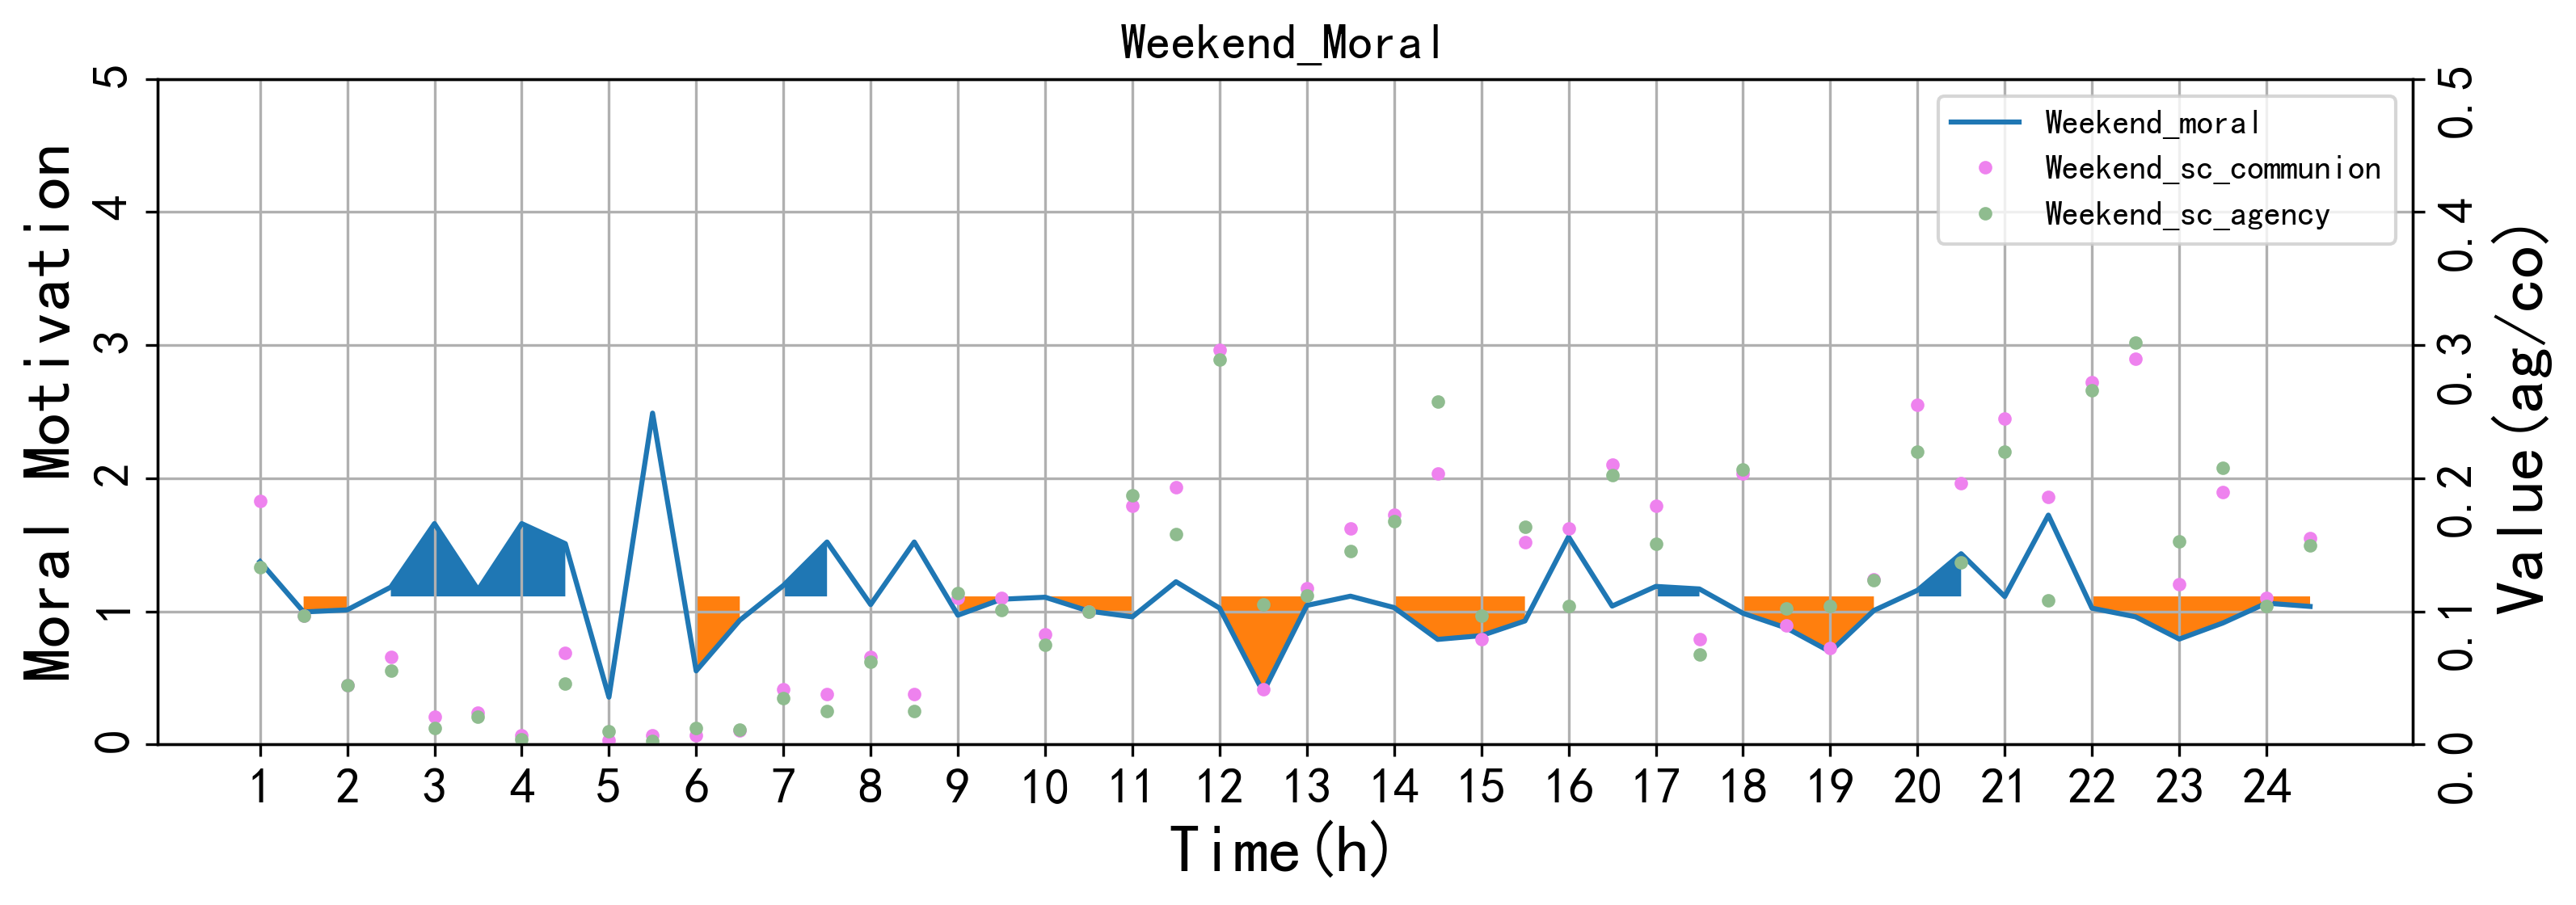

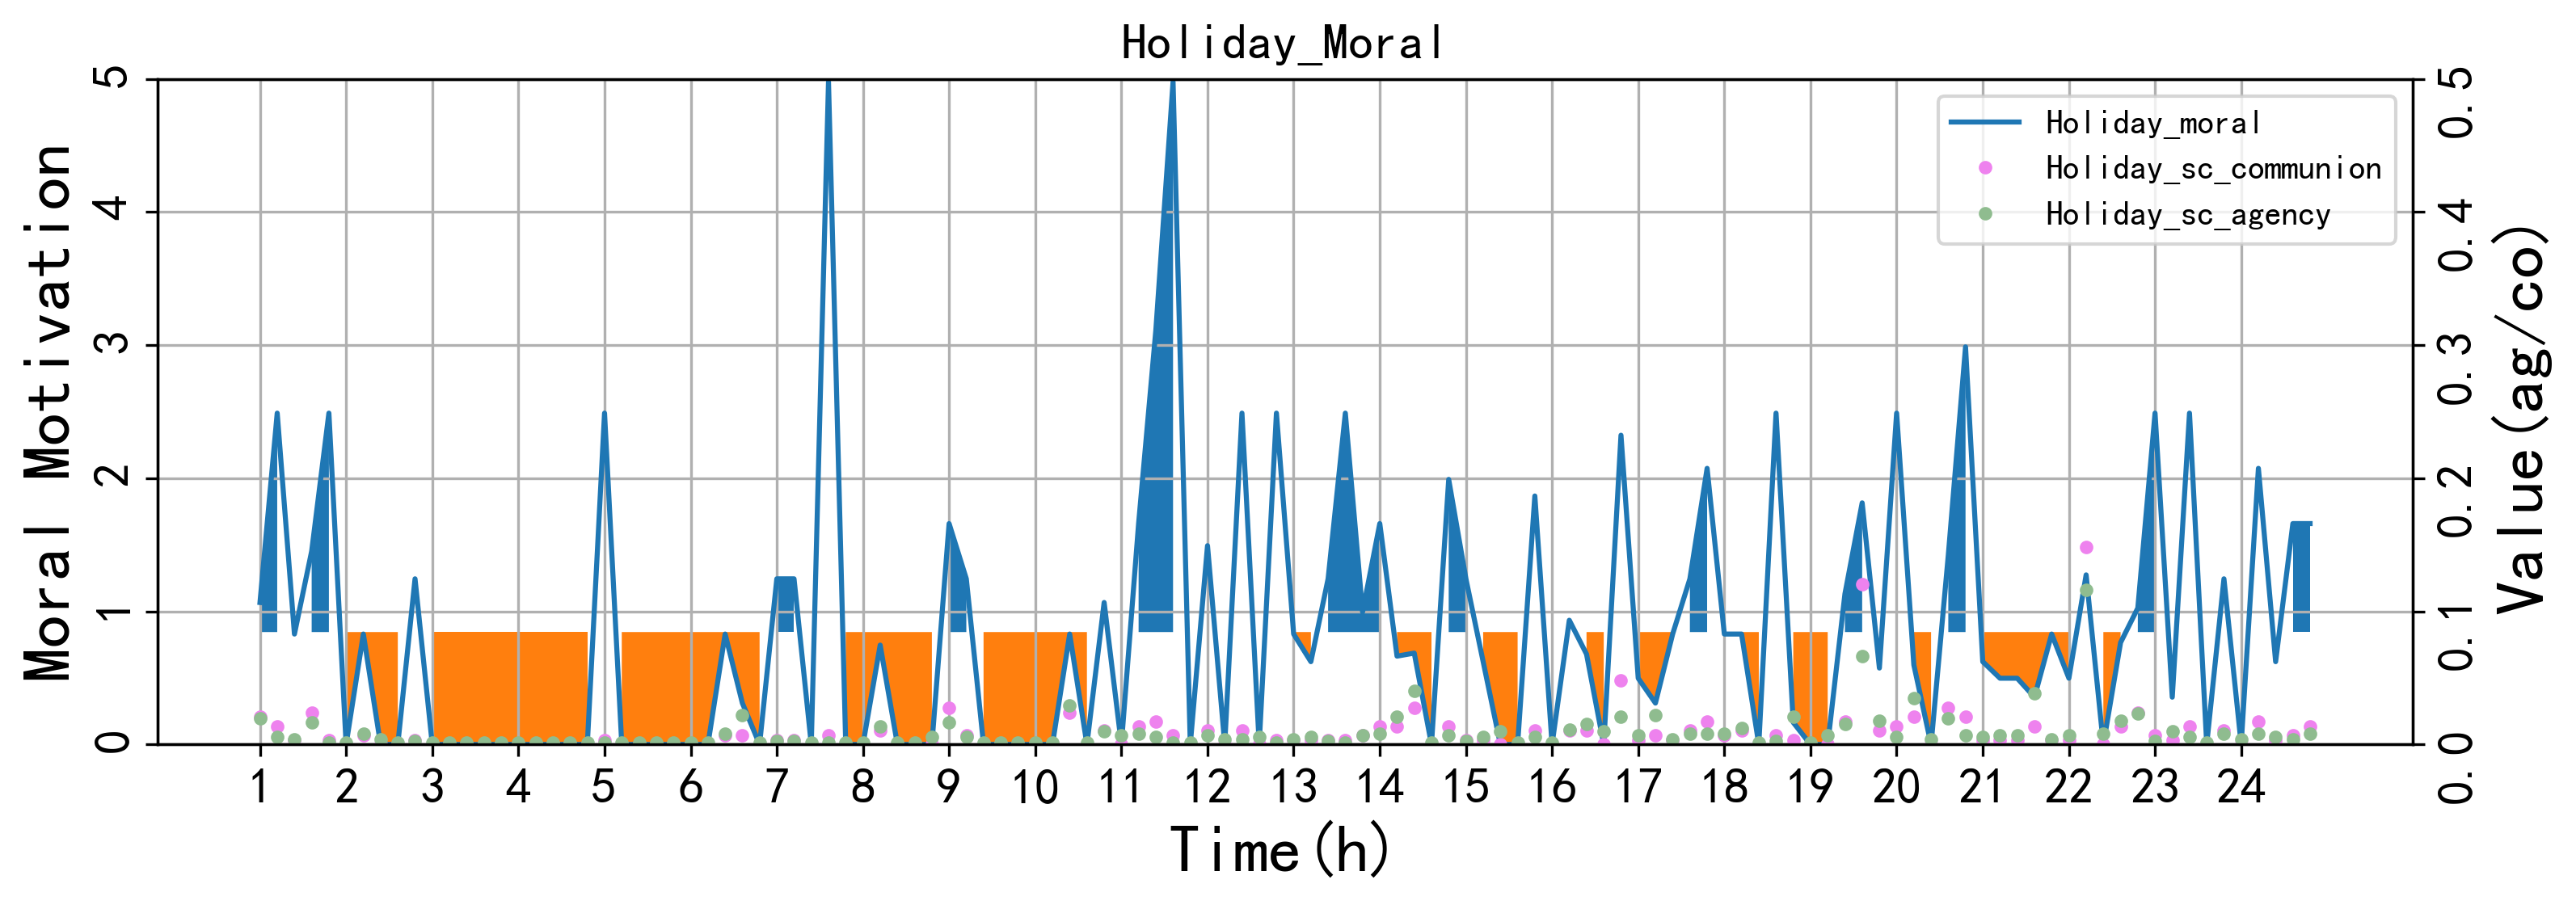

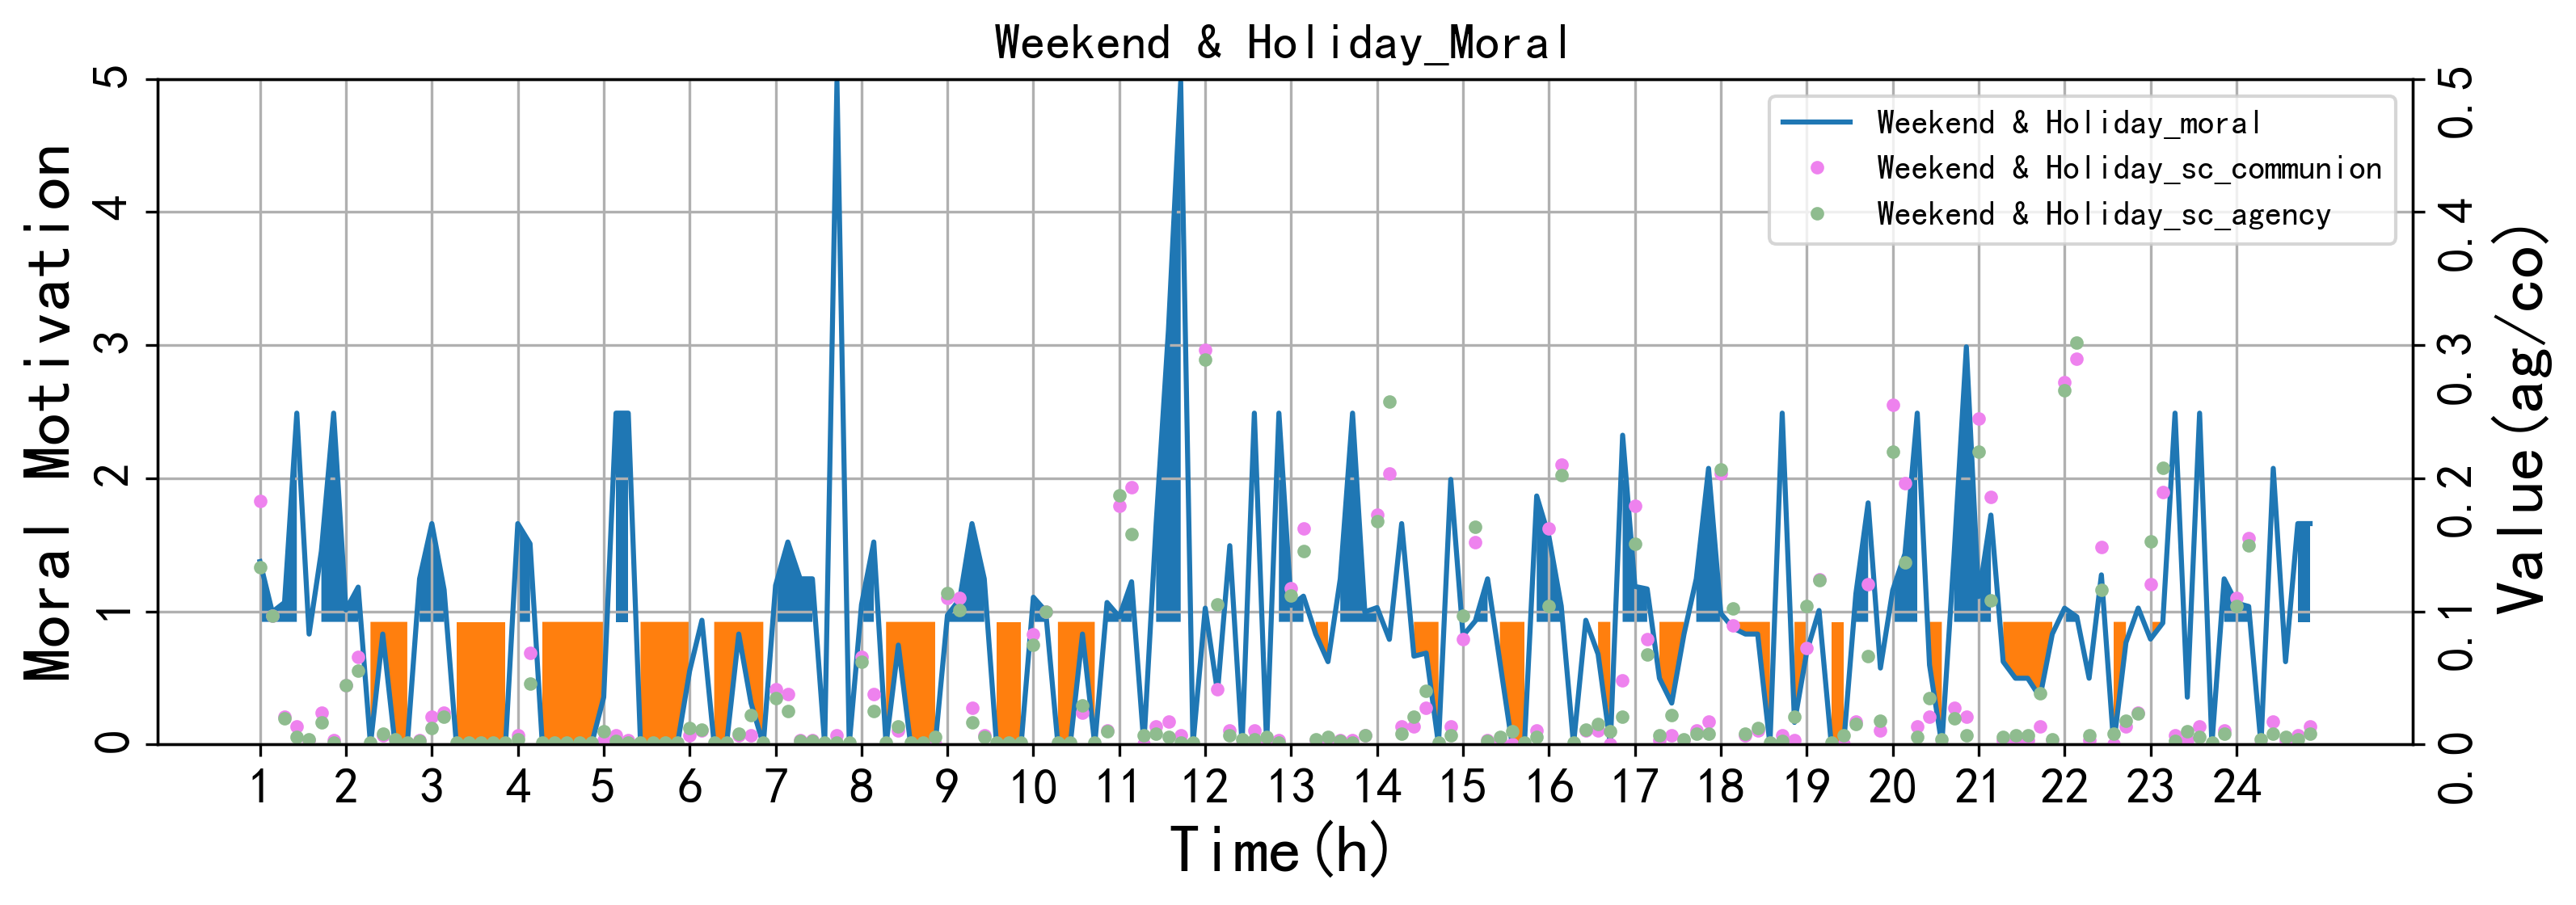

total_moral: 1.079771918284641
workdays_moral: 1.0666028395551272
weekend_moral: 1.112694615108426
holiday_moral: 0.8449001301276768
weekend_holiday_moral 0.9214128401221767


In [13]:
 # 画双y轴折线图
data1 = week_moral
data2 = week_score_communion
data3 = week_score_agency
def get_moral_scene(data1,data2,data3,data4,name1,name2,name3,title,length,stp,lim1,lim2):
    # 导入所需包
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('mathtext',default='regular')
    # 设置图数据
    time = range(max(len(data1),len(data2),len(data3)))
    fig = plt.figure(figsize=(12,8),dpi=300)
    ax = fig.add_subplot(211)
    lns1 = ax.plot(time,data1,'-',label='%s'%name1)
    ax2 = ax.twinx()
    lns2 = ax2.plot(time,data2,'.',label='%s'%name2,color='violet')
    lns3 = ax2.plot(time,data3,'.',label='%s'%name3,color='darkseagreen')
    plt.xticks(np.arange(0,length,step=stp),['1','2','3','4','5','6',
                                        '7','8','9','10','11','12',
                                        '13','14','15','16','17','18',
                                        '19','20','21','22','23','24'])
    # 图例合并
    lns = lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns,labs,loc=0,prop={'size':10})
    ax.grid()
    #坐标轴设置
    ax.set_xlabel(u'Time(h)',fontdict={'size':20})
    ax.set_ylabel(u'Moral Motivation',fontdict={'size':20})
    ax2.set_ylabel(u'Value(ag/co)',fontdict={'size':20})
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(rotation=90,labelsize=15)
    ax2.yaxis.set_tick_params(rotation=90,labelsize=15)
    ax.set_ylim(0,lim1)
    ax2.set_ylim(0,lim2)
    # 对比moral_avg获得阴影
    # 改变阴影部分颜色
    # ax.fill_between(time,week_moral,week_moral_avg,where=week_moral>=week_moral_avg,facecolor='green')
    ax.fill_between(time,data1,data4,where=data1>=data4)
    ax.fill_between(time,data1,data4,where=data1<=data4)
    ax.set_title('%s'%title,fontsize=15)
    #plt.title(u'%s & %s & %s交叉折线图'%(name1,name2,name3),fontdict={'size':20})
    plt.show()

graph_week_moral = get_moral_scene(week_moral,week_score_communion,week_score_agency,week_moral_avg,
                                   'Week_moral','Week_sc_communion','Week_sc_agency','Total_Moral',
                                   168,7,5,0.5)
graph_workdays_moral = get_moral_scene(workdays_moral,workdays_score_communion,workdays_score_agency,workdays_moral_avg,
                                       'Workdays_moral','Workdays_sc_communion','Workdays_sc_agency','Workdays_Moral',
                                       120,5,5,0.5)
graph_weekend_moral = get_moral_scene(weekend_moral,weekend_score_communion,weekend_score_agency,weekend_moral_avg,
                                      'Weekend_moral','Weekend_sc_communion','Weekend_sc_agency','Weekend_Moral',
                                      48,2,5,0.5)
graph_holiday_moral = get_moral_scene(holiday_moral,holiday_score_communion,holiday_score_agency,holiday_moral_avg,
                                      'Holiday_moral','Holiday_sc_communion','Holiday_sc_agency','Holiday_Moral',
                                      120,5,5,0.5)
graph_weekend_holiday_moral = get_moral_scene(weekend_holiday_moral,weekend_holiday_score_communion,
                                              weekend_holiday_score_agency,weekend_holiday_moral_avg,
                                              'Weekend & Holiday_moral','Weekend & Holiday_sc_communion',
                                              'Weekend & Holiday_sc_agency','Weekend & Holiday_Moral',
                                              168,7,5,0.5)
print('total_moral:',week_moral_avg)
print('workdays_moral:',workdays_moral_avg)
print('weekend_moral:',weekend_moral_avg)
print('holiday_moral:',holiday_moral_avg)
print('weekend_holiday_moral',weekend_holiday_moral_avg)

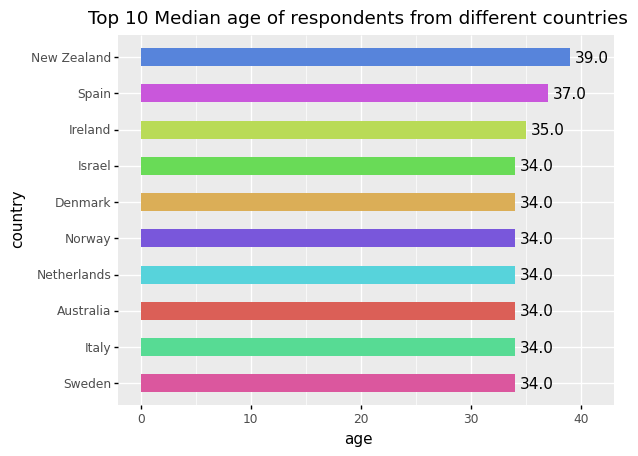

<ggplot: (-9223371865392167764)>

In [18]:
from plotnine import *
import pandas as pd
# 数据准备
median_age_dict={'country':['New Zealand','Spain',
                            'Ireland','Israel','Denmark',
                            'Norway','Netherlands',
                            'Australia','Italy','Sweden'],
                 'age':[39.0,37.0,35.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0]}
median_age = pd.DataFrame(median_age_dict)
(
ggplot(median_age,aes(x='country',y='age',fill='country'))# 创建图像，传入数据来源和映射
    + geom_bar(stat='identity',width=0.5)#建立几何对象，画直方图
    + geom_text(aes(x='country',y='age',label='age'),nudge_y=2)# 添加数据标签,nudge_y将标签上移
    + coord_flip()# 纵向直方图转换为横向直方图
    + xlim(median_age['country'][::-1])# x轴排序
    + theme(legend_position='none')# 隐藏图例
    + ggtitle('Top 10 Median age of respondents from different countries')
)

In [31]:
import xlrd
path_book = r'F:/baidu_moraldata/situation_lex/week_moral/3hour/situation_3a.xls'
workbook = xlrd.open_workbook(path_book)
sheet = workbook.sheet_by_index(0)
print(sheet.ncols)
print(sheet.nrows)
print(sheet.name)

3
169
Sheet1


In [13]:
# 写入文件
# （一）week数据写入
# week_3a
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
'''
# 写入excel
all_moral_time3a_dict = {'3a-am1,0-3hour':week_moral_time3a_am1,
                         '3a-am2,3-6hour':week_moral_time3a_am2,
                         '3a-am3,6-9hour':week_moral_time3a_am3,
                         '3a-am4,9-12hour':week_moral_time3a_am4,
                         '3a-pm1,12-15hour':week_moral_time3a_pm1,
                         '3a-pm2,15-18hour':week_moral_time3a_pm2,
                         '3a-pm3,18-21hour':week_moral_time3a_pm3,
                         '3a-pm4,21-24hour':week_moral_time3a_pm4}

all_moral_time3a_dict_w = pd.DataFrame(all_moral_time3a_dict)
all_moral_time3a_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/3hour/situation_3a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# week_3b
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
all_moral_time3b_dict = {'3b-am1,1-4hour':week_moral_time3b_am1,
                         '3b-am2,4-7hour':week_moral_time3b_am2,
                         '3b-am3,7-10hour':week_moral_time3b_am3,
                         '3b-am4,10-13hour':week_moral_time3b_am4,
                         '3b-pm1,13-16hour':week_moral_time3b_pm1,
                         '3b-pm2,16-19hour':week_moral_time3b_pm2,
                         '3b-pm3,19-22hour':week_moral_time3b_pm3,
                         '3b-pm4,22-1hour':week_moral_time3b_pm4}

all_moral_time3b_dict_w = pd.DataFrame(all_moral_time3b_dict)
all_moral_time3b_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/3hour/situation_3b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# week_3c
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
all_moral_time3c_dict = {'3c-am1,2-5hour':week_moral_time3c_am1,
                         '3c-am2,5-8hour':week_moral_time3c_am2,
                         '3c-am3,8-11hour':week_moral_time3c_am3,
                         '3c-am4,11-14hour':week_moral_time3c_am4,
                         '3c-pm1,14-17hour':week_moral_time3c_pm1,
                         '3c-pm2,17-20hour':week_moral_time3c_pm2,
                         '3c-pm3,20-23hour':week_moral_time3c_pm3,
                         '3c-pm4,23-2hour':week_moral_time3c_pm4}

all_moral_time3c_dict_w = pd.DataFrame(all_moral_time3c_dict)
all_moral_time3c_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/3hour/situation_3c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# week_4a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time4a_dict = {'4a-am1,0-4hour':week_moral_time4a_am1,
                         '4a-am2,4-8hour':week_moral_time4a_am2,
                         '4a-am3,8-12hour':week_moral_time4a_am3,
                         '4a-pm1,12-16hour':week_moral_time4a_pm1,
                         '4a-pm2,16-20hour':week_moral_time4a_pm2,
                         '4a-pm3,20-24hour':week_moral_time4a_pm3}
all_moral_time4a_dict_w = pd.DataFrame(all_moral_time4a_dict)
all_moral_time4a_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/4hour/situation_4a.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# week_4b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time4b_dict = {'4b-am1,1-5hour':week_moral_time4b_am1,
                         '4b-am2,5-9hour':week_moral_time4b_am2,
                         '4b-am3,9-13hour':week_moral_time4b_am3,
                         '4b-pm1,13-17hour':week_moral_time4b_pm1,
                         '4b-pm2,17-21hour':week_moral_time4b_pm2,
                         '4b-pm3,21-1hour':week_moral_time4b_pm3}
all_moral_time4b_dict_w = pd.DataFrame(all_moral_time4b_dict)
all_moral_time4b_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/4hour/situation_4b.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# week_4c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time4c_dict = {'4c-am1,2-6hour':week_moral_time4c_am1,
                         '4c-am2,6-10hour':week_moral_time4c_am2,
                         '4c-am3,10-14hour':week_moral_time4c_am3,
                         '4c-pm1,14-18hour':week_moral_time4c_pm1,
                         '4c-pm2,18-22hour':week_moral_time4c_pm2,
                         '4c-pm3,22-2hour':week_moral_time4c_pm3}
all_moral_time4c_dict_w = pd.DataFrame(all_moral_time4c_dict)
all_moral_time4c_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/4hour/situation_4c.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# week_4d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time4d_dict = {'4d-am1,3-7hour':week_moral_time4d_am1,
                         '4d-am2,7-11hour':week_moral_time4d_am2,
                         '4d-am3,11-15hour':week_moral_time4d_am3,
                         '4d-pm1,15-19hour':week_moral_time4d_pm1,
                         '4d-pm2,19-23hour':week_moral_time4d_pm2,
                         '4d-pm3,23-3hour':week_moral_time4d_pm3}
all_moral_time4d_dict_w = pd.DataFrame(all_moral_time4d_dict)
all_moral_time4d_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/4hour/situation_4d.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# week_6a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time6a_dict = {'6a-am1,0-6hour':week_moral_time6a_am1,
                         '6a-am2,6-12hour':week_moral_time6a_am2,
                         '6a-pm1,12-18hour':week_moral_time6a_pm1,
                         '6a-pm2,18-24hour':week_moral_time6a_pm2}
all_moral_time6a_dict_w = pd.DataFrame(all_moral_time6a_dict)
all_moral_time6a_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/6hour/situation_6a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# week_6b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time6b_dict = {'6b-am1,1-7hour':week_moral_time6b_am1,
                         '6b-am2,7-13hour':week_moral_time6b_am2,
                         '6b-pm1,13-19hour':week_moral_time6b_pm1,
                         '6b-pm2,19-1hour':week_moral_time6b_pm2}
all_moral_time6b_dict_w = pd.DataFrame(all_moral_time6b_dict)
all_moral_time6b_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/6hour/situation_6b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# week_6c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time6c_dict = {'6c-am1,2-8hour':week_moral_time6c_am1,
                         '6c-am2,8-14hour':week_moral_time6c_am2,
                         '6c-pm1,14-20hour':week_moral_time6c_pm1,
                         '6c-pm2,20-2hour':week_moral_time6c_pm2}
all_moral_time6c_dict_w = pd.DataFrame(all_moral_time6c_dict)
all_moral_time6c_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/6hour/situation_6c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# week_6d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time6d_dict = {'6d-am1,3-9hour':week_moral_time6d_am1,
                         '6d-am2,9-15hour':week_moral_time6d_am2,
                         '6d-pm1,15-21hour':week_moral_time6d_pm1,
                         '6d-pm2,21-3hour':week_moral_time6d_pm2}
all_moral_time6d_dict_w = pd.DataFrame(all_moral_time6d_dict)
all_moral_time6d_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/6hour/situation_6d.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# week_6e
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time6e_dict = {'6e-am1,4-10hour':week_moral_time6e_am1,
                         '6e-am2,10-16hour':week_moral_time6e_am2,
                         '6e-pm1,16-22hour':week_moral_time6e_pm1,
                         '6e-pm2,22-4hour':week_moral_time6e_pm2}
all_moral_time6e_dict_w = pd.DataFrame(all_moral_time6e_dict)
all_moral_time6e_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/6hour/situation_6e.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# week_6f
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
all_moral_time6f_dict = {'6f-am1,5-11hour':week_moral_time6f_am1,
                         '6f-am2,11-17hour':week_moral_time6f_am2,
                         '6f-pm1,17-23hour':week_moral_time6f_pm1,
                         '6f-pm2,23-5hour':week_moral_time6f_pm2}
all_moral_time6f_dict_w = pd.DataFrame(all_moral_time6f_dict)
all_moral_time6f_dict_w.to_excel('F:/baidu_moraldata/situation/week_moral/6hour/situation_6f.xls',index=False)
'''
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it ca

In [14]:
# 写入文件
# （二）workdays数据写入

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# workdays_3a
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
'''
# 写入excel
workdays_moral_time3a_dict = {'3a-am1,0-3hour':workdays_moral_time3a_am1,
                         '3a-am2,3-6hour':workdays_moral_time3a_am2,
                         '3a-am3,6-9hour':workdays_moral_time3a_am3,
                         '3a-am4,9-12hour':workdays_moral_time3a_am4,
                         '3a-pm1,12-15hour':workdays_moral_time3a_pm1,
                         '3a-pm2,15-18hour':workdays_moral_time3a_pm2,
                         '3a-pm3,18-21hour':workdays_moral_time3a_pm3,
                         '3a-pm4,21-24hour':workdays_moral_time3a_pm4}

workdays_moral_time3a_dict_w = pd.DataFrame(workdays_moral_time3a_dict)
workdays_moral_time3a_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/3hour/situation_3a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# workdays_3b
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time3b_dict = {'3b-am1,1-4hour':workdays_moral_time3b_am1,
                         '3b-am2,4-7hour':workdays_moral_time3b_am2,
                         '3b-am3,7-10hour':workdays_moral_time3b_am3,
                         '3b-am4,10-13hour':workdays_moral_time3b_am4,
                         '3b-pm1,13-16hour':workdays_moral_time3b_pm1,
                         '3b-pm2,16-19hour':workdays_moral_time3b_pm2,
                         '3b-pm3,19-22hour':workdays_moral_time3b_pm3,
                         '3b-pm4,22-1hour':workdays_moral_time3b_pm4}

workdays_moral_time3b_dict_w = pd.DataFrame(workdays_moral_time3b_dict)
workdays_moral_time3b_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/3hour/situation_3b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# workdays_3c
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time3c_dict = {'3c-am1,2-5hour':workdays_moral_time3c_am1,
                         '3c-am2,5-8hour':workdays_moral_time3c_am2,
                         '3c-am3,8-11hour':workdays_moral_time3c_am3,
                         '3c-am4,11-14hour':workdays_moral_time3c_am4,
                         '3c-pm1,14-17hour':workdays_moral_time3c_pm1,
                         '3c-pm2,17-20hour':workdays_moral_time3c_pm2,
                         '3c-pm3,20-23hour':workdays_moral_time3c_pm3,
                         '3c-pm4,23-2hour':workdays_moral_time3c_pm4}

workdays_moral_time3c_dict_w = pd.DataFrame(workdays_moral_time3c_dict)
workdays_moral_time3c_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/3hour/situation_3c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# workdays_4a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time4a_dict = {'4a-am1,0-4hour':workdays_moral_time4a_am1,
                         '4a-am2,4-8hour':workdays_moral_time4a_am2,
                         '4a-am3,8-12hour':workdays_moral_time4a_am3,
                         '4a-pm1,12-16hour':workdays_moral_time4a_pm1,
                         '4a-pm2,16-20hour':workdays_moral_time4a_pm2,
                         '4a-pm3,20-24hour':workdays_moral_time4a_pm3}
workdays_moral_time4a_dict_w = pd.DataFrame(workdays_moral_time4a_dict)
workdays_moral_time4a_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/4hour/situation_4a.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# workdays_4b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time4b_dict = {'4b-am1,1-5hour':workdays_moral_time4b_am1,
                         '4b-am2,5-9hour':workdays_moral_time4b_am2,
                         '4b-am3,9-13hour':workdays_moral_time4b_am3,
                         '4b-pm1,13-17hour':workdays_moral_time4b_pm1,
                         '4b-pm2,17-21hour':workdays_moral_time4b_pm2,
                         '4b-pm3,21-1hour':workdays_moral_time4b_pm3}
workdays_moral_time4b_dict_w = pd.DataFrame(workdays_moral_time4b_dict)
workdays_moral_time4b_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/4hour/situation_4b.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# workdays_4c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time4c_dict = {'4c-am1,2-6hour':workdays_moral_time4c_am1,
                         '4c-am2,6-10hour':workdays_moral_time4c_am2,
                         '4c-am3,10-14hour':workdays_moral_time4c_am3,
                         '4c-pm1,14-18hour':workdays_moral_time4c_pm1,
                         '4c-pm2,18-22hour':workdays_moral_time4c_pm2,
                         '4c-pm3,22-2hour':workdays_moral_time4c_pm3}
workdays_moral_time4c_dict_w = pd.DataFrame(workdays_moral_time4c_dict)
workdays_moral_time4c_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/4hour/situation_4c.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# workdays_4d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time4d_dict = {'4d-am1,3-7hour':workdays_moral_time4d_am1,
                         '4d-am2,7-11hour':workdays_moral_time4d_am2,
                         '4d-am3,11-15hour':workdays_moral_time4d_am3,
                         '4d-pm1,15-19hour':workdays_moral_time4d_pm1,
                         '4d-pm2,19-23hour':workdays_moral_time4d_pm2,
                         '4d-pm3,23-3hour':workdays_moral_time4d_pm3}
workdays_moral_time4d_dict_w = pd.DataFrame(workdays_moral_time4d_dict)
workdays_moral_time4d_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/4hour/situation_4d.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# workdays_6a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time6a_dict = {'6a-am1,0-6hour':workdays_moral_time6a_am1,
                         '6a-am2,6-12hour':workdays_moral_time6a_am2,
                         '6a-pm1,12-18hour':workdays_moral_time6a_pm1,
                         '6a-pm2,18-24hour':workdays_moral_time6a_pm2}
workdays_moral_time6a_dict_w = pd.DataFrame(workdays_moral_time6a_dict)
workdays_moral_time6a_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/6hour/situation_6a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# workdays_6b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time6b_dict = {'6b-am1,1-7hour':workdays_moral_time6b_am1,
                         '6b-am2,7-13hour':workdays_moral_time6b_am2,
                         '6b-pm1,13-19hour':workdays_moral_time6b_pm1,
                         '6b-pm2,19-1hour':workdays_moral_time6b_pm2}
workdays_moral_time6b_dict_w = pd.DataFrame(workdays_moral_time6b_dict)
workdays_moral_time6b_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/6hour/situation_6b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# workdays_6c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time6c_dict = {'6c-am1,2-8hour':workdays_moral_time6c_am1,
                         '6c-am2,8-14hour':workdays_moral_time6c_am2,
                         '6c-pm1,14-20hour':workdays_moral_time6c_pm1,
                         '6c-pm2,20-2hour':workdays_moral_time6c_pm2}
workdays_moral_time6c_dict_w = pd.DataFrame(workdays_moral_time6c_dict)
workdays_moral_time6c_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/6hour/situation_6c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# workdays_6d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time6d_dict = {'6d-am1,3-9hour':workdays_moral_time6d_am1,
                         '6d-am2,9-15hour':workdays_moral_time6d_am2,
                         '6d-pm1,15-21hour':workdays_moral_time6d_pm1,
                         '6d-pm2,21-3hour':workdays_moral_time6d_pm2}
workdays_moral_time6d_dict_w = pd.DataFrame(workdays_moral_time6d_dict)
workdays_moral_time6d_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/6hour/situation_6d.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# workdays_6e
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time6e_dict = {'6e-am1,4-10hour':workdays_moral_time6e_am1,
                         '6e-am2,10-16hour':workdays_moral_time6e_am2,
                         '6e-pm1,16-22hour':workdays_moral_time6e_pm1,
                         '6e-pm2,22-4hour':workdays_moral_time6e_pm2}
workdays_moral_time6e_dict_w = pd.DataFrame(workdays_moral_time6e_dict)
workdays_moral_time6e_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/6hour/situation_6e.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# workdays_6f
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
workdays_moral_time6f_dict = {'6f-am1,5-11hour':workdays_moral_time6f_am1,
                         '6f-am2,11-17hour':workdays_moral_time6f_am2,
                         '6f-pm1,17-23hour':workdays_moral_time6f_pm1,
                         '6f-pm2,23-5hour':workdays_moral_time6f_pm2}
workdays_moral_time6f_dict_w = pd.DataFrame(workdays_moral_time6f_dict)
workdays_moral_time6f_dict_w.to_excel('F:/baidu_moraldata/situation/workdays_moral/6hour/situation_6f.xls',index=False)
'''
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it ca

In [15]:
# 写入文件
# （三）weekend数据写入

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_3a
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
'''
# 写入excel
weekend_moral_time3a_dict = {'3a-am1,0-3hour':weekend_moral_time3a_am1,
                         '3a-am2,3-6hour':weekend_moral_time3a_am2,
                         '3a-am3,6-9hour':weekend_moral_time3a_am3,
                         '3a-am4,9-12hour':weekend_moral_time3a_am4,
                         '3a-pm1,12-15hour':weekend_moral_time3a_pm1,
                         '3a-pm2,15-18hour':weekend_moral_time3a_pm2,
                         '3a-pm3,18-21hour':weekend_moral_time3a_pm3,
                         '3a-pm4,21-24hour':weekend_moral_time3a_pm4}

weekend_moral_time3a_dict_w = pd.DataFrame(weekend_moral_time3a_dict)
weekend_moral_time3a_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/3hour/situation_3a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_3b
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time3b_dict = {'3b-am1,1-4hour':weekend_moral_time3b_am1,
                         '3b-am2,4-7hour':weekend_moral_time3b_am2,
                         '3b-am3,7-10hour':weekend_moral_time3b_am3,
                         '3b-am4,10-13hour':weekend_moral_time3b_am4,
                         '3b-pm1,13-16hour':weekend_moral_time3b_pm1,
                         '3b-pm2,16-19hour':weekend_moral_time3b_pm2,
                         '3b-pm3,19-22hour':weekend_moral_time3b_pm3,
                         '3b-pm4,22-1hour':weekend_moral_time3b_pm4}

weekend_moral_time3b_dict_w = pd.DataFrame(weekend_moral_time3b_dict)
weekend_moral_time3b_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/3hour/situation_3b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_3c
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time3c_dict = {'3c-am1,2-5hour':weekend_moral_time3c_am1,
                         '3c-am2,5-8hour':weekend_moral_time3c_am2,
                         '3c-am3,8-11hour':weekend_moral_time3c_am3,
                         '3c-am4,11-14hour':weekend_moral_time3c_am4,
                         '3c-pm1,14-17hour':weekend_moral_time3c_pm1,
                         '3c-pm2,17-20hour':weekend_moral_time3c_pm2,
                         '3c-pm3,20-23hour':weekend_moral_time3c_pm3,
                         '3c-pm4,23-2hour':weekend_moral_time3c_pm4}

weekend_moral_time3c_dict_w = pd.DataFrame(weekend_moral_time3c_dict)
weekend_moral_time3c_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/3hour/situation_3c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_4a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time4a_dict = {'4a-am1,0-4hour':weekend_moral_time4a_am1,
                         '4a-am2,4-8hour':weekend_moral_time4a_am2,
                         '4a-am3,8-12hour':weekend_moral_time4a_am3,
                         '4a-pm1,12-16hour':weekend_moral_time4a_pm1,
                         '4a-pm2,16-20hour':weekend_moral_time4a_pm2,
                         '4a-pm3,20-24hour':weekend_moral_time4a_pm3}
weekend_moral_time4a_dict_w = pd.DataFrame(weekend_moral_time4a_dict)
weekend_moral_time4a_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/4hour/situation_4a.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_4b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time4b_dict = {'4b-am1,1-5hour':weekend_moral_time4b_am1,
                         '4b-am2,5-9hour':weekend_moral_time4b_am2,
                         '4b-am3,9-13hour':weekend_moral_time4b_am3,
                         '4b-pm1,13-17hour':weekend_moral_time4b_pm1,
                         '4b-pm2,17-21hour':weekend_moral_time4b_pm2,
                         '4b-pm3,21-1hour':weekend_moral_time4b_pm3}
weekend_moral_time4b_dict_w = pd.DataFrame(weekend_moral_time4b_dict)
weekend_moral_time4b_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/4hour/situation_4b.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_4c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time4c_dict = {'4c-am1,2-6hour':weekend_moral_time4c_am1,
                         '4c-am2,6-10hour':weekend_moral_time4c_am2,
                         '4c-am3,10-14hour':weekend_moral_time4c_am3,
                         '4c-pm1,14-18hour':weekend_moral_time4c_pm1,
                         '4c-pm2,18-22hour':weekend_moral_time4c_pm2,
                         '4c-pm3,22-2hour':weekend_moral_time4c_pm3}
weekend_moral_time4c_dict_w = pd.DataFrame(weekend_moral_time4c_dict)
weekend_moral_time4c_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/4hour/situation_4c.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_4d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time4d_dict = {'4d-am1,3-7hour':weekend_moral_time4d_am1,
                         '4d-am2,7-11hour':weekend_moral_time4d_am2,
                         '4d-am3,11-15hour':weekend_moral_time4d_am3,
                         '4d-pm1,15-19hour':weekend_moral_time4d_pm1,
                         '4d-pm2,19-23hour':weekend_moral_time4d_pm2,
                         '4d-pm3,23-3hour':weekend_moral_time4d_pm3}
weekend_moral_time4d_dict_w = pd.DataFrame(weekend_moral_time4d_dict)
weekend_moral_time4d_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/4hour/situation_4d.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_6a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time6a_dict = {'6a-am1,0-6hour':weekend_moral_time6a_am1,
                         '6a-am2,6-12hour':weekend_moral_time6a_am2,
                         '6a-pm1,12-18hour':weekend_moral_time6a_pm1,
                         '6a-pm2,18-24hour':weekend_moral_time6a_pm2}
weekend_moral_time6a_dict_w = pd.DataFrame(weekend_moral_time6a_dict)
weekend_moral_time6a_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/6hour/situation_6a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_6b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time6b_dict = {'6b-am1,1-7hour':weekend_moral_time6b_am1,
                         '6b-am2,7-13hour':weekend_moral_time6b_am2,
                         '6b-pm1,13-19hour':weekend_moral_time6b_pm1,
                         '6b-pm2,19-1hour':weekend_moral_time6b_pm2}
weekend_moral_time6b_dict_w = pd.DataFrame(weekend_moral_time6b_dict)
weekend_moral_time6b_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/6hour/situation_6b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_6c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time6c_dict = {'6c-am1,2-8hour':weekend_moral_time6c_am1,
                         '6c-am2,8-14hour':weekend_moral_time6c_am2,
                         '6c-pm1,14-20hour':weekend_moral_time6c_pm1,
                         '6c-pm2,20-2hour':weekend_moral_time6c_pm2}
weekend_moral_time6c_dict_w = pd.DataFrame(weekend_moral_time6c_dict)
weekend_moral_time6c_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/6hour/situation_6c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_6d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time6d_dict = {'6d-am1,3-9hour':weekend_moral_time6d_am1,
                         '6d-am2,9-15hour':weekend_moral_time6d_am2,
                         '6d-pm1,15-21hour':weekend_moral_time6d_pm1,
                         '6d-pm2,21-3hour':weekend_moral_time6d_pm2}
weekend_moral_time6d_dict_w = pd.DataFrame(weekend_moral_time6d_dict)
weekend_moral_time6d_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/6hour/situation_6d.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_6e
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time6e_dict = {'6e-am1,4-10hour':weekend_moral_time6e_am1,
                         '6e-am2,10-16hour':weekend_moral_time6e_am2,
                         '6e-pm1,16-22hour':weekend_moral_time6e_pm1,
                         '6e-pm2,22-4hour':weekend_moral_time6e_pm2}
weekend_moral_time6e_dict_w = pd.DataFrame(weekend_moral_time6e_dict)
weekend_moral_time6e_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/6hour/situation_6e.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_6f
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_moral_time6f_dict = {'6f-am1,5-11hour':weekend_moral_time6f_am1,
                         '6f-am2,11-17hour':weekend_moral_time6f_am2,
                         '6f-pm1,17-23hour':weekend_moral_time6f_pm1,
                         '6f-pm2,23-5hour':weekend_moral_time6f_pm2}
weekend_moral_time6f_dict_w = pd.DataFrame(weekend_moral_time6f_dict)
weekend_moral_time6f_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_moral/6hour/situation_6f.xls',index=False)
'''
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it ca

In [16]:
# 写入文件
# （四）holiday数据写入

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# holiday_3a
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
'''
# 写入excel
holiday_moral_time3a_dict = {'3a-am1,0-3hour':holiday_moral_time3a_am1,
                         '3a-am2,3-6hour':holiday_moral_time3a_am2,
                         '3a-am3,6-9hour':holiday_moral_time3a_am3,
                         '3a-am4,9-12hour':holiday_moral_time3a_am4,
                         '3a-pm1,12-15hour':holiday_moral_time3a_pm1,
                         '3a-pm2,15-18hour':holiday_moral_time3a_pm2,
                         '3a-pm3,18-21hour':holiday_moral_time3a_pm3,
                         '3a-pm4,21-24hour':holiday_moral_time3a_pm4}

holiday_moral_time3a_dict_w = pd.DataFrame(holiday_moral_time3a_dict)
holiday_moral_time3a_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/3hour/situation_3a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# holiday_3b
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time3b_dict = {'3b-am1,1-4hour':holiday_moral_time3b_am1,
                         '3b-am2,4-7hour':holiday_moral_time3b_am2,
                         '3b-am3,7-10hour':holiday_moral_time3b_am3,
                         '3b-am4,10-13hour':holiday_moral_time3b_am4,
                         '3b-pm1,13-16hour':holiday_moral_time3b_pm1,
                         '3b-pm2,16-19hour':holiday_moral_time3b_pm2,
                         '3b-pm3,19-22hour':holiday_moral_time3b_pm3,
                         '3b-pm4,22-1hour':holiday_moral_time3b_pm4}

holiday_moral_time3b_dict_w = pd.DataFrame(holiday_moral_time3b_dict)
holiday_moral_time3b_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/3hour/situation_3b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# holiday_3c
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time3c_dict = {'3c-am1,2-5hour':holiday_moral_time3c_am1,
                         '3c-am2,5-8hour':holiday_moral_time3c_am2,
                         '3c-am3,8-11hour':holiday_moral_time3c_am3,
                         '3c-am4,11-14hour':holiday_moral_time3c_am4,
                         '3c-pm1,14-17hour':holiday_moral_time3c_pm1,
                         '3c-pm2,17-20hour':holiday_moral_time3c_pm2,
                         '3c-pm3,20-23hour':holiday_moral_time3c_pm3,
                         '3c-pm4,23-2hour':holiday_moral_time3c_pm4}

holiday_moral_time3c_dict_w = pd.DataFrame(holiday_moral_time3c_dict)
holiday_moral_time3c_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/3hour/situation_3c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# holiday_4a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time4a_dict = {'4a-am1,0-4hour':holiday_moral_time4a_am1,
                         '4a-am2,4-8hour':holiday_moral_time4a_am2,
                         '4a-am3,8-12hour':holiday_moral_time4a_am3,
                         '4a-pm1,12-16hour':holiday_moral_time4a_pm1,
                         '4a-pm2,16-20hour':holiday_moral_time4a_pm2,
                         '4a-pm3,20-24hour':holiday_moral_time4a_pm3}
holiday_moral_time4a_dict_w = pd.DataFrame(holiday_moral_time4a_dict)
holiday_moral_time4a_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/4hour/situation_4a.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# holiday_4b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time4b_dict = {'4b-am1,1-5hour':holiday_moral_time4b_am1,
                         '4b-am2,5-9hour':holiday_moral_time4b_am2,
                         '4b-am3,9-13hour':holiday_moral_time4b_am3,
                         '4b-pm1,13-17hour':holiday_moral_time4b_pm1,
                         '4b-pm2,17-21hour':holiday_moral_time4b_pm2,
                         '4b-pm3,21-1hour':holiday_moral_time4b_pm3}
holiday_moral_time4b_dict_w = pd.DataFrame(holiday_moral_time4b_dict)
holiday_moral_time4b_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/4hour/situation_4b.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# holiday_4c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time4c_dict = {'4c-am1,2-6hour':holiday_moral_time4c_am1,
                         '4c-am2,6-10hour':holiday_moral_time4c_am2,
                         '4c-am3,10-14hour':holiday_moral_time4c_am3,
                         '4c-pm1,14-18hour':holiday_moral_time4c_pm1,
                         '4c-pm2,18-22hour':holiday_moral_time4c_pm2,
                         '4c-pm3,22-2hour':holiday_moral_time4c_pm3}
holiday_moral_time4c_dict_w = pd.DataFrame(holiday_moral_time4c_dict)
holiday_moral_time4c_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/4hour/situation_4c.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# holiday_4d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time4d_dict = {'4d-am1,3-7hour':holiday_moral_time4d_am1,
                         '4d-am2,7-11hour':holiday_moral_time4d_am2,
                         '4d-am3,11-15hour':holiday_moral_time4d_am3,
                         '4d-pm1,15-19hour':holiday_moral_time4d_pm1,
                         '4d-pm2,19-23hour':holiday_moral_time4d_pm2,
                         '4d-pm3,23-3hour':holiday_moral_time4d_pm3}
holiday_moral_time4d_dict_w = pd.DataFrame(holiday_moral_time4d_dict)
holiday_moral_time4d_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/4hour/situation_4d.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# holiday_6a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time6a_dict = {'6a-am1,0-6hour':holiday_moral_time6a_am1,
                         '6a-am2,6-12hour':holiday_moral_time6a_am2,
                         '6a-pm1,12-18hour':holiday_moral_time6a_pm1,
                         '6a-pm2,18-24hour':holiday_moral_time6a_pm2}
holiday_moral_time6a_dict_w = pd.DataFrame(holiday_moral_time6a_dict)
holiday_moral_time6a_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/6hour/situation_6a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# holiday_6b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time6b_dict = {'6b-am1,1-7hour':holiday_moral_time6b_am1,
                         '6b-am2,7-13hour':holiday_moral_time6b_am2,
                         '6b-pm1,13-19hour':holiday_moral_time6b_pm1,
                         '6b-pm2,19-1hour':holiday_moral_time6b_pm2}
holiday_moral_time6b_dict_w = pd.DataFrame(holiday_moral_time6b_dict)
holiday_moral_time6b_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/6hour/situation_6b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# holiday_6c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time6c_dict = {'6c-am1,2-8hour':holiday_moral_time6c_am1,
                         '6c-am2,8-14hour':holiday_moral_time6c_am2,
                         '6c-pm1,14-20hour':holiday_moral_time6c_pm1,
                         '6c-pm2,20-2hour':holiday_moral_time6c_pm2}
holiday_moral_time6c_dict_w = pd.DataFrame(holiday_moral_time6c_dict)
holiday_moral_time6c_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/6hour/situation_6c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# holiday_6d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time6d_dict = {'6d-am1,3-9hour':holiday_moral_time6d_am1,
                         '6d-am2,9-15hour':holiday_moral_time6d_am2,
                         '6d-pm1,15-21hour':holiday_moral_time6d_pm1,
                         '6d-pm2,21-3hour':holiday_moral_time6d_pm2}
holiday_moral_time6d_dict_w = pd.DataFrame(holiday_moral_time6d_dict)
holiday_moral_time6d_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/6hour/situation_6d.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# holiday_6e
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time6e_dict = {'6e-am1,4-10hour':holiday_moral_time6e_am1,
                         '6e-am2,10-16hour':holiday_moral_time6e_am2,
                         '6e-pm1,16-22hour':holiday_moral_time6e_pm1,
                         '6e-pm2,22-4hour':holiday_moral_time6e_pm2}
holiday_moral_time6e_dict_w = pd.DataFrame(holiday_moral_time6e_dict)
holiday_moral_time6e_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/6hour/situation_6e.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# holiday_6f
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
holiday_moral_time6f_dict = {'6f-am1,5-11hour':holiday_moral_time6f_am1,
                         '6f-am2,11-17hour':holiday_moral_time6f_am2,
                         '6f-pm1,17-23hour':holiday_moral_time6f_pm1,
                         '6f-pm2,23-5hour':holiday_moral_time6f_pm2}
holiday_moral_time6f_dict_w = pd.DataFrame(holiday_moral_time6f_dict)
holiday_moral_time6f_dict_w.to_excel('F:/baidu_moraldata/situation/holiday_moral/6hour/situation_6f.xls',index=False)
'''
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it ca

In [17]:
# 写入文件
# （五）weekend_holiday数据写入

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_holiday_3a
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
'''
# 写入excel
weekend_holiday_moral_time3a_dict = {'3a-am1,0-3hour':weekend_holiday_moral_time3a_am1,
                         '3a-am2,3-6hour':weekend_holiday_moral_time3a_am2,
                         '3a-am3,6-9hour':weekend_holiday_moral_time3a_am3,
                         '3a-am4,9-12hour':weekend_holiday_moral_time3a_am4,
                         '3a-pm1,12-15hour':weekend_holiday_moral_time3a_pm1,
                         '3a-pm2,15-18hour':weekend_holiday_moral_time3a_pm2,
                         '3a-pm3,18-21hour':weekend_holiday_moral_time3a_pm3,
                         '3a-pm4,21-24hour':weekend_holiday_moral_time3a_pm4}

weekend_holiday_moral_time3a_dict_w = pd.DataFrame(weekend_holiday_moral_time3a_dict)
weekend_holiday_moral_time3a_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/3hour/situation_3a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_holiday_3b
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time3b_dict = {'3b-am1,1-4hour':weekend_holiday_moral_time3b_am1,
                         '3b-am2,4-7hour':weekend_holiday_moral_time3b_am2,
                         '3b-am3,7-10hour':weekend_holiday_moral_time3b_am3,
                         '3b-am4,10-13hour':weekend_holiday_moral_time3b_am4,
                         '3b-pm1,13-16hour':weekend_holiday_moral_time3b_pm1,
                         '3b-pm2,16-19hour':weekend_holiday_moral_time3b_pm2,
                         '3b-pm3,19-22hour':weekend_holiday_moral_time3b_pm3,
                         '3b-pm4,22-1hour':weekend_holiday_moral_time3b_pm4}

weekend_holiday_moral_time3b_dict_w = pd.DataFrame(weekend_holiday_moral_time3b_dict)
weekend_holiday_moral_time3b_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/3hour/situation_3b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_holiday_3c
#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time3c_dict = {'3c-am1,2-5hour':weekend_holiday_moral_time3c_am1,
                         '3c-am2,5-8hour':weekend_holiday_moral_time3c_am2,
                         '3c-am3,8-11hour':weekend_holiday_moral_time3c_am3,
                         '3c-am4,11-14hour':weekend_holiday_moral_time3c_am4,
                         '3c-pm1,14-17hour':weekend_holiday_moral_time3c_pm1,
                         '3c-pm2,17-20hour':weekend_holiday_moral_time3c_pm2,
                         '3c-pm3,20-23hour':weekend_holiday_moral_time3c_pm3,
                         '3c-pm4,23-2hour':weekend_holiday_moral_time3c_pm4}

weekend_holiday_moral_time3c_dict_w = pd.DataFrame(weekend_holiday_moral_time3c_dict)
weekend_holiday_moral_time3c_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/3hour/situation_3c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_holiday_4a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time4a_dict = {'4a-am1,0-4hour':weekend_holiday_moral_time4a_am1,
                         '4a-am2,4-8hour':weekend_holiday_moral_time4a_am2,
                         '4a-am3,8-12hour':weekend_holiday_moral_time4a_am3,
                         '4a-pm1,12-16hour':weekend_holiday_moral_time4a_pm1,
                         '4a-pm2,16-20hour':weekend_holiday_moral_time4a_pm2,
                         '4a-pm3,20-24hour':weekend_holiday_moral_time4a_pm3}
weekend_holiday_moral_time4a_dict_w = pd.DataFrame(weekend_holiday_moral_time4a_dict)
weekend_holiday_moral_time4a_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/4hour/situation_4a.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_holiday_4b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time4b_dict = {'4b-am1,1-5hour':weekend_holiday_moral_time4b_am1,
                         '4b-am2,5-9hour':weekend_holiday_moral_time4b_am2,
                         '4b-am3,9-13hour':weekend_holiday_moral_time4b_am3,
                         '4b-pm1,13-17hour':weekend_holiday_moral_time4b_pm1,
                         '4b-pm2,17-21hour':weekend_holiday_moral_time4b_pm2,
                         '4b-pm3,21-1hour':weekend_holiday_moral_time4b_pm3}
weekend_holiday_moral_time4b_dict_w = pd.DataFrame(weekend_holiday_moral_time4b_dict)
weekend_holiday_moral_time4b_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/4hour/situation_4b.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_holiday_4c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time4c_dict = {'4c-am1,2-6hour':weekend_holiday_moral_time4c_am1,
                         '4c-am2,6-10hour':weekend_holiday_moral_time4c_am2,
                         '4c-am3,10-14hour':weekend_holiday_moral_time4c_am3,
                         '4c-pm1,14-18hour':weekend_holiday_moral_time4c_pm1,
                         '4c-pm2,18-22hour':weekend_holiday_moral_time4c_pm2,
                         '4c-pm3,22-2hour':weekend_holiday_moral_time4c_pm3}
weekend_holiday_moral_time4c_dict_w = pd.DataFrame(weekend_holiday_moral_time4c_dict)
weekend_holiday_moral_time4c_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/4hour/situation_4c.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_holiday_4d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time4d_dict = {'4d-am1,3-7hour':weekend_holiday_moral_time4d_am1,
                         '4d-am2,7-11hour':weekend_holiday_moral_time4d_am2,
                         '4d-am3,11-15hour':weekend_holiday_moral_time4d_am3,
                         '4d-pm1,15-19hour':weekend_holiday_moral_time4d_pm1,
                         '4d-pm2,19-23hour':weekend_holiday_moral_time4d_pm2,
                         '4d-pm3,23-3hour':weekend_holiday_moral_time4d_pm3}
weekend_holiday_moral_time4d_dict_w = pd.DataFrame(weekend_holiday_moral_time4d_dict)
weekend_holiday_moral_time4d_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/4hour/situation_4d.xls',index=False)

#(((((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))
# weekend_holiday_6a
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time6a_dict = {'6a-am1,0-6hour':weekend_holiday_moral_time6a_am1,
                         '6a-am2,6-12hour':weekend_holiday_moral_time6a_am2,
                         '6a-pm1,12-18hour':weekend_holiday_moral_time6a_pm1,
                         '6a-pm2,18-24hour':weekend_holiday_moral_time6a_pm2}
weekend_holiday_moral_time6a_dict_w = pd.DataFrame(weekend_holiday_moral_time6a_dict)
weekend_holiday_moral_time6a_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/6hour/situation_6a.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_holiday_6b
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time6b_dict = {'6b-am1,1-7hour':weekend_holiday_moral_time6b_am1,
                         '6b-am2,7-13hour':weekend_holiday_moral_time6b_am2,
                         '6b-pm1,13-19hour':weekend_holiday_moral_time6b_pm1,
                         '6b-pm2,19-1hour':weekend_holiday_moral_time6b_pm2}
weekend_holiday_moral_time6b_dict_w = pd.DataFrame(weekend_holiday_moral_time6b_dict)
weekend_holiday_moral_time6b_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/6hour/situation_6b.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_holiday_6c
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time6c_dict = {'6c-am1,2-8hour':weekend_holiday_moral_time6c_am1,
                         '6c-am2,8-14hour':weekend_holiday_moral_time6c_am2,
                         '6c-pm1,14-20hour':weekend_holiday_moral_time6c_pm1,
                         '6c-pm2,20-2hour':weekend_holiday_moral_time6c_pm2}
weekend_holiday_moral_time6c_dict_w = pd.DataFrame(weekend_holiday_moral_time6c_dict)
weekend_holiday_moral_time6c_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/6hour/situation_6c.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_holiday_6d
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time6d_dict = {'6d-am1,3-9hour':weekend_holiday_moral_time6d_am1,
                         '6d-am2,9-15hour':weekend_holiday_moral_time6d_am2,
                         '6d-pm1,15-21hour':weekend_holiday_moral_time6d_pm1,
                         '6d-pm2,21-3hour':weekend_holiday_moral_time6d_pm2}
weekend_holiday_moral_time6d_dict_w = pd.DataFrame(weekend_holiday_moral_time6d_dict)
weekend_holiday_moral_time6d_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/6hour/situation_6d.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_holiday_6e
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time6e_dict = {'6e-am1,4-10hour':weekend_holiday_moral_time6e_am1,
                         '6e-am2,10-16hour':weekend_holiday_moral_time6e_am2,
                         '6e-pm1,16-22hour':weekend_holiday_moral_time6e_pm1,
                         '6e-pm2,22-4hour':weekend_holiday_moral_time6e_pm2}
weekend_holiday_moral_time6e_dict_w = pd.DataFrame(weekend_holiday_moral_time6e_dict)
weekend_holiday_moral_time6e_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/6hour/situation_6e.xls',index=False)

#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))
# weekend_holiday_6f
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

# 写入excel
weekend_holiday_moral_time6f_dict = {'6f-am1,5-11hour':weekend_holiday_moral_time6f_am1,
                         '6f-am2,11-17hour':weekend_holiday_moral_time6f_am2,
                         '6f-pm1,17-23hour':weekend_holiday_moral_time6f_pm1,
                         '6f-pm2,23-5hour':weekend_holiday_moral_time6f_pm2}
weekend_holiday_moral_time6f_dict_w = pd.DataFrame(weekend_holiday_moral_time6f_dict)
weekend_holiday_moral_time6f_dict_w.to_excel('F:/baidu_moraldata/situation/weekend_holiday_moral/6hour/situation_6f.xls',index=False)
'''
#((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))

E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
E:\MLTools\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it ca